In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import pandas as pd
from global_model_periodic_energy import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from scipy.spatial import Voronoi
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')


In [3]:
def compute_polygon_area_and_perimeter(polygon):
    polygon = np.array(polygon)
    # Aire (Green's theorem)
    x = polygon[:, 0]
    y = polygon[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    # Périmètre
    perimeter = np.sum(np.linalg.norm(np.roll(polygon, -1, axis=0) - polygon, axis=1))
    return area, perimeter

def vornoi_area_and_perimeter(vor,target_indices):
    """
    Computes the area and perimeter of Voronoi regions.

    Args:
        vor (scipy.spatial.Voronoi): Voronoi diagram object.

    Returns:
        tuple: Areas and perimeters of the Voronoi regions.
    """

    areas = []
    perimeters = []

    for idx in target_indices:
        region_index = vor.point_region[idx]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            areas.append(1e-10)
            perimeters.append(1e-10)
            continue
        polygon = [vor.vertices[i] for i in region]
        area, perimeter = compute_polygon_area_and_perimeter(polygon)
        areas.append(area)
        perimeters.append(perimeter)          
    return areas,perimeters

In [4]:
def voronoi_loss(output,target_indices,accelerations,target_areas= 0.4,masse = 0.1, dt = 0.05):
    areas = []
    perimeters = []
    vor = Voronoi(output.cpu().detach().numpy())
    area,perimeter = vornoi_area_and_perimeter(vor,target_indices)
    areas.append(area)
    perimeters.append(perimeter)
    areas_tensor = torch.tensor(np.array(areas), dtype=torch.float32).to(device)
    perimeters_tensor = torch.tensor(np.array(perimeters),dtype=torch.float32).to(device)
    # areas_tensor = torch.stack(areas)
    # perimeters_tensor = torch.stack(perimeters)
    physics_loss = 0.02*(target_areas - areas_tensor)**2 + 0.000*perimeters_tensor+1e-5*(target_areas/(areas_tensor))**2
    # kinetic_loss = torch.sum((0.5*masse*dt**2)*(accelerations/(dt**2))**2,dim=-1)
    # print(physics_loss,kinetic_loss)
    return (physics_loss).squeeze(0)#+kinetic_loss

In [5]:
def loss_complete(energy, target):
    mse_loss = torch.nn.functional.mse_loss(energy, target)
    return mse_loss

In [6]:
def rotate_points(points, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians),  np.cos(angle_radians)]
    ])
    return points @ rotation_matrix.T

In [7]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step,n_cells, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(41,57):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data).to(device)  # garde la précision float32
                    clean_positions.append(pos)

            for t in range(2, len(clean_positions)):
                # séquence des N dernières positions
                input_seq = clean_positions[t-2:t+1]  # list of tensors

                # calcul de l'accélération à partir des 3 derniers
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2 * x_t1 + x_t2
                # angle = np.random.randint(0,360)
                # x_t = torch.tensor(rotate_points(x_t.cpu().detach().numpy(),angle),dtype = torch.float32).to(device)
                energy = voronoi_loss(x_t,np.arange(n_cells),acc[:n_cells])
                # bruit seulement sur les entrées
                def noisy(x): 
                    x= x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x
                    return x
                    

                #print(energy)
                input_seq_noisy = torch.stack([noisy(x_t)])  # [seq_len, N, 2]
                self.samples.append((input_seq_noisy, energy))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [8]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float).to(device)
    energy = model(x,n_cells)
    return energy

In [9]:
def avg_test(model,device,csv_file,n_cells):
    model.eval()
    loss = 0
    target_indices = np.arange(n_cells)
    csvpath = csv_file + str(57) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    loss_fn = loss_complete
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy = generate_next_positions(model, device, [positions],n_cells)
        loss_actu=torch.nn.functional.mse_loss(energy,1e4*voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),target_indices,None)).item()
        loss+=loss_actu
    return loss/200
        

In [10]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = StepLR(optimizer, 25,gamma = 0.9)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=200,n_cells = n_cells, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)  # [B, seq_len, N, 2]
            acc = acc.to(device).squeeze(0)      # [B, N, 2]
            acc =acc[:n_cells]
            # permute to [B, N, seq_len, 2] if nécessaire selon le modèle
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0)  # [B, N, seq_len, 2]
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                energy = model(input_traj,n_cells)
                loss = loss_fn(energy, acc*1e4)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1
        scheduler.step()
        avg_loss = total_loss / total_batches if total_batches > 0 else 0

        if epoch % 1 == 0:
            for param_group in optimizer.param_groups:
                print(f"Current learning rate: {param_group['lr']}")
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(acc*1e4,energy)
            # Save model and loss
            path_prefix = "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/model/periodicity/mse_energy_fully_connected_5Conv_512_57test_edge_weight_200step_25steplr_0_9_2random_data_exp2/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [11]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e0, 1e0]).to(device)}
}

In [12]:
# checkpoint = torch.load("/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/model/periodicity/mse_energy_rotate_2Conv_128_2relu/model_114.pth")

# # Supprimer le préfixe "_orig_mod." de toutes les clés
# new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}

# Charger dans le modèle
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device,n_cells = 10)
# model.load_state_dict(new_state_dict)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_",
    loss_fn=loss_complete,
    epochs= 1001,
    lr=1e-4,
    batch_size=1,
    seq_len=30,
    noise_std=0.0,
    device='cuda'
)


Loading dataset...
Dataset loaded in 6.18 seconds


  0%|          | 0/1001 [00:00<?, ?it/s]W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0] Graph break from `Tensor.item()`, consider setting:
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0]     torch._dynamo.config.capture_scalar_outputs = True
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0] or:
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0] to include these operations in the captured graph.
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0] 
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0] Graph break: from user code at:
W0707 14:46:32.223000 236767 torch/_dynamo/variables/tensor.py:913] [0/0]   File "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/global_model_periodic_energy.py", line 30, in forward
W0707 14:

Current learning rate: 0.0001
Epoch 1/1001, Avg Loss: 17.138513


  0%|          | 1/1001 [00:13<3:48:00, 13.68s/it]

Test Loss: 4.275163
tensor([2.6780, 2.3133, 0.3460, 0.8796, 4.6365, 0.2969, 0.7395, 3.6049, 0.0997,
        4.1660], device='cuda:0') tensor([2.9078, 2.2858, 2.2316, 0.6622, 7.0088, 0.8266, 1.1215, 3.1002, 0.6475,
        3.6308], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 2/1001, Avg Loss: 8.562818


  0%|          | 2/1001 [00:25<3:25:49, 12.36s/it]

Test Loss: 3.407920
tensor([0.6804, 1.2091, 2.5602, 1.6724, 0.2024, 0.8153, 0.1779, 0.6558, 0.7438,
        4.2149], device='cuda:0') tensor([0.5042, 1.5553, 1.9801, 3.2179, 0.7777, 1.0659, 0.5306, 0.9298, 0.8845,
        1.3114], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 3/1001, Avg Loss: 7.933886


  0%|          | 3/1001 [00:36<3:21:44, 12.13s/it]

Test Loss: 3.344551
tensor([10.0927,  1.2198,  7.2472,  9.1085,  1.6727,  1.4788,  0.1394,  0.3420,
         0.1451,  5.6780], device='cuda:0') tensor([3.3778, 0.7535, 3.0198, 4.2839, 0.9222, 2.2558, 1.7921, 0.7413, 0.6680,
        3.9885], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 4/1001, Avg Loss: 8.340014


  0%|          | 4/1001 [00:48<3:19:16, 11.99s/it]

Test Loss: 3.052022
tensor([0.1115, 0.4050, 3.9979, 0.1078, 0.5121, 0.8288, 0.3241, 0.5073, 0.1149,
        3.4996], device='cuda:0') tensor([0.7068, 0.7791, 2.5721, 0.8285, 0.8007, 1.1163, 0.7258, 0.9699, 0.7333,
        1.3655], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 5/1001, Avg Loss: 9.185740


  0%|          | 5/1001 [01:00<3:15:05, 11.75s/it]

Test Loss: 2.746585
tensor([0.1002, 0.1002, 6.4739, 1.9596, 2.5359, 7.4960, 5.0314, 0.0997, 1.8641,
        4.7437], device='cuda:0') tensor([0.7360, 0.8449, 1.4830, 3.3287, 6.0837, 6.2532, 4.8887, 0.7577, 2.2369,
        4.1777], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 6/1001, Avg Loss: 8.173892


  1%|          | 6/1001 [01:11<3:14:07, 11.71s/it]

Test Loss: 2.868375
tensor([0.8082, 1.6964, 1.4087, 1.3600, 4.7309, 3.0420, 0.9355, 0.1005, 0.6043,
        1.2250], device='cuda:0') tensor([1.3117, 1.8009, 1.7628, 0.7371, 4.0392, 2.5041, 0.6876, 1.5692, 1.2371,
        2.0021], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 7/1001, Avg Loss: 7.653127


  1%|          | 7/1001 [01:22<3:11:41, 11.57s/it]

Test Loss: 2.795603
tensor([0.1652, 1.8992, 0.4933, 0.1099, 7.3696, 0.5122, 0.1319, 4.3114, 0.3562,
        0.2903], device='cuda:0') tensor([ 0.5237,  2.9249,  1.0573,  1.0279, 10.3026,  0.9765,  0.4750,  4.2393,
         1.0180,  0.7298], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 8/1001, Avg Loss: 7.348435


  1%|          | 8/1001 [01:34<3:11:50, 11.59s/it]

Test Loss: 2.439033
tensor([0.9311, 0.1205, 2.3162, 1.0921, 2.3228, 6.8139, 0.5161, 1.3671, 0.3357,
        0.5751], device='cuda:0') tensor([0.5928, 0.6447, 1.9379, 1.0617, 1.6350, 5.4674, 0.6549, 2.4133, 0.9799,
        1.1398], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 9/1001, Avg Loss: 7.114010


  1%|          | 9/1001 [01:46<3:14:08, 11.74s/it]

Test Loss: 2.730056
tensor([3.9222, 0.5070, 3.4643, 1.1192, 1.4350, 4.5494, 1.1556, 1.4626, 0.9376,
        0.1366], device='cuda:0') tensor([2.7070, 0.8224, 4.5671, 0.7967, 1.7491, 4.5965, 0.7943, 2.9281, 1.8748,
        0.6736], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 10/1001, Avg Loss: 6.647373


  1%|          | 10/1001 [01:58<3:13:27, 11.71s/it]

Test Loss: 2.595883
tensor([4.0592, 2.7588, 1.7952, 0.3562, 0.8843, 0.1013, 2.5967, 0.7013, 4.8351,
        4.0864], device='cuda:0') tensor([3.5468, 2.0868, 1.9658, 0.8014, 1.8586, 0.5864, 4.1455, 1.0898, 2.3475,
        4.3535], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 11/1001, Avg Loss: 6.189884


  1%|          | 11/1001 [02:09<3:12:15, 11.65s/it]

Test Loss: 2.423809
tensor([2.3677, 0.3367, 7.6720, 1.2221, 0.3331, 0.1152, 2.0109, 8.2249, 0.7642,
        0.1005], device='cuda:0') tensor([1.9697, 0.5179, 7.6024, 3.1598, 0.5835, 0.4688, 2.3649, 6.3868, 1.3558,
        0.5031], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 12/1001, Avg Loss: 5.953130


  1%|          | 12/1001 [02:21<3:13:06, 11.72s/it]

Test Loss: 2.320836
tensor([1.2200, 0.3850, 1.2404, 8.8385, 0.1081, 0.2330, 3.5828, 0.1634, 0.1191,
        0.1080], device='cuda:0') tensor([1.0573, 0.4057, 0.7775, 9.7178, 0.3129, 0.3139, 3.8406, 0.5339, 0.2979,
        0.7673], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 13/1001, Avg Loss: 5.638217


  1%|▏         | 13/1001 [02:33<3:12:36, 11.70s/it]

Test Loss: 2.438820
tensor([1.0315, 2.0788, 2.4154, 1.1023, 0.1572, 0.1005, 0.1048, 0.9802, 1.8069,
        5.4826], device='cuda:0') tensor([0.4370, 0.8908, 1.1804, 0.4714, 0.4911, 0.3120, 1.2315, 1.5515, 0.6868,
        4.2285], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 14/1001, Avg Loss: 5.692183


  1%|▏         | 14/1001 [02:45<3:12:29, 11.70s/it]

Test Loss: 2.326677
tensor([0.6523, 0.1005, 1.0666, 0.2898, 0.2232, 0.2737, 1.1570, 0.4063, 0.6601,
        2.6276], device='cuda:0') tensor([0.2289, 0.3534, 0.6152, 0.5334, 0.4179, 0.2942, 0.4037, 0.4830, 0.7059,
        1.6782], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 15/1001, Avg Loss: 5.618391


  1%|▏         | 15/1001 [02:56<3:12:42, 11.73s/it]

Test Loss: 3.023274
tensor([ 0.5786,  4.2451,  8.1129,  0.2803,  0.1324, 10.4839, 11.8505,  2.8214,
         5.5388, 10.6734], device='cuda:0') tensor([1.7576, 2.1725, 6.8036, 2.1094, 2.5006, 4.7319, 8.9453, 3.1730, 2.9533,
        5.0409], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 16/1001, Avg Loss: 5.525396


  2%|▏         | 16/1001 [03:08<3:12:30, 11.73s/it]

Test Loss: 2.287903
tensor([4.5674, 0.3368, 0.1615, 0.1048, 0.5325, 0.1987, 0.6759, 1.4014, 1.8062,
        0.1168], device='cuda:0') tensor([3.6024, 0.2668, 1.1714, 0.2616, 0.3568, 0.3028, 0.3059, 1.1845, 0.8044,
        0.2595], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 17/1001, Avg Loss: 5.627300


  2%|▏         | 17/1001 [03:20<3:11:43, 11.69s/it]

Test Loss: 1.981272
tensor([ 0.1836,  1.9286,  0.1049,  2.0560, 28.7759,  0.9969,  9.1211,  1.9322,
         0.3748,  2.2788], device='cuda:0') tensor([ 0.5488,  0.9370,  0.9470,  0.5832, 23.4946,  0.4687,  5.9731,  2.3044,
         0.4598,  1.0268], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 18/1001, Avg Loss: 5.309094


  2%|▏         | 18/1001 [03:32<3:12:34, 11.75s/it]

Test Loss: 2.384140
tensor([1.1736, 0.1474, 0.6823, 0.1164, 0.1574, 0.9471, 1.1509, 0.2925, 0.3990,
        4.7546], device='cuda:0') tensor([0.7637, 0.7497, 0.4424, 0.4133, 0.3772, 0.8808, 0.4731, 0.6287, 0.5821,
        4.3042], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 19/1001, Avg Loss: 5.152258


  2%|▏         | 19/1001 [03:43<3:11:41, 11.71s/it]

Test Loss: 2.139079
tensor([2.0901, 3.0873, 0.1386, 0.1388, 0.5655, 1.6244, 0.1506, 2.2001, 0.3384,
        2.8142], device='cuda:0') tensor([2.5264, 2.8317, 0.4885, 0.4274, 1.2459, 1.7947, 0.9153, 1.7493, 1.1980,
        3.9366], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 20/1001, Avg Loss: 5.094516


  2%|▏         | 20/1001 [03:55<3:12:58, 11.80s/it]

Test Loss: 2.001741
tensor([ 6.2570,  2.0546,  1.6328,  0.1767,  8.6467,  1.9916, 11.0258,  7.8967,
         4.4961,  1.0602], device='cuda:0') tensor([3.0560, 1.3458, 1.1992, 0.5373, 4.6501, 0.9328, 9.0478, 7.8453, 5.5231,
        2.7570], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 21/1001, Avg Loss: 4.745556


  2%|▏         | 21/1001 [04:07<3:12:42, 11.80s/it]

Test Loss: 2.399955
tensor([ 2.3586,  7.8728,  0.1769, 10.4390,  0.4345,  0.1199,  3.8554,  2.8620,
         2.8527,  0.5236], device='cuda:0') tensor([2.0620, 4.6681, 0.8606, 7.0874, 0.3755, 0.4530, 6.8846, 2.5994, 2.7518,
        1.6958], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 22/1001, Avg Loss: 5.076618


  2%|▏         | 22/1001 [04:19<3:12:31, 11.80s/it]

Test Loss: 2.140864
tensor([ 4.3665,  4.1920,  4.3794,  0.2643,  0.2440, 11.7540,  2.4367,  5.3442,
         2.2511,  0.6845], device='cuda:0') tensor([ 5.4228,  5.2902,  3.5616,  0.4773,  1.4216, 10.3591,  3.1189,  4.6740,
         2.2830,  0.5435], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 23/1001, Avg Loss: 4.713103


  2%|▏         | 23/1001 [04:30<3:11:32, 11.75s/it]

Test Loss: 1.815221
tensor([0.1924, 0.1010, 1.0798, 1.8619, 1.9202, 1.8393, 0.2339, 0.1783, 0.4409,
        0.1087], device='cuda:0') tensor([0.2208, 0.2216, 0.8285, 2.4940, 1.3686, 2.8569, 0.4097, 0.2854, 0.4978,
        0.4198], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 0.0001
Epoch 24/1001, Avg Loss: 4.495971


  2%|▏         | 24/1001 [04:42<3:12:27, 11.82s/it]

Test Loss: 1.751451
tensor([2.3385, 0.3409, 0.1557, 0.2194, 2.0465, 3.3042, 0.9825, 0.1195, 0.1390,
        8.9788], device='cuda:0') tensor([1.2977, 1.3635, 0.3090, 0.3613, 1.5006, 2.7134, 0.5267, 0.2088, 0.4031,
        8.1343], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 25/1001, Avg Loss: 4.250700


  2%|▏         | 25/1001 [04:54<3:12:58, 11.86s/it]

Test Loss: 1.519102
tensor([ 4.8060,  8.3979,  6.7669,  3.6138,  2.9851, 13.5850,  3.0533,  2.4875,
         1.2837,  0.1016], device='cuda:0') tensor([ 2.7448,  9.8077,  4.5397,  3.9788,  2.6332, 19.8320,  3.0779,  2.2480,
         0.8142,  1.3087], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 26/1001, Avg Loss: 4.026692


  3%|▎         | 26/1001 [05:06<3:12:53, 11.87s/it]

Test Loss: 1.351070
tensor([ 3.7751,  3.2773,  0.1120,  4.4178,  5.9787,  4.8715, 14.8135,  0.7683,
         9.2776,  0.4406], device='cuda:0') tensor([ 1.6241,  4.3661,  0.4007,  2.9031,  5.3052,  2.4460, 12.0423,  1.3586,
         6.7236,  0.3828], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 27/1001, Avg Loss: 4.943971


  3%|▎         | 27/1001 [05:18<3:11:01, 11.77s/it]

Test Loss: 1.456297
tensor([4.3876, 2.6184, 1.7495, 0.5025, 1.0005, 0.1005, 2.8809, 0.6330, 4.9022,
        3.8253], device='cuda:0') tensor([2.4131, 2.2708, 2.0497, 0.7222, 1.8273, 0.2825, 2.4682, 1.0321, 3.4783,
        5.2237], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 28/1001, Avg Loss: 4.525073


  3%|▎         | 28/1001 [05:29<3:10:01, 11.72s/it]

Test Loss: 1.518452
tensor([ 0.1130,  0.1827,  4.4778,  5.4974,  0.9372,  0.8090,  7.0756, 14.4772,
         0.1000,  9.5653], device='cuda:0') tensor([ 1.1558,  0.5358,  3.3996, 10.9457,  1.2065,  2.3219, 10.9399, 25.5098,
         1.2968,  7.0979], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 29/1001, Avg Loss: 4.089450


  3%|▎         | 29/1001 [05:41<3:10:41, 11.77s/it]

Test Loss: 5.014116
tensor([0.9410, 0.2819, 0.9687, 0.7701, 0.1563, 3.9829, 1.6735, 0.4112, 1.6540,
        0.2004], device='cuda:0') tensor([1.4701, 0.3497, 0.8508, 3.5866, 0.2445, 3.4644, 1.5327, 0.5668, 2.8276,
        0.7225], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 30/1001, Avg Loss: 4.616988


  3%|▎         | 30/1001 [05:53<3:08:49, 11.67s/it]

Test Loss: 1.285583
tensor([3.1462, 3.8606, 1.1577, 0.5965, 4.2882, 0.9801, 0.4983, 4.2814, 0.1252,
        4.1222], device='cuda:0') tensor([3.6801, 4.6916, 0.5234, 0.4701, 7.2450, 0.6337, 1.0680, 4.9745, 0.2379,
        6.7182], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 31/1001, Avg Loss: 4.124349


  3%|▎         | 31/1001 [06:05<3:10:28, 11.78s/it]

Test Loss: 1.760719
tensor([7.8729, 4.6797, 1.8728, 3.2203, 0.5938, 9.1134, 0.7508, 0.1227, 2.0484,
        0.1172], device='cuda:0') tensor([4.1836, 2.4686, 1.0270, 1.3542, 0.9520, 7.3904, 1.0559, 0.3008, 0.9612,
        0.5360], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 32/1001, Avg Loss: 4.766414


  3%|▎         | 32/1001 [06:16<3:09:35, 11.74s/it]

Test Loss: 1.419909
tensor([0.4778, 1.1314, 0.2354, 0.0999, 0.1628, 0.2323, 0.1076, 0.2194, 1.3938,
        1.0546], device='cuda:0') tensor([0.2263, 1.2875, 0.3673, 0.2817, 0.7695, 0.3982, 0.3907, 0.2617, 1.0955,
        0.4748], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 33/1001, Avg Loss: 3.996019


  3%|▎         | 33/1001 [06:28<3:07:51, 11.64s/it]

Test Loss: 1.341093
tensor([ 0.1793,  6.3968,  8.5437,  1.2383,  3.0330, 13.9158,  0.8812,  2.9835,
         3.5813, 17.8438], device='cuda:0') tensor([ 0.4053,  4.9610,  9.1273,  0.5102,  2.3769, 15.8518,  0.6713,  7.2575,
         2.0977, 21.9820], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 34/1001, Avg Loss: 3.813506


  3%|▎         | 34/1001 [06:39<3:07:36, 11.64s/it]

Test Loss: 1.609141
tensor([0.1115, 0.4050, 3.9979, 0.1078, 0.5121, 0.8288, 0.3241, 0.5073, 0.1149,
        3.4996], device='cuda:0') tensor([0.2187, 1.2943, 2.8040, 0.3237, 0.9221, 0.4792, 0.4474, 0.3801, 0.2420,
        3.0965], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 35/1001, Avg Loss: 4.356121


  3%|▎         | 35/1001 [06:52<3:12:16, 11.94s/it]

Test Loss: 1.326050
tensor([0.2592, 0.1056, 0.8717, 0.1343, 0.6129, 1.0105, 0.8428, 0.1047, 1.1692,
        1.2630], device='cuda:0') tensor([0.2270, 0.3028, 0.2214, 0.3072, 1.1328, 0.7026, 0.2483, 0.2900, 0.2519,
        0.8045], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 36/1001, Avg Loss: 4.067265


  4%|▎         | 36/1001 [07:04<3:12:55, 11.99s/it]

Test Loss: 1.205203
tensor([1.3093, 1.1853, 0.4383, 0.0998, 0.1832, 0.1555, 0.1392, 0.8983, 0.4658,
        0.9031], device='cuda:0') tensor([2.1062, 1.5029, 0.5948, 0.2062, 0.5078, 0.4160, 0.2062, 1.1840, 0.9453,
        0.8008], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 37/1001, Avg Loss: 3.966417


  4%|▎         | 37/1001 [07:16<3:13:35, 12.05s/it]

Test Loss: 1.520422
tensor([0.6287, 0.3341, 4.9132, 5.0765, 3.2060, 1.0281, 0.2368, 0.1226, 0.5750,
        1.1909], device='cuda:0') tensor([0.2454, 0.3670, 2.4515, 5.7158, 2.8708, 0.6542, 0.2110, 0.2721, 0.3452,
        1.2048], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 38/1001, Avg Loss: 4.220683


  4%|▍         | 38/1001 [07:28<3:10:55, 11.90s/it]

Test Loss: 3.567524
tensor([0.1416, 1.3342, 0.1378, 0.1536, 0.6368, 1.7564, 0.1050, 0.2690, 1.7838,
        0.7627], device='cuda:0') tensor([0.3352, 0.7103, 0.3550, 0.6253, 1.8475, 2.4271, 0.2889, 0.7682, 0.4030,
        1.2489], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 39/1001, Avg Loss: 3.717216


  4%|▍         | 39/1001 [07:40<3:10:38, 11.89s/it]

Test Loss: 1.537333
tensor([0.0997, 0.5149, 2.4622, 4.5564, 7.6778, 6.6014, 1.4748, 1.8191, 9.8270,
        0.3068], device='cuda:0') tensor([ 0.5148,  0.5349,  2.4532,  6.2591,  9.0412,  4.5207,  1.8608,  1.1459,
        12.1070,  0.9002], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 40/1001, Avg Loss: 4.152578


  4%|▍         | 40/1001 [07:51<3:09:10, 11.81s/it]

Test Loss: 1.456478
tensor([12.8788,  0.2380,  3.8583,  0.3835,  0.6872,  9.8935,  0.3928,  3.3707,
         1.0980,  4.1318], device='cuda:0') tensor([9.2267, 1.7518, 3.8462, 1.0785, 0.2359, 5.3990, 0.6554, 3.7866, 1.5194,
        5.0590], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 41/1001, Avg Loss: 3.439333


  4%|▍         | 41/1001 [08:03<3:07:47, 11.74s/it]

Test Loss: 1.345953
tensor([4.7184, 0.3110, 5.3537, 4.0288, 0.2802, 0.4591, 1.0563, 4.7670, 4.9237,
        6.5963], device='cuda:0') tensor([7.9541, 0.9467, 4.5834, 5.4706, 0.6433, 0.7151, 1.1291, 4.3156, 7.8795,
        9.3282], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 42/1001, Avg Loss: 4.140974


  4%|▍         | 42/1001 [08:15<3:07:03, 11.70s/it]

Test Loss: 1.234298
tensor([0.1051, 0.1247, 1.5947, 0.1190, 2.7857, 0.1581, 0.1013, 0.1018, 0.1954,
        0.1756], device='cuda:0') tensor([2.9413, 0.6137, 2.3521, 0.2345, 0.4763, 1.1856, 0.8276, 0.8898, 2.7450,
        0.8051], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 43/1001, Avg Loss: 4.224114


  4%|▍         | 43/1001 [08:26<3:06:30, 11.68s/it]

Test Loss: 1.972470
tensor([ 2.7758,  0.4241,  0.1006,  0.3333,  3.5806,  4.4143,  0.8614,  0.1001,
         0.1081, 10.2949], device='cuda:0') tensor([2.1607, 1.8596, 0.3339, 0.5840, 3.6933, 2.3008, 0.5757, 0.2614, 0.3392,
        8.3105], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 44/1001, Avg Loss: 3.709329


  4%|▍         | 44/1001 [08:38<3:08:05, 11.79s/it]

Test Loss: 1.309072
tensor([1.3864, 2.4479, 1.0993, 0.7736, 4.2170, 3.8688, 0.6476, 0.2862, 0.1582,
        1.9387], device='cuda:0') tensor([1.6266, 1.9112, 1.0615, 0.5965, 5.4833, 3.5307, 0.5278, 0.8967, 0.2319,
        2.9336], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 45/1001, Avg Loss: 3.687337


  4%|▍         | 45/1001 [08:50<3:06:34, 11.71s/it]

Test Loss: 1.317705
tensor([0.4154, 0.6812, 1.2882, 0.1952, 3.1917, 0.2272, 0.4205, 0.1094, 0.3730,
        0.8349], device='cuda:0') tensor([0.2796, 0.8724, 0.2463, 0.3859, 2.8223, 0.2542, 0.2562, 0.4009, 0.2479,
        0.8640], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 46/1001, Avg Loss: 4.065818


  5%|▍         | 46/1001 [09:02<3:06:04, 11.69s/it]

Test Loss: 1.292315
tensor([2.9865, 0.1040, 2.0211, 0.3120, 1.9633, 6.2739, 0.1112, 1.5111, 0.5367,
        0.6112], device='cuda:0') tensor([1.8182, 0.9251, 1.9400, 0.2858, 0.8651, 4.4141, 0.4103, 1.7179, 1.1132,
        1.1696], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 47/1001, Avg Loss: 4.112908


  5%|▍         | 47/1001 [09:13<3:04:24, 11.60s/it]

Test Loss: 1.347915
tensor([1.6618, 0.3813, 0.1365, 0.2628, 1.1731, 3.2426, 3.1212, 1.3361, 0.6160,
        0.8429], device='cuda:0') tensor([3.9068, 0.2826, 0.3487, 0.5044, 0.4349, 2.1650, 5.4928, 2.4093, 0.4721,
        0.8792], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 48/1001, Avg Loss: 3.912699


  5%|▍         | 48/1001 [09:24<3:03:06, 11.53s/it]

Test Loss: 1.965656
tensor([1.2953, 2.3410, 1.1592, 0.8691, 4.3579, 3.7882, 0.7008, 0.2366, 0.1967,
        1.8394], device='cuda:0') tensor([1.2223, 1.4395, 1.1868, 0.5641, 5.0411, 2.7311, 0.5588, 1.1594, 0.2868,
        2.6434], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9e-05
Epoch 49/1001, Avg Loss: 3.617703


  5%|▍         | 49/1001 [09:36<3:03:08, 11.54s/it]

Test Loss: 2.065236
tensor([1.1866, 0.1049, 2.4729, 1.1141, 2.2941, 6.8182, 0.6094, 1.4242, 0.3761,
        0.5218], device='cuda:0') tensor([1.3299, 0.4246, 2.9631, 1.3831, 1.8010, 7.2507, 0.3918, 2.8777, 0.8087,
        1.4773], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 50/1001, Avg Loss: 4.384904


  5%|▍         | 50/1001 [09:47<3:02:58, 11.54s/it]

Test Loss: 1.380009
tensor([0.1589, 0.9552, 0.1569, 0.1705, 1.0556, 1.6421, 0.6308, 0.1457, 1.5022,
        1.0107], device='cuda:0') tensor([0.5512, 1.5552, 0.5821, 0.2809, 0.3748, 1.2535, 0.2490, 0.3374, 0.3769,
        0.3139], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 51/1001, Avg Loss: 4.167800


  5%|▌         | 51/1001 [09:59<3:03:50, 11.61s/it]

Test Loss: 2.077281
tensor([2.5417, 2.0486, 0.2568, 0.8928, 4.5911, 0.2371, 0.7714, 3.4536, 0.1008,
        4.0954], device='cuda:0') tensor([2.9467, 2.7587, 0.8007, 0.9173, 4.3679, 0.5160, 1.1458, 4.4532, 0.3402,
        3.9385], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 52/1001, Avg Loss: 4.111276


  5%|▌         | 52/1001 [10:11<3:05:05, 11.70s/it]

Test Loss: 1.147067
tensor([0.2539, 0.1146, 0.1112, 0.1495, 0.1082, 0.5179, 0.2284, 0.3006, 0.1889,
        0.1305], device='cuda:0') tensor([0.3470, 0.2123, 0.3181, 0.2166, 0.2293, 0.6902, 0.4292, 0.3677, 0.2018,
        0.4756], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 53/1001, Avg Loss: 3.899848


  5%|▌         | 53/1001 [10:23<3:07:16, 11.85s/it]

Test Loss: 1.726751
tensor([0.2153, 0.2048, 0.3878, 3.5169, 2.4668, 2.1994, 0.1092, 0.3007, 0.1050,
        0.5141], device='cuda:0') tensor([0.5681, 0.3363, 0.6109, 2.9297, 2.4524, 1.0898, 0.3589, 0.3490, 0.3722,
        0.2688], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 54/1001, Avg Loss: 3.817766


  5%|▌         | 54/1001 [10:35<3:05:19, 11.74s/it]

Test Loss: 1.372600
tensor([ 8.6835,  7.8405,  2.0323,  0.3349,  3.5337,  0.2055,  0.3246,  1.1641,
         0.4360, 14.9392], device='cuda:0') tensor([ 6.4514,  5.8335,  2.7136,  1.5217,  3.7586,  0.4893,  0.2681,  1.0961,
         0.3555, 15.3898], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 55/1001, Avg Loss: 3.920403


  5%|▌         | 55/1001 [10:46<3:04:22, 11.69s/it]

Test Loss: 1.157526
tensor([ 0.2132,  1.7965,  1.1763,  9.9360,  0.1183,  0.5163, 13.4274, 14.8945,
         1.9369,  4.0380], device='cuda:0') tensor([0.8718, 1.6969, 0.5292, 4.2828, 0.5129, 2.1571, 6.2855, 8.8911, 6.5052,
        7.8906], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 56/1001, Avg Loss: 3.714902


  6%|▌         | 56/1001 [10:58<3:05:10, 11.76s/it]

Test Loss: 1.613543
tensor([2.5417, 2.0486, 0.2568, 0.8928, 4.5911, 0.2371, 0.7714, 3.4536, 0.1008,
        4.0954], device='cuda:0') tensor([2.0747, 2.6462, 0.3827, 1.2124, 4.5820, 0.3371, 0.7426, 4.4479, 0.2644,
        5.4570], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 57/1001, Avg Loss: 3.386558


  6%|▌         | 57/1001 [11:10<3:05:54, 11.82s/it]

Test Loss: 1.302776
tensor([3.1045, 0.1706, 7.9123, 1.7168, 1.6229, 0.2246, 2.2593, 6.9294, 0.5282,
        0.1353], device='cuda:0') tensor([2.9111, 0.2036, 9.5083, 3.3395, 1.4803, 0.2955, 2.9043, 5.8074, 1.0535,
        0.3138], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 58/1001, Avg Loss: 3.824138


  6%|▌         | 58/1001 [11:22<3:04:21, 11.73s/it]

Test Loss: 1.299974
tensor([4.6174, 0.6852, 4.1302, 0.1033, 0.6798, 4.0016, 0.1080, 1.2325, 0.4553,
        3.6822], device='cuda:0') tensor([2.9732, 0.6514, 3.6504, 0.3241, 0.6910, 3.6861, 0.2421, 1.1889, 0.3656,
        4.5831], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 59/1001, Avg Loss: 3.906671


  6%|▌         | 59/1001 [11:34<3:05:00, 11.78s/it]

Test Loss: 1.193066
tensor([1.2757, 1.1908, 1.6145, 3.4668, 0.7745, 0.6212, 0.1239, 0.6097, 1.5947,
        4.1423], device='cuda:0') tensor([1.0671, 1.6988, 1.0522, 4.3607, 0.8966, 0.8082, 0.2319, 0.4675, 1.7364,
        3.3459], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 60/1001, Avg Loss: 3.395396


  6%|▌         | 60/1001 [11:45<3:04:31, 11.77s/it]

Test Loss: 1.371564
tensor([15.8699,  0.7128, 13.2786,  1.5990,  0.1491,  0.4184,  2.6851,  0.5706,
         5.8851,  0.2102], device='cuda:0') tensor([21.2714,  0.4848, 11.9928,  4.1019,  0.5838,  1.4245,  4.9455,  1.2967,
         6.6743,  0.3058], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 61/1001, Avg Loss: 3.832129


  6%|▌         | 61/1001 [11:57<3:03:17, 11.70s/it]

Test Loss: 1.697130
tensor([0.6157, 0.2606, 0.3066, 2.6877, 1.0665, 0.4023, 4.1523, 1.0148, 0.5947,
        0.3266], device='cuda:0') tensor([0.1998, 0.2254, 0.4909, 2.2661, 0.5630, 0.9887, 3.9561, 1.5979, 1.5157,
        0.2042], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 62/1001, Avg Loss: 3.715613


  6%|▌         | 62/1001 [12:09<3:05:26, 11.85s/it]

Test Loss: 1.498118
tensor([14.8679,  0.2892,  4.1860,  0.5166,  0.5115, 10.5610,  0.4543,  3.8419,
         1.2311,  4.9832], device='cuda:0') tensor([11.4681,  2.1106,  4.3519,  1.8759,  0.2492,  7.6505,  0.7607,  4.5801,
         1.8968,  4.9307], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 63/1001, Avg Loss: 3.799242


  6%|▋         | 63/1001 [12:21<3:05:41, 11.88s/it]

Test Loss: 1.294487
tensor([ 0.4965,  4.6727, 19.5910,  3.7831,  0.4269,  4.8368,  0.1083,  1.0583,
         0.5507,  0.1753], device='cuda:0') tensor([ 0.4088,  2.6354, 18.0847,  2.3243,  0.2766,  2.7393,  0.4976,  2.0518,
         1.5259,  1.7645], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 64/1001, Avg Loss: 3.423112


  6%|▋         | 64/1001 [12:33<3:03:39, 11.76s/it]

Test Loss: 1.325389
tensor([0.1501, 1.9271, 0.4039, 0.1147, 7.5842, 0.5170, 0.1485, 4.0814, 0.3292,
        0.2807], device='cuda:0') tensor([0.1738, 2.8983, 0.5957, 0.2648, 8.0744, 0.4367, 0.2673, 2.7470, 0.5957,
        0.6816], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 65/1001, Avg Loss: 3.609269


  6%|▋         | 65/1001 [12:44<3:01:51, 11.66s/it]

Test Loss: 1.118043
tensor([6.1207, 0.6445, 1.9083, 3.8870, 2.3769, 0.1013, 3.8550, 0.1095, 3.7688,
        0.8011], device='cuda:0') tensor([4.1082, 0.7537, 2.8476, 2.1256, 2.0678, 0.7140, 1.9460, 0.3433, 2.3685,
        0.7707], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 66/1001, Avg Loss: 3.667096


  7%|▋         | 66/1001 [12:56<3:01:36, 11.65s/it]

Test Loss: 1.237917
tensor([2.2836, 0.1051, 1.3903, 0.1585, 0.1093, 2.6505, 1.7448, 0.1302, 2.7880,
        3.0614], device='cuda:0') tensor([1.9883, 0.4363, 1.6312, 0.6048, 0.2308, 2.4595, 1.5189, 0.3663, 2.6420,
        2.5937], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 67/1001, Avg Loss: 3.641089


  7%|▋         | 67/1001 [13:07<3:01:12, 11.64s/it]

Test Loss: 1.660790
tensor([ 7.1134,  7.7126,  0.4896,  0.1562,  0.9292,  0.1826, 33.6382,  0.2138,
         5.1400,  0.9968], device='cuda:0') tensor([ 8.5345,  8.2805,  0.6860,  0.4896,  0.9550,  0.9796, 32.8446,  1.2090,
         5.2906,  0.8560], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 68/1001, Avg Loss: 3.534469


  7%|▋         | 68/1001 [13:19<3:01:55, 11.70s/it]

Test Loss: 1.553632
tensor([1.1943, 0.2634, 1.0473, 0.9843, 0.2389, 3.9082, 1.8292, 0.3507, 1.4177,
        0.1809], device='cuda:0') tensor([0.9184, 0.3481, 0.9187, 1.8495, 0.2347, 2.8812, 1.2162, 0.3432, 1.2838,
        0.3219], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 69/1001, Avg Loss: 3.642130


  7%|▋         | 69/1001 [13:31<3:01:01, 11.65s/it]

Test Loss: 1.577583
tensor([ 2.6767,  0.8829,  1.9741, 22.0492,  0.1252,  3.0978,  8.5900,  1.3444,
         0.1646,  2.5231], device='cuda:0') tensor([ 2.1756,  2.4999,  0.8094, 18.3606,  0.2449,  2.5928,  9.3170,  2.0093,
         0.2376,  3.3822], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 70/1001, Avg Loss: 3.662864


  7%|▋         | 70/1001 [13:42<3:00:58, 11.66s/it]

Test Loss: 1.145068
tensor([7.3694, 0.1680, 1.2702, 0.8350, 2.2719, 1.9827, 1.1901, 0.9999, 0.1066,
        0.3652], device='cuda:0') tensor([5.8811, 0.1900, 1.2653, 1.1221, 1.6302, 1.5881, 0.6796, 0.9952, 0.2302,
        0.2303], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 71/1001, Avg Loss: 4.061778


  7%|▋         | 71/1001 [13:54<3:01:14, 11.69s/it]

Test Loss: 1.608476
tensor([0.7259, 0.1198, 0.8946, 0.1626, 0.1126, 0.6357, 0.1172, 0.5639, 0.1110,
        3.1196], device='cuda:0') tensor([1.2529, 0.1538, 0.8557, 0.4107, 0.2309, 0.5899, 0.1526, 0.2526, 0.2264,
        1.2825], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 72/1001, Avg Loss: 3.295055


  7%|▋         | 72/1001 [14:05<2:59:54, 11.62s/it]

Test Loss: 1.360313
tensor([4.4610, 0.8183, 0.3650, 0.4279, 1.4046, 3.2827, 0.9040, 0.1756, 0.3450,
        0.9607], device='cuda:0') tensor([4.4775, 1.0214, 0.4251, 0.4648, 0.5938, 2.5618, 0.5631, 0.8096, 0.6682,
        1.0208], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 73/1001, Avg Loss: 3.600371


  7%|▋         | 73/1001 [14:17<2:59:00, 11.57s/it]

Test Loss: 1.826678
tensor([0.1653, 0.7292, 0.5519, 0.1900, 0.2901, 0.2079, 0.1016, 0.1766, 0.1008,
        0.2264], device='cuda:0') tensor([0.4783, 0.9555, 0.4078, 0.5076, 0.2987, 0.3624, 0.3484, 0.6515, 0.3267,
        0.4107], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.1e-05
Epoch 74/1001, Avg Loss: 2.878689


  7%|▋         | 74/1001 [14:29<2:59:18, 11.61s/it]

Test Loss: 1.266364
tensor([2.2135, 3.1934, 0.2026, 0.1128, 0.9584, 2.1973, 0.1093, 1.9052, 0.2974,
        2.8099], device='cuda:0') tensor([2.1997, 2.4189, 0.1904, 0.2557, 1.2358, 1.6872, 0.3852, 2.0853, 0.5048,
        4.0521], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 75/1001, Avg Loss: 3.653820


  7%|▋         | 75/1001 [14:40<2:59:40, 11.64s/it]

Test Loss: 1.248901
tensor([0.1006, 1.3201, 0.5070, 0.2690, 1.2055, 1.0604, 1.3199, 0.1475, 4.4192,
        0.5598], device='cuda:0') tensor([0.3045, 2.3748, 1.2330, 0.3567, 2.3970, 1.1826, 0.6036, 1.2322, 3.7548,
        0.8995], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 76/1001, Avg Loss: 3.280456


  8%|▊         | 76/1001 [14:52<2:59:39, 11.65s/it]

Test Loss: 1.265678
tensor([2.2181, 1.5418, 0.1415, 0.9233, 4.3347, 0.1541, 0.8246, 3.1847, 0.1123,
        3.8882], device='cuda:0') tensor([2.1191, 3.1303, 0.4485, 1.2308, 3.1787, 0.2679, 1.2587, 5.6137, 0.2944,
        5.0600], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 77/1001, Avg Loss: 3.055820


  8%|▊         | 77/1001 [15:04<2:59:15, 11.64s/it]

Test Loss: 1.029409
tensor([2.8156, 0.1016, 0.7373, 0.1008, 0.2093, 0.1858, 0.1014, 1.5688, 1.5406,
        0.3879], device='cuda:0') tensor([0.8849, 0.3716, 0.7875, 0.3970, 0.3323, 0.5352, 0.4835, 0.8591, 0.5804,
        1.9791], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 78/1001, Avg Loss: 3.547386


  8%|▊         | 78/1001 [15:15<2:59:18, 11.66s/it]

Test Loss: 1.273004
tensor([ 5.2899,  8.3210,  1.4404,  0.3843,  1.2944, 12.3890,  9.0157, 11.0812,
         1.9122,  1.0149], device='cuda:0') tensor([ 7.7172,  7.5393,  6.9446,  0.6491,  1.7974, 15.6881,  5.3212, 10.2702,
         1.7024,  6.0405], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 79/1001, Avg Loss: 3.140957


  8%|▊         | 79/1001 [15:27<2:59:04, 11.65s/it]

Test Loss: 1.042932
tensor([0.5957, 0.1195, 4.8531, 0.9092, 1.5548, 6.7625, 5.0316, 0.1080, 2.9669,
        4.5858], device='cuda:0') tensor([0.6129, 0.4798, 5.7723, 0.8649, 1.7216, 6.0824, 4.8057, 0.3424, 2.7056,
        5.4819], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 80/1001, Avg Loss: 2.674270


  8%|▊         | 80/1001 [15:39<3:01:12, 11.80s/it]

Test Loss: 1.283293
tensor([0.1351, 0.2421, 1.6795, 1.0382, 1.8185, 0.3089, 1.1166, 0.4503, 1.1391,
        0.3464], device='cuda:0') tensor([0.2918, 0.1785, 1.4976, 0.9694, 2.2204, 0.3022, 0.7510, 0.6466, 1.5493,
        0.2210], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 81/1001, Avg Loss: 3.049206


  8%|▊         | 81/1001 [15:51<3:00:14, 11.76s/it]

Test Loss: 1.232345
tensor([4.7924, 0.1075, 4.0348, 1.5130, 3.0640, 0.3771, 0.1395, 1.6473, 0.2638,
        3.6055], device='cuda:0') tensor([4.1001, 0.3509, 4.8972, 1.2188, 5.5304, 1.4684, 0.2264, 2.5646, 0.3937,
        5.1303], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 82/1001, Avg Loss: 2.784002


  8%|▊         | 82/1001 [16:03<3:00:29, 11.78s/it]

Test Loss: 1.427729
tensor([ 0.4965,  4.6727, 19.5910,  3.7831,  0.4269,  4.8368,  0.1083,  1.0583,
         0.5507,  0.1753], device='cuda:0') tensor([ 0.6473,  2.5898, 17.7975,  1.6393,  0.3716,  3.2024,  0.6662,  2.5099,
         4.5987,  3.9054], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 83/1001, Avg Loss: 3.556118


  8%|▊         | 83/1001 [16:14<3:00:19, 11.79s/it]

Test Loss: 1.091930
tensor([0.3754, 0.1122, 5.3684, 1.1819, 1.8517, 7.0663, 5.1789, 0.1038, 2.6968,
        4.6671], device='cuda:0') tensor([0.6901, 0.7464, 5.1790, 0.7781, 2.4446, 6.9512, 4.7009, 0.2815, 1.9498,
        5.3662], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 84/1001, Avg Loss: 2.735094


  8%|▊         | 84/1001 [16:26<3:00:26, 11.81s/it]

Test Loss: 1.223104
tensor([ 4.9328,  0.1154,  5.7440, 19.9073, 21.0912, 10.5741,  0.1809, 10.0382,
         6.1732,  0.2680], device='cuda:0') tensor([ 4.0235,  1.0387,  8.1046, 19.6759, 18.5861,  9.0655,  0.6068,  9.2099,
         6.8531,  0.3366], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 85/1001, Avg Loss: 3.534398


  8%|▊         | 85/1001 [16:38<2:58:37, 11.70s/it]

Test Loss: 1.451156
tensor([0.1036, 0.5801, 1.5319, 0.3117, 5.3196, 0.4002, 0.1119, 0.1094, 0.1152,
        0.2171], device='cuda:0') tensor([1.2952, 1.1884, 2.5044, 0.1663, 0.9833, 0.1785, 1.3108, 0.8513, 1.1062,
        0.1946], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 86/1001, Avg Loss: 3.328294


  9%|▊         | 86/1001 [16:50<2:59:29, 11.77s/it]

Test Loss: 1.252171
tensor([2.7200, 0.2989, 8.2920, 5.6270, 7.8099, 7.9292, 0.8025, 0.1833, 1.7046,
        0.9143], device='cuda:0') tensor([4.0453, 0.5357, 5.3461, 1.0834, 9.3500, 4.9515, 1.0251, 1.7459, 0.6781,
        0.2950], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 87/1001, Avg Loss: 3.191267


  9%|▊         | 87/1001 [17:01<2:58:50, 11.74s/it]

Test Loss: 1.329495
tensor([ 5.0957,  0.4245,  5.0179,  4.1768,  8.4993,  0.1016,  7.4856,  0.1157,
        20.9177,  5.1321], device='cuda:0') tensor([ 6.4562,  0.6622,  5.4885,  3.6701,  6.6852,  1.3445, 11.9894,  1.1698,
        10.6914,  3.0907], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 88/1001, Avg Loss: 3.831255


  9%|▉         | 88/1001 [17:13<2:59:43, 11.81s/it]

Test Loss: 1.225513
tensor([11.0229,  4.6554,  1.0484,  1.5914, 14.0773, 14.0071,  0.1235,  0.2553,
         0.1078, 11.1567], device='cuda:0') tensor([12.1798,  4.4065,  0.4779,  1.1343, 14.1460, 15.8703,  0.3796,  0.8299,
         0.2668, 13.2739], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 89/1001, Avg Loss: 3.488677


  9%|▉         | 89/1001 [17:25<2:59:07, 11.78s/it]

Test Loss: 1.273338
tensor([15.9757,  0.1206,  7.5396,  1.4205,  1.7256,  2.2550, 13.7786,  3.1272,
        20.1080,  0.9322], device='cuda:0') tensor([15.0967,  0.3794,  9.1330,  2.0036,  2.0556,  3.9393, 11.8844,  3.4197,
        21.1007,  1.5243], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 90/1001, Avg Loss: 3.275556


  9%|▉         | 90/1001 [17:37<2:58:53, 11.78s/it]

Test Loss: 1.586997
tensor([0.1471, 0.1636, 0.6538, 5.0560, 0.2990, 0.4401, 2.8512, 0.9354, 0.5257,
        0.5819], device='cuda:0') tensor([0.2799, 0.3055, 1.9092, 4.9274, 0.3501, 1.3213, 3.8475, 2.2945, 0.8846,
        0.3817], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 91/1001, Avg Loss: 3.303839


  9%|▉         | 91/1001 [17:49<2:58:25, 11.76s/it]

Test Loss: 1.945247
tensor([ 3.1509, 14.5797,  3.0926,  0.1819,  2.1860,  1.6466, 14.2088, 11.2888,
         3.5231,  6.6978], device='cuda:0') tensor([ 1.1318,  2.0293,  1.1728,  0.5145,  6.2715,  2.3731,  4.1770, 17.3622,
         1.1284,  4.0500], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 92/1001, Avg Loss: 3.222327


  9%|▉         | 92/1001 [18:01<2:59:30, 11.85s/it]

Test Loss: 1.575119
tensor([1.8569, 0.1254, 2.4255, 0.1307, 0.3642, 4.3245, 3.0306, 0.1330, 3.3275,
        3.7614], device='cuda:0') tensor([1.0718, 0.3326, 2.2776, 0.3815, 0.4220, 3.6318, 3.4002, 0.4470, 3.2159,
        3.8665], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 93/1001, Avg Loss: 3.661263


  9%|▉         | 93/1001 [18:12<2:59:29, 11.86s/it]

Test Loss: 1.500207
tensor([3.0040, 3.4210, 1.1404, 1.0097, 0.1149, 1.1781, 0.8853, 1.1636, 1.1005,
        0.1455], device='cuda:0') tensor([1.1432, 3.4594, 1.6807, 2.3444, 0.5151, 1.2353, 0.8814, 1.3717, 0.6149,
        0.8105], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 94/1001, Avg Loss: 3.764344


  9%|▉         | 94/1001 [18:24<2:58:33, 11.81s/it]

Test Loss: 1.132223
tensor([3.1118, 1.6180, 4.3762, 0.1090, 0.1530, 0.9832, 0.3504, 0.5055, 0.7214,
        2.1833], device='cuda:0') tensor([2.3279, 1.9642, 3.2862, 0.2497, 0.3582, 1.2129, 0.5348, 0.7048, 0.6793,
        3.1747], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 95/1001, Avg Loss: 2.780805


  9%|▉         | 95/1001 [18:36<2:57:18, 11.74s/it]

Test Loss: 1.277471
tensor([6.7488, 1.8988, 0.1123, 9.5577, 0.1409, 0.1679, 9.9090, 0.1811, 2.0339,
        8.3733], device='cuda:0') tensor([5.8480, 3.1319, 0.4022, 8.1083, 0.3613, 0.4694, 7.2188, 0.3280, 1.7372,
        7.1564], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 96/1001, Avg Loss: 3.259307


 10%|▉         | 96/1001 [18:47<2:56:00, 11.67s/it]

Test Loss: 1.271766
tensor([2.4948, 0.8344, 0.1062, 0.1558, 2.1556, 0.1038, 0.6247, 1.2867, 0.4991,
        0.2189], device='cuda:0') tensor([3.4180, 1.0496, 0.3059, 0.3179, 1.7188, 0.2147, 0.8189, 1.8658, 0.6201,
        0.2339], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 97/1001, Avg Loss: 4.799757


 10%|▉         | 97/1001 [18:59<2:55:47, 11.67s/it]

Test Loss: 1.270418
tensor([0.8312, 0.3189, 0.1054, 0.1268, 0.8545, 2.3510, 1.9144, 1.6131, 0.9431,
        0.7925], device='cuda:0') tensor([2.6545, 0.2476, 0.3848, 0.5508, 0.4331, 1.2844, 3.9835, 1.9719, 0.5892,
        0.6511], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 98/1001, Avg Loss: 2.707460


 10%|▉         | 98/1001 [19:11<2:55:33, 11.67s/it]

Test Loss: 1.143321
tensor([3.3141, 0.5494, 9.5134, 1.3261, 0.1226, 0.1491, 0.6610, 3.6316, 2.2915,
        0.4969], device='cuda:0') tensor([1.7669, 0.6927, 9.1071, 0.4900, 1.2162, 0.4468, 0.7372, 6.4646, 1.6958,
        0.6977], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.290000000000001e-05
Epoch 99/1001, Avg Loss: 4.001513


 10%|▉         | 99/1001 [19:22<2:55:51, 11.70s/it]

Test Loss: 1.247672
tensor([1.1609, 0.6117, 0.4362, 3.1718, 2.9723, 1.0570, 0.4739, 0.3008, 0.3094,
        0.3696], device='cuda:0') tensor([0.5022, 0.3516, 0.6290, 5.4278, 3.5107, 0.8718, 0.5916, 0.6384, 0.7590,
        0.3899], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 100/1001, Avg Loss: 3.820314


 10%|▉         | 100/1001 [19:34<2:56:25, 11.75s/it]

Test Loss: 5.151918
tensor([0.5801, 1.3868, 2.8478, 0.1621, 3.6542, 0.3633, 0.3210, 7.4540, 0.7874,
        0.3471], device='cuda:0') tensor([1.3323, 0.8278, 3.5043, 0.8817, 3.9987, 1.5536, 1.2583, 0.8529, 0.8253,
        0.9117], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 101/1001, Avg Loss: 4.444603


 10%|█         | 101/1001 [19:46<2:58:09, 11.88s/it]

Test Loss: 1.263724
tensor([1.3048, 0.6118, 4.0665, 0.1073, 3.3382, 0.1021, 0.3531, 5.3406, 3.1461,
        0.1886], device='cuda:0') tensor([1.3198, 0.2850, 3.0463, 0.2772, 2.9655, 0.2612, 0.2097, 5.1421, 2.7111,
        0.2726], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 102/1001, Avg Loss: 3.310793


 10%|█         | 102/1001 [19:58<2:57:22, 11.84s/it]

Test Loss: 1.272781
tensor([3.1828, 4.0500, 1.2931, 0.5204, 4.2002, 1.1393, 0.4686, 4.2977, 0.1284,
        4.0472], device='cuda:0') tensor([3.4209, 4.5568, 0.8489, 0.4807, 6.1423, 0.9997, 0.9912, 4.7172, 0.2197,
        5.7290], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 103/1001, Avg Loss: 4.041657


 10%|█         | 103/1001 [20:10<2:55:19, 11.71s/it]

Test Loss: 1.086955
tensor([0.3223, 0.1112, 1.0754, 1.7805, 2.3262, 4.1850, 0.1023, 0.7886, 0.2896,
        0.0998], device='cuda:0') tensor([0.1999, 0.4898, 1.1799, 0.9370, 1.2274, 2.3871, 0.4159, 0.6146, 0.7376,
        0.2905], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 104/1001, Avg Loss: 3.377622


 10%|█         | 104/1001 [20:21<2:53:45, 11.62s/it]

Test Loss: 1.576292
tensor([1.0364, 0.1074, 0.3736, 0.1333, 3.7950, 0.2889, 0.2784, 0.3819, 2.8881,
        0.4978], device='cuda:0') tensor([0.5100, 0.2806, 0.5899, 0.2140, 3.7129, 0.7338, 0.1909, 1.2094, 2.0218,
        0.9576], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 105/1001, Avg Loss: 3.156459


 10%|█         | 105/1001 [20:33<2:54:15, 11.67s/it]

Test Loss: 1.528669
tensor([0.5927, 0.4308, 0.7902, 0.1648, 0.9541, 0.2474, 0.3096, 0.3448, 0.4383,
        0.1948], device='cuda:0') tensor([0.5476, 0.3988, 0.3797, 0.3601, 0.7817, 0.3298, 0.9203, 0.3610, 0.5164,
        0.2761], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 106/1001, Avg Loss: 3.269919


 11%|█         | 106/1001 [20:45<2:56:28, 11.83s/it]

Test Loss: 1.259319
tensor([0.8666, 7.0380, 0.1080, 0.5827, 0.8135, 0.5101, 5.7583, 0.1324, 1.4442,
        8.9366], device='cuda:0') tensor([0.8354, 1.9856, 0.7880, 1.4957, 1.5487, 0.2562, 2.9937, 0.7213, 1.9183,
        7.7055], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 107/1001, Avg Loss: 3.145511


 11%|█         | 107/1001 [20:56<2:54:38, 11.72s/it]

Test Loss: 1.234816
tensor([0.8281, 6.6305, 0.1245, 0.4639, 0.4173, 2.1850, 5.1937, 0.1364, 1.9374,
        1.0073], device='cuda:0') tensor([0.3526, 4.0541, 0.3192, 0.2084, 0.2806, 3.1660, 3.7003, 0.1651, 2.0207,
        0.6799], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 108/1001, Avg Loss: 3.924213


 11%|█         | 108/1001 [21:08<2:53:23, 11.65s/it]

Test Loss: 1.342156
tensor([0.3925, 0.1027, 0.2591, 2.0219, 0.8623, 0.1591, 0.8878, 3.7846, 0.3949,
        1.8443], device='cuda:0') tensor([0.1885, 0.3236, 0.4719, 1.3192, 0.5428, 0.3407, 1.2097, 3.1176, 0.8707,
        1.3380], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 109/1001, Avg Loss: 3.201472


 11%|█         | 109/1001 [21:20<2:54:14, 11.72s/it]

Test Loss: 1.337004
tensor([ 2.3788, 11.0471,  2.5334,  4.0332,  0.5774,  0.2207,  3.5471,  1.0608,
         0.1541,  0.6160], device='cuda:0') tensor([ 1.0680, 12.0172,  3.0241,  2.1880,  1.2814,  0.9909,  5.2945,  0.9029,
         0.3803,  0.7994], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 110/1001, Avg Loss: 2.897514


 11%|█         | 110/1001 [21:31<2:53:36, 11.69s/it]

Test Loss: 1.261407
tensor([1.1836, 0.3496, 1.2258, 8.1424, 0.1087, 0.1902, 3.3253, 0.1386, 0.1211,
        0.1398], device='cuda:0') tensor([0.6467, 0.4876, 1.2335, 8.1928, 0.2319, 0.2434, 2.7428, 0.4531, 0.1413,
        0.4044], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 111/1001, Avg Loss: 2.667399


 11%|█         | 111/1001 [21:43<2:54:04, 11.74s/it]

Test Loss: 0.995495
tensor([1.5795, 0.1025, 0.6712, 0.2229, 3.8924, 0.3060, 0.2654, 0.5380, 2.3762,
        0.8211], device='cuda:0') tensor([0.8879, 0.3308, 0.8458, 0.1742, 5.4424, 0.9939, 0.2360, 1.0854, 1.8184,
        1.7907], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 112/1001, Avg Loss: 3.475397


 11%|█         | 112/1001 [21:55<2:54:12, 11.76s/it]

Test Loss: 1.305550
tensor([0.2359, 5.8768, 0.3331, 2.1034, 2.6593, 7.6401, 3.9067, 8.8152, 2.2269,
        9.5583], device='cuda:0') tensor([0.5439, 6.4984, 0.2466, 2.8540, 2.9537, 7.8321, 2.1608, 9.2222, 2.2443,
        8.2769], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 113/1001, Avg Loss: 3.244625


 11%|█▏        | 113/1001 [22:07<2:54:09, 11.77s/it]

Test Loss: 1.087462
tensor([ 0.8143,  0.0999,  0.6862, 10.9346,  9.8509,  6.0342,  2.2925,  8.4680,
         2.2887,  6.4474], device='cuda:0') tensor([ 1.5835,  0.3747,  0.4313, 11.1637, 11.1768,  3.4502,  2.2294,  5.9326,
         2.5522,  6.0154], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 114/1001, Avg Loss: 3.490617


 11%|█▏        | 114/1001 [22:18<2:52:31, 11.67s/it]

Test Loss: 2.033331
tensor([2.5435, 0.2868, 7.7919, 1.3403, 0.5484, 0.1325, 2.0932, 7.9521, 0.7090,
        0.1002], device='cuda:0') tensor([1.9346, 0.3929, 8.8810, 3.3320, 0.6369, 0.3380, 2.6137, 6.9490, 1.3780,
        0.4089], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 115/1001, Avg Loss: 3.421597


 11%|█▏        | 115/1001 [22:30<2:53:13, 11.73s/it]

Test Loss: 1.505700
tensor([28.0854, 15.8835, 11.0218,  0.2908, 14.3504, 10.3946, 26.7402,  0.1156,
         3.2751,  0.4815], device='cuda:0') tensor([24.4229, 13.7221, 11.7064,  0.3001, 19.6398,  9.1187, 28.0893,  0.4643,
         4.5821,  0.5698], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 116/1001, Avg Loss: 2.488138


 12%|█▏        | 116/1001 [22:42<2:54:39, 11.84s/it]

Test Loss: 1.043727
tensor([4.4470, 0.1064, 3.4639, 1.2955, 3.2426, 0.3629, 0.1564, 1.4997, 0.4132,
        3.2119], device='cuda:0') tensor([3.7960, 0.3534, 4.2830, 0.8239, 6.3229, 1.2372, 0.2024, 2.3601, 0.3209,
        4.8735], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 117/1001, Avg Loss: 2.762008


 12%|█▏        | 117/1001 [22:54<2:54:09, 11.82s/it]

Test Loss: 1.279957
tensor([ 3.1836,  0.5045,  0.1868,  0.4561,  5.4708,  5.5052,  0.7213,  0.1091,
         0.0997, 11.4482], device='cuda:0') tensor([2.0571, 1.3120, 0.5766, 0.7037, 5.1862, 3.4203, 0.3752, 0.3369, 0.3090,
        9.3081], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 118/1001, Avg Loss: 3.462582


 12%|█▏        | 118/1001 [23:06<2:53:31, 11.79s/it]

Test Loss: 1.259903
tensor([ 0.1580,  1.1319,  0.7120, 10.3448,  0.7091,  1.3653,  6.1629,  0.1377,
         7.6952,  1.2517], device='cuda:0') tensor([ 0.6570,  1.5291,  0.2347, 12.0862,  0.5968,  1.4905,  3.2560,  1.2153,
         5.6232,  0.8984], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 119/1001, Avg Loss: 3.354607


 12%|█▏        | 119/1001 [23:18<2:53:23, 11.80s/it]

Test Loss: 1.532263
tensor([0.6479, 2.4989, 5.8116, 0.3540, 0.1799, 4.5733, 2.5958, 0.1270, 2.5569,
        0.2424], device='cuda:0') tensor([0.5228, 2.4762, 4.8473, 0.7961, 0.7867, 3.9648, 3.1288, 0.3882, 2.8894,
        0.2796], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 120/1001, Avg Loss: 2.919991


 12%|█▏        | 120/1001 [23:30<2:54:33, 11.89s/it]

Test Loss: 1.137876
tensor([0.2698, 2.2870, 1.3138, 0.2869, 7.3961, 0.3469, 1.7885, 2.5439, 3.1598,
        0.1037], device='cuda:0') tensor([0.4708, 3.5181, 0.7055, 0.4856, 3.3033, 0.7423, 5.5574, 0.6236, 3.1637,
        0.8122], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 121/1001, Avg Loss: 3.632649


 12%|█▏        | 121/1001 [23:41<2:52:45, 11.78s/it]

Test Loss: 1.238755
tensor([3.2051, 0.4317, 2.4974, 2.5647, 0.1021, 6.2125, 2.2764, 0.5409, 0.2007,
        1.0098], device='cuda:0') tensor([4.9303, 0.2964, 2.8612, 0.4414, 1.3864, 3.4723, 5.2885, 1.7914, 0.3548,
        0.5752], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 122/1001, Avg Loss: 2.588099


 12%|█▏        | 122/1001 [23:53<2:51:17, 11.69s/it]

Test Loss: 1.116212
tensor([ 4.6969,  4.4942,  4.8997,  0.3064,  0.2547, 12.6912,  2.6887,  5.6932,
         2.4552,  0.7051], device='cuda:0') tensor([ 5.4029,  5.6547,  6.1669,  0.7236,  1.1193, 13.7590,  3.8877,  4.8259,
         0.9788,  0.9503], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 123/1001, Avg Loss: 2.608817


 12%|█▏        | 123/1001 [24:04<2:51:18, 11.71s/it]

Test Loss: 1.256585
tensor([4.1393, 1.5504, 5.1141, 0.1012, 0.1260, 2.1847, 0.1695, 0.9154, 0.7021,
        3.2811], device='cuda:0') tensor([2.8391, 1.6341, 3.6566, 0.1976, 0.2822, 2.4283, 0.3413, 1.2547, 0.7096,
        4.3021], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.561000000000002e-05
Epoch 124/1001, Avg Loss: 2.684198


 12%|█▏        | 124/1001 [24:16<2:52:44, 11.82s/it]

Test Loss: 0.983097
tensor([2.2376, 3.2162, 0.2368, 0.1053, 1.1425, 2.4252, 0.1016, 1.7774, 0.2780,
        2.7963], device='cuda:0') tensor([2.4643, 2.7045, 0.2339, 0.2655, 1.7328, 1.7577, 0.3580, 2.1355, 0.4833,
        3.6367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 125/1001, Avg Loss: 3.986759


 12%|█▏        | 125/1001 [24:28<2:53:03, 11.85s/it]

Test Loss: 1.341945
tensor([7.5722, 0.5897, 0.1294, 0.2100, 1.0473, 1.4510, 1.3985, 0.1702, 0.9800,
        0.3930], device='cuda:0') tensor([6.5784, 0.3950, 0.2826, 0.2212, 0.5561, 1.3007, 0.7916, 0.2772, 0.9689,
        0.4214], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 126/1001, Avg Loss: 2.844718


 13%|█▎        | 126/1001 [24:40<2:53:03, 11.87s/it]

Test Loss: 1.173692
tensor([2.7095, 0.1803, 0.1352, 0.1116, 0.5163, 0.2525, 0.3739, 5.4651, 0.6236,
        0.3201], device='cuda:0') tensor([4.1278, 0.6148, 0.2615, 0.6359, 0.8043, 0.7182, 0.6083, 4.1044, 0.6713,
        0.9988], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 127/1001, Avg Loss: 3.576916


 13%|█▎        | 127/1001 [24:52<2:51:32, 11.78s/it]

Test Loss: 1.226267
tensor([2.3553, 4.3885, 1.8976, 0.1048, 2.6369, 2.1127, 0.2755, 3.0755, 0.1030,
        2.4960], device='cuda:0') tensor([2.0745, 4.7897, 1.9705, 0.1903, 3.2618, 1.9804, 0.6856, 3.1689, 0.1660,
        2.8988], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 128/1001, Avg Loss: 2.893733


 13%|█▎        | 128/1001 [25:03<2:50:19, 11.71s/it]

Test Loss: 1.102151
tensor([ 1.9134,  0.7748,  1.5596, 17.2867,  0.1104,  1.5132,  6.7329,  0.8061,
         0.1043,  1.1784], device='cuda:0') tensor([ 1.6170,  1.7423,  0.9079, 17.6217,  0.2275,  1.1388,  7.6399,  1.2109,
         0.2078,  2.4070], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 129/1001, Avg Loss: 3.614970


 13%|█▎        | 129/1001 [25:15<2:50:09, 11.71s/it]

Test Loss: 1.262082
tensor([11.3532,  0.5447, 15.9897,  0.6649,  5.1123,  5.0921,  3.7503, 15.8429,
         0.1347,  0.1134], device='cuda:0') tensor([ 8.3408,  1.3094, 13.7779,  1.0446,  7.2587,  7.1894,  3.8631, 14.1389,
         0.3395,  0.2064], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 130/1001, Avg Loss: 3.437471


 13%|█▎        | 130/1001 [25:27<2:49:03, 11.65s/it]

Test Loss: 1.181411
tensor([0.1492, 0.8865, 2.7341, 0.1832, 4.4177, 0.3927, 1.7228, 1.0648, 0.2681,
        1.2382], device='cuda:0') tensor([0.2671, 1.5915, 2.7597, 0.3385, 2.0990, 0.9466, 1.8769, 0.9287, 0.3518,
        1.2091], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 131/1001, Avg Loss: 2.915081


 13%|█▎        | 131/1001 [25:39<2:51:51, 11.85s/it]

Test Loss: 1.099783
tensor([ 0.4998,  6.7766,  1.2132, 21.2811,  2.5088,  2.8688, 11.7653,  0.3970,
         0.1294, 18.4835], device='cuda:0') tensor([ 1.2997,  9.9714,  1.8769, 22.2241,  2.3331,  2.9174, 12.3899,  1.6440,
         1.9252, 17.3235], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 132/1001, Avg Loss: 3.007477


 13%|█▎        | 132/1001 [25:51<2:52:25, 11.91s/it]

Test Loss: 2.136915
tensor([ 1.9831,  0.3886,  1.4533,  0.1307,  1.4317,  0.1405, 12.0331,  2.9263,
         0.2302,  1.6030], device='cuda:0') tensor([ 1.5996,  0.7934,  1.5162,  0.2963,  2.3688,  0.8293, 11.4716,  2.2106,
         0.4999,  3.9330], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 133/1001, Avg Loss: 3.305086


 13%|█▎        | 133/1001 [26:03<2:51:38, 11.86s/it]

Test Loss: 1.211483
tensor([0.3193, 0.1272, 1.4070, 0.6086, 0.8251, 0.1004, 1.1381, 0.4637, 0.9201,
        1.1956], device='cuda:0') tensor([0.1652, 0.1994, 1.0755, 0.4587, 0.6076, 0.1807, 0.6415, 0.6241, 1.0577,
        0.2692], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 134/1001, Avg Loss: 2.612049


 13%|█▎        | 134/1001 [26:15<2:51:28, 11.87s/it]

Test Loss: 1.208201
tensor([4.5975, 0.6359, 4.0244, 0.1040, 0.7176, 4.0620, 0.1106, 1.2285, 0.4374,
        3.6588], device='cuda:0') tensor([3.5177, 0.5808, 3.1938, 0.4057, 0.4383, 3.3225, 0.2630, 1.2759, 0.3315,
        4.7109], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 135/1001, Avg Loss: 3.015569


 13%|█▎        | 135/1001 [26:27<2:51:40, 11.89s/it]

Test Loss: 1.020708
tensor([0.7452, 1.2427, 0.9000, 0.1048, 0.1949, 0.2180, 0.1276, 0.4623, 0.4124,
        1.2532], device='cuda:0') tensor([1.4251, 1.9242, 0.9733, 0.1826, 0.2463, 0.5386, 0.2153, 0.5800, 1.1765,
        1.1296], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 136/1001, Avg Loss: 2.351803


 14%|█▎        | 136/1001 [26:39<2:51:45, 11.91s/it]

Test Loss: 1.066686
tensor([10.6113,  0.6166,  0.9736, 10.8677, 18.1688,  6.0220, 14.4528,  2.3704,
         4.9297,  0.2042], device='cuda:0') tensor([ 5.9454,  0.6035,  0.6997, 11.0170, 17.2623,  8.1524, 12.5820,  2.1318,
         4.5118,  1.1672], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 137/1001, Avg Loss: 2.638602


 14%|█▎        | 137/1001 [26:50<2:50:28, 11.84s/it]

Test Loss: 1.104909
tensor([ 3.9711,  0.7921,  2.6289, 28.6827,  0.1751,  6.7333, 11.3873,  2.1826,
         0.3710,  4.8766], device='cuda:0') tensor([ 4.0641,  2.4545,  1.1162, 26.8130,  0.4206,  5.3110, 12.9727,  3.0050,
         1.0738,  5.6693], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 138/1001, Avg Loss: 3.640587


 14%|█▍        | 138/1001 [27:02<2:48:30, 11.72s/it]

Test Loss: 1.047568
tensor([0.1264, 2.2356, 0.6621, 1.0466, 3.2996, 3.5156, 3.6745, 2.2412, 6.4318,
        1.8709], device='cuda:0') tensor([2.1083, 0.7722, 0.4100, 0.4903, 1.9373, 2.5053, 1.1562, 0.7384, 9.1036,
        3.2606], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 139/1001, Avg Loss: 3.381895


 14%|█▍        | 139/1001 [27:14<2:49:34, 11.80s/it]

Test Loss: 1.106791
tensor([ 0.1262,  4.7094,  0.3092,  0.3341,  7.3882,  2.1622,  3.3902, 21.7092,
         0.1702,  0.1125], device='cuda:0') tensor([ 0.2827,  4.0273,  0.3494,  0.3330,  4.9741,  4.3500,  1.4627, 19.3544,
         0.6707,  0.2360], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 140/1001, Avg Loss: 2.326051


 14%|█▍        | 140/1001 [27:25<2:48:01, 11.71s/it]

Test Loss: 1.127019
tensor([5.2433, 0.1084, 4.9505, 1.8535, 2.7735, 0.4031, 0.1176, 1.8678, 0.1276,
        4.1956], device='cuda:0') tensor([4.8929, 0.4344, 5.7071, 1.0382, 4.9595, 0.9308, 0.2020, 2.8879, 0.3502,
        5.1961], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 141/1001, Avg Loss: 2.300239


 14%|█▍        | 141/1001 [27:37<2:47:13, 11.67s/it]

Test Loss: 0.958082
tensor([1.2083, 0.8767, 5.4828, 0.4673, 0.9538, 0.1788, 1.0511, 8.9032, 0.9765,
        0.2382], device='cuda:0') tensor([0.8702, 0.8065, 7.0239, 1.0696, 1.0722, 0.1832, 0.8207, 8.6978, 1.2361,
        0.3425], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 142/1001, Avg Loss: 2.457634


 14%|█▍        | 142/1001 [27:49<2:47:32, 11.70s/it]

Test Loss: 1.076887
tensor([1.3712, 1.0932, 1.4320, 3.7939, 0.9118, 0.5614, 0.1182, 0.5875, 1.7812,
        4.0711], device='cuda:0') tensor([0.9981, 1.5691, 0.9817, 4.9266, 1.1902, 0.6455, 0.1923, 0.4690, 1.9536,
        3.5317], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 143/1001, Avg Loss: 3.077504


 14%|█▍        | 143/1001 [28:00<2:46:54, 11.67s/it]

Test Loss: 1.159215
tensor([5.8757, 1.6682, 1.6782, 1.6724, 1.6250, 0.0998, 3.9001, 0.3171, 4.7913,
        2.4115], device='cuda:0') tensor([4.0874, 1.4720, 2.1310, 1.1181, 2.0991, 0.4834, 2.7232, 0.3958, 3.6000,
        2.7310], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 144/1001, Avg Loss: 3.261376


 14%|█▍        | 144/1001 [28:12<2:48:30, 11.80s/it]

Test Loss: 1.306070
tensor([6.4207, 0.7158, 0.2089, 0.3097, 1.1952, 2.2514, 1.2677, 0.0998, 0.6443,
        0.6599], device='cuda:0') tensor([7.4886, 0.6871, 0.3515, 0.1494, 0.6185, 1.3625, 0.4992, 0.5837, 0.4435,
        0.4187], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 145/1001, Avg Loss: 2.593370


 14%|█▍        | 145/1001 [28:24<2:47:56, 11.77s/it]

Test Loss: 1.015216
tensor([ 0.3099,  1.5923,  0.3187, 12.8008,  0.6085,  2.3036,  8.5559,  0.4035,
         9.9475,  0.5501], device='cuda:0') tensor([ 0.9022,  1.6682,  0.2670, 14.2369,  0.8502,  2.5967,  6.7010,  0.5888,
         8.0340,  0.3787], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 146/1001, Avg Loss: 3.006022


 15%|█▍        | 146/1001 [28:36<2:47:08, 11.73s/it]

Test Loss: 0.975260
tensor([ 0.1169,  0.1422,  3.7169,  4.0972,  0.1238, 11.3716,  0.1042,  1.5398,
         3.1302, 10.7412], device='cuda:0') tensor([ 0.1770,  0.3721,  4.0428,  5.8431,  0.3937, 12.0232,  0.2188,  0.9718,
         2.0453,  9.4384], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 147/1001, Avg Loss: 2.517415


 15%|█▍        | 147/1001 [28:47<2:46:57, 11.73s/it]

Test Loss: 1.053278
tensor([5.5004, 1.9669, 1.6733, 1.2551, 1.4347, 0.0997, 3.6806, 0.4019, 4.8968,
        2.8425], device='cuda:0') tensor([4.1785, 1.9491, 2.1956, 0.8512, 1.7848, 0.4975, 3.0243, 0.4402, 3.2255,
        2.7754], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 148/1001, Avg Loss: 2.312538


 15%|█▍        | 148/1001 [28:59<2:47:59, 11.82s/it]

Test Loss: 1.085105
tensor([4.2232, 0.6842, 3.1681, 1.0632, 1.1485, 3.5778, 1.1477, 1.3084, 1.1232,
        0.1053], device='cuda:0') tensor([4.4823, 1.7434, 3.7795, 0.6485, 1.3130, 5.1508, 0.8934, 2.4592, 1.2412,
        0.3250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.904900000000002e-05
Epoch 149/1001, Avg Loss: 3.156843


 15%|█▍        | 149/1001 [29:11<2:47:34, 11.80s/it]

Test Loss: 1.078484
tensor([0.5585, 2.3978, 5.6130, 0.3319, 0.2173, 4.8585, 2.7237, 0.1296, 2.5088,
        0.2191], device='cuda:0') tensor([0.7749, 2.4148, 5.0540, 0.8441, 0.6024, 4.0271, 3.5581, 0.3475, 3.3432,
        0.2843], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 150/1001, Avg Loss: 2.478789


 15%|█▍        | 150/1001 [29:23<2:47:26, 11.81s/it]

Test Loss: 1.911673
tensor([1.3891, 0.1039, 0.5603, 0.1868, 3.8709, 0.3007, 0.2703, 0.4826, 2.5474,
        0.7036], device='cuda:0') tensor([1.0449, 0.3444, 1.0360, 0.2425, 2.9469, 0.6968, 0.1823, 1.2146, 2.2953,
        0.6722], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 151/1001, Avg Loss: 2.642073


 15%|█▌        | 151/1001 [29:35<2:49:09, 11.94s/it]

Test Loss: 1.152622
tensor([1.3657, 1.1747, 0.4035, 0.1000, 0.2185, 0.1506, 0.1527, 0.9349, 0.4702,
        0.8656], device='cuda:0') tensor([2.2138, 1.4087, 0.5277, 0.1780, 0.6579, 0.2934, 0.2360, 1.4073, 0.6226,
        0.6485], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 152/1001, Avg Loss: 2.438202


 15%|█▌        | 152/1001 [29:47<2:48:28, 11.91s/it]

Test Loss: 1.133123
tensor([3.2595, 0.6028, 0.2914, 0.3009, 3.8707, 0.1062, 0.9810, 1.1679, 0.4388,
        0.1035], device='cuda:0') tensor([3.8616, 0.8781, 0.3848, 0.4414, 3.1151, 0.1886, 1.1914, 1.3844, 0.4503,
        0.1755], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 153/1001, Avg Loss: 2.311713


 15%|█▌        | 153/1001 [29:59<2:48:00, 11.89s/it]

Test Loss: 1.006617
tensor([ 1.1734,  0.9862,  2.2182,  1.0265,  3.0467,  3.8444,  1.3624,  9.5995,
         0.1162, 13.6299], device='cuda:0') tensor([ 1.5715,  1.2755,  2.5850,  1.7974,  3.8849,  2.6819,  1.3829,  9.9883,
         0.1512, 16.3230], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 154/1001, Avg Loss: 3.069473


 15%|█▌        | 154/1001 [30:11<2:48:03, 11.91s/it]

Test Loss: 1.014892
tensor([0.1627, 0.5802, 3.6874, 0.2277, 0.2774, 0.8410, 0.2924, 0.5536, 0.1714,
        3.7167], device='cuda:0') tensor([0.2145, 0.8693, 4.3355, 0.6418, 0.3103, 0.5441, 0.2795, 0.5384, 0.2004,
        3.2559], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 155/1001, Avg Loss: 2.557949


 15%|█▌        | 155/1001 [30:22<2:46:31, 11.81s/it]

Test Loss: 1.328250
tensor([2.1622, 1.1717, 1.7696, 6.9884, 1.9347, 0.8910, 9.1944, 6.3136, 8.3160,
        0.1004], device='cuda:0') tensor([3.0608, 1.2502, 1.5449, 6.3289, 2.2859, 1.6008, 8.5906, 4.2907, 9.9765,
        0.3132], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 156/1001, Avg Loss: 2.614383


 16%|█▌        | 156/1001 [30:34<2:46:48, 11.84s/it]

Test Loss: 1.119686
tensor([4.3393, 0.1160, 1.1519, 1.9145, 3.4096, 1.4493, 2.2371, 0.2278, 0.1004,
        0.0999], device='cuda:0') tensor([4.5850, 0.2820, 1.1981, 2.0287, 2.2749, 0.9631, 2.7114, 0.4471, 0.2848,
        0.1468], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 157/1001, Avg Loss: 2.361576


 16%|█▌        | 157/1001 [30:46<2:44:51, 11.72s/it]

Test Loss: 1.146917
tensor([11.9156, 11.4408,  0.8803, 15.2257,  6.3419, 19.3260,  4.0449, 17.8434,
         0.7013,  4.4961], device='cuda:0') tensor([12.4832,  9.9083,  0.5284, 23.5054,  4.5351, 18.5409, 20.6658, 17.5852,
         0.5651,  4.7967], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 158/1001, Avg Loss: 2.967057


 16%|█▌        | 158/1001 [30:57<2:44:45, 11.73s/it]

Test Loss: 1.078018
tensor([2.8852, 2.8534, 0.5880, 0.8472, 4.5690, 0.4596, 0.6649, 3.9278, 0.1050,
        4.2390], device='cuda:0') tensor([2.5462, 3.2357, 0.6517, 0.7469, 5.5155, 0.5002, 0.8765, 4.0532, 0.2122,
        5.3841], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 159/1001, Avg Loss: 2.657686


 16%|█▌        | 159/1001 [31:09<2:43:48, 11.67s/it]

Test Loss: 1.243335
tensor([1.7739, 1.0771, 0.2068, 0.1064, 0.6493, 0.1232, 0.2926, 1.1499, 0.4960,
        0.5964], device='cuda:0') tensor([2.4168, 1.6061, 0.4059, 0.2402, 1.1153, 0.1908, 0.5043, 1.4614, 0.4883,
        0.5731], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 160/1001, Avg Loss: 2.512363


 16%|█▌        | 160/1001 [31:21<2:44:17, 11.72s/it]

Test Loss: 1.277046
tensor([11.1516,  9.6302,  1.0123,  1.0131,  1.1753, 30.3903,  0.9110,  1.6956,
         6.6820,  0.1599], device='cuda:0') tensor([13.3184, 12.5894,  0.3830,  0.3708,  0.8902, 22.5595,  2.4602,  1.3224,
         4.7699,  0.2962], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 161/1001, Avg Loss: 2.416648


 16%|█▌        | 161/1001 [31:32<2:43:32, 11.68s/it]

Test Loss: 1.013786
tensor([6.0490, 0.5879, 1.9320, 4.0789, 2.4260, 0.1022, 3.7983, 0.1047, 3.6578,
        0.7093], device='cuda:0') tensor([4.1881, 0.5680, 2.3550, 2.6971, 2.7848, 0.6041, 2.1130, 0.2409, 2.7904,
        1.0284], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 162/1001, Avg Loss: 2.456699


 16%|█▌        | 162/1001 [31:44<2:43:47, 11.71s/it]

Test Loss: 1.235930
tensor([0.1814, 6.7583, 0.1001, 0.7214, 0.6479, 1.8664, 5.1334, 0.1177, 2.3905,
        0.9063], device='cuda:0') tensor([0.1955, 4.1137, 0.3447, 0.2787, 0.3908, 3.9671, 3.2766, 0.1919, 1.9296,
        0.6958], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 163/1001, Avg Loss: 2.063035


 16%|█▋        | 163/1001 [31:56<2:44:06, 11.75s/it]

Test Loss: 1.097358
tensor([10.5768,  1.6596,  0.4922,  4.3251,  5.8899, 16.0855, 13.1970,  7.6700,
        11.4705,  6.5236], device='cuda:0') tensor([ 9.5400,  2.7367,  0.6173,  4.1158,  5.7965, 16.0886, 18.0862,  7.9998,
         9.2557,  6.4297], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 164/1001, Avg Loss: 2.386770


 16%|█▋        | 164/1001 [32:08<2:43:01, 11.69s/it]

Test Loss: 1.235627
tensor([1.1726, 1.2580, 1.7938, 3.1327, 0.6443, 0.6731, 0.1307, 0.6279, 1.4157,
        4.1946], device='cuda:0') tensor([0.8747, 1.7432, 1.8890, 5.9988, 0.8432, 0.8693, 0.2211, 0.7647, 1.3490,
        3.9161], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 165/1001, Avg Loss: 2.360752


 16%|█▋        | 165/1001 [32:19<2:42:26, 11.66s/it]

Test Loss: 1.083238
tensor([9.7619, 0.1107, 0.8084, 1.3488, 1.4250, 2.3299, 0.9127, 1.1994, 0.1004,
        0.5347], device='cuda:0') tensor([8.0079, 0.1700, 0.6047, 1.5260, 1.0187, 1.6115, 0.3505, 1.0128, 0.2292,
        0.2636], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 166/1001, Avg Loss: 3.074500


 17%|█▋        | 166/1001 [32:31<2:41:46, 11.62s/it]

Test Loss: 0.958633
tensor([0.2413, 0.1552, 0.4236, 0.4278, 2.2453, 0.1879, 0.2536, 0.1085, 4.6147,
        0.3004], device='cuda:0') tensor([0.4081, 0.2876, 0.4710, 0.9097, 2.2182, 0.4552, 0.3220, 0.2848, 4.0681,
        0.2610], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 167/1001, Avg Loss: 2.084825


 17%|█▋        | 167/1001 [32:42<2:42:01, 11.66s/it]

Test Loss: 0.972920
tensor([ 3.6402,  1.9712,  0.2544,  0.1540,  2.0732,  1.8012,  0.3487,  7.1136,
         3.0291, 10.2953], device='cuda:0') tensor([4.0744, 2.6448, 0.2768, 0.3551, 2.1092, 2.5556, 0.3166, 4.9942, 2.3811,
        8.6652], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 168/1001, Avg Loss: 3.180714


 17%|█▋        | 168/1001 [32:54<2:42:27, 11.70s/it]

Test Loss: 1.035388
tensor([0.1048, 0.1019, 1.6101, 0.1325, 3.0911, 0.1745, 0.1026, 0.1005, 0.1670,
        0.1784], device='cuda:0') tensor([1.9501, 0.3986, 1.7918, 0.3056, 0.6162, 0.6908, 1.2824, 1.7199, 1.2214,
        0.6550], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 169/1001, Avg Loss: 2.269492


 17%|█▋        | 169/1001 [33:06<2:43:00, 11.75s/it]

Test Loss: 1.028372
tensor([ 0.1020, 15.1051,  0.5161,  5.7763,  1.2390, 10.8226,  0.8667,  7.1981,
         0.3564,  0.1510], device='cuda:0') tensor([ 0.6822, 14.3370,  2.9090, 10.8146,  2.0561,  9.5927,  1.1682,  8.2965,
         0.7668,  0.3810], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 170/1001, Avg Loss: 2.144045


 17%|█▋        | 170/1001 [33:18<2:42:22, 11.72s/it]

Test Loss: 0.977642
tensor([ 1.9981,  8.5531,  1.4668,  0.7921,  3.4736,  8.0786,  4.2446, 14.0752,
         8.5590,  0.3027], device='cuda:0') tensor([ 1.2502,  6.4624,  1.4489,  1.0249,  1.8445,  7.0575,  5.7487, 16.1982,
         7.0568,  0.7723], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 171/1001, Avg Loss: 3.001198


 17%|█▋        | 171/1001 [33:29<2:42:04, 11.72s/it]

Test Loss: 1.087661
tensor([ 3.6774, 12.1716,  5.9002,  1.4240, 19.7969,  0.5589,  3.3459,  0.5662,
        17.4537,  3.2725], device='cuda:0') tensor([ 3.6872, 17.1049,  6.3077,  0.8265, 25.7923,  0.5922,  2.4649,  1.7122,
        20.0800,  6.3820], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 172/1001, Avg Loss: 2.615450


 17%|█▋        | 172/1001 [33:41<2:42:01, 11.73s/it]

Test Loss: 1.044213
tensor([3.0999, 0.3862, 4.6836, 4.0971, 1.1882, 7.1101, 0.4758, 0.3272, 0.6489,
        1.0495], device='cuda:0') tensor([4.2186, 0.3895, 4.2521, 0.9773, 3.2359, 4.3825, 3.5902, 1.5790, 0.3913,
        0.3287], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 173/1001, Avg Loss: 2.331607


 17%|█▋        | 173/1001 [33:53<2:41:29, 11.70s/it]

Test Loss: 1.115981
tensor([0.4234, 0.2124, 5.2567, 2.4304, 3.2028, 0.8273, 0.3186, 0.2174, 0.3957,
        1.9297], device='cuda:0') tensor([0.2595, 0.1884, 4.8370, 2.6801, 3.0975, 0.6489, 0.3114, 0.4682, 0.3249,
        2.0816], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.314410000000002e-05
Epoch 174/1001, Avg Loss: 2.281917


 17%|█▋        | 174/1001 [34:05<2:41:08, 11.69s/it]

Test Loss: 1.044701
tensor([1.6797, 1.1543, 4.7390, 0.8159, 4.6964, 0.2412, 1.1024, 0.6166, 0.8358,
        0.1899], device='cuda:0') tensor([0.6196, 1.2262, 4.1826, 0.5458, 3.5774, 0.3120, 0.8222, 2.2110, 0.6354,
        0.5250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 175/1001, Avg Loss: 2.629113


 17%|█▋        | 175/1001 [34:16<2:41:49, 11.75s/it]

Test Loss: 1.022348
tensor([5.6363, 5.4826, 4.4126, 2.2058, 0.9182, 0.1050, 2.9827, 0.1909, 1.2580,
        1.7743], device='cuda:0') tensor([4.7315, 3.9423, 4.2157, 1.5677, 0.3494, 0.2263, 1.8330, 0.3424, 0.6431,
        0.6053], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 176/1001, Avg Loss: 3.187209


 18%|█▊        | 176/1001 [34:28<2:41:37, 11.75s/it]

Test Loss: 1.333431
tensor([0.2527, 1.1672, 1.6081, 0.1255, 1.1768, 0.2978, 0.5111, 0.1041, 0.3435,
        1.4412], device='cuda:0') tensor([0.3956, 1.7031, 1.4881, 0.1876, 0.4022, 0.8904, 0.6325, 0.1904, 0.7162,
        0.8591], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 177/1001, Avg Loss: 3.671077


 18%|█▊        | 177/1001 [34:40<2:41:53, 11.79s/it]

Test Loss: 1.011465
tensor([ 0.6793,  1.9749,  0.1006, 15.7280,  0.4346,  3.8108, 11.9249,  1.2479,
        12.2534,  0.1243], device='cuda:0') tensor([ 2.3150,  2.3956,  0.7346, 17.0181,  0.9150,  4.8632, 10.9343,  0.6124,
        11.2381,  0.3877], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 178/1001, Avg Loss: 2.325892


 18%|█▊        | 178/1001 [34:52<2:41:41, 11.79s/it]

Test Loss: 0.989844
tensor([37.1850,  8.1277, 46.9007, 18.2595,  7.3484,  6.5791, 14.7695,  0.1666,
         1.2390, 17.0674], device='cuda:0') tensor([27.7258, 10.1294, 29.3155, 18.0803, 10.7782, 10.6238, 13.3594,  1.2217,
         1.0539, 24.5324], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 179/1001, Avg Loss: 2.473367


 18%|█▊        | 179/1001 [35:03<2:40:36, 11.72s/it]

Test Loss: 1.226209
tensor([0.1025, 6.8819, 0.1000, 0.8679, 0.8840, 1.5626, 4.5900, 0.1110, 2.4967,
        0.8563], device='cuda:0') tensor([0.2611, 4.4332, 0.3152, 0.4054, 0.6319, 3.6123, 2.3157, 0.3462, 1.7274,
        0.6426], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 180/1001, Avg Loss: 2.671407


 18%|█▊        | 180/1001 [35:15<2:41:29, 11.80s/it]

Test Loss: 1.103426
tensor([7.4852, 0.6038, 0.1354, 0.2203, 1.0628, 1.5321, 1.3954, 0.1538, 0.9408,
        0.4203], device='cuda:0') tensor([7.6762, 0.3700, 0.3172, 0.2510, 0.4318, 1.4718, 0.9335, 0.2755, 1.2255,
        0.5089], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 181/1001, Avg Loss: 2.825851


 18%|█▊        | 181/1001 [35:27<2:40:55, 11.77s/it]

Test Loss: 1.025537
tensor([ 0.4986,  1.9880,  8.0666,  0.8995,  0.1223,  1.3661,  0.2786,  1.7898,
        11.9938,  0.4447], device='cuda:0') tensor([ 0.5440,  1.4045,  8.3235,  0.4782,  0.5289,  2.5378,  0.4974,  1.5087,
        12.8711,  0.5367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 182/1001, Avg Loss: 3.069839


 18%|█▊        | 182/1001 [35:39<2:39:54, 11.71s/it]

Test Loss: 1.172084
tensor([10.0754,  0.2812,  4.1210,  3.7167, 23.0989, 10.8883,  2.1556,  0.0998,
        23.1617,  5.3682], device='cuda:0') tensor([14.7853,  0.6956,  3.2221,  2.6190, 22.8719, 10.7126,  1.2516,  0.2544,
        21.4566,  3.8505], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 183/1001, Avg Loss: 2.895918


 18%|█▊        | 183/1001 [35:50<2:39:33, 11.70s/it]

Test Loss: 0.956461
tensor([5.2863, 0.2109, 8.0723, 4.0837, 0.1178, 0.5241, 0.8776, 3.7739, 4.8168,
        7.1487], device='cuda:0') tensor([7.4354, 0.3626, 7.1213, 4.6570, 0.5240, 0.5137, 0.8158, 4.0358, 8.2965,
        7.8957], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 184/1001, Avg Loss: 2.513879


 18%|█▊        | 184/1001 [36:02<2:39:21, 11.70s/it]

Test Loss: 0.910784
tensor([ 1.2041,  1.0088,  2.2684,  1.0386,  3.0702,  3.8805,  1.3846,  9.7139,
         0.1180, 13.7828], device='cuda:0') tensor([ 1.7887,  1.2725,  2.7265,  1.4757,  3.9370,  2.7095,  1.3619, 10.3124,
         0.1836, 16.2158], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 185/1001, Avg Loss: 3.004649


 18%|█▊        | 185/1001 [36:14<2:39:29, 11.73s/it]

Test Loss: 1.111888
tensor([2.7304, 0.2888, 0.7853, 0.3758, 0.9842, 1.8355, 7.2683, 0.3949, 1.2174,
        1.5194], device='cuda:0') tensor([3.8700, 0.3758, 0.3364, 0.4131, 0.8382, 1.1080, 7.8055, 0.3670, 1.1849,
        3.4356], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 186/1001, Avg Loss: 3.061158


 19%|█▊        | 186/1001 [36:26<2:39:34, 11.75s/it]

Test Loss: 1.044063
tensor([0.1045, 0.3901, 0.2924, 1.9113, 0.1837, 0.1613, 0.9176, 4.0823, 0.5316,
        1.1190], device='cuda:0') tensor([0.3592, 0.5660, 0.4883, 0.6606, 0.2650, 0.5324, 0.9798, 2.0955, 1.0202,
        0.5515], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 187/1001, Avg Loss: 2.104657


 19%|█▊        | 187/1001 [36:37<2:39:32, 11.76s/it]

Test Loss: 1.168757
tensor([0.1671, 0.3999, 0.6235, 0.2334, 1.7947, 0.4439, 0.8244, 0.3521, 0.1441,
        1.5229], device='cuda:0') tensor([0.3998, 0.1587, 0.5632, 0.2590, 2.2254, 0.1719, 1.3762, 0.2249, 0.3773,
        1.5973], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 188/1001, Avg Loss: 3.170038


 19%|█▉        | 188/1001 [36:50<2:40:47, 11.87s/it]

Test Loss: 0.917016
tensor([2.7304, 0.2888, 0.7853, 0.3758, 0.9842, 1.8355, 7.2683, 0.3949, 1.2174,
        1.5194], device='cuda:0') tensor([3.6864, 0.3089, 0.3176, 0.3324, 0.7271, 0.8983, 7.9038, 0.3536, 1.1809,
        3.1775], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 189/1001, Avg Loss: 2.734997


 19%|█▉        | 189/1001 [37:02<2:40:55, 11.89s/it]

Test Loss: 1.038142
tensor([3.3874, 0.1234, 2.2854, 7.5130, 2.7799, 0.3114, 2.1490, 0.2467, 1.6048,
        0.1037], device='cuda:0') tensor([1.9318, 0.1911, 2.6615, 6.7037, 3.9815, 0.6891, 0.9647, 0.2518, 1.5621,
        0.1587], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 190/1001, Avg Loss: 2.342238


 19%|█▉        | 190/1001 [37:13<2:38:53, 11.76s/it]

Test Loss: 1.393632
tensor([2.7465, 1.1570, 1.1970, 3.5568, 2.0773, 0.2335, 1.8664, 4.4144, 4.1512,
        4.1614], device='cuda:0') tensor([4.2227, 0.9804, 0.9922, 3.4105, 4.0134, 0.1961, 1.5075, 3.9946, 4.2989,
        5.3007], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 191/1001, Avg Loss: 2.550747


 19%|█▉        | 191/1001 [37:25<2:39:12, 11.79s/it]

Test Loss: 1.145486
tensor([0.5744, 1.8747, 1.0609, 0.1740, 0.6756, 0.8394, 0.1190, 0.6922, 0.1026,
        0.6348], device='cuda:0') tensor([0.3334, 1.7292, 0.9386, 0.1630, 0.9018, 0.8479, 0.1853, 0.8063, 0.2938,
        0.3407], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 192/1001, Avg Loss: 2.245543


 19%|█▉        | 192/1001 [37:37<2:40:01, 11.87s/it]

Test Loss: 1.188474
tensor([14.7596,  5.1684,  5.5184,  4.0035,  2.4636,  0.1293,  0.4202, 10.1743,
         5.6903,  0.6163], device='cuda:0') tensor([12.3002,  1.3666,  5.7476,  1.7475,  1.3132,  1.2973,  0.3820, 11.3967,
         8.1828,  1.5327], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 193/1001, Avg Loss: 2.626107


 19%|█▉        | 193/1001 [37:49<2:39:40, 11.86s/it]

Test Loss: 1.290594
tensor([11.7388,  0.2115,  4.1877,  0.1185,  3.1044,  1.2157,  0.8671,  0.6489,
        30.2602,  0.1179], device='cuda:0') tensor([11.7258,  0.2208,  3.6413,  0.3337,  4.4865,  2.0405,  1.9060,  1.4597,
        29.4738,  0.2982], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 194/1001, Avg Loss: 2.204264


 19%|█▉        | 194/1001 [38:01<2:40:14, 11.91s/it]

Test Loss: 1.464578
tensor([1.8245, 3.3307, 7.8924, 0.7428, 0.2096, 1.8610, 1.3610, 0.1056, 2.5897,
        0.5951], device='cuda:0') tensor([0.9876, 3.3646, 9.8549, 1.3874, 2.2000, 2.0547, 3.0664, 0.5146, 2.3940,
        0.8939], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 195/1001, Avg Loss: 2.167566


 19%|█▉        | 195/1001 [38:13<2:41:48, 12.04s/it]

Test Loss: 1.046653
tensor([5.8027, 3.2624, 0.1000, 0.1478, 6.5778, 6.4539, 0.7844, 0.3797, 3.7035,
        0.3942], device='cuda:0') tensor([4.3757, 4.7751, 0.4032, 0.1613, 5.3219, 3.9386, 0.7193, 0.5956, 3.0164,
        0.9233], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 196/1001, Avg Loss: 2.544993


 20%|█▉        | 196/1001 [38:25<2:41:53, 12.07s/it]

Test Loss: 1.070385
tensor([0.3341, 2.0836, 5.0367, 0.2774, 0.3689, 5.6994, 3.1017, 0.1378, 2.3222,
        0.1622], device='cuda:0') tensor([0.4942, 1.8741, 3.6644, 0.7433, 0.8557, 5.0764, 3.1041, 0.3226, 2.3000,
        0.2142], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 197/1001, Avg Loss: 2.260811


 20%|█▉        | 197/1001 [38:37<2:39:45, 11.92s/it]

Test Loss: 1.095756
tensor([ 4.0584,  2.2482,  8.1022,  0.1119, 12.6460,  6.5712,  0.1678,  1.8874,
        11.5194, 11.4485], device='cuda:0') tensor([ 3.0932,  2.6028,  5.6036,  0.5895, 12.4849,  9.7357,  0.2278,  1.3609,
         7.9117,  9.3639], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 198/1001, Avg Loss: 2.166239


 20%|█▉        | 198/1001 [38:49<2:39:16, 11.90s/it]

Test Loss: 1.243792
tensor([10.6124,  1.4708,  0.4321,  0.7071,  9.5648,  1.8298,  9.1143,  0.5189,
         0.6729, 11.7146], device='cuda:0') tensor([ 7.4081,  0.3248,  0.4926,  0.8131,  7.6595,  0.8453,  7.6315,  1.3862,
         1.6858, 12.0620], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.782969000000002e-05
Epoch 199/1001, Avg Loss: 2.693480


 20%|█▉        | 199/1001 [39:00<2:38:01, 11.82s/it]

Test Loss: 1.158512
tensor([ 0.2636,  1.4938,  0.3991, 12.2149,  0.6389,  2.0536,  7.9507,  0.3118,
         9.4451,  0.6915], device='cuda:0') tensor([ 0.8142,  1.5926,  0.2550, 12.7686,  0.9344,  2.6101,  6.3153,  0.9655,
         7.8484,  0.4299], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 200/1001, Avg Loss: 2.640913


 20%|█▉        | 200/1001 [39:12<2:37:43, 11.82s/it]

Test Loss: 0.943074
tensor([4.8923, 0.3443, 0.1473, 0.1028, 0.5641, 0.2249, 0.7273, 1.3229, 1.7850,
        0.1097], device='cuda:0') tensor([4.4364, 0.2048, 0.4378, 0.2532, 0.3889, 0.3574, 0.3243, 0.9687, 1.4143,
        0.2588], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 201/1001, Avg Loss: 2.546681


 20%|██        | 201/1001 [39:24<2:37:34, 11.82s/it]

Test Loss: 0.950917
tensor([1.7240, 0.1168, 8.7469, 3.7335, 3.5384, 6.6467, 3.1232, 0.1269, 0.4584,
        4.4307], device='cuda:0') tensor([ 1.5481,  0.3583, 10.2629,  2.9488,  5.1797,  4.5294,  3.4745,  0.2144,
         0.6701,  5.5709], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 202/1001, Avg Loss: 2.255704


 20%|██        | 202/1001 [39:36<2:36:59, 11.79s/it]

Test Loss: 1.023933
tensor([ 7.7902,  9.3195,  0.1003,  3.2226,  3.3665,  8.6683,  2.1234, 12.8211,
         9.8913,  3.6988], device='cuda:0') tensor([ 9.2992,  8.6222,  1.6303,  5.2830,  3.1191, 11.6218,  2.0716, 14.8369,
         9.4919,  5.0595], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 203/1001, Avg Loss: 2.142791


 20%|██        | 203/1001 [39:48<2:37:35, 11.85s/it]

Test Loss: 1.047367
tensor([1.8784, 0.7543, 2.4345, 0.1048, 5.3302, 0.8831, 2.1820, 0.2071, 0.1876,
        0.1026], device='cuda:0') tensor([1.0850, 0.8854, 3.4705, 0.1861, 4.5942, 0.9691, 2.0853, 0.2431, 0.1362,
        0.3621], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 204/1001, Avg Loss: 2.855350


 20%|██        | 204/1001 [40:00<2:38:12, 11.91s/it]

Test Loss: 1.031443
tensor([ 1.2100,  1.7913,  0.1003,  1.8822,  5.5284,  1.8404,  0.1148,  3.5019,
         3.0728, 12.4811], device='cuda:0') tensor([ 0.4071,  3.5931,  0.3895,  1.7361,  3.6196,  3.8138,  0.2089,  2.7890,
         0.8520, 11.5358], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 205/1001, Avg Loss: 1.956919


 20%|██        | 205/1001 [40:11<2:37:19, 11.86s/it]

Test Loss: 1.000330
tensor([ 0.6810,  0.6873,  4.4585,  0.2529, 11.5417,  0.5149,  4.1978,  7.2246,
         0.2981,  0.7668], device='cuda:0') tensor([1.1637, 0.6423, 3.8014, 0.6693, 7.4182, 0.9786, 4.9059, 6.0585, 0.3784,
        0.6606], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 206/1001, Avg Loss: 2.272096


 21%|██        | 206/1001 [40:23<2:36:41, 11.83s/it]

Test Loss: 1.326605
tensor([15.8699,  0.7128, 13.2786,  1.5990,  0.1491,  0.4184,  2.6851,  0.5706,
         5.8851,  0.2102], device='cuda:0') tensor([16.2161,  0.2425, 15.8158,  2.3374,  0.9930,  1.5034,  3.3633,  1.0997,
         7.6805,  0.5608], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 207/1001, Avg Loss: 2.960153


 21%|██        | 207/1001 [40:35<2:36:38, 11.84s/it]

Test Loss: 1.250314
tensor([0.9786, 1.9370, 1.3275, 1.1964, 4.6792, 3.3629, 0.8632, 0.1216, 0.4260,
        1.4592], device='cuda:0') tensor([0.7347, 1.2991, 1.2873, 0.9593, 5.7436, 2.1633, 0.4755, 0.3256, 0.2836,
        1.7995], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 208/1001, Avg Loss: 2.099640


 21%|██        | 208/1001 [40:47<2:36:06, 11.81s/it]

Test Loss: 1.225690
tensor([14.3245,  8.2231, 18.5708,  6.4834,  0.2000,  2.5036,  0.1438,  5.0055,
         1.3999,  5.1058], device='cuda:0') tensor([12.4217,  8.9569, 13.3469,  7.6818,  0.2799,  2.5823,  0.5031,  3.8496,
         0.8168,  6.0474], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 209/1001, Avg Loss: 2.926493


 21%|██        | 209/1001 [40:59<2:35:45, 11.80s/it]

Test Loss: 1.005036
tensor([0.1097, 1.3293, 0.2276, 0.1845, 0.8210, 2.3605, 0.1172, 0.2661, 1.8065,
        0.6669], device='cuda:0') tensor([0.2249, 2.3207, 0.5741, 0.3184, 2.1395, 3.2496, 0.3964, 0.3888, 2.9099,
        0.4135], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 210/1001, Avg Loss: 2.863841


 21%|██        | 210/1001 [41:10<2:34:38, 11.73s/it]

Test Loss: 1.184106
tensor([ 0.6540,  3.5029,  8.8667,  3.3276, 18.9949,  0.1293,  9.4997,  0.1761,
         9.1555,  0.3047], device='cuda:0') tensor([ 0.5399,  2.5589,  8.9093,  4.0595, 20.2137,  0.6813,  7.2419,  0.8243,
         9.3079,  0.4809], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 211/1001, Avg Loss: 2.572745


 21%|██        | 211/1001 [41:22<2:33:46, 11.68s/it]

Test Loss: 1.097259
tensor([ 0.1654,  1.8230, 10.7740, 19.6037, 12.1950,  1.2513,  1.1547,  0.1331,
         1.5732,  2.4202], device='cuda:0') tensor([ 0.3400,  1.8184, 11.7322, 18.2974, 19.6964,  1.2373,  1.6439,  0.1579,
         1.6224,  2.1286], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 212/1001, Avg Loss: 2.465913


 21%|██        | 212/1001 [41:33<2:33:07, 11.64s/it]

Test Loss: 1.020735
tensor([2.1624, 0.8679, 0.1057, 0.1039, 0.5002, 0.1422, 0.1121, 4.5015, 0.6859,
        0.1130], device='cuda:0') tensor([3.0997, 1.2403, 0.2970, 0.2567, 0.3917, 0.3636, 0.3421, 3.0042, 1.0032,
        0.4062], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 213/1001, Avg Loss: 1.979676


 21%|██▏       | 213/1001 [41:45<2:34:06, 11.73s/it]

Test Loss: 1.016862
tensor([2.3148, 0.1186, 0.4645, 0.7495, 0.2982, 0.7897, 0.5484, 0.1035, 1.5845,
        2.0072], device='cuda:0') tensor([1.5335, 0.2453, 0.3958, 1.2529, 0.3631, 0.7576, 0.8127, 0.2632, 1.3524,
        1.8253], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 214/1001, Avg Loss: 3.479040


 21%|██▏       | 214/1001 [41:57<2:33:38, 11.71s/it]

Test Loss: 1.154015
tensor([3.9644, 0.1000, 1.2347, 2.0970, 2.7119, 1.9274, 2.3235, 0.1407, 0.1385,
        0.1014], device='cuda:0') tensor([4.0144, 0.2026, 1.2399, 2.5462, 1.7188, 1.4713, 2.5299, 0.3353, 0.2470,
        0.1422], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 215/1001, Avg Loss: 2.533597


 21%|██▏       | 215/1001 [42:08<2:33:08, 11.69s/it]

Test Loss: 0.952594
tensor([2.2592, 1.3740, 3.3602, 0.1177, 0.3197, 0.4058, 0.4674, 0.2464, 0.6749,
        1.2365], device='cuda:0') tensor([1.7950, 1.2422, 1.9723, 0.1191, 0.5399, 0.5289, 0.4453, 0.3026, 0.7192,
        2.1165], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 216/1001, Avg Loss: 2.566167


 22%|██▏       | 216/1001 [42:20<2:32:53, 11.69s/it]

Test Loss: 1.131109
tensor([1.5647, 0.2340, 1.1374, 1.2771, 0.4065, 3.7517, 2.0066, 0.2745, 1.1270,
        0.1586], device='cuda:0') tensor([1.6758, 0.2622, 1.2474, 1.9322, 0.3053, 3.1982, 1.6395, 0.2053, 1.1101,
        0.2415], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 217/1001, Avg Loss: 2.878624


 22%|██▏       | 217/1001 [42:32<2:33:45, 11.77s/it]

Test Loss: 1.121543
tensor([1.9262, 0.1232, 2.2840, 0.1154, 0.3146, 4.1210, 2.8642, 0.1337, 3.2873,
        3.6829], device='cuda:0') tensor([1.2050, 0.2671, 2.1415, 0.3477, 0.3816, 3.7156, 2.9755, 0.3564, 2.7132,
        3.2103], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 218/1001, Avg Loss: 2.356104


 22%|██▏       | 218/1001 [42:44<2:33:56, 11.80s/it]

Test Loss: 1.098276
tensor([ 0.9282,  0.6584,  7.6479,  0.5440, 12.6646,  1.4721,  6.3464,  0.5549,
         5.8411,  0.2788], device='cuda:0') tensor([ 0.3484,  0.5017,  6.9087,  0.8003, 11.9522,  1.2265,  4.5640,  0.5013,
         7.0464,  0.3747], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 219/1001, Avg Loss: 2.186853


 22%|██▏       | 219/1001 [42:56<2:33:12, 11.76s/it]

Test Loss: 0.962050
tensor([ 6.7218,  1.0277,  1.2154, 10.4406,  0.3268, 11.6150,  1.0389,  0.2278,
         3.8296,  9.6179], device='cuda:0') tensor([5.4312, 0.4519, 0.6999, 9.8739, 0.7437, 8.3348, 2.1049, 1.0522, 3.4562,
        9.8423], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 220/1001, Avg Loss: 2.131494


 22%|██▏       | 220/1001 [43:08<2:33:37, 11.80s/it]

Test Loss: 1.168886
tensor([1.7927, 2.2147, 1.6880, 5.7816, 9.7696, 1.2502, 7.8424, 7.3723, 0.5924,
        4.5896], device='cuda:0') tensor([1.1085, 2.7189, 1.9705, 6.3816, 5.4119, 2.6867, 7.8884, 8.0392, 0.9012,
        5.6349], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 221/1001, Avg Loss: 2.682739


 22%|██▏       | 221/1001 [43:20<2:34:08, 11.86s/it]

Test Loss: 1.042263
tensor([ 1.5138,  0.6098,  1.3649, 13.3355,  0.1062,  0.7181,  5.2427,  0.4407,
         0.1026,  0.4041], device='cuda:0') tensor([ 1.1370,  1.4593,  0.9701, 12.7859,  0.2446,  0.8324,  6.0485,  0.9375,
         0.1623,  1.1033], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 222/1001, Avg Loss: 2.440257


 22%|██▏       | 222/1001 [43:32<2:35:27, 11.97s/it]

Test Loss: 1.111851
tensor([2.4261, 1.3420, 0.8185, 3.4075, 2.5250, 0.2018, 2.0239, 4.0988, 3.8658,
        3.7850], device='cuda:0') tensor([3.4877, 1.4866, 0.4601, 4.1887, 3.5347, 0.2834, 1.4745, 3.3758, 4.6429,
        6.1840], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 223/1001, Avg Loss: 2.341477


 22%|██▏       | 223/1001 [43:44<2:35:45, 12.01s/it]

Test Loss: 0.958994
tensor([11.1130,  0.2004,  3.5569,  0.2766,  0.8705,  9.2957,  0.3341,  2.9913,
         0.9880,  3.3982], device='cuda:0') tensor([10.7697,  1.6494,  3.2764,  0.8739,  0.3461,  7.6275,  0.6335,  3.7640,
         1.7654,  3.7551], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.304672100000002e-05
Epoch 224/1001, Avg Loss: 2.438837


 22%|██▏       | 224/1001 [43:56<2:35:18, 11.99s/it]

Test Loss: 1.465674
tensor([0.1416, 0.6253, 0.4995, 0.1893, 0.2623, 0.1668, 0.1042, 0.1479, 0.1020,
        0.1974], device='cuda:0') tensor([0.1142, 0.2948, 0.4205, 0.1198, 0.1989, 0.2031, 0.1122, 0.1604, 0.1809,
        0.1106], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 225/1001, Avg Loss: 2.557739


 22%|██▏       | 225/1001 [44:08<2:35:27, 12.02s/it]

Test Loss: 1.099261
tensor([0.1479, 0.2243, 1.6549, 0.9876, 1.6937, 0.2682, 1.1187, 0.4556, 1.1189,
        0.4105], device='cuda:0') tensor([0.3200, 0.1745, 1.0985, 0.8751, 2.3389, 0.2751, 0.4015, 0.7430, 1.0613,
        0.2099], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 226/1001, Avg Loss: 2.311401


 23%|██▎       | 226/1001 [44:20<2:34:58, 12.00s/it]

Test Loss: 1.124145
tensor([0.1054, 1.2822, 6.3490, 1.8570, 5.2186, 0.5442, 0.6604, 4.2716, 4.7658,
        0.7501], device='cuda:0') tensor([0.8064, 0.8558, 7.1394, 1.5086, 3.2608, 1.3406, 0.3650, 5.4464, 3.4096,
        0.4665], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 227/1001, Avg Loss: 3.121636


 23%|██▎       | 227/1001 [44:32<2:34:07, 11.95s/it]

Test Loss: 1.143599
tensor([0.9869, 1.2303, 0.6745, 0.1011, 0.1013, 0.1881, 0.0997, 0.6623, 0.4374,
        1.1116], device='cuda:0') tensor([1.6601, 1.7489, 0.8865, 0.1669, 0.4699, 0.4359, 0.1769, 0.7334, 0.6484,
        1.0167], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 228/1001, Avg Loss: 1.989321


 23%|██▎       | 228/1001 [44:43<2:32:56, 11.87s/it]

Test Loss: 1.051539
tensor([1.2757, 1.1908, 1.6145, 3.4668, 0.7745, 0.6212, 0.1239, 0.6097, 1.5947,
        4.1423], device='cuda:0') tensor([0.9685, 1.8621, 0.9699, 4.1903, 0.9446, 0.7105, 0.1568, 0.3801, 1.4627,
        3.0031], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 229/1001, Avg Loss: 3.317347


 23%|██▎       | 229/1001 [44:56<2:34:13, 11.99s/it]

Test Loss: 1.166635
tensor([ 0.9200,  3.4112,  7.4437, 12.6560,  7.2029,  0.2664, 11.1029,  3.0085,
         1.6792, 12.3824], device='cuda:0') tensor([ 0.2661,  2.7510,  5.4495,  8.0239,  3.7816,  1.1290,  7.9893,  3.6361,
         3.3977, 11.0925], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 230/1001, Avg Loss: 1.792185


 23%|██▎       | 230/1001 [45:08<2:34:01, 11.99s/it]

Test Loss: 0.948470
tensor([1.5387, 1.4029, 0.7506, 0.1009, 0.1322, 4.0676, 0.7381, 1.9882, 0.7288,
        0.4459], device='cuda:0') tensor([1.9568, 1.6204, 1.1100, 0.1925, 0.4441, 4.4808, 1.1491, 1.8778, 0.2707,
        0.8166], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 231/1001, Avg Loss: 2.700110


 23%|██▎       | 231/1001 [45:20<2:33:41, 11.98s/it]

Test Loss: 1.237893
tensor([4.1051, 0.2014, 2.6752, 0.1160, 1.0655, 4.3566, 0.1426, 1.0266, 0.2353,
        3.1772], device='cuda:0') tensor([2.8967, 0.2239, 2.2494, 0.3331, 0.5203, 3.4763, 0.3303, 1.2697, 0.3085,
        3.5803], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 232/1001, Avg Loss: 1.968820


 23%|██▎       | 232/1001 [45:31<2:31:48, 11.84s/it]

Test Loss: 0.999738
tensor([0.3890, 0.2682, 0.2472, 4.0178, 2.4658, 1.6186, 0.1081, 0.2009, 0.1052,
        0.8004], device='cuda:0') tensor([0.6110, 0.2325, 0.6184, 3.8704, 2.6525, 1.1078, 0.2863, 0.3113, 0.2510,
        0.3025], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 233/1001, Avg Loss: 2.551374


 23%|██▎       | 233/1001 [45:43<2:32:36, 11.92s/it]

Test Loss: 0.941687
tensor([ 6.6648,  7.9907, 10.2004, 10.3931, 18.8249,  7.4055,  4.3790,  1.0767,
         5.7475,  2.5517], device='cuda:0') tensor([ 6.8898,  9.6415, 12.2837, 12.5435, 18.2673,  6.0458,  3.6094,  1.9659,
         5.0217,  4.1598], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 234/1001, Avg Loss: 1.888561


 23%|██▎       | 234/1001 [45:55<2:31:33, 11.86s/it]

Test Loss: 1.240518
tensor([0.2930, 0.1440, 0.7679, 1.1727, 3.1554, 0.1574, 0.2659, 1.7079, 1.1722,
        0.1333], device='cuda:0') tensor([0.3819, 0.7155, 0.5561, 1.3346, 0.8429, 0.8156, 2.7743, 0.6441, 0.9452,
        0.7024], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 235/1001, Avg Loss: 2.568851


 23%|██▎       | 235/1001 [46:06<2:29:11, 11.69s/it]

Test Loss: 1.082282
tensor([0.6497, 1.4610, 1.4891, 1.4929, 4.6853, 2.6918, 0.9918, 0.1066, 0.7893,
        0.9862], device='cuda:0') tensor([0.9635, 1.2396, 1.9009, 1.4830, 6.2369, 2.3148, 0.6108, 0.2455, 0.6003,
        1.6256], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 236/1001, Avg Loss: 2.017091


 24%|██▎       | 236/1001 [46:18<2:30:20, 11.79s/it]

Test Loss: 0.986976
tensor([0.1293, 0.4417, 1.3264, 0.8328, 2.1771, 6.0927, 0.1061, 0.8640, 0.1316,
        0.9958], device='cuda:0') tensor([0.2676, 0.5497, 1.7677, 1.0657, 1.5582, 5.7946, 0.1745, 1.7624, 0.2410,
        1.4809], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 237/1001, Avg Loss: 2.261806


 24%|██▎       | 237/1001 [46:30<2:30:19, 11.81s/it]

Test Loss: 1.006909
tensor([10.5651,  2.4863,  1.3308, 24.1179, 10.9409,  6.0167,  0.1477,  9.0595,
         0.8355,  0.7772], device='cuda:0') tensor([11.1995,  2.6573,  4.2634, 24.5147, 11.7859,  5.9190,  0.3815,  9.0234,
         2.8477,  0.4762], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 238/1001, Avg Loss: 2.487968


 24%|██▍       | 238/1001 [46:42<2:29:49, 11.78s/it]

Test Loss: 1.353081
tensor([ 2.4298,  1.3606,  5.3856,  7.8122, 69.9789, 20.6946, 18.0354,  6.4907,
         0.0997,  0.8268], device='cuda:0') tensor([ 8.0995,  1.0619,  5.3353, 10.3208, 68.1401, 14.3944, 32.1979,  4.2158,
         1.1799,  3.6476], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 239/1001, Avg Loss: 2.313863


 24%|██▍       | 239/1001 [46:54<2:29:40, 11.79s/it]

Test Loss: 1.096930
tensor([1.6989, 1.1122, 1.0211, 7.0556, 2.2428, 4.0709, 0.5517, 0.5932, 0.1015,
        1.6327], device='cuda:0') tensor([1.6785, 1.0471, 2.0473, 4.9828, 2.0615, 5.0120, 0.6357, 0.4042, 0.1679,
        1.8964], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 240/1001, Avg Loss: 1.917476


 24%|██▍       | 240/1001 [47:05<2:29:06, 11.76s/it]

Test Loss: 1.058940
tensor([0.2778, 0.1366, 0.2757, 2.1387, 0.6078, 0.1650, 0.8923, 3.9924, 0.4343,
        1.6261], device='cuda:0') tensor([0.2173, 0.2964, 0.4318, 1.0494, 0.3671, 0.4702, 1.3691, 3.9999, 0.8323,
        0.8478], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 241/1001, Avg Loss: 2.605470


 24%|██▍       | 241/1001 [47:17<2:29:24, 11.80s/it]

Test Loss: 1.115127
tensor([3.3850, 0.1327, 7.8364, 1.9156, 2.3932, 0.2896, 2.3005, 6.3226, 0.4417,
        0.1752], device='cuda:0') tensor([3.1233, 0.1553, 8.4618, 2.6232, 1.4796, 0.3608, 2.7944, 4.1336, 0.6984,
        0.3259], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 242/1001, Avg Loss: 1.917148


 24%|██▍       | 242/1001 [47:29<2:29:24, 11.81s/it]

Test Loss: 1.021858
tensor([0.6250, 0.3301, 4.9660, 4.9739, 3.1956, 1.0083, 0.2406, 0.1276, 0.5657,
        1.2430], device='cuda:0') tensor([0.3395, 0.4430, 3.8905, 5.5678, 3.8222, 0.9008, 0.2478, 0.3056, 0.4963,
        1.5368], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 243/1001, Avg Loss: 1.996689


 24%|██▍       | 243/1001 [47:41<2:29:48, 11.86s/it]

Test Loss: 0.962527
tensor([0.2921, 0.1950, 0.8089, 1.1084, 3.4380, 0.1677, 0.3067, 1.7964, 1.2942,
        0.1310], device='cuda:0') tensor([0.3788, 0.8573, 0.4154, 1.2063, 2.0121, 0.6484, 3.1330, 0.5439, 0.9875,
        0.8376], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 244/1001, Avg Loss: 2.230946


 24%|██▍       | 244/1001 [47:53<2:28:17, 11.75s/it]

Test Loss: 0.921931
tensor([ 0.1020, 15.1051,  0.5161,  5.7763,  1.2390, 10.8226,  0.8667,  7.1981,
         0.3564,  0.1510], device='cuda:0') tensor([ 0.9390, 14.5734,  2.3774, 10.9785,  1.8046,  9.6886,  1.6412,  8.6510,
         0.3900,  0.3000], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 245/1001, Avg Loss: 2.085410


 24%|██▍       | 245/1001 [48:04<2:27:23, 11.70s/it]

Test Loss: 0.942275
tensor([2.9701, 1.9164, 0.4863, 0.2474, 1.6986, 0.5980, 0.1215, 0.8904, 2.3514,
        0.4117], device='cuda:0') tensor([1.5965, 2.0830, 0.7688, 0.6860, 0.9747, 0.4011, 0.2167, 0.5911, 1.4479,
        0.4641], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 246/1001, Avg Loss: 1.822335


 25%|██▍       | 246/1001 [48:16<2:29:10, 11.85s/it]

Test Loss: 1.070957
tensor([0.3229, 0.8726, 3.2102, 0.6680, 0.1086, 0.8481, 0.2405, 0.6126, 0.3436,
        3.9905], device='cuda:0') tensor([0.2593, 1.3049, 3.3351, 0.9791, 0.1657, 0.4686, 0.2270, 0.4552, 0.3171,
        3.9986], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 247/1001, Avg Loss: 2.409629


 25%|██▍       | 247/1001 [48:28<2:29:43, 11.91s/it]

Test Loss: 0.904106
tensor([0.9256, 0.2643, 0.1745, 1.4067, 2.0268, 0.1200, 0.8973, 3.0382, 0.2652,
        2.6238], device='cuda:0') tensor([0.3761, 0.5869, 0.4242, 1.5431, 1.1561, 0.3417, 0.8476, 5.1905, 0.6365,
        1.8973], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 248/1001, Avg Loss: 2.921000


 25%|██▍       | 248/1001 [48:40<2:28:43, 11.85s/it]

Test Loss: 1.060957
tensor([ 5.8088,  5.4812,  6.6201,  0.4679,  0.2869, 15.7699,  3.5110,  6.8262,
         3.1778,  0.7707], device='cuda:0') tensor([ 5.8694,  6.1960,  7.2015,  0.6481,  0.9595, 15.8539,  3.9142,  6.1362,
         1.8834,  1.1545], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.874204890000002e-05
Epoch 249/1001, Avg Loss: 1.778538


 25%|██▍       | 249/1001 [48:52<2:28:40, 11.86s/it]

Test Loss: 1.035343
tensor([0.2921, 0.1950, 0.8089, 1.1084, 3.4380, 0.1677, 0.3067, 1.7964, 1.2942,
        0.1310], device='cuda:0') tensor([0.4253, 0.8383, 0.5123, 1.1834, 1.9831, 0.7572, 2.7238, 0.5292, 1.0675,
        0.7775], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 250/1001, Avg Loss: 1.738443


 25%|██▍       | 250/1001 [49:03<2:27:02, 11.75s/it]

Test Loss: 0.941190
tensor([0.5422, 1.4249, 2.6495, 0.1499, 3.9036, 0.3772, 0.2827, 7.2805, 0.7623,
        0.3498], device='cuda:0') tensor([0.2595, 1.6423, 3.7942, 0.5866, 4.6549, 0.5765, 0.2716, 5.6056, 0.8963,
        0.5118], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 251/1001, Avg Loss: 1.671090


 25%|██▌       | 251/1001 [49:15<2:27:44, 11.82s/it]

Test Loss: 1.051118
tensor([0.5148, 2.1933, 0.6041, 2.1224, 6.1037, 0.1047, 2.9721, 1.5442, 1.2488,
        1.5587], device='cuda:0') tensor([1.2619, 2.3728, 1.2947, 1.9797, 5.8845, 0.1999, 2.7931, 1.0905, 1.8045,
        2.6628], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 252/1001, Avg Loss: 2.050928


 25%|██▌       | 252/1001 [49:27<2:27:12, 11.79s/it]

Test Loss: 0.951877
tensor([ 6.2080,  0.1091, 10.3918,  3.6863,  0.8059,  0.6269,  0.2906,  2.9263,
         1.9039,  7.1785], device='cuda:0') tensor([ 7.4983,  0.2871, 11.6822,  3.8201,  1.4154,  0.6209,  0.6215,  3.4526,
         4.5223,  7.6954], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 253/1001, Avg Loss: 2.108428


 25%|██▌       | 253/1001 [49:39<2:25:54, 11.70s/it]

Test Loss: 0.948166
tensor([ 0.7990, 10.8504,  0.4001,  0.1025,  2.0724, 49.1266,  9.0390,  4.7277,
         7.2730, 23.7315], device='cuda:0') tensor([ 0.9637, 12.3829,  0.3831,  0.5180,  5.4719, 40.6971, 10.9852,  4.3574,
         5.7033, 17.9971], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 254/1001, Avg Loss: 1.595950


 25%|██▌       | 254/1001 [49:50<2:24:15, 11.59s/it]

Test Loss: 0.939010
tensor([5.4512, 5.3866, 4.4607, 2.4137, 0.9361, 0.0997, 3.3471, 0.2084, 1.3800,
        1.7720], device='cuda:0') tensor([3.5197, 3.2388, 4.6970, 2.1126, 0.5787, 0.2310, 1.6217, 0.2858, 0.8655,
        0.6961], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 255/1001, Avg Loss: 2.223508


 25%|██▌       | 255/1001 [50:02<2:25:10, 11.68s/it]

Test Loss: 1.066900
tensor([24.1784, 11.5276,  1.1632,  2.7376,  4.0329,  0.8815,  0.7036, 16.5681,
         5.9788,  0.3444], device='cuda:0') tensor([34.2194, 10.6065,  0.5596,  1.0695,  3.9196,  0.3582,  0.8766, 15.4187,
         4.7931,  1.4845], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 256/1001, Avg Loss: 2.081766


 26%|██▌       | 256/1001 [50:13<2:24:36, 11.65s/it]

Test Loss: 1.020681
tensor([0.6191, 0.3253, 5.0145, 4.8429, 3.1919, 0.9892, 0.2451, 0.1330, 0.5556,
        1.2959], device='cuda:0') tensor([0.3407, 0.3623, 4.0369, 4.9063, 3.3098, 0.7486, 0.1960, 0.2769, 0.4432,
        1.5762], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 257/1001, Avg Loss: 2.305784


 26%|██▌       | 257/1001 [50:25<2:24:22, 11.64s/it]

Test Loss: 1.043548
tensor([ 1.3987,  0.5348,  1.3143, 11.7948,  0.1061,  0.5079,  4.6704,  0.3261,
         0.1078,  0.2180], device='cuda:0') tensor([ 0.8064,  1.2409,  1.1473, 10.5100,  0.3456,  0.5465,  5.0964,  0.5576,
         0.2237,  0.8035], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 258/1001, Avg Loss: 1.673144


 26%|██▌       | 258/1001 [50:37<2:25:12, 11.73s/it]

Test Loss: 0.926474
tensor([1.5387, 1.4029, 0.7506, 0.1009, 0.1322, 4.0676, 0.7381, 1.9882, 0.7288,
        0.4459], device='cuda:0') tensor([1.9990, 1.6692, 0.9996, 0.1776, 0.4258, 4.0370, 1.1636, 1.9540, 0.2315,
        0.7445], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 259/1001, Avg Loss: 2.459105


 26%|██▌       | 259/1001 [50:49<2:25:00, 11.73s/it]

Test Loss: 0.948499
tensor([ 1.3859,  6.3796,  0.4155,  2.5306,  0.3251,  3.4550,  1.3808,  0.1500,
         3.2009, 10.6655], device='cuda:0') tensor([ 0.7869,  6.8753,  0.6629,  2.5812,  0.2817,  1.8636,  1.3701,  0.1370,
         3.1873, 11.6539], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 260/1001, Avg Loss: 1.797367


 26%|██▌       | 260/1001 [51:00<2:24:38, 11.71s/it]

Test Loss: 0.990028
tensor([11.9555,  0.4951,  1.9706,  9.0547,  5.8340,  8.4372,  1.9188,  3.7405,
         5.8003,  6.2934], device='cuda:0') tensor([ 9.2409,  0.5874,  0.6026, 10.6976,  5.4925, 11.2890,  3.4037,  3.6048,
         6.3913,  2.5480], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 261/1001, Avg Loss: 1.952542


 26%|██▌       | 261/1001 [51:12<2:24:38, 11.73s/it]

Test Loss: 1.333328
tensor([0.2385, 0.1036, 5.0409, 1.0171, 2.2610, 0.7787, 0.3662, 0.3123, 0.2301,
        2.4995], device='cuda:0') tensor([0.3231, 0.1850, 4.4503, 0.9875, 2.1876, 0.4936, 0.2541, 0.5978, 0.1465,
        2.6015], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 262/1001, Avg Loss: 2.053444


 26%|██▌       | 262/1001 [51:24<2:25:01, 11.77s/it]

Test Loss: 0.962639
tensor([1.3072, 3.0435, 7.0499, 0.5441, 0.1066, 2.8836, 1.8353, 0.1131, 2.6773,
        0.4284], device='cuda:0') tensor([1.2452, 2.8513, 7.0843, 0.9433, 0.5327, 2.7282, 1.8059, 0.2642, 2.6641,
        0.2506], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 263/1001, Avg Loss: 1.768092


 26%|██▋       | 263/1001 [51:36<2:24:54, 11.78s/it]

Test Loss: 0.925893
tensor([0.2918, 0.8861, 1.7023, 1.6397, 4.0912, 1.6970, 1.0757, 0.2146, 1.1828,
        0.3845], device='cuda:0') tensor([0.5901, 0.6758, 1.9082, 1.6616, 4.6817, 1.4125, 0.6486, 0.3767, 0.9928,
        0.8154], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 264/1001, Avg Loss: 1.849639


 26%|██▋       | 264/1001 [51:47<2:23:47, 11.71s/it]

Test Loss: 1.058254
tensor([0.1310, 0.1147, 1.6616, 5.7525, 0.3936, 0.3358, 2.5780, 0.2277, 1.6691,
        3.2563], device='cuda:0') tensor([0.4374, 0.3158, 0.5828, 5.8307, 0.4186, 0.3434, 1.0079, 1.6208, 1.3643,
        3.5060], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 265/1001, Avg Loss: 2.214943


 26%|██▋       | 265/1001 [51:59<2:23:37, 11.71s/it]

Test Loss: 0.978227
tensor([ 9.5214,  3.9568,  0.1006,  4.0051,  0.1213,  9.0169,  0.3066,  2.1755,
         4.8266, 13.2157], device='cuda:0') tensor([10.5830,  6.7827,  0.3644,  4.3610,  0.4694,  9.5361,  0.3632,  3.5353,
         2.6189, 14.1034], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 266/1001, Avg Loss: 2.113486


 27%|██▋       | 266/1001 [52:11<2:23:16, 11.70s/it]

Test Loss: 1.091089
tensor([0.1170, 0.1301, 0.2227, 0.4272, 1.8133, 1.6398, 0.2257, 3.3622, 0.1760,
        4.7377], device='cuda:0') tensor([0.4135, 0.2587, 0.5091, 0.7018, 2.1528, 1.0878, 0.2128, 2.6835, 0.2062,
        3.7586], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 267/1001, Avg Loss: 1.845437


 27%|██▋       | 267/1001 [52:23<2:24:04, 11.78s/it]

Test Loss: 1.022092
tensor([2.5761, 5.1237, 0.9761, 5.0695, 4.2596, 8.5285, 7.0361, 0.9636, 0.1412,
        1.7928], device='cuda:0') tensor([1.5450, 5.5120, 1.0518, 4.8992, 5.6961, 9.7043, 6.1624, 0.2346, 0.3399,
        1.1037], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 268/1001, Avg Loss: 1.953821


 27%|██▋       | 268/1001 [52:34<2:23:28, 11.74s/it]

Test Loss: 1.103843
tensor([ 1.8545,  3.9704,  8.6002,  3.1568,  1.1721,  6.1348,  3.1861, 22.4750,
        13.2738,  0.2046], device='cuda:0') tensor([ 2.1223,  1.9126,  9.4715,  1.9846,  1.3270,  5.9722,  1.7479, 21.6414,
        13.1401,  0.3449], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 269/1001, Avg Loss: 1.848034


 27%|██▋       | 269/1001 [52:46<2:22:12, 11.66s/it]

Test Loss: 0.929934
tensor([0.2909, 1.7124, 1.2372, 0.1006, 5.9415, 0.4705, 0.1059, 5.6720, 0.5331,
        0.3361], device='cuda:0') tensor([0.2250, 2.0990, 2.3019, 0.3528, 7.6487, 0.7376, 0.1214, 4.1066, 0.6658,
        0.4856], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 270/1001, Avg Loss: 1.780554


 27%|██▋       | 270/1001 [52:58<2:22:25, 11.69s/it]

Test Loss: 0.892585
tensor([0.1586, 0.2989, 1.6430, 0.9438, 2.2980, 6.4622, 0.1856, 1.0516, 0.1858,
        0.8398], device='cuda:0') tensor([0.3631, 0.3305, 2.1296, 1.1286, 1.6991, 6.7934, 0.2059, 1.8324, 0.3426,
        1.3906], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 271/1001, Avg Loss: 1.988854


 27%|██▋       | 271/1001 [53:09<2:22:44, 11.73s/it]

Test Loss: 1.044807
tensor([4.0811, 0.3872, 0.6138, 0.6735, 4.8248, 0.1977, 1.4550, 0.8732, 0.3175,
        0.1042], device='cuda:0') tensor([4.9081, 0.6543, 0.4900, 0.8422, 3.7980, 0.2851, 1.8448, 1.1832, 0.3445,
        0.1313], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 272/1001, Avg Loss: 1.722191


 27%|██▋       | 272/1001 [53:21<2:22:20, 11.72s/it]

Test Loss: 0.939007
tensor([0.5259, 1.0992, 0.2733, 0.0997, 0.1410, 0.1755, 0.1095, 0.2105, 1.3448,
        1.0756], device='cuda:0') tensor([0.2572, 1.9471, 0.2788, 0.3756, 1.2942, 0.6955, 0.2836, 0.4037, 1.5779,
        0.6215], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 273/1001, Avg Loss: 1.984988


 27%|██▋       | 273/1001 [53:33<2:21:38, 11.67s/it]

Test Loss: 1.021672
tensor([10.9881, 15.3589,  3.9203, 22.7070,  1.9530,  1.8352,  3.2661,  6.8495,
         0.5158,  5.9040], device='cuda:0') tensor([12.2830, 15.5416,  6.6362, 21.9203,  1.3368,  0.4604,  3.4051, 10.6004,
         0.5700,  4.7980], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4867844010000016e-05
Epoch 274/1001, Avg Loss: 1.981402


 27%|██▋       | 274/1001 [53:44<2:21:28, 11.68s/it]

Test Loss: 1.101957
tensor([0.2921, 0.1950, 0.8089, 1.1084, 3.4380, 0.1677, 0.3067, 1.7964, 1.2942,
        0.1310], device='cuda:0') tensor([0.4102, 0.9173, 0.3745, 1.2798, 1.4442, 0.6168, 3.5340, 0.5332, 0.8288,
        0.5976], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 275/1001, Avg Loss: 1.777460


 27%|██▋       | 275/1001 [53:56<2:21:38, 11.71s/it]

Test Loss: 1.024205
tensor([5.4926, 0.1086, 5.5925, 2.0850, 2.5682, 0.4238, 0.1069, 2.0137, 0.0997,
        4.5833], device='cuda:0') tensor([5.2790, 0.4768, 6.5193, 1.4059, 3.8572, 0.5604, 0.1791, 3.2867, 0.2927,
        5.5311], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 276/1001, Avg Loss: 2.073989


 28%|██▊       | 276/1001 [54:08<2:22:27, 11.79s/it]

Test Loss: 1.025024
tensor([3.2805, 0.1097, 1.3716, 0.1431, 1.1136, 3.8878, 0.1551, 0.6254, 0.1087,
        2.4760], device='cuda:0') tensor([1.9288, 0.2557, 1.6676, 0.7898, 0.4777, 3.3877, 0.3274, 0.5222, 0.2758,
        2.3838], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 277/1001, Avg Loss: 1.664545


 28%|██▊       | 277/1001 [54:20<2:23:52, 11.92s/it]

Test Loss: 1.047622
tensor([0.1536, 1.0575, 1.3236, 9.3943, 0.1526, 3.5935, 4.0866, 0.2886, 1.3906,
        5.3974], device='cuda:0') tensor([0.3819, 1.1687, 1.2389, 8.0920, 0.3223, 1.3097, 4.7403, 0.3889, 0.7246,
        4.2240], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 278/1001, Avg Loss: 1.863914


 28%|██▊       | 278/1001 [54:32<2:23:27, 11.91s/it]

Test Loss: 0.950132
tensor([3.5773, 0.7203, 2.4547, 3.8468, 1.1088, 0.3260, 1.4891, 5.0203, 4.6708,
        5.1799], device='cuda:0') tensor([5.2471, 0.5229, 2.1726, 4.0966, 2.2849, 0.2559, 1.3140, 4.7157, 6.0364,
        6.9550], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 279/1001, Avg Loss: 1.520208


 28%|██▊       | 279/1001 [54:44<2:22:43, 11.86s/it]

Test Loss: 1.127655
tensor([2.4461, 0.9931, 2.0886, 7.3182, 4.7762, 2.7602, 1.0786, 0.1314, 0.1037,
        1.7264], device='cuda:0') tensor([1.7698, 0.8523, 3.2353, 5.8916, 5.1514, 3.5317, 0.9891, 0.1844, 0.2069,
        1.4626], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 280/1001, Avg Loss: 1.714500


 28%|██▊       | 280/1001 [54:56<2:21:33, 11.78s/it]

Test Loss: 0.982824
tensor([0.7460, 1.2314, 3.6649, 0.2262, 2.6969, 0.3052, 0.5056, 8.0689, 0.8754,
        0.3266], device='cuda:0') tensor([0.4398, 1.2971, 4.7426, 0.7272, 3.2071, 0.4098, 0.4216, 7.1531, 0.9953,
        0.4397], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 281/1001, Avg Loss: 1.459160


 28%|██▊       | 281/1001 [55:07<2:21:24, 11.78s/it]

Test Loss: 1.035185
tensor([ 2.7447,  1.8332,  0.8367,  0.2190,  3.0253,  0.1259,  3.1809,  1.2468,
         0.7176, 10.5977], device='cuda:0') tensor([3.6885, 1.7032, 1.2546, 1.2155, 1.1297, 1.7088, 4.3466, 4.6199, 0.8436,
        9.5474], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 282/1001, Avg Loss: 1.718299


 28%|██▊       | 282/1001 [55:19<2:21:24, 11.80s/it]

Test Loss: 1.073274
tensor([ 0.6844,  0.6881,  4.4808,  0.2528, 11.6335,  0.5164,  4.2310,  7.3337,
         0.3003,  0.7626], device='cuda:0') tensor([1.2214, 0.6832, 4.1304, 0.4887, 8.0637, 0.8508, 5.2613, 6.2093, 0.3934,
        0.6565], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 283/1001, Avg Loss: 1.624342


 28%|██▊       | 283/1001 [55:31<2:20:33, 11.75s/it]

Test Loss: 1.127193
tensor([0.1363, 0.2544, 0.2093, 0.1050, 0.3588, 1.2797, 0.6371, 1.9760, 1.3748,
        0.6856], device='cuda:0') tensor([1.6222, 0.2253, 0.6905, 0.6310, 0.3575, 0.8513, 2.7409, 2.3717, 0.6476,
        0.6017], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 284/1001, Avg Loss: 1.464050


 28%|██▊       | 284/1001 [55:42<2:20:03, 11.72s/it]

Test Loss: 0.918849
tensor([0.1071, 0.1380, 0.8041, 5.8963, 0.1645, 0.4805, 2.3341, 0.9183, 0.4691,
        0.6697], device='cuda:0') tensor([0.1704, 0.2191, 0.7508, 6.0181, 0.2866, 1.3037, 1.9795, 2.0760, 1.2125,
        0.2916], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 285/1001, Avg Loss: 2.282720


 28%|██▊       | 285/1001 [55:54<2:20:15, 11.75s/it]

Test Loss: 1.109393
tensor([2.5851, 1.2494, 0.9989, 3.4839, 2.2974, 0.2172, 1.9450, 4.2600, 4.0137,
        3.9709], device='cuda:0') tensor([4.3358, 1.1188, 0.7917, 3.9079, 3.4799, 0.2027, 1.6619, 3.6457, 4.6853,
        6.1986], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 286/1001, Avg Loss: 2.222152


 29%|██▊       | 286/1001 [56:06<2:21:16, 11.86s/it]

Test Loss: 0.873399
tensor([0.4571, 0.2942, 0.2107, 4.1729, 2.4602, 1.4392, 0.1074, 0.1751, 0.1153,
        0.9065], device='cuda:0') tensor([0.6405, 0.2313, 0.5486, 3.7325, 2.7620, 0.9930, 0.2869, 0.3019, 0.2910,
        0.3447], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 287/1001, Avg Loss: 1.930413


 29%|██▊       | 287/1001 [56:18<2:20:41, 11.82s/it]

Test Loss: 0.906656
tensor([2.3043, 1.6649, 0.1628, 0.9146, 4.4188, 0.1707, 0.8125, 3.2469, 0.1082,
        3.9480], device='cuda:0') tensor([1.4996, 2.1609, 0.3221, 0.9186, 3.5048, 0.3118, 0.7211, 3.8121, 0.2765,
        4.2431], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 288/1001, Avg Loss: 1.703358


 29%|██▉       | 288/1001 [56:30<2:20:43, 11.84s/it]

Test Loss: 1.246481
tensor([ 4.2295,  0.6689,  2.4271,  1.2690,  1.7325,  4.6229,  3.8569,  3.6134,
         0.4571, 10.8862], device='cuda:0') tensor([3.1493, 1.3515, 2.4824, 0.4815, 0.8856, 3.5881, 3.9927, 4.2824, 2.8291,
        8.0660], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 289/1001, Avg Loss: 1.925811


 29%|██▉       | 289/1001 [56:42<2:21:08, 11.89s/it]

Test Loss: 1.025917
tensor([1.2286, 0.1003, 2.3249, 9.7081, 2.1657, 0.8388, 0.6227, 0.5445, 0.4245,
        0.3690], device='cuda:0') tensor([0.7650, 0.1970, 2.3071, 9.4966, 2.9810, 0.7638, 0.3454, 0.6765, 0.2890,
        0.6994], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 290/1001, Avg Loss: 1.677859


 29%|██▉       | 290/1001 [56:54<2:20:02, 11.82s/it]

Test Loss: 0.918891
tensor([4.4915, 2.1307, 0.2568, 1.2741, 0.4421, 6.1248, 0.2856, 3.4788, 0.0997,
        6.8630], device='cuda:0') tensor([3.9081, 1.2927, 0.3521, 2.5966, 0.6147, 6.9141, 0.3797, 2.6945, 0.2779,
        7.0348], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 291/1001, Avg Loss: 1.968466


 29%|██▉       | 291/1001 [57:05<2:19:49, 11.82s/it]

Test Loss: 1.027566
tensor([0.1060, 0.2624, 1.4563, 6.7190, 0.5368, 0.4788, 3.2625, 0.1609, 3.0748,
        2.7639], device='cuda:0') tensor([0.3963, 0.3340, 0.5624, 7.3400, 0.3858, 0.3505, 1.1516, 1.1219, 2.1127,
        2.2541], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 292/1001, Avg Loss: 2.089200


 29%|██▉       | 292/1001 [57:17<2:19:27, 11.80s/it]

Test Loss: 0.971173
tensor([5.3734, 0.1085, 5.2689, 1.9691, 2.6718, 0.4131, 0.1117, 1.9409, 0.1072,
        4.3903], device='cuda:0') tensor([4.8065, 0.4811, 5.9818, 1.3317, 4.2009, 0.6339, 0.1570, 3.0767, 0.3047,
        5.0251], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 293/1001, Avg Loss: 1.740253


 29%|██▉       | 293/1001 [57:29<2:18:33, 11.74s/it]

Test Loss: 1.181136
tensor([4.5733, 0.5875, 3.9150, 0.1047, 0.7551, 4.1177, 0.1134, 1.2222, 0.4192,
        3.6317], device='cuda:0') tensor([3.1701, 0.4115, 2.9185, 0.2966, 0.5727, 3.4444, 0.3276, 1.2416, 0.4034,
        4.2136], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 294/1001, Avg Loss: 1.600007


 29%|██▉       | 294/1001 [57:41<2:20:06, 11.89s/it]

Test Loss: 0.972830
tensor([3.1075, 0.7680, 3.1393, 5.5860, 7.5650, 1.8979, 1.5304, 0.2309, 0.1201,
        1.5706], device='cuda:0') tensor([2.3444, 0.9414, 4.1610, 5.6389, 7.1200, 2.5332, 1.9063, 0.2457, 0.2300,
        1.4484], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 295/1001, Avg Loss: 2.684557


 29%|██▉       | 295/1001 [57:53<2:19:05, 11.82s/it]

Test Loss: 0.913310
tensor([ 9.7112,  3.4704,  0.3848, 15.0223,  4.7648,  0.1160,  4.6331,  4.5493,
        18.0655,  2.7358], device='cuda:0') tensor([ 7.0609,  1.4856,  0.2011, 12.4571,  2.9320,  2.1863,  8.4468,  5.5247,
        16.5790,  3.5107], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 296/1001, Avg Loss: 1.697945


 30%|██▉       | 296/1001 [58:05<2:19:40, 11.89s/it]

Test Loss: 0.912418
tensor([1.8784, 0.7543, 2.4345, 0.1048, 5.3302, 0.8831, 2.1820, 0.2071, 0.1876,
        0.1026], device='cuda:0') tensor([1.1675, 0.9438, 3.5731, 0.1838, 5.3376, 1.1273, 2.2555, 0.2156, 0.1018,
        0.4302], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 297/1001, Avg Loss: 1.656869


 30%|██▉       | 297/1001 [58:17<2:19:18, 11.87s/it]

Test Loss: 1.042476
tensor([0.4474, 0.6710, 1.2298, 0.2279, 3.3418, 0.1402, 0.3033, 0.1171, 0.2530,
        0.6550], device='cuda:0') tensor([0.2513, 0.9151, 0.3847, 0.5978, 2.7773, 0.2873, 0.2305, 0.4580, 0.2497,
        0.6526], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 298/1001, Avg Loss: 2.376142


 30%|██▉       | 298/1001 [58:28<2:18:56, 11.86s/it]

Test Loss: 1.032507
tensor([2.0766, 0.6980, 5.8631, 0.9430, 3.1390, 0.1643, 1.0564, 1.1364, 1.1753,
        0.2506], device='cuda:0') tensor([0.9793, 0.7428, 5.1864, 0.3845, 1.9037, 0.3541, 0.8269, 2.8126, 0.8218,
        0.5379], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.138105960900002e-05
Epoch 299/1001, Avg Loss: 1.731381


 30%|██▉       | 299/1001 [58:40<2:19:09, 11.89s/it]

Test Loss: 1.209012
tensor([0.1043, 1.0793, 1.3062, 0.4058, 6.0407, 0.6165, 0.1054, 0.1250, 0.2132,
        0.2616], device='cuda:0') tensor([0.9330, 1.3193, 1.2499, 0.3069, 1.9025, 0.2865, 0.8845, 0.5201, 0.4509,
        0.2863], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 300/1001, Avg Loss: 1.569888


 30%|██▉       | 300/1001 [58:52<2:18:28, 11.85s/it]

Test Loss: 0.855700
tensor([10.2107,  6.9681,  9.9945,  0.1508,  7.7293, 18.8563,  7.9590, 12.2459,
         0.5052,  5.6135], device='cuda:0') tensor([ 9.2455,  7.2045,  7.4121,  0.9585,  3.0241, 16.7834,  8.1123, 13.6498,
         0.7774,  4.6355], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 301/1001, Avg Loss: 2.196985


 30%|███       | 301/1001 [59:04<2:17:52, 11.82s/it]

Test Loss: 0.996029
tensor([0.7864, 0.2923, 0.9111, 0.6373, 0.1217, 4.0102, 1.5600, 0.4521, 1.8149,
        0.2145], device='cuda:0') tensor([0.8348, 0.3920, 0.7248, 1.1207, 0.1964, 3.3820, 1.1976, 0.3939, 1.7742,
        0.3185], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 302/1001, Avg Loss: 2.332142


 30%|███       | 302/1001 [59:16<2:17:38, 11.81s/it]

Test Loss: 0.881704
tensor([ 6.0700,  0.1243, 10.7178,  3.9965,  0.2999,  0.6189,  0.5117,  3.0760,
         3.3332,  7.5659], device='cuda:0') tensor([ 7.5424,  0.3066, 11.0974,  4.2352,  0.4537,  0.4670,  0.6597,  3.4035,
         5.8267,  7.2560], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 303/1001, Avg Loss: 1.711126


 30%|███       | 303/1001 [59:28<2:18:50, 11.93s/it]

Test Loss: 0.909225
tensor([0.5287, 0.2529, 0.3374, 2.9210, 0.9597, 0.4010, 4.0482, 0.9963, 0.5946,
        0.3514], device='cuda:0') tensor([0.5028, 0.1939, 0.4109, 3.2624, 0.5542, 0.7922, 4.3793, 2.3190, 1.2469,
        0.1289], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 304/1001, Avg Loss: 2.243281


 30%|███       | 304/1001 [59:40<2:18:31, 11.92s/it]

Test Loss: 0.917262
tensor([3.4686, 0.1000, 1.6256, 0.1354, 1.1313, 4.0441, 0.1545, 0.7152, 0.1240,
        2.6297], device='cuda:0') tensor([2.5179, 0.2476, 1.2898, 0.5390, 0.4457, 2.8926, 0.3946, 0.8022, 0.2730,
        2.9460], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 305/1001, Avg Loss: 2.004674


 30%|███       | 305/1001 [59:51<2:16:09, 11.74s/it]

Test Loss: 1.058942
tensor([0.5265, 0.1062, 0.2379, 1.8644, 1.1572, 0.1501, 0.8868, 3.5623, 0.3560,
        2.0668], device='cuda:0') tensor([0.2323, 0.2649, 0.3808, 1.5456, 0.7379, 0.4226, 0.8769, 2.9108, 0.6966,
        1.3018], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 306/1001, Avg Loss: 1.459697


 31%|███       | 306/1001 [1:00:03<2:14:40, 11.63s/it]

Test Loss: 1.007019
tensor([1.2397, 0.6444, 0.1474, 5.3024, 2.2183, 0.2114, 0.0998, 0.1284, 0.6226,
        2.2310], device='cuda:0') tensor([0.9323, 0.4654, 0.2821, 4.9115, 3.5645, 0.2859, 0.3214, 0.3372, 0.6807,
        1.3136], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 307/1001, Avg Loss: 1.918223


 31%|███       | 307/1001 [1:00:14<2:15:30, 11.72s/it]

Test Loss: 0.967396
tensor([3.3920, 6.3791, 0.5283, 0.1196, 0.1847, 3.0812, 2.2958, 0.1977, 0.8252,
        1.1803], device='cuda:0') tensor([2.9135, 5.5258, 0.2557, 0.1786, 0.2747, 2.3716, 4.1789, 0.3796, 0.7151,
        1.2084], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 308/1001, Avg Loss: 1.674414


 31%|███       | 308/1001 [1:00:26<2:16:12, 11.79s/it]

Test Loss: 0.867703
tensor([1.8191, 0.3151, 0.1008, 1.9991, 1.2709, 0.1187, 0.1009, 0.1298, 0.3146,
        0.9070], device='cuda:0') tensor([0.9770, 0.2683, 0.2346, 3.5189, 1.3003, 0.1830, 0.2060, 0.3903, 0.3185,
        0.9938], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 309/1001, Avg Loss: 1.722775


 31%|███       | 309/1001 [1:00:38<2:15:35, 11.76s/it]

Test Loss: 0.993974
tensor([ 2.2101, 25.2504,  1.4462,  1.9488,  0.8236,  1.0432,  8.0071,  1.9146,
         1.9621,  1.1609], device='cuda:0') tensor([ 3.2015, 27.3477,  0.6391,  2.0421,  0.4413,  1.4231,  7.3935,  2.8354,
         1.3159,  0.8113], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 310/1001, Avg Loss: 1.665907


 31%|███       | 310/1001 [1:00:50<2:15:38, 11.78s/it]

Test Loss: 0.920041
tensor([0.1831, 0.1973, 0.4078, 0.5151, 2.0003, 1.9981, 0.3628, 4.3045, 0.1435,
        6.1548], device='cuda:0') tensor([0.6876, 0.2881, 0.6674, 0.5527, 2.4808, 1.5179, 0.2308, 5.1982, 0.1457,
        5.8520], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 311/1001, Avg Loss: 1.652883


 31%|███       | 311/1001 [1:01:02<2:16:30, 11.87s/it]

Test Loss: 0.890443
tensor([0.7864, 0.2923, 0.9111, 0.6373, 0.1217, 4.0102, 1.5600, 0.4521, 1.8149,
        0.2145], device='cuda:0') tensor([0.7846, 0.4676, 0.6858, 0.9422, 0.1772, 3.7655, 1.0096, 0.4035, 1.5057,
        0.3129], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 312/1001, Avg Loss: 1.920771


 31%|███       | 312/1001 [1:01:14<2:16:15, 11.87s/it]

Test Loss: 0.871404
tensor([ 4.5335,  4.3452,  4.6402,  0.2849,  0.2495, 12.2263,  2.5626,  5.5214,
         2.3536,  0.6950], device='cuda:0') tensor([ 4.4832,  5.0898,  4.3211,  0.5704,  0.6262, 12.1815,  3.4324,  4.9131,
         1.1973,  1.2513], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 313/1001, Avg Loss: 2.038499


 31%|███▏      | 313/1001 [1:01:25<2:15:10, 11.79s/it]

Test Loss: 0.980971
tensor([ 9.6153,  3.3709,  0.6887, 11.1837, 12.6777,  0.1999,  5.2045,  1.0424,
        12.6956,  2.3975], device='cuda:0') tensor([ 9.8606,  2.9230,  0.9794, 10.9847, 12.7952,  0.7109,  7.4318,  0.9518,
        17.2977,  5.7627], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 314/1001, Avg Loss: 1.518448


 31%|███▏      | 314/1001 [1:01:37<2:13:50, 11.69s/it]

Test Loss: 0.897583
tensor([4.0406, 0.1599, 6.3449, 2.9667, 7.0725, 0.6117, 2.3575, 3.1236, 0.2234,
        0.5829], device='cuda:0') tensor([3.3695, 0.3133, 7.0674, 4.6073, 5.6080, 1.0350, 2.5806, 2.3758, 0.6312,
        0.7261], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 315/1001, Avg Loss: 1.754970


 31%|███▏      | 315/1001 [1:01:48<2:12:42, 11.61s/it]

Test Loss: 0.916286
tensor([0.1858, 0.2091, 0.2867, 2.1795, 0.3994, 0.1669, 0.9002, 4.1519, 0.4736,
        1.4153], device='cuda:0') tensor([0.2604, 0.3973, 0.3969, 0.9035, 0.2853, 0.4317, 1.4363, 3.7532, 0.8474,
        0.6661], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 316/1001, Avg Loss: 1.423955


 32%|███▏      | 316/1001 [1:02:00<2:13:02, 11.65s/it]

Test Loss: 0.925624
tensor([0.0997, 0.1251, 0.9136, 6.4440, 0.1152, 0.5151, 1.9956, 0.9048, 0.4253,
        0.7225], device='cuda:0') tensor([0.2022, 0.2092, 0.7576, 7.1016, 0.3021, 1.2171, 1.9377, 1.8642, 1.0432,
        0.3289], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 317/1001, Avg Loss: 1.712931


 32%|███▏      | 317/1001 [1:02:12<2:13:58, 11.75s/it]

Test Loss: 0.926399
tensor([0.3341, 2.0836, 5.0367, 0.2774, 0.3689, 5.6994, 3.1017, 0.1378, 2.3222,
        0.1622], device='cuda:0') tensor([0.5101, 1.8541, 4.1612, 0.7421, 0.5929, 5.2997, 3.3402, 0.2948, 2.6793,
        0.1781], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 318/1001, Avg Loss: 1.932116


 32%|███▏      | 318/1001 [1:02:24<2:13:28, 11.73s/it]

Test Loss: 0.882489
tensor([0.8017, 2.1869, 0.2944, 2.4174, 5.5668, 0.0999, 2.8486, 2.0095, 1.6424,
        1.9201], device='cuda:0') tensor([1.8453, 1.8302, 0.7553, 2.3596, 6.8946, 0.1715, 2.8650, 1.9079, 2.1947,
        3.1353], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 319/1001, Avg Loss: 1.438464


 32%|███▏      | 319/1001 [1:02:36<2:13:28, 11.74s/it]

Test Loss: 0.999104
tensor([0.6731, 1.6582, 0.2683, 0.1571, 0.2552, 0.1127, 0.9833, 2.4055, 0.6835,
        0.4039], device='cuda:0') tensor([1.1696, 1.1356, 0.3258, 0.2744, 0.2010, 0.3425, 1.0481, 2.5894, 1.0191,
        0.1746], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 320/1001, Avg Loss: 1.417930


 32%|███▏      | 320/1001 [1:02:47<2:13:01, 11.72s/it]

Test Loss: 0.877251
tensor([1.2279, 3.0815, 1.5128, 0.1321, 1.3133, 1.5653, 0.1720, 1.5580, 0.1025,
        1.2653], device='cuda:0') tensor([1.0385, 3.6367, 1.7622, 0.2054, 1.4482, 1.5642, 0.4393, 1.6410, 0.2393,
        1.1367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 321/1001, Avg Loss: 1.346070


 32%|███▏      | 321/1001 [1:02:59<2:12:31, 11.69s/it]

Test Loss: 0.995112
tensor([0.2271, 0.9559, 0.6611, 0.1899, 0.3543, 0.3137, 0.0997, 0.2526, 0.0997,
        0.2948], device='cuda:0') tensor([0.1771, 0.8107, 0.6955, 0.1714, 0.3568, 0.3191, 0.1519, 0.2852, 0.2474,
        0.1651], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 322/1001, Avg Loss: 1.406664


 32%|███▏      | 322/1001 [1:03:11<2:13:37, 11.81s/it]

Test Loss: 0.940871
tensor([0.7674, 1.6368, 1.4289, 1.3965, 4.7285, 2.9565, 0.9510, 0.0997, 0.6507,
        1.1654], device='cuda:0') tensor([0.8376, 1.2463, 1.6868, 1.2578, 5.2273, 2.5312, 0.5397, 0.2176, 0.4562,
        1.7515], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 323/1001, Avg Loss: 1.963103


 32%|███▏      | 323/1001 [1:03:23<2:13:03, 11.77s/it]

Test Loss: 0.841668
tensor([6.2494, 0.7289, 0.2213, 0.3214, 1.2135, 2.3490, 1.2400, 0.1014, 0.6102,
        0.6913], device='cuda:0') tensor([7.4559, 0.6152, 0.3208, 0.4096, 0.7219, 2.4618, 0.8933, 0.4923, 0.8418,
        0.8180], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.8242953648100018e-05
Epoch 324/1001, Avg Loss: 1.420010


 32%|███▏      | 324/1001 [1:03:34<2:12:16, 11.72s/it]

Test Loss: 1.045393
tensor([13.2108,  7.0734,  1.0959,  3.2932, 28.6399,  0.6007,  1.4618,  6.2113,
        17.7852,  7.2788], device='cuda:0') tensor([15.3414,  8.2160,  2.6052,  2.8313, 31.7904,  0.3049,  0.6683,  2.8917,
        16.3195,  6.5736], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 325/1001, Avg Loss: 1.399968


 32%|███▏      | 325/1001 [1:03:46<2:11:51, 11.70s/it]

Test Loss: 1.183216
tensor([2.2953, 2.1909, 1.5411, 0.1172, 0.1647, 6.1131, 1.1133, 2.9638, 1.0951,
        0.5332], device='cuda:0') tensor([2.4425, 2.3931, 1.5454, 0.1854, 0.4717, 5.7605, 1.6113, 2.4937, 0.4715,
        0.7321], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 326/1001, Avg Loss: 1.456422


 33%|███▎      | 326/1001 [1:03:58<2:11:42, 11.71s/it]

Test Loss: 0.865076
tensor([23.4867,  0.3188,  0.5922,  4.7294,  0.5032,  3.7891,  0.1481,  1.3289,
         0.1266,  1.4490], device='cuda:0') tensor([21.0387,  0.6358,  1.1750,  4.7007,  0.6283,  2.9336,  0.1348,  0.8238,
         0.3028,  0.8359], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 327/1001, Avg Loss: 1.468567


 33%|███▎      | 327/1001 [1:04:09<2:12:07, 11.76s/it]

Test Loss: 0.842283
tensor([ 0.1130,  0.1827,  4.4778,  5.4974,  0.9372,  0.8090,  7.0756, 14.4772,
         0.1000,  9.5653], device='cuda:0') tensor([ 1.5232,  1.9976,  7.1619,  9.7113,  0.5015,  1.8726,  6.2628, 18.2605,
         2.3508, 10.8860], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 328/1001, Avg Loss: 1.982758


 33%|███▎      | 328/1001 [1:04:21<2:12:12, 11.79s/it]

Test Loss: 0.977414
tensor([1.8998, 2.9779, 0.6973, 0.2909, 3.0408, 3.8582, 0.3147, 0.7326, 0.1125,
        2.4325], device='cuda:0') tensor([1.9289, 2.5229, 0.5574, 0.3256, 4.1517, 3.2756, 0.2421, 1.4643, 0.2650,
        3.4530], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 329/1001, Avg Loss: 1.299422


 33%|███▎      | 329/1001 [1:04:33<2:10:34, 11.66s/it]

Test Loss: 0.892344
tensor([2.2819, 0.4665, 6.4491, 1.0087, 2.3500, 0.1322, 1.0155, 1.4587, 1.3719,
        0.2860], device='cuda:0') tensor([1.0332, 0.7208, 5.9793, 0.4215, 1.8672, 0.3703, 0.8254, 3.7511, 0.8293,
        0.6670], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 330/1001, Avg Loss: 2.129523


 33%|███▎      | 330/1001 [1:04:45<2:11:00, 11.72s/it]

Test Loss: 0.859661
tensor([15.1901,  3.0081, 16.9319, 14.7953,  8.9497,  0.8847,  1.3858,  1.6158,
         6.5219,  7.6745], device='cuda:0') tensor([14.7352,  2.7658, 20.6822, 14.0229, 10.1554,  1.7938,  1.9966,  1.9233,
         5.9991,  8.8036], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 331/1001, Avg Loss: 1.710900


 33%|███▎      | 331/1001 [1:04:56<2:10:32, 11.69s/it]

Test Loss: 0.953064
tensor([1.5727, 7.6587, 0.1353, 1.3491, 2.6731, 0.2302, 1.1653, 0.1052, 1.8866,
        0.9495], device='cuda:0') tensor([1.3328, 8.1444, 0.2541, 0.5975, 2.1158, 0.9769, 0.5173, 0.3093, 1.4729,
        0.6866], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 332/1001, Avg Loss: 1.408937


 33%|███▎      | 332/1001 [1:05:08<2:10:58, 11.75s/it]

Test Loss: 0.849126
tensor([4.5310, 0.1475, 1.0626, 1.6855, 3.9446, 1.0840, 2.1262, 0.3333, 0.1105,
        0.0997], device='cuda:0') tensor([4.9171, 0.2978, 1.1263, 1.4470, 2.9445, 0.8859, 2.4006, 0.6048, 0.2398,
        0.1249], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 333/1001, Avg Loss: 1.360571


 33%|███▎      | 333/1001 [1:05:20<2:10:15, 11.70s/it]

Test Loss: 0.895191
tensor([14.8296,  2.2512,  3.8764,  0.1374,  3.0905,  4.2706, 13.3593,  4.6390,
         2.0908,  0.1580], device='cuda:0') tensor([15.0963,  4.2482,  3.4294,  1.0667,  3.0143,  4.0965, 15.3257,  4.7216,
         1.5769,  0.4331], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 334/1001, Avg Loss: 2.019460


 33%|███▎      | 334/1001 [1:05:31<2:09:57, 11.69s/it]

Test Loss: 0.917390
tensor([ 2.3964,  0.6015,  3.6812,  2.4284,  0.3949, 11.1244,  2.2899, 14.4531,
         7.5083,  2.3625], device='cuda:0') tensor([ 2.6910,  0.6069,  3.9664,  2.5005,  0.4471, 10.5799,  1.7526, 11.9922,
         7.4744,  2.5033], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 335/1001, Avg Loss: 1.481026


 33%|███▎      | 335/1001 [1:05:43<2:09:30, 11.67s/it]

Test Loss: 0.889055
tensor([2.7580, 4.6124, 1.9024, 0.1446, 3.1787, 2.0538, 0.3206, 3.6178, 0.1126,
        3.0139], device='cuda:0') tensor([2.8513, 5.0704, 1.9349, 0.2536, 3.9296, 1.5206, 0.8469, 3.5658, 0.1297,
        3.6256], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 336/1001, Avg Loss: 1.411650


 34%|███▎      | 336/1001 [1:05:55<2:09:08, 11.65s/it]

Test Loss: 0.935015
tensor([0.1903, 2.0430, 1.2215, 1.5768, 6.6293, 0.1468, 3.0648, 0.8956, 0.8126,
        1.0449], device='cuda:0') tensor([0.7108, 1.7731, 2.1533, 1.2120, 6.9649, 0.2161, 3.2673, 0.7681, 1.2532,
        1.9274], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 337/1001, Avg Loss: 1.425268


 34%|███▎      | 337/1001 [1:06:06<2:09:03, 11.66s/it]

Test Loss: 0.816231
tensor([ 0.8866,  3.8282,  2.0443, 19.0352,  3.8000,  8.3001,  6.6327,  4.0032,
         0.1258,  0.8967], device='cuda:0') tensor([0.3381, 1.6622, 2.6230, 8.7652, 2.6189, 5.7556, 8.8170, 2.4902, 0.2697,
        0.7708], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 338/1001, Avg Loss: 1.437436


 34%|███▍      | 338/1001 [1:06:18<2:07:41, 11.56s/it]

Test Loss: 1.230611
tensor([1.3712, 1.0932, 1.4320, 3.7939, 0.9118, 0.5614, 0.1182, 0.5875, 1.7812,
        4.0711], device='cuda:0') tensor([0.9088, 1.0177, 1.1428, 4.1082, 1.4752, 0.4283, 0.1335, 0.4722, 1.2133,
        3.3236], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 339/1001, Avg Loss: 1.808868


 34%|███▍      | 339/1001 [1:06:29<2:08:44, 11.67s/it]

Test Loss: 0.909241
tensor([1.7585, 0.3426, 0.1082, 2.1231, 1.4090, 0.1503, 0.1094, 0.1391, 0.2446,
        0.8298], device='cuda:0') tensor([0.7188, 0.2356, 0.2370, 3.2307, 1.3408, 0.1685, 0.1780, 0.2944, 0.2781,
        0.9439], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 340/1001, Avg Loss: 1.367039


 34%|███▍      | 340/1001 [1:06:41<2:08:33, 11.67s/it]

Test Loss: 0.893651
tensor([1.6962, 0.3711, 0.1225, 2.2466, 1.5569, 0.1967, 0.1258, 0.1498, 0.1870,
        0.7570], device='cuda:0') tensor([0.6431, 0.2208, 0.2217, 3.2667, 1.4092, 0.1633, 0.1630, 0.2890, 0.2338,
        0.8316], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 341/1001, Avg Loss: 1.394711


 34%|███▍      | 341/1001 [1:06:53<2:08:05, 11.64s/it]

Test Loss: 0.943164
tensor([0.5286, 0.3223, 0.1795, 4.3214, 2.4520, 1.2679, 0.1065, 0.1531, 0.1309,
        1.0168], device='cuda:0') tensor([0.7836, 0.2096, 0.4872, 3.3446, 2.3350, 0.8768, 0.2948, 0.3302, 0.3738,
        0.4962], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 342/1001, Avg Loss: 1.681881


 34%|███▍      | 342/1001 [1:07:04<2:07:41, 11.63s/it]

Test Loss: 0.959222
tensor([9.6019, 0.1734, 3.2921, 0.1973, 1.0483, 8.7777, 0.2829, 2.6903, 0.8991,
        2.7925], device='cuda:0') tensor([9.2474, 1.1794, 2.8575, 0.6335, 0.3437, 7.0936, 0.5785, 3.2945, 1.0970,
        3.1106], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 343/1001, Avg Loss: 1.415303


 34%|███▍      | 343/1001 [1:07:16<2:06:43, 11.56s/it]

Test Loss: 0.919654
tensor([ 4.4744,  8.1689, 13.7903,  1.1797,  7.4026,  0.4135,  0.2171,  8.0883,
         2.4589,  0.8766], device='cuda:0') tensor([ 2.6926,  6.9310, 12.9751,  0.5988,  7.3351,  0.4677,  0.6079, 10.1834,
         2.1556,  0.8627], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 344/1001, Avg Loss: 1.502581


 34%|███▍      | 344/1001 [1:07:27<2:06:20, 11.54s/it]

Test Loss: 1.058522
tensor([ 0.4163,  4.9442,  9.9757,  2.5432,  1.4585,  0.5966,  0.4709, 12.3088,
        12.0659,  0.2296], device='cuda:0') tensor([ 0.4300,  4.2655,  9.3939,  2.7343,  0.4858,  1.0799,  0.4481, 11.3250,
         9.7913,  1.6547], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 345/1001, Avg Loss: 1.489083


 34%|███▍      | 345/1001 [1:07:39<2:07:09, 11.63s/it]

Test Loss: 0.993863
tensor([3.9999, 0.5425, 3.4191, 1.1096, 1.3765, 4.3584, 1.1587, 1.4363, 0.9759,
        0.1282], device='cuda:0') tensor([3.5071, 1.1476, 4.4870, 0.5270, 1.6666, 4.4355, 0.8669, 2.6010, 1.3236,
        0.2770], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 346/1001, Avg Loss: 2.118756


 35%|███▍      | 346/1001 [1:07:51<2:07:08, 11.65s/it]

Test Loss: 0.933456
tensor([ 0.1454,  1.0619,  0.7731, 10.0208,  0.7150,  1.2626,  5.8745,  0.1228,
         7.3621,  1.3646], device='cuda:0') tensor([ 0.6229,  0.6432,  0.3586, 11.2179,  0.6430,  0.8723,  3.4172,  1.3422,
         5.4615,  0.6730], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 347/1001, Avg Loss: 1.366606


 35%|███▍      | 347/1001 [1:08:02<2:06:31, 11.61s/it]

Test Loss: 0.915876
tensor([2.0759, 3.1219, 0.5360, 0.1709, 2.4583, 3.5773, 0.2002, 1.0023, 0.1513,
        2.5827], device='cuda:0') tensor([2.5598, 3.0238, 0.4302, 0.2731, 3.2190, 2.5323, 0.2886, 1.5367, 0.2962,
        3.6611], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 348/1001, Avg Loss: 1.298057


 35%|███▍      | 348/1001 [1:08:14<2:06:41, 11.64s/it]

Test Loss: 0.869742
tensor([19.1438,  5.0883,  3.3168,  0.1621,  7.6283,  9.1125,  1.2422,  2.4130,
         5.3824,  0.2570], device='cuda:0') tensor([15.9142,  4.1988,  3.6405,  1.2160,  6.5584, 10.7189,  0.5984,  2.2868,
         4.0429,  0.2795], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.5418658283290016e-05
Epoch 349/1001, Avg Loss: 1.415902


 35%|███▍      | 349/1001 [1:08:26<2:07:57, 11.78s/it]

Test Loss: 0.922892
tensor([13.9683,  9.6885,  7.5491,  2.2805, 15.4232,  1.2038,  0.2755,  2.6304,
         9.9964,  0.5785], device='cuda:0') tensor([19.3468,  9.9350, 12.4961,  1.7066,  9.6393,  0.5171,  1.1757,  6.1390,
        10.4634,  0.7746], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 350/1001, Avg Loss: 1.723283


 35%|███▍      | 350/1001 [1:08:38<2:06:59, 11.70s/it]

Test Loss: 1.012930
tensor([ 6.1486,  0.1176, 10.7719,  3.9299,  0.4190,  0.6280,  0.4411,  3.0340,
         2.9177,  7.5110], device='cuda:0') tensor([ 7.7878,  0.3135, 11.6673,  3.9333,  0.5423,  0.4629,  0.6642,  3.4437,
         4.6213,  6.9956], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 351/1001, Avg Loss: 1.271723


 35%|███▌      | 351/1001 [1:08:49<2:06:45, 11.70s/it]

Test Loss: 0.911569
tensor([ 0.1087, 13.0345,  2.1002,  3.8809,  0.6463,  1.3190,  7.5102, 29.4092,
         1.2258,  0.6660], device='cuda:0') tensor([ 1.1800,  9.8565,  1.7749,  1.9526,  0.5257,  0.9868,  8.2408, 23.8249,
         1.5945,  1.0345], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 352/1001, Avg Loss: 1.250662


 35%|███▌      | 352/1001 [1:09:01<2:06:57, 11.74s/it]

Test Loss: 0.926776
tensor([0.1739, 0.7040, 0.2483, 0.1544, 0.5491, 1.5743, 0.7163, 0.1369, 1.5377,
        1.0994], device='cuda:0') tensor([0.4222, 1.1021, 0.2834, 0.3721, 0.3526, 1.1358, 0.2550, 0.4467, 0.3923,
        0.4898], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 353/1001, Avg Loss: 1.321430


 35%|███▌      | 353/1001 [1:09:13<2:06:48, 11.74s/it]

Test Loss: 0.869750
tensor([29.0214,  3.7564,  0.6373,  0.1026,  9.3918,  0.1139,  7.0434,  1.9430,
        16.1476, 12.8139], device='cuda:0') tensor([19.2013,  7.2981,  0.3366,  0.4778,  6.3797,  1.4818, 10.2944,  1.9948,
        16.6215, 10.1177], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 354/1001, Avg Loss: 1.786492


 35%|███▌      | 354/1001 [1:09:25<2:06:55, 11.77s/it]

Test Loss: 0.861236
tensor([1.5918, 0.8787, 0.8526, 4.7806, 1.4156, 0.3070, 0.1056, 0.4472, 1.9144,
        3.6676], device='cuda:0') tensor([1.2380, 1.0219, 0.6589, 6.1688, 2.2335, 0.2478, 0.1976, 0.3739, 2.4207,
        3.0332], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 355/1001, Avg Loss: 1.334718


 35%|███▌      | 355/1001 [1:09:36<2:05:59, 11.70s/it]

Test Loss: 0.931892
tensor([0.4773, 0.4502, 1.0165, 0.7176, 2.4222, 2.7868, 0.7496, 6.4671, 0.1040,
        9.3098], device='cuda:0') tensor([0.9007, 0.6870, 1.3094, 0.8332, 2.9861, 1.9544, 0.5914, 6.3295, 0.0729,
        8.5898], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 356/1001, Avg Loss: 1.418004


 36%|███▌      | 356/1001 [1:09:48<2:05:43, 11.69s/it]

Test Loss: 0.981430
tensor([0.4529, 0.6619, 1.2130, 0.2351, 3.3518, 0.1288, 0.2817, 0.1189, 0.2330,
        0.6177], device='cuda:0') tensor([0.2410, 0.6306, 0.4550, 0.7265, 2.9032, 0.2842, 0.1942, 0.4364, 0.2118,
        0.6709], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 357/1001, Avg Loss: 1.256126


 36%|███▌      | 357/1001 [1:10:00<2:06:55, 11.83s/it]

Test Loss: 0.933345
tensor([1.4434, 1.1181, 0.6878, 6.2445, 1.5472, 4.6350, 0.3782, 0.8533, 0.1076,
        1.5072], device='cuda:0') tensor([1.2847, 0.8876, 1.3326, 5.2650, 1.6267, 6.3602, 0.3719, 0.4706, 0.1748,
        1.6346], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 358/1001, Avg Loss: 1.243388


 36%|███▌      | 358/1001 [1:10:12<2:07:06, 11.86s/it]

Test Loss: 0.881988
tensor([0.5713, 0.2979, 5.1658, 4.0677, 3.2435, 0.9192, 0.2685, 0.1588, 0.5072,
        1.5158], device='cuda:0') tensor([0.4126, 0.2567, 4.4719, 4.6702, 3.7625, 0.6814, 0.2229, 0.3955, 0.4131,
        1.9188], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 359/1001, Avg Loss: 1.324950


 36%|███▌      | 359/1001 [1:10:23<2:05:46, 11.76s/it]

Test Loss: 0.898309
tensor([0.4335, 2.1772, 0.7227, 2.0166, 6.2440, 0.1096, 3.0024, 1.4009, 1.1433,
        1.4472], device='cuda:0') tensor([1.2302, 1.6987, 1.5624, 1.7467, 7.2691, 0.1801, 3.2423, 1.2855, 1.5099,
        2.1179], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 360/1001, Avg Loss: 1.286139


 36%|███▌      | 360/1001 [1:10:35<2:05:20, 11.73s/it]

Test Loss: 0.835770
tensor([3.1147, 0.6429, 0.2431, 0.2634, 3.5927, 0.1040, 0.9092, 1.2031, 0.4536,
        0.1104], device='cuda:0') tensor([3.8810, 0.7953, 0.3194, 0.3697, 3.2578, 0.1567, 1.1005, 1.8089, 0.4623,
        0.1632], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 361/1001, Avg Loss: 1.753455


 36%|███▌      | 361/1001 [1:10:47<2:05:03, 11.72s/it]

Test Loss: 0.941484
tensor([0.6978, 0.1020, 1.0275, 0.2636, 0.1860, 0.3179, 1.1581, 0.3965, 0.6316,
        2.8184], device='cuda:0') tensor([0.2390, 0.2323, 0.6352, 0.2647, 0.2125, 0.2063, 0.7433, 0.4570, 0.6995,
        1.5377], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 362/1001, Avg Loss: 1.265417


 36%|███▌      | 362/1001 [1:10:59<2:05:09, 11.75s/it]

Test Loss: 0.925120
tensor([0.6919, 0.4567, 0.6879, 0.4076, 1.2428, 8.2826, 2.7915, 1.4944, 5.2198,
        0.1307], device='cuda:0') tensor([2.6044, 0.4563, 4.4791, 0.4352, 3.0034, 9.5246, 5.5837, 0.5275, 4.0185,
        1.2323], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 363/1001, Avg Loss: 1.311349


 36%|███▋      | 363/1001 [1:11:11<2:05:34, 11.81s/it]

Test Loss: 0.940713
tensor([ 6.5382,  1.0678, 11.3727,  3.4294,  3.2974,  1.6917,  0.3891,  0.1724,
         0.4786,  2.7313], device='cuda:0') tensor([ 7.2350,  1.1718, 11.4735,  2.6504,  4.1213,  0.5452,  0.9872,  0.3767,
         0.3456,  2.3635], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 364/1001, Avg Loss: 1.544222


 36%|███▋      | 364/1001 [1:11:22<2:05:11, 11.79s/it]

Test Loss: 0.904197
tensor([4.5674, 0.3368, 0.1615, 0.1048, 0.5325, 0.1987, 0.6759, 1.4014, 1.8062,
        0.1168], device='cuda:0') tensor([3.8320, 0.2324, 0.4170, 0.2865, 0.3941, 0.4033, 0.3777, 1.0596, 1.7933,
        0.3092], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 365/1001, Avg Loss: 1.287006


 36%|███▋      | 365/1001 [1:11:34<2:05:07, 11.80s/it]

Test Loss: 0.886784
tensor([0.8862, 1.0788, 2.4523, 0.2544, 6.0818, 0.5957, 2.5290, 0.1011, 0.2553,
        0.1756], device='cuda:0') tensor([0.4660, 1.3253, 3.5201, 0.0589, 5.9087, 0.7909, 2.5516, 0.1392, 0.1662,
        0.7192], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 366/1001, Avg Loss: 1.297533


 37%|███▋      | 366/1001 [1:11:46<2:06:21, 11.94s/it]

Test Loss: 0.887561
tensor([0.7274, 1.5776, 1.4490, 1.4309, 4.7201, 2.8696, 0.9656, 0.1005, 0.6972,
        1.1056], device='cuda:0') tensor([0.8439, 1.2544, 1.6009, 1.4234, 5.3893, 2.4146, 0.5459, 0.2280, 0.5053,
        1.6383], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 367/1001, Avg Loss: 1.238312


 37%|███▋      | 367/1001 [1:11:58<2:04:56, 11.82s/it]

Test Loss: 0.903983
tensor([1.3313, 0.1000, 2.3334, 9.6028, 2.2367, 0.8110, 0.7108, 0.5239, 0.4802,
        0.3394], device='cuda:0') tensor([ 0.8146,  0.1874,  2.0723, 10.2222,  2.9573,  0.6518,  0.3833,  0.4810,
         0.3210,  0.6463], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 368/1001, Avg Loss: 1.418015


 37%|███▋      | 368/1001 [1:12:10<2:05:02, 11.85s/it]

Test Loss: 0.893766
tensor([2.1622, 1.1717, 1.7696, 6.9884, 1.9347, 0.8910, 9.1944, 6.3136, 8.3160,
        0.1004], device='cuda:0') tensor([2.5650, 1.5289, 1.4988, 5.9475, 2.9745, 1.2247, 7.9522, 4.0019, 8.8603,
        0.2603], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 369/1001, Avg Loss: 1.271503


 37%|███▋      | 369/1001 [1:12:22<2:05:29, 11.91s/it]

Test Loss: 0.873171
tensor([2.2181, 1.5418, 0.1415, 0.9233, 4.3347, 0.1541, 0.8246, 3.1847, 0.1123,
        3.8882], device='cuda:0') tensor([1.4626, 1.9989, 0.3496, 0.9963, 3.6912, 0.3329, 0.7753, 3.8355, 0.2963,
        3.9523], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 370/1001, Avg Loss: 1.266245


 37%|███▋      | 370/1001 [1:12:34<2:05:00, 11.89s/it]

Test Loss: 0.861021
tensor([0.1033, 1.0285, 2.1963, 0.1524, 2.6376, 0.3489, 1.0792, 0.3086, 0.2978,
        1.3849], device='cuda:0') tensor([0.3210, 1.5458, 2.0893, 0.2417, 1.1916, 1.1241, 1.2967, 0.3141, 0.7744,
        1.1651], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 371/1001, Avg Loss: 1.238278


 37%|███▋      | 371/1001 [1:12:46<2:04:57, 11.90s/it]

Test Loss: 0.920900
tensor([0.1089, 0.9608, 1.4032, 0.1230, 1.0823, 0.1014, 0.1031, 0.1263, 0.5049,
        0.1631], device='cuda:0') tensor([0.7768, 1.5587, 0.9118, 0.6236, 0.4444, 0.5057, 1.5093, 0.6300, 1.0292,
        0.5218], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 372/1001, Avg Loss: 1.246122


 37%|███▋      | 372/1001 [1:12:58<2:04:36, 11.89s/it]

Test Loss: 0.946758
tensor([3.8005, 0.1380, 2.2558, 7.1163, 2.7964, 0.2481, 2.3847, 0.2112, 1.8322,
        0.0999], device='cuda:0') tensor([2.6048, 0.2392, 2.9159, 5.1790, 3.3388, 0.7691, 1.2628, 0.2297, 1.5499,
        0.1305], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 373/1001, Avg Loss: 1.422764


 37%|███▋      | 373/1001 [1:13:09<2:04:14, 11.87s/it]

Test Loss: 0.966044
tensor([2.3663, 0.2516, 0.3596, 0.2099, 0.9142, 2.8049, 0.1455, 0.2697, 0.1514,
        1.7397], device='cuda:0') tensor([1.1589, 0.3392, 0.8333, 0.6227, 0.4467, 2.0561, 0.3376, 0.4522, 0.3192,
        1.6367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2876792454961016e-05
Epoch 374/1001, Avg Loss: 1.238793


 37%|███▋      | 374/1001 [1:13:21<2:03:22, 11.81s/it]

Test Loss: 0.908882
tensor([2.0436, 3.0975, 0.5670, 0.1903, 2.5759, 3.6452, 0.2206, 0.9444, 0.1421,
        2.5554], device='cuda:0') tensor([2.1709, 2.7605, 0.3442, 0.2270, 3.3043, 2.5274, 0.2301, 1.5836, 0.2533,
        3.3738], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 375/1001, Avg Loss: 1.219029


 37%|███▋      | 375/1001 [1:13:33<2:03:13, 11.81s/it]

Test Loss: 0.904042
tensor([ 2.4871,  1.1506, 14.6536,  0.1441,  4.4423,  0.1207, 38.0578,  1.7398,
         1.1380,  0.3022], device='cuda:0') tensor([ 2.1554,  2.1935, 16.1649,  0.4033,  5.5910,  0.8206, 39.2772,  1.3220,
         2.2210,  0.2669], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 376/1001, Avg Loss: 1.225482


 38%|███▊      | 376/1001 [1:13:44<2:02:14, 11.74s/it]

Test Loss: 0.899799
tensor([ 0.1729,  0.7318,  7.3394,  0.5420, 21.9327,  1.8248, 27.4081,  3.9846,
         1.1779, 39.5854], device='cuda:0') tensor([ 0.6753,  3.2886,  7.9577,  0.7262, 23.4562,  2.1015, 26.2237,  2.9610,
         3.8783, 33.2640], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 377/1001, Avg Loss: 1.255761


 38%|███▊      | 377/1001 [1:13:56<2:02:05, 11.74s/it]

Test Loss: 0.949926
tensor([ 0.1701,  0.6968,  6.8310, 12.3026,  2.4456,  0.1022,  1.2535,  0.9609,
         2.5801,  0.1930], device='cuda:0') tensor([ 0.9918,  0.3429,  7.7072, 10.0557,  0.5112,  0.6840,  1.2820,  0.3656,
         4.1967,  0.4006], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 378/1001, Avg Loss: 1.247081


 38%|███▊      | 378/1001 [1:14:08<2:02:11, 11.77s/it]

Test Loss: 1.059342
tensor([3.1837, 0.1191, 1.2917, 2.0995, 1.6886, 2.6721, 2.3509, 0.1007, 0.3267,
        0.1092], device='cuda:0') tensor([3.1112, 0.1296, 1.3760, 2.2431, 1.2579, 1.9961, 2.1617, 0.1449, 0.3877,
        0.1858], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 379/1001, Avg Loss: 1.238291


 38%|███▊      | 379/1001 [1:14:20<2:01:52, 11.76s/it]

Test Loss: 0.962981
tensor([ 0.6463,  0.1072,  4.3882,  5.1208, 10.4271, 10.3897,  1.2771,  3.4140,
        22.3178,  1.0683], device='cuda:0') tensor([ 1.2814,  0.7232,  3.4963,  5.4870, 10.9897,  8.6727,  1.2242,  2.8447,
        23.1111,  0.9920], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 380/1001, Avg Loss: 1.216285


 38%|███▊      | 380/1001 [1:14:31<2:01:09, 11.71s/it]

Test Loss: 0.952285
tensor([10.1827,  0.9704,  0.1045,  4.3228,  0.1047, 20.5176,  1.8418,  0.1004,
         0.1213,  9.0998], device='cuda:0') tensor([12.7366,  0.3346,  0.4015,  1.6195,  0.5789, 22.7278,  2.9706,  0.7340,
         0.3494,  5.2236], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 381/1001, Avg Loss: 1.240688


 38%|███▊      | 381/1001 [1:14:43<1:59:59, 11.61s/it]

Test Loss: 0.873317
tensor([0.1051, 1.2960, 1.1612, 0.4313, 6.1554, 0.7389, 0.1012, 0.1332, 0.2890,
        0.2913], device='cuda:0') tensor([1.1733, 1.7332, 1.3322, 0.4086, 4.2546, 0.3270, 0.9082, 0.9507, 0.4106,
        0.3198], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 382/1001, Avg Loss: 1.217685


 38%|███▊      | 382/1001 [1:14:54<1:59:52, 11.62s/it]

Test Loss: 0.924629
tensor([12.5181, 20.9463,  4.6333,  3.2440, 17.8059,  4.9583,  0.5875,  2.3219,
         5.4644,  0.0997], device='cuda:0') tensor([12.9781, 21.4836,  3.8323,  1.6671, 18.0567,  4.3628,  0.5666,  1.1530,
         4.5886,  0.4505], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 383/1001, Avg Loss: 1.214437


 38%|███▊      | 383/1001 [1:15:06<1:59:13, 11.58s/it]

Test Loss: 1.013761
tensor([0.6978, 0.1020, 1.0275, 0.2636, 0.1860, 0.3179, 1.1581, 0.3965, 0.6316,
        2.8184], device='cuda:0') tensor([0.2351, 0.2076, 0.6203, 0.2214, 0.1731, 0.1608, 0.7570, 0.3866, 0.6962,
        1.3765], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 384/1001, Avg Loss: 1.244707


 38%|███▊      | 384/1001 [1:15:18<1:59:14, 11.60s/it]

Test Loss: 0.968718
tensor([0.6853, 0.9937, 0.4115, 0.1045, 0.1027, 0.0998, 0.1150, 0.1817, 1.1925,
        1.1332], device='cuda:0') tensor([0.2606, 1.7961, 0.2606, 0.3254, 0.8379, 0.3597, 0.2309, 0.2861, 0.6553,
        0.7028], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 385/1001, Avg Loss: 1.199798


 38%|███▊      | 385/1001 [1:15:29<1:59:55, 11.68s/it]

Test Loss: 0.898690
tensor([23.4618,  4.4639,  7.0025,  0.1709,  1.7963,  0.1261,  1.7457, 11.4943,
         0.8131,  0.2540], device='cuda:0') tensor([20.8913,  3.4641,  6.7685,  0.3297,  1.8114,  0.2201,  1.7743,  8.6233,
         0.4730,  0.9800], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 386/1001, Avg Loss: 1.218438


 39%|███▊      | 386/1001 [1:15:41<1:58:23, 11.55s/it]

Test Loss: 0.904211
tensor([ 1.1223,  0.3836, 11.2876,  0.2482, 10.0797,  2.1431,  5.9938, 11.6959,
         0.1209,  2.0719], device='cuda:0') tensor([ 1.0876,  0.5421,  9.2684,  0.2199, 10.6621,  1.4856,  5.5028, 11.3954,
         0.0854,  1.0394], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 387/1001, Avg Loss: 1.211339


 39%|███▊      | 387/1001 [1:15:53<1:59:21, 11.66s/it]

Test Loss: 0.868320
tensor([0.1888, 9.0162, 0.3717, 1.5126, 0.7744, 0.4748, 0.1054, 0.3279, 1.7702,
        0.1470], device='cuda:0') tensor([0.4427, 7.7181, 0.5164, 2.3113, 2.1643, 1.0905, 1.3980, 0.5943, 1.5768,
        0.7480], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 388/1001, Avg Loss: 1.228418


 39%|███▉      | 388/1001 [1:16:04<1:59:29, 11.70s/it]

Test Loss: 0.888266
tensor([ 3.4182,  0.3791, 10.9245,  0.1228,  8.0852,  3.7266,  0.1157,  2.5152,
         4.7055,  0.1545], device='cuda:0') tensor([ 5.1159,  2.4554, 10.7728,  0.4819,  8.3964,  6.9621,  1.4235,  1.5439,
         3.0880,  1.2802], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 389/1001, Avg Loss: 1.218346


 39%|███▉      | 389/1001 [1:16:16<1:59:37, 11.73s/it]

Test Loss: 0.890678
tensor([4.0866, 0.3900, 2.0104, 0.2575, 3.8784, 1.4022, 1.6903, 0.5730, 0.1347,
        0.1583], device='cuda:0') tensor([3.3276, 0.7378, 2.7047, 0.4198, 3.8750, 1.5145, 1.1908, 0.5580, 0.1491,
        0.2441], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 390/1001, Avg Loss: 1.191991


 39%|███▉      | 390/1001 [1:16:28<1:59:53, 11.77s/it]

Test Loss: 0.893667
tensor([2.5207, 0.8153, 0.5753, 0.5380, 1.6484, 4.2719, 0.5034, 0.3322, 0.1709,
        1.1452], device='cuda:0') tensor([3.0987, 1.0971, 0.6171, 0.7455, 1.0084, 3.9430, 0.4307, 1.0326, 0.3208,
        1.2366], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 391/1001, Avg Loss: 1.202107


 39%|███▉      | 391/1001 [1:16:40<1:59:53, 11.79s/it]

Test Loss: 0.883158
tensor([ 0.1262,  4.7094,  0.3092,  0.3341,  7.3882,  2.1622,  3.3902, 21.7092,
         0.1702,  0.1125], device='cuda:0') tensor([ 0.1809,  3.5049,  0.5050,  0.4220,  5.5152,  4.0612,  1.5459, 20.2104,
         0.4278,  0.2080], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 392/1001, Avg Loss: 1.188797


 39%|███▉      | 392/1001 [1:16:52<2:00:22, 11.86s/it]

Test Loss: 0.892851
tensor([10.4240,  0.9508,  0.1280,  0.1000,  7.9436, 33.1235, 12.6177,  1.0680,
         1.2895,  4.8040], device='cuda:0') tensor([13.0986,  0.9683,  0.2159,  0.3498,  9.9511, 33.6535, 13.4322,  0.9828,
         1.4137,  3.7715], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 393/1001, Avg Loss: 1.197970


 39%|███▉      | 393/1001 [1:17:04<2:00:10, 11.86s/it]

Test Loss: 0.901500
tensor([ 4.0654,  0.1039,  2.2910,  5.9085,  4.6990,  3.3365, 10.5963,  2.9267,
         7.2265,  0.9415], device='cuda:0') tensor([3.7325, 0.7060, 2.4702, 5.6151, 1.4786, 0.9020, 8.0293, 3.4083, 7.6666,
        1.2317], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 394/1001, Avg Loss: 1.212415


 39%|███▉      | 394/1001 [1:17:15<1:59:03, 11.77s/it]

Test Loss: 0.947424
tensor([5.0312, 5.3320, 7.9368, 0.4226, 6.1591, 4.4462, 1.0790, 0.4399, 9.0739,
        3.5211], device='cuda:0') tensor([4.2854, 3.8195, 5.9864, 0.5212, 4.2686, 4.5376, 0.3669, 0.3833, 6.1022,
        4.0250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 395/1001, Avg Loss: 1.195471


 39%|███▉      | 395/1001 [1:17:27<1:59:00, 11.78s/it]

Test Loss: 0.858596
tensor([0.2415, 8.1686, 0.1320, 2.1952, 0.6461, 0.4030, 0.1124, 0.1283, 0.8870,
        0.1526], device='cuda:0') tensor([0.4036, 7.3068, 0.3790, 3.0642, 1.8538, 1.1330, 1.3565, 0.5192, 0.8690,
        0.8925], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 396/1001, Avg Loss: 1.197865


 40%|███▉      | 396/1001 [1:17:39<1:59:31, 11.85s/it]

Test Loss: 0.895701
tensor([1.3822, 0.7409, 0.7665, 0.6198, 1.8316, 4.9264, 0.2753, 0.4751, 0.1127,
        1.1810], device='cuda:0') tensor([1.3821, 0.9410, 0.8874, 0.9470, 1.0850, 4.5850, 0.2754, 1.2133, 0.1968,
        1.4102], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 397/1001, Avg Loss: 1.219225


 40%|███▉      | 397/1001 [1:17:51<1:58:07, 11.73s/it]

Test Loss: 0.874022
tensor([2.1398, 0.3044, 0.2152, 0.1768, 1.5274, 2.8374, 1.0269, 0.1373, 0.1625,
        8.3227], device='cuda:0') tensor([1.0887, 0.6972, 0.2049, 0.2501, 2.6529, 2.3045, 0.3793, 0.2206, 0.1982,
        7.7247], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 398/1001, Avg Loss: 1.188698


 40%|███▉      | 398/1001 [1:18:02<1:57:21, 11.68s/it]

Test Loss: 1.009106
tensor([0.1823, 0.6275, 3.6087, 0.2799, 0.2340, 0.8434, 0.2839, 0.5645, 0.1926,
        3.7672], device='cuda:0') tensor([0.1827, 1.0569, 3.9436, 0.5188, 0.2444, 0.3466, 0.2050, 0.4883, 0.1853,
        3.8325], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0589113209464913e-05
Epoch 399/1001, Avg Loss: 1.193013


 40%|███▉      | 399/1001 [1:18:14<1:56:49, 11.64s/it]

Test Loss: 0.903781
tensor([ 0.1997, 22.2826, 14.9068,  0.6325, 19.5256,  4.8077,  2.7261, 11.8480,
        29.6360, 19.1249], device='cuda:0') tensor([ 0.5659, 22.2188, 16.0628,  1.1782, 19.8589,  8.9937,  1.6620,  8.4395,
        35.0956, 17.1620], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 400/1001, Avg Loss: 1.195142


 40%|███▉      | 400/1001 [1:18:25<1:57:06, 11.69s/it]

Test Loss: 0.861974
tensor([ 7.4413,  0.1122, 12.4995,  6.7589,  4.0282, 12.0375,  0.7781,  3.1472,
         7.7256,  2.9655], device='cuda:0') tensor([ 7.4262,  1.0592, 11.8652,  9.1138,  4.0003, 11.9287,  0.4483,  5.9379,
         5.7634,  5.0217], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 401/1001, Avg Loss: 1.172429


 40%|████      | 401/1001 [1:18:37<1:55:50, 11.58s/it]

Test Loss: 0.932621
tensor([2.2695, 0.1775, 1.2473, 1.7407, 0.8541, 3.3503, 2.2284, 0.1662, 0.7013,
        0.1297], device='cuda:0') tensor([2.4006, 0.1312, 1.3274, 1.7744, 0.6226, 2.9939, 1.6558, 0.1167, 0.6124,
        0.2007], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 402/1001, Avg Loss: 1.165691


 40%|████      | 402/1001 [1:18:48<1:55:23, 11.56s/it]

Test Loss: 0.894306
tensor([ 2.4597,  5.1572,  0.1653,  1.9132, 11.2133,  3.4835,  0.1088, 11.4548,
         4.2688,  3.2403], device='cuda:0') tensor([ 2.6050,  5.5243,  0.3832,  1.9354, 15.9157,  4.2601,  0.6184, 11.3126,
         4.3425,  2.5147], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 403/1001, Avg Loss: 1.173370


 40%|████      | 403/1001 [1:19:00<1:56:21, 11.67s/it]

Test Loss: 0.846582
tensor([17.0873,  4.4874, 14.9094,  6.5761,  2.5772,  0.2125,  2.3897, 11.0881,
         1.1004,  1.3535], device='cuda:0') tensor([19.3878,  4.4741,  7.8052,  4.7758,  1.7714,  0.3294,  3.6910, 10.7221,
         2.9149,  1.2311], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 404/1001, Avg Loss: 1.168264


 40%|████      | 404/1001 [1:19:11<1:54:46, 11.54s/it]

Test Loss: 0.906547
tensor([21.6674,  0.6913,  7.4838,  3.6259,  0.3894,  0.2436,  4.4528, 18.8554,
         1.2349,  2.2840], device='cuda:0') tensor([20.6987,  0.9000,  4.4697,  7.0470,  0.4828,  0.4382,  5.4486, 20.2015,
         0.7125,  0.9315], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 405/1001, Avg Loss: 1.165654


 40%|████      | 405/1001 [1:19:23<1:54:09, 11.49s/it]

Test Loss: 0.894109
tensor([ 0.1007,  0.1187,  6.9977,  0.4681,  0.1453,  0.4501,  0.8486,  7.0281,
         1.3904, 21.9231], device='cuda:0') tensor([ 0.1918,  0.2477,  6.1941,  0.2187,  0.4323,  0.4285,  0.4043,  3.1577,
         1.0179, 24.1272], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 406/1001, Avg Loss: 1.175360


 41%|████      | 406/1001 [1:19:34<1:53:02, 11.40s/it]

Test Loss: 0.889864
tensor([1.4562, 0.7247, 6.2011, 0.6190, 0.4492, 0.1358, 1.3176, 8.9979, 0.9700,
        0.1913], device='cuda:0') tensor([1.1550, 0.7193, 7.0766, 1.2703, 0.6027, 0.1179, 1.2090, 8.7291, 1.0876,
        0.1763], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 407/1001, Avg Loss: 1.164805


 41%|████      | 407/1001 [1:19:46<1:53:49, 11.50s/it]

Test Loss: 0.847012
tensor([3.0682, 3.5201, 0.9448, 0.7099, 4.4022, 0.7580, 0.5539, 4.2061, 0.1182,
        4.2035], device='cuda:0') tensor([2.5354, 3.2459, 0.8578, 0.6311, 5.4600, 0.5894, 0.8514, 3.5584, 0.1654,
        5.0780], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 408/1001, Avg Loss: 1.166834


 41%|████      | 408/1001 [1:19:58<1:54:23, 11.57s/it]

Test Loss: 0.933712
tensor([ 0.3351,  1.6375,  0.2834, 13.0851,  0.5928,  2.4311,  8.8577,  0.4557,
        10.1852,  0.4878], device='cuda:0') tensor([ 0.6632,  1.7436,  0.2202, 13.9829,  0.6795,  2.5169,  7.3795,  0.4775,
         8.2804,  0.3639], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 409/1001, Avg Loss: 1.158073


 41%|████      | 409/1001 [1:20:09<1:54:35, 11.61s/it]

Test Loss: 0.909330
tensor([0.2698, 2.2870, 1.3138, 0.2869, 7.3961, 0.3469, 1.7885, 2.5439, 3.1598,
        0.1037], device='cuda:0') tensor([0.3991, 2.8274, 0.5577, 0.6579, 5.3186, 0.4409, 4.0055, 0.8106, 2.9284,
        0.4540], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 410/1001, Avg Loss: 1.161096


 41%|████      | 410/1001 [1:20:21<1:54:49, 11.66s/it]

Test Loss: 0.964758
tensor([0.5606, 0.3607, 0.1342, 0.1203, 0.0999, 1.3583, 0.3543, 0.6915, 0.3081,
        0.2302], device='cuda:0') tensor([0.7737, 0.4238, 0.1922, 0.1260, 0.1653, 1.3313, 0.5503, 0.7894, 0.0908,
        0.2928], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 411/1001, Avg Loss: 1.160276


 41%|████      | 411/1001 [1:20:33<1:55:07, 11.71s/it]

Test Loss: 0.844596
tensor([1.7078, 0.1290, 2.7180, 0.1761, 0.4773, 4.7210, 3.3617, 0.1308, 3.3832,
        3.9102], device='cuda:0') tensor([1.1310, 0.3335, 2.2149, 0.3019, 0.3966, 4.4482, 3.1323, 0.2371, 2.7872,
        3.5627], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 412/1001, Avg Loss: 1.153236


 41%|████      | 412/1001 [1:20:45<1:55:42, 11.79s/it]

Test Loss: 0.889877
tensor([1.8881, 0.1119, 2.8526, 1.1521, 2.1744, 6.6790, 0.8440, 1.5324, 0.4854,
        0.3991], device='cuda:0') tensor([1.9506, 0.2942, 3.5983, 0.9343, 1.9944, 6.5735, 0.5084, 2.3640, 0.8053,
        0.7278], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 413/1001, Avg Loss: 1.162915


 41%|████▏     | 413/1001 [1:20:57<1:55:19, 11.77s/it]

Test Loss: 0.895415
tensor([0.1742, 0.1501, 0.3424, 0.3728, 2.3994, 0.1947, 0.2602, 0.1022, 4.5659,
        0.2355], device='cuda:0') tensor([0.2882, 0.2193, 0.4825, 0.7271, 2.2378, 0.3208, 0.3133, 0.2214, 4.0417,
        0.1953], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 414/1001, Avg Loss: 1.151503


 41%|████▏     | 414/1001 [1:21:08<1:55:34, 11.81s/it]

Test Loss: 0.844751
tensor([ 6.2004,  0.1084, 10.2415,  3.6248,  0.8956,  0.6224,  0.2652,  2.8984,
         1.7144,  7.0815], device='cuda:0') tensor([ 7.1130,  0.3089, 10.2369,  3.5576,  1.0066,  0.5483,  0.4673,  3.5082,
         3.2182,  6.8469], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 415/1001, Avg Loss: 1.176976


 41%|████▏     | 415/1001 [1:21:21<1:56:06, 11.89s/it]

Test Loss: 0.894614
tensor([0.2891, 0.8235, 3.2904, 0.5739, 0.1217, 0.8483, 0.2492, 0.6040, 0.3073,
        3.9502], device='cuda:0') tensor([0.2631, 1.2962, 4.3136, 0.8910, 0.1750, 0.4192, 0.2118, 0.5926, 0.3382,
        3.9670], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 416/1001, Avg Loss: 1.149299


 42%|████▏     | 416/1001 [1:21:32<1:55:50, 11.88s/it]

Test Loss: 0.849090
tensor([0.2032, 0.0998, 4.9436, 0.7892, 2.0018, 0.7801, 0.3706, 0.3356, 0.1964,
        2.6288], device='cuda:0') tensor([0.3319, 0.2113, 5.3590, 0.7998, 1.8683, 0.4969, 0.3023, 0.6027, 0.0976,
        2.9230], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 417/1001, Avg Loss: 1.145532


 42%|████▏     | 417/1001 [1:21:44<1:54:51, 11.80s/it]

Test Loss: 0.868091
tensor([0.4642, 7.1890, 0.0998, 1.0946, 1.4607, 0.9701, 3.0479, 0.1055, 2.3747,
        0.8264], device='cuda:0') tensor([0.6614, 7.3891, 0.3144, 0.6593, 1.0163, 2.7557, 1.5881, 0.3242, 2.2564,
        0.7530], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 418/1001, Avg Loss: 1.158744


 42%|████▏     | 418/1001 [1:21:56<1:54:20, 11.77s/it]

Test Loss: 0.910321
tensor([2.2135, 3.1934, 0.2026, 0.1128, 0.9584, 2.1973, 0.1093, 1.9052, 0.2974,
        2.8099], device='cuda:0') tensor([2.4897, 2.8695, 0.2061, 0.1904, 1.0699, 1.5673, 0.3830, 2.2993, 0.4478,
        3.6185], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 419/1001, Avg Loss: 1.152257


 42%|████▏     | 419/1001 [1:22:08<1:54:30, 11.81s/it]

Test Loss: 0.866702
tensor([0.5572, 0.1071, 7.7444, 3.0052, 3.1975, 7.3212, 4.1017, 0.1091, 0.9501,
        4.6404], device='cuda:0') tensor([0.6621, 0.4337, 8.6619, 2.3582, 4.5670, 6.6692, 4.2990, 0.2026, 1.1989,
        6.0334], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 420/1001, Avg Loss: 1.152470


 42%|████▏     | 420/1001 [1:22:19<1:53:39, 11.74s/it]

Test Loss: 0.904288
tensor([0.1071, 0.1380, 0.8041, 5.8963, 0.1645, 0.4805, 2.3341, 0.9183, 0.4691,
        0.6697], device='cuda:0') tensor([0.2248, 0.1833, 0.5751, 6.1894, 0.2612, 1.1815, 2.2401, 1.9570, 1.1901,
        0.2450], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 421/1001, Avg Loss: 1.145235


 42%|████▏     | 421/1001 [1:22:31<1:54:23, 11.83s/it]

Test Loss: 0.876719
tensor([5.3569, 3.6358, 2.3269, 8.3022, 3.4728, 2.7287, 9.2757, 2.8109, 0.1791,
        0.4404], device='cuda:0') tensor([4.4707, 3.4958, 3.0686, 7.0075, 5.1025, 1.7205, 9.5091, 3.6181, 0.3603,
        0.7237], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 422/1001, Avg Loss: 1.146769


 42%|████▏     | 422/1001 [1:22:43<1:53:38, 11.78s/it]

Test Loss: 0.846477
tensor([1.0490, 1.0109, 2.4682, 0.2090, 5.9522, 0.6467, 2.4626, 0.1091, 0.2388,
        0.1529], device='cuda:0') tensor([0.5316, 1.2345, 3.5131, 0.0805, 6.0226, 0.9346, 2.4159, 0.1563, 0.1209,
        0.6543], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 423/1001, Avg Loss: 1.154737


 42%|████▏     | 423/1001 [1:22:54<1:52:45, 11.70s/it]

Test Loss: 0.863439
tensor([0.2727, 0.1406, 0.9564, 0.1355, 0.8944, 0.9242, 0.8280, 0.1025, 1.0788,
        1.2521], device='cuda:0') tensor([0.2562, 0.2863, 0.2589, 0.4364, 1.4431, 0.6722, 0.2074, 0.4275, 0.3455,
        0.8952], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.8530201888518422e-05
Epoch 424/1001, Avg Loss: 1.148104


 42%|████▏     | 424/1001 [1:23:06<1:52:20, 11.68s/it]

Test Loss: 0.863800
tensor([2.6952, 0.2952, 8.4827, 5.6956, 8.2852, 7.9672, 0.9249, 0.1791, 1.7756,
        0.8973], device='cuda:0') tensor([3.8871, 0.6711, 9.1737, 4.3729, 9.5764, 5.8738, 0.8744, 1.2157, 0.8242,
        0.4213], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 425/1001, Avg Loss: 1.139351


 42%|████▏     | 425/1001 [1:23:18<1:51:53, 11.66s/it]

Test Loss: 0.851386
tensor([0.4773, 0.4502, 1.0165, 0.7176, 2.4222, 2.7868, 0.7496, 6.4671, 0.1040,
        9.3098], device='cuda:0') tensor([1.0475, 0.6818, 1.3029, 0.8311, 3.0018, 2.0002, 0.6073, 6.8185, 0.0824,
        9.0993], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 426/1001, Avg Loss: 1.132629


 43%|████▎     | 426/1001 [1:23:30<1:52:36, 11.75s/it]

Test Loss: 0.871612
tensor([10.7792,  0.2729, 36.5600, 38.3902, 10.1430,  8.6412,  0.6534,  2.3120,
         6.1010,  3.6952], device='cuda:0') tensor([ 8.6844,  0.7612, 33.7775, 26.5579,  9.0791,  7.6476,  0.7123,  3.5634,
         5.4958,  3.9672], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 427/1001, Avg Loss: 1.126838


 43%|████▎     | 427/1001 [1:23:42<1:53:17, 11.84s/it]

Test Loss: 0.906150
tensor([2.2460, 3.2291, 0.2970, 0.0997, 1.4428, 2.7562, 0.1013, 1.5805, 0.2468,
        2.7636], device='cuda:0') tensor([2.4503, 2.8610, 0.2052, 0.1664, 1.5869, 1.8925, 0.3097, 2.1772, 0.3903,
        3.5583], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 428/1001, Avg Loss: 1.134568


 43%|████▎     | 428/1001 [1:23:53<1:52:50, 11.82s/it]

Test Loss: 0.893351
tensor([3.1462, 3.8606, 1.1577, 0.5965, 4.2882, 0.9801, 0.4983, 4.2814, 0.1252,
        4.1222], device='cuda:0') tensor([2.5476, 3.0439, 1.0915, 0.5680, 6.0524, 0.8155, 0.7971, 3.2602, 0.1389,
        5.4573], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 429/1001, Avg Loss: 1.136822


 43%|████▎     | 429/1001 [1:24:05<1:52:20, 11.78s/it]

Test Loss: 0.888589
tensor([0.3454, 7.1164, 0.0997, 1.0504, 1.3268, 1.0910, 3.4057, 0.1062, 2.4302,
        0.8253], device='cuda:0') tensor([0.5266, 7.2438, 0.3357, 0.6921, 0.8442, 2.6545, 1.8292, 0.3465, 2.3681,
        0.7631], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 430/1001, Avg Loss: 1.134512


 43%|████▎     | 430/1001 [1:24:17<1:51:46, 11.75s/it]

Test Loss: 0.878015
tensor([0.1076, 1.6123, 0.8433, 0.4369, 5.9405, 0.9981, 0.1040, 0.1479, 0.4817,
        0.3679], device='cuda:0') tensor([1.0203, 2.1306, 1.0071, 0.4453, 4.7728, 0.4560, 0.7441, 0.6545, 0.3429,
        0.2947], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 431/1001, Avg Loss: 1.124757


 43%|████▎     | 431/1001 [1:24:28<1:51:14, 11.71s/it]

Test Loss: 0.882823
tensor([4.5975, 0.6359, 4.0244, 0.1040, 0.7176, 4.0620, 0.1106, 1.2285, 0.4374,
        3.6588], device='cuda:0') tensor([3.9854, 0.5286, 3.2967, 0.3576, 0.4524, 3.4974, 0.3211, 1.2658, 0.3390,
        4.0208], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 432/1001, Avg Loss: 1.134025


 43%|████▎     | 432/1001 [1:24:40<1:50:51, 11.69s/it]

Test Loss: 0.881598
tensor([0.1293, 0.4417, 1.3264, 0.8328, 2.1771, 6.0927, 0.1061, 0.8640, 0.1316,
        0.9958], device='cuda:0') tensor([0.2103, 0.5131, 1.6348, 0.9407, 1.3957, 5.7586, 0.1414, 1.6082, 0.2196,
        1.2755], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 433/1001, Avg Loss: 1.136064


 43%|████▎     | 433/1001 [1:24:52<1:50:11, 11.64s/it]

Test Loss: 0.859318
tensor([1.6603, 0.6162, 6.6765, 0.7501, 0.2100, 0.1133, 1.5132, 8.9516, 0.9433,
        0.1586], device='cuda:0') tensor([1.2378, 0.5837, 7.1623, 1.4891, 0.2839, 0.1239, 1.3085, 8.4238, 1.0531,
        0.1663], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 434/1001, Avg Loss: 1.128067


 43%|████▎     | 434/1001 [1:25:03<1:50:37, 11.71s/it]

Test Loss: 0.846487
tensor([6.8884, 0.6746, 0.1759, 0.2751, 1.1432, 1.9682, 1.3361, 0.1054, 0.7510,
        0.5667], device='cuda:0') tensor([7.6630, 0.5359, 0.2960, 0.3045, 0.6568, 1.9726, 0.8989, 0.3296, 0.9982,
        0.5835], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 435/1001, Avg Loss: 1.125170


 43%|████▎     | 435/1001 [1:25:15<1:50:50, 11.75s/it]

Test Loss: 0.929668
tensor([0.1479, 0.2243, 1.6549, 0.9876, 1.6937, 0.2682, 1.1187, 0.4556, 1.1189,
        0.4105], device='cuda:0') tensor([0.1561, 0.1626, 1.4395, 0.8104, 1.3372, 0.4342, 0.8508, 0.6135, 1.2513,
        0.1988], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 436/1001, Avg Loss: 1.121245


 44%|████▎     | 436/1001 [1:25:27<1:50:36, 11.75s/it]

Test Loss: 0.835492
tensor([0.1220, 1.0703, 2.0349, 0.1442, 2.1830, 0.3356, 0.9062, 0.1941, 0.3091,
        1.4145], device='cuda:0') tensor([0.3299, 1.6213, 1.9202, 0.2113, 0.7222, 1.0178, 1.0526, 0.2376, 0.8331,
        1.1426], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 437/1001, Avg Loss: 1.126982


 44%|████▎     | 437/1001 [1:25:39<1:50:08, 11.72s/it]

Test Loss: 0.876318
tensor([0.6378, 2.0133, 1.1169, 0.1701, 0.7342, 0.9240, 0.1240, 0.7741, 0.1030,
        0.6950], device='cuda:0') tensor([0.5525, 1.8916, 1.3473, 0.1744, 0.8212, 0.9084, 0.2246, 0.8644, 0.2382,
        0.4447], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 438/1001, Avg Loss: 1.118795


 44%|████▍     | 438/1001 [1:25:50<1:50:04, 11.73s/it]

Test Loss: 0.900645
tensor([3.5562, 0.1047, 1.2777, 2.1433, 2.1299, 2.3421, 2.3547, 0.1048, 0.2216,
        0.1047], device='cuda:0') tensor([3.6553, 0.1307, 1.4681, 2.5820, 1.5103, 1.9179, 2.3539, 0.1616, 0.2599,
        0.1588], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 439/1001, Avg Loss: 1.116715


 44%|████▍     | 439/1001 [1:26:02<1:50:24, 11.79s/it]

Test Loss: 0.995871
tensor([0.1098, 0.7556, 1.0359, 8.7043, 0.7079, 0.8938, 4.7636, 0.0999, 5.8798,
        1.8688], device='cuda:0') tensor([0.4113, 0.5327, 0.5563, 9.7596, 0.5593, 0.4990, 2.7577, 1.1385, 4.5083,
        0.6395], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 440/1001, Avg Loss: 1.140050


 44%|████▍     | 440/1001 [1:26:14<1:50:02, 11.77s/it]

Test Loss: 0.858745
tensor([4.2895, 0.8756, 2.6329, 0.9699, 0.8333, 2.4206, 1.0638, 1.0607, 1.3035,
        0.1044], device='cuda:0') tensor([3.9343, 1.8452, 3.2673, 0.5397, 1.0914, 2.9487, 0.7550, 1.8544, 1.3798,
        0.1569], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 441/1001, Avg Loss: 1.124294


 44%|████▍     | 441/1001 [1:26:26<1:49:44, 11.76s/it]

Test Loss: 0.902004
tensor([0.3325, 0.1148, 0.2680, 2.0870, 0.7297, 0.1625, 0.8896, 3.8917, 0.4145,
        1.7344], device='cuda:0') tensor([0.2470, 0.3451, 0.3478, 1.5015, 0.5356, 0.4723, 1.0277, 3.8211, 0.8369,
        0.9607], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 442/1001, Avg Loss: 1.112048


 44%|████▍     | 442/1001 [1:26:37<1:49:02, 11.70s/it]

Test Loss: 0.877593
tensor([1.4331, 0.5093, 1.0624, 0.2066, 0.3909, 0.9744, 0.1223, 0.1001, 0.6309,
        1.2800], device='cuda:0') tensor([0.7434, 1.3245, 0.5742, 0.4533, 0.4331, 0.3836, 0.3339, 0.2851, 0.3899,
        1.2274], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 443/1001, Avg Loss: 1.118340


 44%|████▍     | 443/1001 [1:26:49<1:48:54, 11.71s/it]

Test Loss: 0.848374
tensor([21.7740,  0.2701,  0.3517,  4.2761,  0.2776,  3.6271,  0.1907,  1.3401,
         0.1209,  1.3366], device='cuda:0') tensor([20.8572,  0.4222,  0.8576,  4.2106,  0.4247,  2.7083,  0.1324,  0.9115,
         0.2691,  0.6931], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 444/1001, Avg Loss: 1.121876


 44%|████▍     | 444/1001 [1:27:01<1:49:09, 11.76s/it]

Test Loss: 0.892325
tensor([0.2397, 0.1149, 1.4788, 2.4573, 2.1630, 1.7788, 0.1991, 0.2021, 0.5287,
        0.1403], device='cuda:0') tensor([0.1439, 0.1281, 1.0256, 2.4401, 1.8662, 1.9938, 0.2049, 0.0889, 0.5201,
        0.1790], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 445/1001, Avg Loss: 1.116216


 44%|████▍     | 445/1001 [1:27:13<1:49:50, 11.85s/it]

Test Loss: 0.857345
tensor([0.1015, 0.5900, 1.1747, 8.0401, 0.6781, 0.7365, 4.2389, 0.1085, 5.0314,
        2.1502], device='cuda:0') tensor([0.4977, 0.5643, 0.5935, 8.9119, 0.8209, 0.5165, 2.5421, 1.9493, 3.9550,
        1.5790], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 446/1001, Avg Loss: 1.123615


 45%|████▍     | 446/1001 [1:27:25<1:50:41, 11.97s/it]

Test Loss: 0.864269
tensor([ 0.9056,  1.4737,  2.3727,  7.2249,  0.5550,  1.4905, 11.6299,  0.3023,
         2.3501,  1.0127], device='cuda:0') tensor([0.4738, 0.6911, 1.6653, 5.3326, 1.0137, 1.3957, 9.5600, 0.5635, 1.6114,
        0.8193], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 447/1001, Avg Loss: 1.117487


 45%|████▍     | 447/1001 [1:27:37<1:49:53, 11.90s/it]

Test Loss: 0.842439
tensor([6.7406, 0.6886, 0.1862, 0.2865, 1.1601, 2.0609, 1.3159, 0.1018, 0.7147,
        0.5975], device='cuda:0') tensor([7.9853, 0.5699, 0.3154, 0.3397, 0.6780, 2.1210, 0.9320, 0.3532, 0.9781,
        0.6546], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 448/1001, Avg Loss: 1.114729


 45%|████▍     | 448/1001 [1:27:49<1:50:08, 11.95s/it]

Test Loss: 0.848237
tensor([0.8906, 0.7136, 0.6824, 3.5581, 3.7581, 1.7631, 0.7150, 0.4311, 0.8657,
        0.2817], device='cuda:0') tensor([0.3311, 0.5477, 0.6745, 4.4666, 3.6991, 1.2007, 0.4937, 0.4542, 1.2214,
        0.3683], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.667718169966658e-05
Epoch 449/1001, Avg Loss: 1.111587


 45%|████▍     | 449/1001 [1:28:01<1:49:36, 11.91s/it]

Test Loss: 0.903481
tensor([0.1409, 0.2397, 0.2855, 0.1247, 0.1784, 0.8053, 0.2624, 2.1416, 1.6001,
        0.5979], device='cuda:0') tensor([0.9860, 0.2468, 0.9524, 0.6978, 0.4548, 0.6171, 1.7318, 2.2951, 0.8877,
        0.5246], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 450/1001, Avg Loss: 1.110376


 45%|████▍     | 450/1001 [1:28:13<1:49:19, 11.90s/it]

Test Loss: 0.879529
tensor([0.8466, 0.1260, 4.3362, 0.6750, 1.2677, 6.3907, 4.7723, 0.1132, 3.1768,
        4.4756], device='cuda:0') tensor([0.5962, 0.3652, 3.8277, 0.5624, 1.3856, 6.3678, 4.4327, 0.2072, 2.3521,
        4.6125], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 451/1001, Avg Loss: 1.114947


 45%|████▌     | 451/1001 [1:28:25<1:49:18, 11.92s/it]

Test Loss: 0.872383
tensor([4.3603, 1.4297, 5.1189, 0.1001, 0.1837, 2.5930, 0.1339, 1.0248, 0.6732,
        3.4975], device='cuda:0') tensor([4.2483, 1.3986, 3.9159, 0.2430, 0.2778, 2.4063, 0.3916, 1.1052, 0.4908,
        4.4258], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 452/1001, Avg Loss: 1.104507


 45%|████▌     | 452/1001 [1:28:37<1:49:03, 11.92s/it]

Test Loss: 0.887320
tensor([3.9476, 0.1076, 7.0578, 2.5637, 5.3327, 0.4929, 2.3641, 4.2778, 0.2732,
        0.3945], device='cuda:0') tensor([3.3572, 0.2428, 7.5233, 3.7646, 4.3141, 0.6366, 2.4855, 3.3667, 0.5319,
        0.5804], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 453/1001, Avg Loss: 1.105482


 45%|████▌     | 453/1001 [1:28:49<1:49:00, 11.94s/it]

Test Loss: 0.866469
tensor([ 1.9944,  5.5898, 12.1501,  5.4387,  0.1310,  0.8694, 18.8002, 13.9773,
         1.8649, 14.5024], device='cuda:0') tensor([ 1.8873,  3.4443,  9.9983,  4.2139,  1.3097,  0.8068, 12.0870, 12.8900,
         3.2618, 13.4290], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 454/1001, Avg Loss: 1.100182


 45%|████▌     | 454/1001 [1:29:00<1:47:46, 11.82s/it]

Test Loss: 1.018287
tensor([1.3560, 0.9282, 2.0446, 0.1324, 0.5900, 0.1112, 0.4842, 0.1001, 0.5784,
        0.3494], device='cuda:0') tensor([0.9688, 1.0746, 1.1290, 0.1097, 0.8665, 0.1680, 0.4340, 0.1433, 0.5098,
        0.5163], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 455/1001, Avg Loss: 1.098227


 45%|████▌     | 455/1001 [1:29:12<1:47:57, 11.86s/it]

Test Loss: 0.856505
tensor([1.6620, 0.2261, 1.1570, 1.3490, 0.4586, 3.7035, 2.0452, 0.2567, 1.0593,
        0.1537], device='cuda:0') tensor([1.8667, 0.2750, 1.1709, 1.4013, 0.4035, 3.5646, 1.7017, 0.2424, 1.0796,
        0.2816], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 456/1001, Avg Loss: 1.100023


 46%|████▌     | 456/1001 [1:29:24<1:47:35, 11.84s/it]

Test Loss: 0.876797
tensor([ 7.4609, 10.6838,  3.1256,  0.9468,  3.4762,  1.6594,  9.5003,  8.1511,
         0.8839,  1.7421], device='cuda:0') tensor([ 6.0013, 14.0026,  3.3576,  0.8585,  2.2778,  0.6875, 12.3841,  7.5130,
         1.7117,  2.7084], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 457/1001, Avg Loss: 1.094937


 46%|████▌     | 457/1001 [1:29:36<1:48:15, 11.94s/it]

Test Loss: 0.917629
tensor([1.2890, 0.1318, 3.4991, 0.3708, 0.8319, 5.6307, 4.1431, 0.1227, 3.3792,
        4.2306], device='cuda:0') tensor([0.8587, 0.4006, 2.5020, 0.3488, 0.7082, 4.8881, 3.7938, 0.1948, 2.5573,
        4.1361], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 458/1001, Avg Loss: 1.106077


 46%|████▌     | 458/1001 [1:29:48<1:48:06, 11.95s/it]

Test Loss: 0.845904
tensor([ 8.5367,  2.3293,  0.8805,  5.3513,  2.4610,  0.4277,  0.8443, 10.5748,
         0.9128,  2.6755], device='cuda:0') tensor([ 6.1051,  1.9612,  1.6337,  6.5083,  2.3544,  1.0076,  2.0111, 15.7858,
         1.2118,  1.2850], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 459/1001, Avg Loss: 1.091399


 46%|████▌     | 459/1001 [1:30:00<1:47:44, 11.93s/it]

Test Loss: 0.921040
tensor([0.1487, 0.5970, 1.8048, 1.5455, 3.4114, 1.1166, 1.0949, 0.3128, 1.2579,
        0.1437], device='cuda:0') tensor([0.4692, 0.6348, 1.8033, 1.2774, 3.5378, 1.1025, 0.8321, 0.3592, 1.2208,
        0.3720], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 460/1001, Avg Loss: 1.092667


 46%|████▌     | 460/1001 [1:30:12<1:47:05, 11.88s/it]

Test Loss: 0.891696
tensor([5.7645, 0.4387, 2.0035, 4.6681, 2.5599, 0.1076, 3.5929, 0.0999, 3.3064,
        0.4732], device='cuda:0') tensor([4.0488, 0.5262, 2.3385, 3.5022, 3.0816, 0.6107, 2.0510, 0.1739, 2.8091,
        0.6733], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 461/1001, Avg Loss: 1.089372


 46%|████▌     | 461/1001 [1:30:23<1:46:28, 11.83s/it]

Test Loss: 0.901018
tensor([ 1.3859,  6.3796,  0.4155,  2.5306,  0.3251,  3.4550,  1.3808,  0.1500,
         3.2009, 10.6655], device='cuda:0') tensor([ 0.9709,  6.0989,  0.4601,  2.2237,  0.2419,  2.0334,  1.1196,  0.1104,
         2.9352, 10.3981], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 462/1001, Avg Loss: 1.091773


 46%|████▌     | 462/1001 [1:30:35<1:46:15, 11.83s/it]

Test Loss: 0.848545
tensor([0.2341, 0.1294, 0.6970, 0.1343, 0.2263, 1.1794, 0.8499, 0.1108, 1.3319,
        1.2609], device='cuda:0') tensor([0.3583, 0.4440, 0.2974, 0.5227, 0.9682, 0.9431, 0.2570, 0.4804, 0.4225,
        0.8513], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 463/1001, Avg Loss: 1.092775


 46%|████▋     | 463/1001 [1:30:47<1:45:49, 11.80s/it]

Test Loss: 0.863586
tensor([ 2.8400,  0.1734,  0.2104,  6.9496,  2.2902,  3.5272,  1.6862,  8.7096,
         9.4992, 13.1207], device='cuda:0') tensor([ 3.6504,  0.2102,  0.5247,  5.4993,  2.3424,  3.4801,  2.1109,  5.3382,
         8.7798, 11.6797], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 464/1001, Avg Loss: 1.096164


 46%|████▋     | 464/1001 [1:30:59<1:46:08, 11.86s/it]

Test Loss: 0.931590
tensor([ 0.3099,  1.5923,  0.3187, 12.8008,  0.6085,  2.3036,  8.5559,  0.4035,
         9.9475,  0.5501], device='cuda:0') tensor([ 0.5722,  1.9270,  0.2643, 13.8828,  0.6917,  2.2025,  7.7793,  0.4768,
         8.4963,  0.4057], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 465/1001, Avg Loss: 1.088258


 46%|████▋     | 465/1001 [1:31:11<1:46:03, 11.87s/it]

Test Loss: 0.865168
tensor([22.6357,  0.2942,  0.4624,  4.5033,  0.3803,  3.7087,  0.1677,  1.3337,
         0.1237,  1.3929], device='cuda:0') tensor([22.8293,  0.5079,  0.9621,  4.4024,  0.5167,  2.6591,  0.1449,  0.8234,
         0.2655,  0.7818], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 466/1001, Avg Loss: 1.091023


 47%|████▋     | 466/1001 [1:31:23<1:46:03, 11.90s/it]

Test Loss: 0.858226
tensor([ 1.9469,  2.8057,  1.0203, 12.9501,  0.1065,  0.1061,  2.0579,  0.3937,
        32.0441,  0.7154], device='cuda:0') tensor([ 2.3287,  3.1730,  1.9630,  9.3290,  0.2556,  0.1884,  1.9327,  0.3106,
        32.0815,  0.7649], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 467/1001, Avg Loss: 1.094056


 47%|████▋     | 467/1001 [1:31:35<1:46:43, 11.99s/it]

Test Loss: 0.865632
tensor([0.2550, 0.2373, 0.3241, 0.1336, 0.1274, 0.6089, 0.1630, 2.1973, 1.6912,
        0.5471], device='cuda:0') tensor([0.7783, 0.2449, 1.0418, 0.6407, 0.4428, 0.4930, 1.4033, 2.4593, 1.2205,
        0.4727], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 468/1001, Avg Loss: 1.085466


 47%|████▋     | 468/1001 [1:31:47<1:45:53, 11.92s/it]

Test Loss: 0.879766
tensor([0.1060, 0.2624, 1.4563, 6.7190, 0.5368, 0.4788, 3.2625, 0.1609, 3.0748,
        2.7639], device='cuda:0') tensor([0.4252, 0.4294, 0.6359, 7.1678, 0.5776, 0.4072, 1.6977, 1.3184, 2.4232,
        2.2079], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 469/1001, Avg Loss: 1.090329


 47%|████▋     | 469/1001 [1:31:59<1:45:08, 11.86s/it]

Test Loss: 0.943705
tensor([3.9570, 0.4201, 0.5597, 0.5920, 4.7567, 0.1664, 1.3731, 0.9294, 0.3411,
        0.1032], device='cuda:0') tensor([4.1363, 0.4798, 0.4169, 0.6563, 3.9264, 0.1847, 1.5093, 1.3303, 0.2872,
        0.1183], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 470/1001, Avg Loss: 1.089438


 47%|████▋     | 470/1001 [1:32:10<1:43:49, 11.73s/it]

Test Loss: 0.877491
tensor([ 0.7302,  0.1229,  4.5526,  5.1726, 10.6313, 10.6489,  1.2506,  3.5371,
        23.3427,  1.1568], device='cuda:0') tensor([ 1.3235,  0.7094,  3.7265,  5.2849, 11.3499,  9.5291,  1.4160,  3.3708,
        23.8169,  1.0076], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 471/1001, Avg Loss: 1.087481


 47%|████▋     | 471/1001 [1:32:22<1:44:47, 11.86s/it]

Test Loss: 0.881268
tensor([1.8847, 3.9471, 1.7942, 0.1022, 2.0475, 1.9950, 0.2299, 2.4435, 0.0997,
        1.9518], device='cuda:0') tensor([1.8959, 4.1350, 2.2170, 0.1749, 2.0995, 1.7698, 0.6361, 2.3638, 0.1674,
        1.8237], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 472/1001, Avg Loss: 1.082083


 47%|████▋     | 472/1001 [1:32:34<1:43:28, 11.74s/it]

Test Loss: 0.879693
tensor([1.6075, 0.8653, 0.7092, 4.9865, 1.5582, 0.2331, 0.1036, 0.3951, 1.7612,
        3.5086], device='cuda:0') tensor([1.2694, 0.7553, 0.4588, 5.8575, 2.1745, 0.1484, 0.1971, 0.3313, 1.9555,
        2.6830], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 473/1001, Avg Loss: 1.086390


 47%|████▋     | 473/1001 [1:32:45<1:43:36, 11.77s/it]

Test Loss: 0.866670
tensor([3.4849, 0.5890, 3.8968, 4.6997, 8.5738, 1.4512, 1.7983, 0.6105, 0.1367,
        1.3442], device='cuda:0') tensor([2.6964, 0.7492, 4.9204, 5.5780, 7.9430, 1.9855, 1.9157, 0.6446, 0.3022,
        1.2306], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.5009463529699922e-05
Epoch 474/1001, Avg Loss: 1.082814


 47%|████▋     | 474/1001 [1:32:57<1:43:23, 11.77s/it]

Test Loss: 0.885360
tensor([0.1038, 0.7502, 1.4687, 0.3487, 5.6341, 0.4673, 0.1107, 0.1143, 0.1389,
        0.2299], device='cuda:0') tensor([0.9754, 1.1216, 1.0516, 0.4569, 3.1378, 0.2842, 0.9466, 0.7374, 0.3990,
        0.3437], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 475/1001, Avg Loss: 1.082989


 47%|████▋     | 475/1001 [1:33:09<1:42:31, 11.70s/it]

Test Loss: 0.870997
tensor([6.5262, 6.0385, 2.6619, 0.5232, 0.3037, 1.3624, 0.1316, 0.1730, 0.1109,
        1.3995], device='cuda:0') tensor([6.7746, 6.5267, 1.2818, 0.8840, 0.3735, 0.5223, 0.6073, 0.3339, 0.1963,
        1.0140], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 476/1001, Avg Loss: 1.076189


 48%|████▊     | 476/1001 [1:33:20<1:41:57, 11.65s/it]

Test Loss: 0.891417
tensor([0.5422, 1.4249, 2.6495, 0.1499, 3.9036, 0.3772, 0.2827, 7.2805, 0.7623,
        0.3498], device='cuda:0') tensor([0.3836, 1.7004, 3.8157, 0.4411, 4.8250, 0.5273, 0.2154, 6.1103, 0.7695,
        0.4935], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 477/1001, Avg Loss: 1.066979


 48%|████▊     | 477/1001 [1:33:32<1:41:43, 11.65s/it]

Test Loss: 0.842595
tensor([ 5.6317, 16.0580,  1.8025,  4.4107,  0.1174,  5.1141,  2.8121, 19.4048,
         7.6930, 15.3523], device='cuda:0') tensor([ 4.0707, 21.3040,  3.2147,  4.2036,  0.2150,  3.6569,  3.3817, 21.4545,
         5.7191, 15.1361], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 478/1001, Avg Loss: 1.072119


 48%|████▊     | 478/1001 [1:33:44<1:41:22, 11.63s/it]

Test Loss: 0.861348
tensor([0.7811, 0.6589, 0.9238, 0.6818, 1.9543, 5.3449, 0.1673, 0.5889, 0.0999,
        1.1571], device='cuda:0') tensor([0.8292, 0.8497, 1.1175, 1.0383, 1.2129, 4.9907, 0.1786, 1.3760, 0.1676,
        1.4434], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 479/1001, Avg Loss: 1.071350


 48%|████▊     | 479/1001 [1:33:55<1:41:29, 11.66s/it]

Test Loss: 0.861428
tensor([3.3874, 0.1234, 2.2854, 7.5130, 2.7799, 0.3114, 2.1490, 0.2467, 1.6048,
        0.1037], device='cuda:0') tensor([2.3279, 0.2091, 2.5562, 6.6498, 3.5766, 0.6828, 1.1086, 0.2691, 1.5270,
        0.1706], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 480/1001, Avg Loss: 1.066713


 48%|████▊     | 480/1001 [1:34:07<1:40:55, 11.62s/it]

Test Loss: 0.908693
tensor([ 3.9516,  0.1583,  3.8212, 11.7434,  2.4472,  9.2800,  3.0462,  1.7076,
         4.0421, 12.1228], device='cuda:0') tensor([ 4.0888,  0.3459,  4.9057, 13.8218,  1.3640,  7.8492,  3.7350,  0.9200,
         5.8429, 11.8292], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 481/1001, Avg Loss: 1.068217


 48%|████▊     | 481/1001 [1:34:18<1:40:47, 11.63s/it]

Test Loss: 0.890621
tensor([ 2.9871, 10.4053,  0.5849, 28.2057,  2.8982,  9.2157,  2.6901,  8.7243,
         0.2507, 18.1552], device='cuda:0') tensor([ 1.8857, 11.2304,  0.5976, 23.7771,  2.1780,  8.0472,  3.3797,  7.5886,
         1.3459, 15.8254], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 482/1001, Avg Loss: 1.069144


 48%|████▊     | 482/1001 [1:34:30<1:41:31, 11.74s/it]

Test Loss: 0.884835
tensor([2.4607, 2.3577, 1.7387, 0.1227, 0.1716, 6.5515, 1.2056, 3.1673, 1.1792,
        0.5475], device='cuda:0') tensor([2.4778, 2.4466, 2.1181, 0.2323, 0.4541, 7.3011, 1.6434, 2.8823, 0.6205,
        0.8923], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 483/1001, Avg Loss: 1.071654


 48%|████▊     | 483/1001 [1:34:42<1:40:21, 11.62s/it]

Test Loss: 0.921563
tensor([ 0.4345,  0.2183,  5.9633,  1.7388,  3.4913,  1.6199, 14.1773,  0.1283,
         0.6897,  0.1248], device='cuda:0') tensor([ 0.5804,  0.2606,  7.3191,  1.9113,  2.2581,  2.0368, 11.4229,  0.4175,
         0.6337,  0.5830], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 484/1001, Avg Loss: 1.070390


 48%|████▊     | 484/1001 [1:34:54<1:40:28, 11.66s/it]

Test Loss: 0.888009
tensor([3.5524, 0.5519, 4.0592, 4.5449, 8.6840, 1.3707, 1.8486, 0.7165, 0.1407,
        1.2916], device='cuda:0') tensor([2.9138, 0.7756, 5.2844, 5.3094, 7.6102, 1.8021, 1.9894, 0.6962, 0.2944,
        1.2722], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 485/1001, Avg Loss: 1.069213


 48%|████▊     | 485/1001 [1:35:05<1:40:31, 11.69s/it]

Test Loss: 0.894698
tensor([0.6731, 1.6582, 0.2683, 0.1571, 0.2552, 0.1127, 0.9833, 2.4055, 0.6835,
        0.4039], device='cuda:0') tensor([1.2396, 1.7718, 0.2729, 0.4204, 0.1667, 0.3224, 1.3398, 2.4766, 1.0487,
        0.1715], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 486/1001, Avg Loss: 1.069593


 49%|████▊     | 486/1001 [1:35:17<1:39:19, 11.57s/it]

Test Loss: 0.895863
tensor([0.8666, 7.0380, 0.1080, 0.5827, 0.8135, 0.5101, 5.7583, 0.1324, 1.4442,
        8.9366], device='cuda:0') tensor([0.6534, 2.9593, 0.6197, 1.2477, 1.4952, 0.3947, 3.4205, 1.1214, 1.5159,
        9.0484], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 487/1001, Avg Loss: 1.057703


 49%|████▊     | 487/1001 [1:35:28<1:38:55, 11.55s/it]

Test Loss: 0.877676
tensor([3.9045, 0.3224, 0.1979, 0.1100, 0.4665, 0.1539, 0.5724, 1.5590, 1.8425,
        0.1367], device='cuda:0') tensor([3.1813, 0.2211, 0.4486, 0.3499, 0.4717, 0.3500, 0.3479, 0.9049, 1.5036,
        0.3384], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 488/1001, Avg Loss: 1.069363


 49%|████▉     | 488/1001 [1:35:40<1:39:48, 11.67s/it]

Test Loss: 0.878155
tensor([3.0856, 4.5759, 1.7608, 0.2554, 3.6901, 1.7741, 0.3750, 4.0755, 0.1260,
        3.5395], device='cuda:0') tensor([2.9281, 4.2756, 1.8179, 0.4278, 4.9450, 1.3536, 0.7778, 3.4364, 0.1706,
        4.4495], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 489/1001, Avg Loss: 1.062720


 49%|████▉     | 489/1001 [1:35:52<1:39:44, 11.69s/it]

Test Loss: 0.898425
tensor([2.8971, 0.4441, 0.8776, 1.0885, 0.8613, 4.9158, 4.0831, 0.8609, 0.1372,
        0.9281], device='cuda:0') tensor([3.7357, 0.3239, 1.2635, 0.6594, 0.4844, 3.0682, 6.5984, 1.5250, 0.4900,
        0.4624], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 490/1001, Avg Loss: 1.065430


 49%|████▉     | 490/1001 [1:36:04<1:39:45, 11.71s/it]

Test Loss: 0.936195
tensor([ 5.1717,  0.5169,  3.2116, 33.7679,  0.2440, 11.3790, 13.9015,  2.8335,
         0.6571,  6.9734], device='cuda:0') tensor([ 4.8214,  1.4726,  2.1283, 32.4497,  0.4760,  9.4330, 14.0349,  2.9957,
         1.8185,  7.6802], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 491/1001, Avg Loss: 1.060604


 49%|████▉     | 491/1001 [1:36:15<1:39:21, 11.69s/it]

Test Loss: 0.870068
tensor([1.7910, 2.8265, 0.1004, 0.1783, 0.2050, 0.9121, 0.2491, 2.4662, 0.3719,
        2.7479], device='cuda:0') tensor([2.0818, 2.0859, 0.2919, 0.2986, 0.2982, 0.8188, 0.5706, 2.1790, 0.4966,
        3.0926], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 492/1001, Avg Loss: 1.077336


 49%|████▉     | 492/1001 [1:36:27<1:38:29, 11.61s/it]

Test Loss: 0.880526
tensor([4.6220, 1.0874, 4.8095, 0.1001, 0.3909, 3.3754, 0.1009, 1.1856, 0.5830,
        3.7258], device='cuda:0') tensor([4.5369, 1.0385, 3.9131, 0.3156, 0.3896, 3.0752, 0.3576, 1.3026, 0.4549,
        4.4150], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 493/1001, Avg Loss: 1.059724


 49%|████▉     | 493/1001 [1:36:38<1:38:52, 11.68s/it]

Test Loss: 0.913484
tensor([0.7439, 2.5975, 6.0132, 0.3785, 0.1495, 4.2873, 2.4676, 0.1245, 2.5973,
        0.2679], device='cuda:0') tensor([0.8568, 2.3284, 5.1557, 0.8099, 0.2657, 3.9456, 2.6727, 0.2067, 2.3351,
        0.2128], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 494/1001, Avg Loss: 1.063619


 49%|████▉     | 494/1001 [1:36:50<1:38:17, 11.63s/it]

Test Loss: 0.925360
tensor([ 0.1127,  2.6213,  5.4621,  1.8691,  1.4589,  5.0450, 11.6969, 26.8805,
         0.1019,  8.3924], device='cuda:0') tensor([ 0.3489,  1.4307,  5.6096,  2.3774,  2.5404,  5.6311,  9.1316, 22.9491,
         0.4993, 10.6947], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 495/1001, Avg Loss: 1.060812


 49%|████▉     | 495/1001 [1:37:02<1:38:23, 11.67s/it]

Test Loss: 0.856216
tensor([5.6363, 5.4826, 4.4126, 2.2058, 0.9182, 0.1050, 2.9827, 0.1909, 1.2580,
        1.7743], device='cuda:0') tensor([4.7463, 4.8976, 4.4357, 2.1086, 0.6136, 0.2472, 2.1483, 0.3493, 0.6689,
        0.7433], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 496/1001, Avg Loss: 1.056766


 50%|████▉     | 496/1001 [1:37:14<1:38:36, 11.72s/it]

Test Loss: 0.845853
tensor([21.3938,  1.7574,  6.1306,  8.5152,  4.9832,  5.6620,  5.6679,  1.3689,
        14.2836,  2.3236], device='cuda:0') tensor([21.0565,  1.2610,  6.5057,  8.2370,  5.6195,  3.8756,  3.8814,  1.9639,
        15.6251,  1.6749], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 497/1001, Avg Loss: 1.057571


 50%|████▉     | 497/1001 [1:37:25<1:39:01, 11.79s/it]

Test Loss: 0.877928
tensor([0.1962, 0.4078, 0.4106, 0.1418, 0.1670, 1.4387, 0.7977, 0.1253, 1.5099,
        1.1901], device='cuda:0') tensor([0.4050, 0.8261, 0.2730, 0.4344, 0.4770, 1.0786, 0.2854, 0.4575, 0.4122,
        0.7565], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 498/1001, Avg Loss: 1.064659


 50%|████▉     | 498/1001 [1:37:37<1:39:05, 11.82s/it]

Test Loss: 0.858762
tensor([ 2.0236,  2.6987,  6.0448,  0.7631, 21.3761,  5.2485, 13.5535,  8.5878,
         4.1736,  9.1762], device='cuda:0') tensor([ 2.6003,  2.6807,  4.6726,  1.0373, 15.9969,  7.6721, 11.5365, 11.3239,
         7.4479, 10.0364], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.350851717672993e-05
Epoch 499/1001, Avg Loss: 1.056530


 50%|████▉     | 499/1001 [1:37:49<1:39:08, 11.85s/it]

Test Loss: 0.884833
tensor([ 9.4595,  0.3337,  5.7405,  0.1003,  7.5972,  5.1790,  1.2490,  7.5874,
         1.2879, 17.1947], device='cuda:0') tensor([ 8.6786,  0.4814,  2.6228,  0.3989,  8.6906,  4.6287,  0.6102,  8.9660,
         1.6175, 14.8249], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 500/1001, Avg Loss: 1.054415


 50%|████▉     | 500/1001 [1:38:01<1:38:45, 11.83s/it]

Test Loss: 0.855721
tensor([ 4.3308,  6.7984, 13.1576,  1.2499,  5.9911,  0.3730,  0.2356,  7.3054,
         2.4733,  0.8092], device='cuda:0') tensor([ 3.4156,  5.6174, 13.3319,  0.5782,  6.6057,  0.4924,  0.7005,  8.3719,
         2.6211,  0.7918], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 501/1001, Avg Loss: 1.049475


 50%|█████     | 501/1001 [1:38:13<1:39:15, 11.91s/it]

Test Loss: 0.861915
tensor([5.9243, 0.8402, 7.5126, 1.0899, 4.1136, 0.9640, 4.6207, 2.1110, 0.9039,
        0.1292], device='cuda:0') tensor([5.7791, 0.8084, 8.4448, 1.5473, 3.9940, 1.1054, 3.2986, 2.1261, 1.2672,
        0.6263], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 502/1001, Avg Loss: 1.055953


 50%|█████     | 502/1001 [1:38:25<1:38:44, 11.87s/it]

Test Loss: 0.867554
tensor([ 4.2751,  6.2808, 12.9240,  1.2752,  5.4500,  0.3579,  0.2467,  7.0282,
         2.4758,  0.7852], device='cuda:0') tensor([ 3.1960,  5.3899, 13.2018,  0.5871,  5.6647,  0.4521,  0.5957,  7.7789,
         2.1831,  0.8632], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 503/1001, Avg Loss: 1.052431


 50%|█████     | 503/1001 [1:38:36<1:37:38, 11.76s/it]

Test Loss: 0.883348
tensor([4.4915, 2.1307, 0.2568, 1.2741, 0.4421, 6.1248, 0.2856, 3.4788, 0.0997,
        6.8630], device='cuda:0') tensor([3.8993, 1.4971, 0.3272, 2.3570, 0.4999, 7.2743, 0.3726, 2.7959, 0.2624,
        6.9804], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 504/1001, Avg Loss: 1.044405


 50%|█████     | 504/1001 [1:38:48<1:37:05, 11.72s/it]

Test Loss: 0.870289
tensor([1.2979, 0.5529, 0.3317, 2.9563, 2.5937, 0.7667, 0.3620, 0.2506, 0.1665,
        0.4349], device='cuda:0') tensor([0.3872, 0.3050, 0.3429, 4.1711, 2.4379, 0.4291, 0.2396, 0.3766, 0.3031,
        0.4246], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 505/1001, Avg Loss: 1.047364


 50%|█████     | 505/1001 [1:39:00<1:37:29, 11.79s/it]

Test Loss: 0.906200
tensor([10.2221, 10.3880,  1.2718,  1.5132,  4.0844, 10.5189,  1.1751,  7.6688,
         0.2088,  1.4902], device='cuda:0') tensor([ 8.6763, 14.4769,  1.1245,  0.7933,  5.0859, 12.6334,  0.9048,  8.7179,
         0.3325,  1.1620], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 506/1001, Avg Loss: 1.048572


 51%|█████     | 506/1001 [1:39:13<1:38:57, 11.99s/it]

Test Loss: 0.907541
tensor([2.2456, 0.7578, 0.1016, 0.1047, 0.5060, 0.1527, 0.1009, 4.6552, 0.6820,
        0.1261], device='cuda:0') tensor([2.9242, 1.0364, 0.2723, 0.2308, 0.5022, 0.4122, 0.2885, 3.6827, 0.8009,
        0.4815], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 507/1001, Avg Loss: 1.053867


 51%|█████     | 507/1001 [1:39:24<1:38:33, 11.97s/it]

Test Loss: 0.853508
tensor([11.4834,  0.6313, 19.2549,  0.7406,  0.4403,  7.2251,  2.2630,  1.2604,
         0.5777,  2.0806], device='cuda:0') tensor([10.3451,  0.8445, 19.3780,  1.0831,  0.7882,  6.6550,  1.6481,  0.8248,
         0.9932,  1.0013], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 508/1001, Avg Loss: 1.041218


 51%|█████     | 508/1001 [1:39:37<1:38:42, 12.01s/it]

Test Loss: 0.879498
tensor([3.4660, 0.1023, 2.2059, 0.8064, 3.6205, 0.3363, 0.2002, 1.1336, 0.9636,
        2.2540], device='cuda:0') tensor([2.6937, 0.2655, 2.3870, 0.4673, 5.2307, 0.4726, 0.1166, 2.1171, 0.8698,
        2.7395], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 509/1001, Avg Loss: 1.043062


 51%|█████     | 509/1001 [1:39:49<1:38:36, 12.03s/it]

Test Loss: 0.842858
tensor([ 1.7209,  2.7606,  4.3711,  3.1587,  1.5238, 14.9419,  1.4686,  0.1684,
        18.8580,  6.6900], device='cuda:0') tensor([ 1.2059,  1.8242,  5.4005,  2.1017,  1.0865, 16.1142,  0.5935,  0.1929,
        19.2729,  6.2867], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 510/1001, Avg Loss: 1.048940


 51%|█████     | 510/1001 [1:40:00<1:37:47, 11.95s/it]

Test Loss: 0.904335
tensor([0.3516, 0.8348, 0.4613, 0.2446, 1.1831, 0.2199, 0.7183, 0.8413, 0.1989,
        1.8141], device='cuda:0') tensor([0.3093, 0.1292, 0.4373, 0.4097, 1.6088, 0.0429, 1.2660, 0.6516, 0.2490,
        2.1790], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 511/1001, Avg Loss: 1.046910


 51%|█████     | 511/1001 [1:40:12<1:37:29, 11.94s/it]

Test Loss: 0.850335
tensor([ 0.8071,  1.1382,  0.3142, 15.1170,  4.8537,  8.2190, 10.0963,  0.2054,
         3.6263, 17.8014], device='cuda:0') tensor([ 1.0703,  0.9942,  1.9509, 12.8148,  5.1768,  5.3624, 11.9157,  0.2903,
         2.3087, 14.3961], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 512/1001, Avg Loss: 1.043977


 51%|█████     | 512/1001 [1:40:24<1:36:34, 11.85s/it]

Test Loss: 1.023758
tensor([ 2.1973,  0.8100, 21.7535, 13.2194,  3.8557,  8.3590,  8.3444,  1.0745,
        38.0894,  4.0577], device='cuda:0') tensor([ 4.8041,  1.0043, 22.6042, 11.9297,  6.4557,  9.7113,  6.0651,  1.0200,
        41.1609,  2.9772], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 513/1001, Avg Loss: 1.041864


 51%|█████     | 513/1001 [1:40:35<1:35:06, 11.69s/it]

Test Loss: 0.877574
tensor([6.3388, 0.3842, 0.1099, 0.1004, 0.7066, 0.3892, 0.9704, 0.9504, 1.6529,
        0.1022], device='cuda:0') tensor([6.0940, 0.2132, 0.3964, 0.2501, 0.4895, 0.4456, 0.3883, 0.5419, 1.3630,
        0.2962], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 514/1001, Avg Loss: 1.044207


 51%|█████▏    | 514/1001 [1:40:47<1:35:44, 11.80s/it]

Test Loss: 0.886857
tensor([0.1294, 0.1542, 0.7020, 5.3376, 0.2464, 0.4520, 2.6787, 0.9301, 0.5083,
        0.6120], device='cuda:0') tensor([0.2242, 0.1184, 0.4893, 4.9964, 0.2115, 1.0062, 2.2944, 2.0654, 1.1492,
        0.1927], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 515/1001, Avg Loss: 1.039568


 51%|█████▏    | 515/1001 [1:40:59<1:35:42, 11.81s/it]

Test Loss: 0.898012
tensor([2.6207, 0.2874, 9.0390, 5.8906, 9.7568, 8.0841, 1.3367, 0.1681, 1.9858,
        0.8394], device='cuda:0') tensor([ 3.8229,  0.7437,  8.8927,  4.7273, 10.1621,  6.0774,  0.6302,  1.1178,
         0.8979,  0.4284], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 516/1001, Avg Loss: 1.045123


 52%|█████▏    | 516/1001 [1:41:11<1:34:56, 11.75s/it]

Test Loss: 0.884519
tensor([1.9618, 0.2017, 1.2081, 1.5553, 0.6389, 3.5397, 2.1472, 0.2076, 0.8698,
        0.1405], device='cuda:0') tensor([2.3445, 0.2206, 1.3876, 1.5621, 0.5089, 3.4728, 1.8309, 0.2084, 0.9182,
        0.2376], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 517/1001, Avg Loss: 1.038000


 52%|█████▏    | 517/1001 [1:41:23<1:34:54, 11.77s/it]

Test Loss: 0.862881
tensor([0.0997, 0.3765, 1.7868, 1.3161, 2.5792, 0.6254, 1.1059, 0.4005, 1.2299,
        0.1227], device='cuda:0') tensor([0.2690, 0.3643, 1.6469, 1.1158, 2.4944, 0.7633, 0.9222, 0.4797, 1.3347,
        0.2212], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 518/1001, Avg Loss: 1.050629


 52%|█████▏    | 518/1001 [1:41:34<1:34:53, 11.79s/it]

Test Loss: 0.881033
tensor([0.1043, 1.0793, 1.3062, 0.4058, 6.0407, 0.6165, 0.1054, 0.1250, 0.2132,
        0.2616], device='cuda:0') tensor([0.9815, 1.4039, 0.9196, 0.5210, 4.1549, 0.2843, 0.8482, 0.7995, 0.3303,
        0.3059], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 519/1001, Avg Loss: 1.032404


 52%|█████▏    | 519/1001 [1:41:46<1:33:24, 11.63s/it]

Test Loss: 0.844253
tensor([ 3.0890,  0.2198, 16.8572,  0.3954,  1.8608,  0.4071,  0.4876, 17.3637,
        21.9632,  0.1077], device='cuda:0') tensor([ 2.9987,  0.7611, 18.1925,  0.5086,  1.3223,  0.4620,  1.8892, 17.3981,
        20.5599,  0.6955], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 520/1001, Avg Loss: 1.033923


 52%|█████▏    | 520/1001 [1:41:57<1:33:35, 11.67s/it]

Test Loss: 0.864150
tensor([ 2.6273, 15.8853,  2.7808,  0.6906,  1.4906,  0.7948,  1.8142,  1.1970,
         1.8312,  0.7231], device='cuda:0') tensor([ 3.6796, 15.0839,  2.0946,  0.7659,  1.2422,  1.3653,  0.7589,  0.5909,
         1.0791,  0.4608], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 521/1001, Avg Loss: 1.039016


 52%|█████▏    | 521/1001 [1:42:09<1:33:36, 11.70s/it]

Test Loss: 0.931048
tensor([ 9.9935,  9.5036,  1.8832,  4.0264,  7.4218, 11.2938, 14.9830,  4.0559,
        10.3987,  0.1490], device='cuda:0') tensor([ 8.8342,  7.7005,  3.0864,  1.6034,  5.9461, 11.2563, 13.8736,  3.5933,
         8.3755,  0.5146], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 522/1001, Avg Loss: 1.040958


 52%|█████▏    | 522/1001 [1:42:21<1:33:18, 11.69s/it]

Test Loss: 0.868828
tensor([0.8219, 1.9428, 2.3179, 0.5354, 7.7906, 0.4231, 1.0176, 0.1020, 0.2880,
        0.1055], device='cuda:0') tensor([0.4045, 2.6846, 1.5305, 0.3360, 8.2330, 0.3296, 0.7862, 0.5814, 0.2485,
        0.3151], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 523/1001, Avg Loss: 1.035588


 52%|█████▏    | 523/1001 [1:42:33<1:33:49, 11.78s/it]

Test Loss: 0.878234
tensor([2.9083, 0.1077, 8.2733, 1.2065, 0.4376, 0.1054, 0.8270, 2.6573, 1.9989,
        0.4076], device='cuda:0') tensor([1.6959, 0.3795, 8.3485, 0.4227, 0.7451, 0.4138, 0.7850, 4.1848, 1.1316,
        0.6976], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.2157665459056937e-05
Epoch 524/1001, Avg Loss: 1.040967


 52%|█████▏    | 524/1001 [1:42:44<1:33:05, 11.71s/it]

Test Loss: 0.885167
tensor([ 4.4304,  7.7426, 13.5912,  1.2020,  6.9673,  0.4008,  0.2214,  7.8368,
         2.4646,  0.8550], device='cuda:0') tensor([ 3.3331,  6.6735, 13.5316,  0.6102,  7.4902,  0.4703,  0.6005,  8.7418,
         2.3964,  0.9220], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 525/1001, Avg Loss: 1.033017


 52%|█████▏    | 525/1001 [1:42:56<1:32:24, 11.65s/it]

Test Loss: 0.876250
tensor([ 0.1338,  1.7696,  0.7501,  1.8936,  1.9467,  0.4151,  3.2569,  0.4240,
         1.5096, 12.6439], device='cuda:0') tensor([ 0.2885,  1.9138,  0.8536,  1.4096,  2.0097,  0.6117,  4.1041,  0.4864,
         1.6531, 13.2778], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 526/1001, Avg Loss: 1.027482


 53%|█████▎    | 526/1001 [1:43:08<1:32:23, 11.67s/it]

Test Loss: 0.866198
tensor([1.1185, 0.2834, 1.1992, 6.8189, 0.1090, 0.1310, 2.8308, 0.1079, 0.1230,
        0.2713], device='cuda:0') tensor([1.1103, 0.9149, 1.3212, 5.7153, 0.1720, 0.2734, 2.9202, 0.2555, 0.1149,
        0.1531], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 527/1001, Avg Loss: 1.031039


 53%|█████▎    | 527/1001 [1:43:20<1:33:17, 11.81s/it]

Test Loss: 0.887148
tensor([0.4998, 2.1236, 1.3845, 0.4186, 8.7233, 0.4838, 0.8882, 0.2914, 0.1563,
        0.1008], device='cuda:0') tensor([0.3105, 2.9961, 0.8717, 0.3179, 8.1564, 0.3578, 0.7522, 0.2888, 0.2249,
        0.2591], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 528/1001, Avg Loss: 1.027104


 53%|█████▎    | 528/1001 [1:43:32<1:33:06, 11.81s/it]

Test Loss: 0.890255
tensor([2.6726, 0.1998, 0.6559, 0.1797, 0.9997, 3.2307, 0.1503, 0.3740, 0.1118,
        1.9901], device='cuda:0') tensor([1.8706, 0.4239, 0.6379, 0.5762, 0.3941, 1.9750, 0.4429, 0.6292, 0.3097,
        2.1515], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 529/1001, Avg Loss: 1.027544


 53%|█████▎    | 529/1001 [1:43:43<1:32:15, 11.73s/it]

Test Loss: 0.897304
tensor([0.1821, 1.8702, 0.5933, 0.1061, 7.1469, 0.5067, 0.1185, 4.5415, 0.3841,
        0.2994], device='cuda:0') tensor([0.2032, 2.7910, 1.1527, 0.3027, 9.3195, 0.6814, 0.1863, 3.3799, 0.4918,
        0.4963], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 530/1001, Avg Loss: 1.028982


 53%|█████▎    | 530/1001 [1:43:55<1:31:54, 11.71s/it]

Test Loss: 0.828477
tensor([2.4456, 3.0460, 3.8812, 5.8706, 0.8059, 0.7382, 9.3588, 0.3603, 2.3367,
        1.3769], device='cuda:0') tensor([1.2883, 1.1911, 3.7261, 4.5641, 0.8556, 0.4860, 8.7891, 0.4018, 1.4191,
        0.6519], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 531/1001, Avg Loss: 1.028820


 53%|█████▎    | 531/1001 [1:44:06<1:31:02, 11.62s/it]

Test Loss: 0.852125
tensor([0.1815, 0.0999, 0.9886, 1.7138, 1.8596, 1.8525, 0.2471, 0.1688, 0.4149,
        0.1044], device='cuda:0') tensor([0.1243, 0.1511, 0.5569, 1.8098, 1.5480, 2.0462, 0.2558, 0.0934, 0.3782,
        0.1346], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 532/1001, Avg Loss: 1.023366


 53%|█████▎    | 532/1001 [1:44:18<1:31:28, 11.70s/it]

Test Loss: 0.862787
tensor([1.9754, 0.8157, 5.5756, 0.9106, 3.5353, 0.1825, 1.0724, 0.9906, 1.0837,
        0.2341], device='cuda:0') tensor([1.0163, 1.0035, 4.7694, 0.4330, 2.9302, 0.3734, 0.8108, 2.8157, 0.6221,
        0.6389], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 533/1001, Avg Loss: 1.024467


 53%|█████▎    | 533/1001 [1:44:30<1:30:50, 11.65s/it]

Test Loss: 0.883453
tensor([3.0304, 0.3679, 5.4874, 4.5196, 2.1688, 7.3342, 0.1817, 0.2788, 0.8449,
        1.0442], device='cuda:0') tensor([3.5800, 0.5204, 5.8242, 4.1007, 3.3977, 5.5573, 2.4275, 1.0347, 0.5773,
        0.4231], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 534/1001, Avg Loss: 1.026172


 53%|█████▎    | 534/1001 [1:44:42<1:31:27, 11.75s/it]

Test Loss: 0.863641
tensor([1.9743, 3.0420, 0.6311, 0.2361, 2.8100, 3.7639, 0.2654, 0.8345, 0.1257,
        2.4966], device='cuda:0') tensor([2.2182, 2.9848, 0.3102, 0.2948, 3.4985, 2.5067, 0.2260, 1.3985, 0.2031,
        3.0011], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 535/1001, Avg Loss: 1.025952


 53%|█████▎    | 535/1001 [1:44:53<1:31:09, 11.74s/it]

Test Loss: 0.884742
tensor([ 3.0943,  0.4867,  0.1565,  0.4283,  5.0249,  5.2647,  0.7540,  0.1047,
         0.1001, 11.1955], device='cuda:0') tensor([ 1.8965,  0.8832,  0.1935,  0.3650,  5.2319,  4.2358,  0.2999,  0.2727,
         0.1970, 10.3800], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 536/1001, Avg Loss: 1.026638


 54%|█████▎    | 536/1001 [1:45:05<1:31:28, 11.80s/it]

Test Loss: 0.854165
tensor([0.1037, 0.4325, 1.8048, 1.3938, 2.8273, 0.7543, 1.1028, 0.3779, 1.2470,
        0.1016], device='cuda:0') tensor([0.3302, 0.4357, 1.7068, 1.1734, 2.7598, 0.9053, 0.9459, 0.4437, 1.3629,
        0.2678], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 537/1001, Avg Loss: 1.019007


 54%|█████▎    | 537/1001 [1:45:17<1:31:31, 11.84s/it]

Test Loss: 0.897678
tensor([0.4839, 0.1863, 0.5581, 0.8090, 0.2107, 1.1514, 0.6715, 0.9382, 0.1600,
        3.3899], device='cuda:0') tensor([0.9605, 0.4022, 0.2628, 0.5586, 0.1666, 1.0376, 0.8557, 0.7033, 0.2380,
        2.7946], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 538/1001, Avg Loss: 1.016198


 54%|█████▎    | 538/1001 [1:45:29<1:30:49, 11.77s/it]

Test Loss: 0.871223
tensor([2.4735, 1.3503, 0.4346, 0.2467, 0.3512, 6.9910, 1.7325, 3.9687, 0.1010,
        0.3493], device='cuda:0') tensor([2.7265, 2.8062, 1.4330, 0.3195, 1.5303, 8.2000, 0.6706, 2.3471, 0.3309,
        0.2790], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 539/1001, Avg Loss: 1.019474


 54%|█████▍    | 539/1001 [1:45:40<1:30:24, 11.74s/it]

Test Loss: 0.872706
tensor([ 0.4166,  8.5624,  0.8963,  0.4130,  2.3195,  9.9175,  0.3663, 22.3261,
        53.2306, 24.1834], device='cuda:0') tensor([ 0.5997,  8.1875,  0.7187,  1.5232,  3.4620, 10.1228,  0.8811, 21.3217,
        60.5162, 25.4131], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 540/1001, Avg Loss: 1.020865


 54%|█████▍    | 540/1001 [1:45:52<1:30:30, 11.78s/it]

Test Loss: 0.834371
tensor([0.1782, 0.1012, 0.1457, 0.1607, 0.1194, 0.3156, 0.1909, 0.2041, 0.1587,
        0.1077], device='cuda:0') tensor([0.1735, 0.1028, 0.1073, 0.1053, 0.1055, 0.3705, 0.1949, 0.1954, 0.0675,
        0.1343], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 541/1001, Avg Loss: 1.018819


 54%|█████▍    | 541/1001 [1:46:04<1:30:04, 11.75s/it]

Test Loss: 0.866588
tensor([0.1038, 0.7502, 1.4687, 0.3487, 5.6341, 0.4673, 0.1107, 0.1143, 0.1389,
        0.2299], device='cuda:0') tensor([1.4459, 1.2517, 1.1357, 0.7521, 3.9694, 0.3094, 1.0306, 1.1495, 0.4785,
        0.3969], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 542/1001, Avg Loss: 1.018818


 54%|█████▍    | 542/1001 [1:46:16<1:29:55, 11.76s/it]

Test Loss: 0.915736
tensor([0.4077, 0.2013, 1.9296, 1.0196, 2.3414, 6.6777, 0.3081, 1.1994, 0.2452,
        0.7175], device='cuda:0') tensor([0.4144, 0.1921, 2.4388, 1.0562, 1.6037, 6.6609, 0.2203, 1.9354, 0.3804,
        1.0469], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 543/1001, Avg Loss: 1.024223


 54%|█████▍    | 543/1001 [1:46:28<1:29:51, 11.77s/it]

Test Loss: 0.904739
tensor([1.7607, 0.2180, 1.1753, 1.4195, 0.5147, 3.6520, 2.0815, 0.2396, 0.9939,
        0.1490], device='cuda:0') tensor([2.0503, 0.2489, 1.2362, 1.4101, 0.3777, 3.4736, 1.7409, 0.2178, 1.0096,
        0.2386], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 544/1001, Avg Loss: 1.018488


 54%|█████▍    | 544/1001 [1:46:40<1:30:05, 11.83s/it]

Test Loss: 0.900688
tensor([ 0.7135,  1.9930,  0.0997, 15.9159,  0.4233,  3.9225, 12.1612,  1.3303,
        12.3927,  0.1146], device='cuda:0') tensor([ 0.9852,  1.7717,  0.4873, 16.7417,  0.9480,  3.7813, 12.0707,  0.8219,
        11.7532,  0.4505], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 545/1001, Avg Loss: 1.015818


 54%|█████▍    | 545/1001 [1:46:51<1:29:52, 11.82s/it]

Test Loss: 0.908633
tensor([1.6803, 0.0998, 2.3475, 9.2284, 2.4270, 0.7147, 1.0031, 0.4592, 0.6754,
        0.2572], device='cuda:0') tensor([1.1405, 0.1449, 2.3913, 9.1131, 2.6902, 0.6587, 0.4802, 0.5070, 0.5074,
        0.5905], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 546/1001, Avg Loss: 1.022273


 55%|█████▍    | 546/1001 [1:47:03<1:28:53, 11.72s/it]

Test Loss: 0.893173
tensor([15.6913,  0.3135,  4.3174,  0.5749,  0.4481, 10.8362,  0.4773,  4.0531,
         1.2894,  5.3414], device='cuda:0') tensor([15.2289,  1.6575,  4.2243,  1.2267,  0.4684,  9.6537,  0.6272,  4.4345,
         1.9633,  5.6700], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 547/1001, Avg Loss: 1.017116


 55%|█████▍    | 547/1001 [1:47:14<1:28:13, 11.66s/it]

Test Loss: 0.878306
tensor([0.6853, 0.9937, 0.4115, 0.1045, 0.1027, 0.0998, 0.1150, 0.1817, 1.1925,
        1.1332], device='cuda:0') tensor([0.3151, 1.5738, 0.3090, 0.3982, 0.9359, 0.4887, 0.2581, 0.3110, 0.7103,
        0.7406], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 548/1001, Avg Loss: 1.016249


 55%|█████▍    | 548/1001 [1:47:26<1:27:54, 11.64s/it]

Test Loss: 0.907207
tensor([2.0901, 3.0873, 0.1386, 0.1388, 0.5655, 1.6244, 0.1506, 2.2001, 0.3384,
        2.8142], device='cuda:0') tensor([2.6844, 2.8635, 0.2257, 0.2051, 0.6556, 1.2068, 0.4355, 2.1949, 0.5640,
        3.2397], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.0941898913151244e-05
Epoch 549/1001, Avg Loss: 1.018574


 55%|█████▍    | 549/1001 [1:47:38<1:27:44, 11.65s/it]

Test Loss: 0.848508
tensor([ 5.5438,  4.5770,  0.3058,  1.7891, 10.5038,  3.0165,  0.7034,  9.0818,
         5.6035,  8.0065], device='cuda:0') tensor([6.5237, 4.1455, 0.8023, 2.1913, 8.9288, 3.3685, 0.9938, 6.0660, 3.4138,
        8.4173], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 550/1001, Avg Loss: 1.014507


 55%|█████▍    | 550/1001 [1:47:49<1:27:21, 11.62s/it]

Test Loss: 0.884385
tensor([2.8698, 4.6353, 1.8831, 0.1685, 3.3339, 1.9986, 0.3357, 3.7703, 0.1167,
        3.1718], device='cuda:0') tensor([2.9195, 4.5115, 2.1034, 0.3162, 3.9707, 1.5116, 0.7522, 3.3196, 0.1502,
        3.5712], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 551/1001, Avg Loss: 1.014319


 55%|█████▌    | 551/1001 [1:48:01<1:27:30, 11.67s/it]

Test Loss: 0.890897
tensor([0.3803, 0.1813, 5.2409, 2.0580, 3.0504, 0.8092, 0.3322, 0.2368, 0.3593,
        2.0536], device='cuda:0') tensor([0.4207, 0.0877, 4.5641, 2.3799, 3.0829, 0.5276, 0.2307, 0.4888, 0.2309,
        2.2519], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 552/1001, Avg Loss: 1.009942


 55%|█████▌    | 552/1001 [1:48:13<1:27:44, 11.73s/it]

Test Loss: 0.894014
tensor([0.9797, 0.1021, 7.2197, 9.2264, 3.4191, 0.7029, 0.1358, 0.5194, 2.5062,
        2.0276], device='cuda:0') tensor([0.7711, 0.7866, 5.6784, 6.6228, 4.7745, 0.6810, 0.5043, 0.7200, 1.9871,
        4.7178], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 553/1001, Avg Loss: 1.010456


 55%|█████▌    | 553/1001 [1:48:25<1:27:42, 11.75s/it]

Test Loss: 0.882184
tensor([16.7713,  5.6353,  0.7752,  7.1553,  0.1003,  0.8078,  0.1045,  0.7772,
         1.8279,  0.7858], device='cuda:0') tensor([14.8742,  7.2379,  4.2031,  5.3767,  1.1929,  1.6581,  3.7357,  1.0135,
         1.2858,  0.7004], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 554/1001, Avg Loss: 1.004916


 55%|█████▌    | 554/1001 [1:48:36<1:27:31, 11.75s/it]

Test Loss: 0.901926
tensor([2.0731, 0.2923, 0.2386, 0.1641, 1.3736, 2.6859, 1.0404, 0.1445, 0.1719,
        8.0950], device='cuda:0') tensor([0.9255, 0.5032, 0.1475, 0.2101, 2.3254, 2.1383, 0.3713, 0.2117, 0.1697,
        7.6506], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 555/1001, Avg Loss: 1.002582


 55%|█████▌    | 555/1001 [1:48:48<1:27:32, 11.78s/it]

Test Loss: 0.883071
tensor([0.4970, 1.2287, 1.1936, 0.1118, 0.4896, 0.2540, 0.2383, 0.2542, 0.3822,
        1.3730], device='cuda:0') tensor([0.5851, 1.7023, 1.1673, 0.1938, 0.2358, 0.7545, 0.3712, 0.3886, 0.5289,
        1.3262], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 556/1001, Avg Loss: 1.010010


 56%|█████▌    | 556/1001 [1:49:00<1:26:53, 11.72s/it]

Test Loss: 0.904457
tensor([0.2550, 0.1076, 5.7036, 1.3848, 2.0510, 7.2298, 5.2084, 0.1017, 2.4855,
        4.7051], device='cuda:0') tensor([0.2736, 0.3520, 5.2171, 0.9969, 2.3752, 7.5359, 5.0101, 0.2030, 2.0157,
        5.6875], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 557/1001, Avg Loss: 1.007558


 56%|█████▌    | 557/1001 [1:49:11<1:26:28, 11.69s/it]

Test Loss: 0.888639
tensor([0.6194, 0.3399, 4.5906, 5.2050, 3.3155, 1.1347, 0.2276, 0.1047, 0.6092,
        0.9472], device='cuda:0') tensor([0.5210, 0.3931, 4.1360, 5.7460, 3.3651, 1.1220, 0.1685, 0.2403, 0.6894,
        1.2178], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 558/1001, Avg Loss: 1.007103


 56%|█████▌    | 558/1001 [1:49:23<1:26:03, 11.66s/it]

Test Loss: 0.911987
tensor([0.9305, 0.8388, 0.6470, 0.1245, 0.1229, 0.2188, 0.1204, 0.1423, 0.9850,
        1.1976], device='cuda:0') tensor([0.4070, 1.2798, 0.4467, 0.4092, 0.6365, 0.3015, 0.3108, 0.3153, 0.5074,
        0.9591], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 559/1001, Avg Loss: 1.004114


 56%|█████▌    | 559/1001 [1:49:34<1:25:18, 11.58s/it]

Test Loss: 0.900016
tensor([3.1983, 4.2128, 1.4198, 0.4494, 4.1029, 1.2970, 0.4432, 4.2888, 0.1302,
        3.9568], device='cuda:0') tensor([3.0110, 3.5233, 1.2422, 0.4797, 5.7421, 1.0166, 0.9352, 3.6028, 0.1659,
        5.0284], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 560/1001, Avg Loss: 1.005353


 56%|█████▌    | 560/1001 [1:49:46<1:25:48, 11.68s/it]

Test Loss: 0.913934
tensor([5.8027, 3.2624, 0.1000, 0.1478, 6.5778, 6.4539, 0.7844, 0.3797, 3.7035,
        0.3942], device='cuda:0') tensor([4.1655, 4.0996, 0.4852, 0.1676, 6.0552, 3.5768, 0.6250, 0.4660, 3.0030,
        0.7554], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 561/1001, Avg Loss: 1.004538


 56%|█████▌    | 561/1001 [1:49:58<1:25:19, 11.64s/it]

Test Loss: 0.878273
tensor([0.3734, 1.2774, 0.2900, 0.3847, 0.1561, 0.1265, 1.0264, 2.6064, 0.6487,
        0.5658], device='cuda:0') tensor([0.9434, 1.1949, 0.3087, 0.5990, 0.1705, 0.3998, 1.3554, 2.5264, 1.0030,
        0.2407], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 562/1001, Avg Loss: 1.001935


 56%|█████▌    | 562/1001 [1:50:10<1:25:49, 11.73s/it]

Test Loss: 0.891833
tensor([0.1041, 1.3224, 0.2694, 0.1967, 0.8859, 2.5660, 0.1231, 0.2640, 1.8026,
        0.6340], device='cuda:0') tensor([0.2198, 2.5117, 0.5004, 0.3561, 2.3453, 3.4041, 0.3496, 0.2709, 1.9571,
        0.3694], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 563/1001, Avg Loss: 1.000518


 56%|█████▌    | 563/1001 [1:50:22<1:26:35, 11.86s/it]

Test Loss: 0.895961
tensor([0.2758, 4.1602, 0.1431, 2.1828, 0.1051, 0.1713, 0.1180, 0.2276, 0.1743,
        0.1583], device='cuda:0') tensor([0.3436, 4.5017, 0.3211, 2.7419, 0.9460, 0.7205, 0.9492, 0.3693, 0.4136,
        0.5735], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 564/1001, Avg Loss: 0.999653


 56%|█████▋    | 564/1001 [1:50:34<1:26:04, 11.82s/it]

Test Loss: 0.874135
tensor([1.1036, 0.2546, 0.4321, 0.1404, 0.1474, 0.1750, 0.1425, 2.1865, 1.8760,
        0.3488], device='cuda:0') tensor([0.4444, 0.2709, 0.9690, 0.5288, 0.4797, 0.3689, 0.6535, 2.2100, 2.0760,
        0.4317], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 565/1001, Avg Loss: 0.999893


 56%|█████▋    | 565/1001 [1:50:45<1:25:20, 11.74s/it]

Test Loss: 0.877525
tensor([0.7312, 0.5345, 0.1979, 0.1113, 0.1027, 1.8281, 0.4195, 0.9129, 0.3765,
        0.2791], device='cuda:0') tensor([0.8056, 0.6307, 0.2761, 0.1183, 0.1626, 1.9874, 0.6284, 0.9090, 0.1687,
        0.3398], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 566/1001, Avg Loss: 1.001743


 57%|█████▋    | 566/1001 [1:50:57<1:24:58, 11.72s/it]

Test Loss: 0.882388
tensor([0.2660, 1.7456, 1.0907, 0.0997, 6.1912, 0.4792, 0.1009, 5.4504, 0.5028,
        0.3303], device='cuda:0') tensor([0.2387, 2.4585, 1.7541, 0.3353, 7.7873, 0.6187, 0.1265, 4.3466, 0.5678,
        0.5200], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 567/1001, Avg Loss: 0.999976


 57%|█████▋    | 567/1001 [1:51:09<1:25:21, 11.80s/it]

Test Loss: 0.869059
tensor([ 0.5155,  0.1014,  2.1203, 10.0951,  1.3132,  0.9789,  0.1058,  0.7067,
         0.1148,  0.6711], device='cuda:0') tensor([0.2519, 0.1542, 1.7147, 9.9917, 1.2975, 0.8421, 0.1147, 1.0843, 0.1601,
        0.9737], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 568/1001, Avg Loss: 1.002508


 57%|█████▋    | 568/1001 [1:51:21<1:25:01, 11.78s/it]

Test Loss: 0.878542
tensor([0.1128, 0.1786, 0.2332, 0.1742, 0.1481, 0.1419, 0.1476, 0.1187, 0.1277,
        0.1018], device='cuda:0') tensor([0.1257, 0.1456, 0.1815, 0.1176, 0.1505, 0.1368, 0.1761, 0.1369, 0.0974,
        0.1161], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 569/1001, Avg Loss: 0.997519


 57%|█████▋    | 569/1001 [1:51:32<1:24:26, 11.73s/it]

Test Loss: 0.914210
tensor([ 3.3886,  0.8688,  2.3410, 25.8590,  0.1488,  4.9413, 10.1549,  1.8192,
         0.2652,  3.8204], device='cuda:0') tensor([ 3.1306,  1.8404,  2.0946, 24.8090,  0.4240,  3.8262, 10.7982,  2.0321,
         0.9352,  4.2610], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 570/1001, Avg Loss: 1.000187


 57%|█████▋    | 570/1001 [1:51:44<1:23:33, 11.63s/it]

Test Loss: 0.910553
tensor([2.5435, 0.2868, 7.7919, 1.3403, 0.5484, 0.1325, 2.0932, 7.9521, 0.7090,
        0.1002], device='cuda:0') tensor([2.3268, 0.2642, 8.1129, 2.3373, 0.4576, 0.2522, 2.3560, 7.2193, 0.9133,
        0.1179], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 571/1001, Avg Loss: 0.998730


 57%|█████▋    | 571/1001 [1:51:55<1:23:03, 11.59s/it]

Test Loss: 0.889395
tensor([3.1608, 0.2805, 3.3990, 1.1617, 1.8128, 5.7804, 1.1271, 1.5760, 0.7129,
        0.2236], device='cuda:0') tensor([3.0134, 0.6639, 4.1360, 0.8816, 1.8595, 5.5866, 0.7506, 2.3023, 0.9094,
        0.4782], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 572/1001, Avg Loss: 0.997680


 57%|█████▋    | 572/1001 [1:52:07<1:22:35, 11.55s/it]

Test Loss: 0.885519
tensor([2.2110, 2.9432, 2.2889, 0.1827, 0.3441, 0.1065, 0.8028, 1.0361, 3.6955,
        5.2702], device='cuda:0') tensor([1.4331, 2.5281, 1.3708, 0.2046, 0.4601, 0.4905, 1.7652, 1.3536, 1.7819,
        6.0658], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 573/1001, Avg Loss: 0.995888


 57%|█████▋    | 573/1001 [1:52:19<1:23:13, 11.67s/it]

Test Loss: 0.894682
tensor([2.5694, 0.2186, 0.5504, 0.1886, 0.9730, 3.0953, 0.1488, 0.3372, 0.1216,
        1.9068], device='cuda:0') tensor([1.7728, 0.4124, 0.6224, 0.6163, 0.4204, 1.8268, 0.4276, 0.5780, 0.3125,
        2.0118], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 9.84770902183612e-06
Epoch 574/1001, Avg Loss: 1.001645


 57%|█████▋    | 574/1001 [1:52:30<1:23:12, 11.69s/it]

Test Loss: 0.919654
tensor([0.6770, 0.3822, 0.1325, 4.5966, 2.4275, 0.9530, 0.1043, 0.1210, 0.1812,
        1.2478], device='cuda:0') tensor([0.7641, 0.2062, 0.4165, 4.1425, 3.5352, 0.7461, 0.3593, 0.4084, 0.3712,
        0.8200], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 575/1001, Avg Loss: 0.996936


 57%|█████▋    | 575/1001 [1:52:42<1:23:03, 11.70s/it]

Test Loss: 0.891355
tensor([1.8060, 0.2454, 0.3463, 0.1230, 0.8521, 2.1092, 1.0868, 0.1789, 0.2183,
        7.1534], device='cuda:0') tensor([0.8843, 0.5153, 0.1988, 0.1945, 2.0317, 1.4560, 0.4660, 0.2284, 0.2075,
        6.9332], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 576/1001, Avg Loss: 0.992456


 58%|█████▊    | 576/1001 [1:52:54<1:22:55, 11.71s/it]

Test Loss: 0.861883
tensor([4.0013, 0.1480, 2.2391, 6.9145, 2.7981, 0.2229, 2.5008, 0.1950, 1.9495,
        0.1027], device='cuda:0') tensor([2.8653, 0.2329, 2.6854, 5.7547, 3.4600, 0.6464, 1.3707, 0.2259, 1.7294,
        0.1445], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 577/1001, Avg Loss: 0.988585


 58%|█████▊    | 577/1001 [1:53:05<1:22:25, 11.66s/it]

Test Loss: 0.886584
tensor([11.3532,  0.5447, 15.9897,  0.6649,  5.1123,  5.0921,  3.7503, 15.8429,
         0.1347,  0.1134], device='cuda:0') tensor([ 9.2529,  0.9119, 13.0856,  0.9086,  7.1344,  6.3395,  3.7907, 13.7656,
         0.2898,  0.1129], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 578/1001, Avg Loss: 0.992673


 58%|█████▊    | 578/1001 [1:53:17<1:22:11, 11.66s/it]

Test Loss: 0.879671
tensor([0.2739, 1.8009, 1.2487, 0.3987, 6.7704, 0.3150, 1.3838, 2.5182, 2.8482,
        0.1068], device='cuda:0') tensor([0.4612, 1.8069, 0.5846, 0.7640, 6.3398, 0.4913, 2.9138, 0.7557, 3.1042,
        0.4551], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 579/1001, Avg Loss: 0.989791


 58%|█████▊    | 579/1001 [1:53:29<1:22:19, 11.70s/it]

Test Loss: 0.864949
tensor([0.8312, 0.3189, 0.1054, 0.1268, 0.8545, 2.3510, 1.9144, 1.6131, 0.9431,
        0.7925], device='cuda:0') tensor([2.5385, 0.2954, 0.4019, 0.6843, 0.4589, 1.1893, 4.0732, 2.5357, 0.7621,
        0.5245], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 580/1001, Avg Loss: 0.987351


 58%|█████▊    | 580/1001 [1:53:40<1:22:10, 11.71s/it]

Test Loss: 0.878892
tensor([ 6.2574,  5.8667,  7.2716,  0.5361,  0.2983, 16.9564,  3.8132,  7.2682,
         3.4845,  0.7960], device='cuda:0') tensor([ 5.9081,  6.0815,  6.6746,  0.6638,  0.7835, 15.3565,  4.2965,  6.5378,
         2.1848,  1.8542], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 581/1001, Avg Loss: 0.987215


 58%|█████▊    | 581/1001 [1:53:52<1:21:58, 11.71s/it]

Test Loss: 0.865347
tensor([27.5408,  0.4436,  1.5275,  5.7888,  1.3632,  4.1723,  0.1002,  1.3268,
         0.1419,  1.7239], device='cuda:0') tensor([27.4227,  0.7264,  2.0973,  5.4124,  1.4614,  3.2326,  0.2571,  0.8979,
         0.2513,  0.9881], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 582/1001, Avg Loss: 0.987177


 58%|█████▊    | 582/1001 [1:54:04<1:21:24, 11.66s/it]

Test Loss: 0.849625
tensor([ 6.1878,  0.1078, 10.0692,  3.5592,  0.9887,  0.6165,  0.2414,  2.8674,
         1.5316,  6.9755], device='cuda:0') tensor([6.8449, 0.3312, 9.9275, 3.4552, 1.0960, 0.5016, 0.4019, 3.4410, 2.3918,
        6.6601], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 583/1001, Avg Loss: 0.987515


 58%|█████▊    | 583/1001 [1:54:16<1:21:43, 11.73s/it]

Test Loss: 0.887899
tensor([1.2324, 2.3262, 2.4373, 0.8289, 0.1767, 0.1022, 0.1530, 1.0254, 2.2351,
        5.5135], device='cuda:0') tensor([0.7264, 1.5349, 1.1255, 0.7666, 0.3470, 0.4396, 0.9990, 1.3762, 0.5557,
        5.8621], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 584/1001, Avg Loss: 0.983676


 58%|█████▊    | 584/1001 [1:54:27<1:21:06, 11.67s/it]

Test Loss: 0.878568
tensor([1.4446, 0.7619, 0.2696, 5.3825, 2.0441, 0.1056, 0.0999, 0.1958, 0.9589,
        2.7058], device='cuda:0') tensor([1.2293, 0.4313, 0.1451, 5.1787, 2.5979, 0.1262, 0.2218, 0.2724, 1.3134,
        2.0472], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 585/1001, Avg Loss: 0.985839


 58%|█████▊    | 585/1001 [1:54:39<1:20:41, 11.64s/it]

Test Loss: 0.893044
tensor([3.1828, 4.0500, 1.2931, 0.5204, 4.2002, 1.1393, 0.4686, 4.2977, 0.1284,
        4.0472], device='cuda:0') tensor([2.9293, 3.4330, 1.1642, 0.5486, 5.7109, 0.9027, 0.9211, 3.6855, 0.1888,
        5.0528], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 586/1001, Avg Loss: 0.984518


 59%|█████▊    | 586/1001 [1:54:50<1:20:50, 11.69s/it]

Test Loss: 0.886672
tensor([0.1750, 0.8607, 2.8411, 0.1898, 4.8144, 0.4011, 1.8617, 1.2870, 0.2639,
        1.2044], device='cuda:0') tensor([0.4908, 1.2985, 2.6203, 0.2707, 4.7714, 0.8789, 2.1235, 1.2281, 0.4558,
        0.8367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 587/1001, Avg Loss: 0.984306


 59%|█████▊    | 587/1001 [1:55:02<1:20:22, 11.65s/it]

Test Loss: 0.878758
tensor([0.4900, 0.3571, 0.6178, 0.1744, 1.0266, 0.3227, 0.2641, 0.4636, 0.4113,
        0.3257], device='cuda:0') tensor([0.2572, 0.4228, 0.2763, 0.1224, 1.4671, 0.1631, 0.2161, 0.4524, 0.2565,
        0.2253], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 588/1001, Avg Loss: 0.984299


 59%|█████▊    | 588/1001 [1:55:14<1:20:06, 11.64s/it]

Test Loss: 0.908163
tensor([1.4397, 0.9765, 2.1752, 0.1305, 0.5600, 0.1228, 0.4902, 0.1034, 0.5897,
        0.4173], device='cuda:0') tensor([1.0479, 1.3283, 1.3810, 0.1195, 0.9148, 0.2156, 0.4559, 0.1443, 0.5506,
        0.6877], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 589/1001, Avg Loss: 0.984898


 59%|█████▉    | 589/1001 [1:55:25<1:20:17, 11.69s/it]

Test Loss: 0.858503
tensor([0.9256, 0.2643, 0.1745, 1.4067, 2.0268, 0.1200, 0.8973, 3.0382, 0.2652,
        2.6238], device='cuda:0') tensor([0.2917, 0.3703, 0.3268, 1.7280, 1.1699, 0.4088, 0.7466, 3.8654, 0.5832,
        1.9359], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 590/1001, Avg Loss: 0.987213


 59%|█████▉    | 590/1001 [1:55:37<1:20:04, 11.69s/it]

Test Loss: 0.890771
tensor([ 7.4609, 10.6838,  3.1256,  0.9468,  3.4762,  1.6594,  9.5003,  8.1511,
         0.8839,  1.7421], device='cuda:0') tensor([ 6.4205, 13.1991,  3.5765,  0.8781,  2.3413,  0.5280, 12.5029,  7.5113,
         1.8468,  2.8726], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 591/1001, Avg Loss: 0.981867


 59%|█████▉    | 591/1001 [1:55:49<1:20:13, 11.74s/it]

Test Loss: 0.871855
tensor([0.2442, 0.0997, 1.6737, 9.1643, 0.5247, 0.8594, 0.4280, 0.8058, 0.1524,
        0.8202], device='cuda:0') tensor([0.1284, 0.1283, 1.2221, 8.8595, 0.4829, 1.0760, 0.3277, 1.4007, 0.4807,
        0.8835], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 592/1001, Avg Loss: 0.979244


 59%|█████▉    | 592/1001 [1:56:01<1:19:48, 11.71s/it]

Test Loss: 0.881653
tensor([7.0274, 0.6605, 0.1664, 0.2638, 1.1266, 1.8771, 1.3537, 0.1109, 0.7879,
        0.5363], device='cuda:0') tensor([7.5798, 0.4544, 0.2319, 0.2998, 0.6140, 1.8336, 0.9443, 0.2619, 1.0279,
        0.5750], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 593/1001, Avg Loss: 0.983160


 59%|█████▉    | 593/1001 [1:56:13<1:20:25, 11.83s/it]

Test Loss: 0.859072
tensor([0.3171, 0.1389, 5.1825, 1.5646, 2.7475, 0.7896, 0.3499, 0.2679, 0.3032,
        2.2428], device='cuda:0') tensor([0.3982, 0.0977, 4.8047, 1.6612, 2.7338, 0.5274, 0.2609, 0.5386, 0.1761,
        2.4402], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 594/1001, Avg Loss: 0.984390


 59%|█████▉    | 594/1001 [1:56:24<1:19:30, 11.72s/it]

Test Loss: 0.885020
tensor([0.1471, 0.1636, 0.6538, 5.0560, 0.2990, 0.4401, 2.8512, 0.9354, 0.5257,
        0.5819], device='cuda:0') tensor([0.2710, 0.1348, 0.5293, 4.8100, 0.2450, 0.9791, 2.5814, 2.2291, 1.1653,
        0.1875], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 595/1001, Avg Loss: 0.982952


 59%|█████▉    | 595/1001 [1:56:36<1:19:23, 11.73s/it]

Test Loss: 0.867037
tensor([0.1000, 0.4219, 1.3157, 7.3770, 0.6232, 0.5981, 3.7380, 0.1292, 4.0979,
        2.4493], device='cuda:0') tensor([0.4175, 0.5096, 0.6476, 8.1996, 0.5429, 0.4555, 2.2092, 0.9854, 3.4715,
        1.2625], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 596/1001, Avg Loss: 0.977674


 60%|█████▉    | 596/1001 [1:56:47<1:18:37, 11.65s/it]

Test Loss: 0.882053
tensor([ 3.9367,  3.3946, 11.6097,  1.3966,  2.4337,  0.2726,  0.3731,  5.5832,
         2.4600,  0.6610], device='cuda:0') tensor([ 2.8960,  3.3004, 12.4008,  0.5476,  3.9181,  0.5338,  0.6359,  5.9276,
         2.0491,  0.7378], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 597/1001, Avg Loss: 0.979528


 60%|█████▉    | 597/1001 [1:56:59<1:18:47, 11.70s/it]

Test Loss: 0.888520
tensor([0.8697, 0.1015, 1.0556, 1.5714, 0.1000, 0.2635, 0.7460, 0.2662, 0.1088,
        2.0202], device='cuda:0') tensor([1.2959, 0.3337, 1.0028, 1.4682, 0.1577, 0.4547, 0.8776, 0.2555, 0.1436,
        1.2749], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 598/1001, Avg Loss: 0.979503


 60%|█████▉    | 598/1001 [1:57:11<1:18:56, 11.75s/it]

Test Loss: 0.894061
tensor([0.1574, 0.1166, 4.7706, 0.5056, 1.6166, 0.7887, 0.3717, 0.3717, 0.1524,
        2.8225], device='cuda:0') tensor([0.2558, 0.1938, 4.6100, 0.3997, 1.3924, 0.4685, 0.2057, 0.5536, 0.0468,
        2.7951], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 8.862938119652508e-06
Epoch 599/1001, Avg Loss: 0.978369


 60%|█████▉    | 599/1001 [1:57:23<1:18:05, 11.66s/it]

Test Loss: 0.857965
tensor([0.4080, 0.2173, 2.8999, 4.0803, 2.8465, 1.5380, 0.1890, 0.1434, 0.6113,
        0.3685], device='cuda:0') tensor([0.2699, 0.2004, 2.3817, 4.1332, 2.3511, 1.6555, 0.1487, 0.0980, 0.7355,
        0.5384], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 600/1001, Avg Loss: 0.981734


 60%|█████▉    | 600/1001 [1:57:34<1:17:55, 11.66s/it]

Test Loss: 0.890293
tensor([0.2811, 3.2977, 0.1822, 2.1156, 0.1124, 0.1407, 0.1139, 0.3243, 0.1168,
        0.1581], device='cuda:0') tensor([0.3292, 3.6429, 0.3160, 2.8352, 0.8496, 0.5966, 1.0601, 0.3440, 0.4040,
        0.4934], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 601/1001, Avg Loss: 0.973045


 60%|██████    | 601/1001 [1:57:46<1:17:29, 11.62s/it]

Test Loss: 0.894637
tensor([0.7312, 0.5345, 0.1979, 0.1113, 0.1027, 1.8281, 0.4195, 0.9129, 0.3765,
        0.2791], device='cuda:0') tensor([0.7766, 0.6046, 0.2697, 0.1157, 0.1489, 2.1051, 0.5912, 0.8895, 0.1678,
        0.3435], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 602/1001, Avg Loss: 0.967641


 60%|██████    | 602/1001 [1:57:58<1:17:40, 11.68s/it]

Test Loss: 0.876352
tensor([ 0.1338,  1.7696,  0.7501,  1.8936,  1.9467,  0.4151,  3.2569,  0.4240,
         1.5096, 12.6439], device='cuda:0') tensor([ 0.2612,  1.9571,  0.8802,  1.4816,  1.9602,  0.5429,  3.8581,  0.4795,
         1.6747, 13.6470], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 603/1001, Avg Loss: 0.973517


 60%|██████    | 603/1001 [1:58:09<1:17:47, 11.73s/it]

Test Loss: 0.890577
tensor([ 0.4906,  1.8390,  0.3611,  0.4156, 15.5389, 12.5183,  0.1303,  1.2478,
         1.1122, 19.1842], device='cuda:0') tensor([ 0.5470,  0.8960,  0.7357,  0.3637, 15.7901,  8.3298,  0.2131,  0.4765,
         2.7033, 14.5563], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 604/1001, Avg Loss: 0.970365


 60%|██████    | 604/1001 [1:58:21<1:17:57, 11.78s/it]

Test Loss: 0.859697
tensor([ 0.7135,  1.9930,  0.0997, 15.9159,  0.4233,  3.9225, 12.1612,  1.3303,
        12.3927,  0.1146], device='cuda:0') tensor([ 1.4377,  2.3258,  0.5236, 17.1396,  0.9590,  4.1209, 12.5677,  0.8284,
        12.3359,  0.5127], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 605/1001, Avg Loss: 0.973370


 60%|██████    | 605/1001 [1:58:33<1:17:52, 11.80s/it]

Test Loss: 0.880246
tensor([0.0997, 0.3765, 1.7868, 1.3161, 2.5792, 0.6254, 1.1059, 0.4005, 1.2299,
        0.1227], device='cuda:0') tensor([0.2592, 0.3827, 1.5834, 1.0455, 2.3344, 0.7837, 0.8792, 0.4757, 1.3095,
        0.2064], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 606/1001, Avg Loss: 0.973965


 61%|██████    | 606/1001 [1:58:45<1:17:50, 11.82s/it]

Test Loss: 0.907549
tensor([ 0.6651,  0.6849,  4.3613,  0.2530, 11.1416,  0.5084,  4.0541,  6.7589,
         0.2891,  0.7854], device='cuda:0') tensor([1.1081, 0.6711, 4.0880, 0.4270, 9.9128, 0.8399, 4.9850, 5.7816, 0.3820,
        0.4329], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 607/1001, Avg Loss: 0.968508


 61%|██████    | 607/1001 [1:58:57<1:18:13, 11.91s/it]

Test Loss: 0.862580
tensor([11.1051,  0.7193,  0.1085,  5.3460,  3.6541,  5.3393,  3.1778,  2.5439,
         2.4256,  0.1137], device='cuda:0') tensor([16.3393,  0.6097,  0.3013,  5.8259,  1.2473,  4.3550,  2.9509,  1.8647,
         1.7524,  0.3604], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 608/1001, Avg Loss: 0.965490


 61%|██████    | 608/1001 [1:59:09<1:18:20, 11.96s/it]

Test Loss: 0.859925
tensor([3.8889, 0.0997, 1.2454, 2.1147, 2.5942, 2.0098, 2.3328, 0.1308, 0.1511,
        0.1019], device='cuda:0') tensor([4.1619, 0.1452, 1.3732, 2.2534, 1.8641, 1.8342, 2.4299, 0.2498, 0.1754,
        0.1612], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 609/1001, Avg Loss: 0.970061


 61%|██████    | 609/1001 [1:59:21<1:17:39, 11.89s/it]

Test Loss: 0.934758
tensor([0.2527, 1.1672, 1.6081, 0.1255, 1.1768, 0.2978, 0.5111, 0.1041, 0.3435,
        1.4412], device='cuda:0') tensor([0.3628, 1.7158, 1.5774, 0.1658, 0.3383, 0.8040, 0.7004, 0.2012, 0.6065,
        1.1876], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 610/1001, Avg Loss: 0.966848


 61%|██████    | 610/1001 [1:59:33<1:17:30, 11.89s/it]

Test Loss: 0.895381
tensor([3.5773, 0.7203, 2.4547, 3.8468, 1.1088, 0.3260, 1.4891, 5.0203, 4.6708,
        5.1799], device='cuda:0') tensor([4.8341, 0.4840, 2.3115, 4.1097, 1.7374, 0.2859, 1.2042, 4.4495, 5.6844,
        6.6623], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 611/1001, Avg Loss: 0.965531


 61%|██████    | 611/1001 [1:59:45<1:17:25, 11.91s/it]

Test Loss: 0.877583
tensor([0.0998, 2.0901, 0.0997, 0.1715, 8.7951, 0.5361, 0.3432, 2.5240, 0.1754,
        0.2068], device='cuda:0') tensor([ 0.1739,  3.0680,  0.2250,  0.2584, 10.2479,  0.6031,  0.3190,  1.1033,
         0.3465,  0.3067], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 612/1001, Avg Loss: 0.967687


 61%|██████    | 612/1001 [1:59:57<1:16:46, 11.84s/it]

Test Loss: 0.890988
tensor([0.5103, 0.2694, 5.2324, 3.3055, 3.3267, 0.8747, 0.2896, 0.1820, 0.4631,
        1.6890], device='cuda:0') tensor([0.5245, 0.1884, 4.6810, 3.9756, 3.5863, 0.6560, 0.1748, 0.4525, 0.4123,
        1.8215], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 613/1001, Avg Loss: 0.965361


 61%|██████    | 613/1001 [2:00:08<1:16:45, 11.87s/it]

Test Loss: 0.880693
tensor([ 2.7455,  8.4410, 10.2982,  1.5878,  1.3380,  7.5225,  1.1763, 12.4706,
         1.1919,  2.7320], device='cuda:0') tensor([ 2.0940,  7.1852,  4.8915,  1.1218,  1.4958,  7.0374,  0.4831, 12.0999,
         0.9682,  3.5698], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 614/1001, Avg Loss: 0.965537


 61%|██████▏   | 614/1001 [2:00:20<1:15:56, 11.78s/it]

Test Loss: 0.900544
tensor([1.1358, 0.7165, 0.8525, 0.1513, 0.1988, 0.4645, 0.1220, 0.1174, 0.8313,
        1.2372], device='cuda:0') tensor([0.5437, 1.2250, 0.5813, 0.4391, 0.5317, 0.2843, 0.3352, 0.2979, 0.4348,
        1.1121], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 615/1001, Avg Loss: 0.966744


 61%|██████▏   | 615/1001 [2:00:32<1:15:24, 11.72s/it]

Test Loss: 0.858951
tensor([2.9793, 0.4457, 1.0444, 1.2502, 0.7354, 5.1058, 3.9632, 0.8119, 0.1153,
        0.9392], device='cuda:0') tensor([3.2475, 0.3431, 1.3175, 1.6167, 0.5185, 3.2050, 5.9457, 1.2883, 0.6111,
        0.4937], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 616/1001, Avg Loss: 0.965486


 62%|██████▏   | 616/1001 [2:00:44<1:15:47, 11.81s/it]

Test Loss: 0.862123
tensor([0.2336, 8.6906, 0.1614, 2.1288, 0.7533, 0.4457, 0.1101, 0.1625, 1.0707,
        0.1511], device='cuda:0') tensor([0.3350, 7.8830, 0.3446, 2.9922, 1.8440, 0.7974, 0.9572, 0.4806, 0.8842,
        0.6341], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 617/1001, Avg Loss: 0.962424


 62%|██████▏   | 617/1001 [2:00:56<1:15:45, 11.84s/it]

Test Loss: 0.922282
tensor([1.9754, 0.8157, 5.5756, 0.9106, 3.5353, 0.1825, 1.0724, 0.9906, 1.0837,
        0.2341], device='cuda:0') tensor([1.0407, 0.9292, 4.7537, 0.4186, 2.7515, 0.3707, 0.7959, 2.4904, 0.6085,
        0.5985], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 618/1001, Avg Loss: 0.965035


 62%|██████▏   | 618/1001 [2:01:07<1:15:16, 11.79s/it]

Test Loss: 0.894936
tensor([0.2860, 0.6463, 0.9996, 0.8068, 4.7935, 0.2224, 0.5883, 2.1755, 1.9026,
        0.1203], device='cuda:0') tensor([0.3737, 0.8643, 0.4902, 1.1070, 3.6603, 0.4763, 1.7917, 0.5731, 1.8644,
        0.4357], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 619/1001, Avg Loss: 0.964341


 62%|██████▏   | 619/1001 [2:01:19<1:15:08, 11.80s/it]

Test Loss: 0.894529
tensor([0.3054, 1.7817, 0.1459, 1.9793, 3.7336, 1.0985, 6.5693, 1.6009, 0.2640,
        2.9886], device='cuda:0') tensor([0.2988, 2.3786, 0.2603, 1.8079, 4.5153, 2.5520, 5.4447, 2.5589, 0.7669,
        3.8102], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 620/1001, Avg Loss: 0.968373


 62%|██████▏   | 620/1001 [2:01:31<1:15:11, 11.84s/it]

Test Loss: 0.881036
tensor([0.2967, 0.1273, 5.1539, 1.4162, 2.6324, 0.7852, 0.3549, 0.2787, 0.2845,
        2.3066], device='cuda:0') tensor([0.3896, 0.1025, 4.7217, 1.4664, 2.5712, 0.5134, 0.2354, 0.5271, 0.1609,
        2.4571], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 621/1001, Avg Loss: 0.963917


 62%|██████▏   | 621/1001 [2:01:43<1:14:43, 11.80s/it]

Test Loss: 0.887775
tensor([0.1032, 6.8353, 0.0998, 0.8203, 0.7965, 1.6709, 4.8075, 0.1129, 2.4764,
        0.8709], device='cuda:0') tensor([0.2646, 6.3911, 0.2938, 0.5415, 0.4657, 3.9723, 3.1025, 0.3259, 2.4165,
        0.8981], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 622/1001, Avg Loss: 0.961290


 62%|██████▏   | 622/1001 [2:01:54<1:13:51, 11.69s/it]

Test Loss: 0.922883
tensor([1.7240, 0.1168, 8.7469, 3.7335, 3.5384, 6.6467, 3.1232, 0.1269, 0.4584,
        4.4307], device='cuda:0') tensor([1.4131, 0.3183, 8.8021, 2.8423, 4.2624, 5.2961, 3.5379, 0.2663, 0.7954,
        5.5064], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 623/1001, Avg Loss: 0.962597


 62%|██████▏   | 623/1001 [2:02:06<1:13:33, 11.68s/it]

Test Loss: 0.866791
tensor([4.5674, 0.3368, 0.1615, 0.1048, 0.5325, 0.1987, 0.6759, 1.4014, 1.8062,
        0.1168], device='cuda:0') tensor([3.9677, 0.2015, 0.4387, 0.3259, 0.4955, 0.3250, 0.3261, 0.7231, 1.4535,
        0.3117], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.976644307687257e-06
Epoch 624/1001, Avg Loss: 0.957527


 62%|██████▏   | 624/1001 [2:02:17<1:13:13, 11.65s/it]

Test Loss: 0.860242
tensor([0.4493, 1.4339, 7.7092, 9.5704, 0.8532, 2.2138, 0.3842, 1.1985, 0.3525,
        2.7932], device='cuda:0') tensor([0.9891, 3.3539, 7.5071, 9.9213, 0.8227, 2.0386, 0.3861, 1.7089, 0.9844,
        2.5883], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 625/1001, Avg Loss: 0.961895


 62%|██████▏   | 625/1001 [2:02:29<1:13:22, 11.71s/it]

Test Loss: 0.880675
tensor([2.9658, 3.1241, 0.7284, 0.8079, 4.5032, 0.5654, 0.6222, 4.0642, 0.1101,
        4.2414], device='cuda:0') tensor([2.4240, 2.7529, 0.7204, 0.7671, 5.3424, 0.5394, 0.9557, 3.7147, 0.1904,
        4.8825], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 626/1001, Avg Loss: 0.953547


 63%|██████▎   | 626/1001 [2:02:41<1:12:58, 11.68s/it]

Test Loss: 0.893871
tensor([11.9156, 11.4408,  0.8803, 15.2257,  6.3419, 19.3260,  4.0449, 17.8434,
         0.7013,  4.4961], device='cuda:0') tensor([ 8.6708,  9.8828,  0.7292, 21.3964,  6.6760, 19.9173,  9.9670, 16.0154,
         0.8523,  4.7785], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 627/1001, Avg Loss: 0.955059


 63%|██████▎   | 627/1001 [2:02:53<1:13:10, 11.74s/it]

Test Loss: 0.855908
tensor([0.6378, 2.0133, 1.1169, 0.1701, 0.7342, 0.9240, 0.1240, 0.7741, 0.1030,
        0.6950], device='cuda:0') tensor([0.6321, 1.9723, 1.3082, 0.1737, 0.7262, 0.8824, 0.2093, 0.8969, 0.1849,
        0.4438], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 628/1001, Avg Loss: 0.961330


 63%|██████▎   | 628/1001 [2:03:04<1:13:03, 11.75s/it]

Test Loss: 0.877096
tensor([0.2251, 0.2624, 0.2682, 2.2487, 0.3501, 1.3562, 2.0576, 1.0747, 0.4059,
        2.7762], device='cuda:0') tensor([0.6009, 0.6386, 0.0876, 1.6157, 0.2494, 1.2609, 2.3974, 0.5604, 0.4208,
        2.4690], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 629/1001, Avg Loss: 0.952020


 63%|██████▎   | 629/1001 [2:03:16<1:12:36, 11.71s/it]

Test Loss: 0.880145
tensor([1.2890, 0.1318, 3.4991, 0.3708, 0.8319, 5.6307, 4.1431, 0.1227, 3.3792,
        4.2306], device='cuda:0') tensor([0.9285, 0.3813, 3.0807, 0.3727, 0.7315, 5.4612, 3.8440, 0.2111, 2.7855,
        4.1897], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 630/1001, Avg Loss: 0.958018


 63%|██████▎   | 630/1001 [2:03:28<1:12:18, 11.69s/it]

Test Loss: 0.890783
tensor([2.9410, 0.8266, 0.5216, 0.5128, 1.5901, 4.0508, 0.5905, 0.2914, 0.2008,
        1.1160], device='cuda:0') tensor([3.4772, 0.9607, 0.4750, 0.6987, 0.9680, 3.7593, 0.5030, 0.8358, 0.3676,
        1.1897], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 631/1001, Avg Loss: 0.954715


 63%|██████▎   | 631/1001 [2:03:39<1:11:45, 11.64s/it]

Test Loss: 0.908232
tensor([ 7.2041,  4.3565,  2.7213,  0.2957,  1.3180,  0.6970,  1.1012,  0.4969,
         5.7337, 11.6681], device='cuda:0') tensor([ 6.6377,  7.2596,  2.9445,  0.8468,  1.7859,  1.1132,  2.9700,  0.9951,
         7.2159, 10.7275], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 632/1001, Avg Loss: 0.953228


 63%|██████▎   | 632/1001 [2:03:51<1:11:20, 11.60s/it]

Test Loss: 0.869016
tensor([0.0997, 0.3833, 1.4470, 0.8772, 2.2304, 6.2518, 0.1273, 0.9387, 0.1504,
        0.9355], device='cuda:0') tensor([0.1849, 0.3769, 1.8076, 1.0552, 1.3412, 6.4611, 0.1357, 1.6447, 0.2256,
        1.2818], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 633/1001, Avg Loss: 0.957195


 63%|██████▎   | 633/1001 [2:04:02<1:11:24, 11.64s/it]

Test Loss: 0.916895
tensor([ 0.3613,  8.6788,  1.8422,  4.1945, 14.6187,  1.7305,  0.5071,  2.7197,
         2.5370,  2.3473], device='cuda:0') tensor([ 0.4111,  7.2334,  0.6235,  2.4752, 11.8713,  1.3074,  0.4242,  2.4096,
         0.8898,  2.5469], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 634/1001, Avg Loss: 0.951791


 63%|██████▎   | 634/1001 [2:04:14<1:11:29, 11.69s/it]

Test Loss: 0.888143
tensor([37.4936,  0.8546, 11.5483,  4.0988,  5.3801,  5.2633,  0.3125,  1.4970,
         0.2050,  2.2515], device='cuda:0') tensor([36.4030,  1.5926, 11.7978,  5.1861,  5.8491,  5.4074,  0.3813,  1.2495,
         0.2740,  1.5355], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 635/1001, Avg Loss: 0.949748


 63%|██████▎   | 635/1001 [2:04:26<1:11:21, 11.70s/it]

Test Loss: 0.869893
tensor([5.7215, 0.1567, 9.8579, 4.0859, 0.1178, 0.5758, 0.7082, 3.2801, 4.2933,
        7.4756], device='cuda:0') tensor([6.8948, 0.3374, 8.9903, 4.4029, 0.3345, 0.4495, 0.6962, 3.6778, 5.6139,
        7.3819], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 636/1001, Avg Loss: 0.951446


 64%|██████▎   | 636/1001 [2:04:38<1:11:06, 11.69s/it]

Test Loss: 0.913489
tensor([0.7072, 0.5114, 0.9833, 0.1567, 0.8835, 0.1872, 0.3531, 0.2529, 0.4652,
        0.1214], device='cuda:0') tensor([0.4896, 0.6486, 0.5082, 0.0999, 1.3528, 0.0999, 0.2701, 0.2556, 0.3410,
        0.0621], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 637/1001, Avg Loss: 0.953856


 64%|██████▎   | 637/1001 [2:04:49<1:11:05, 11.72s/it]

Test Loss: 0.878118
tensor([0.2758, 4.1602, 0.1431, 2.1828, 0.1051, 0.1713, 0.1180, 0.2276, 0.1743,
        0.1583], device='cuda:0') tensor([0.3162, 4.5758, 0.3051, 2.7670, 0.8934, 0.6716, 0.9129, 0.3503, 0.4502,
        0.5189], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 638/1001, Avg Loss: 0.945115


 64%|██████▎   | 638/1001 [2:05:01<1:10:56, 11.73s/it]

Test Loss: 0.859784
tensor([0.2649, 0.2495, 0.3067, 2.0157, 0.3270, 1.3444, 1.8075, 1.0672, 0.3441,
        2.9035], device='cuda:0') tensor([0.6994, 0.6194, 0.0986, 1.5595, 0.2631, 1.2036, 2.0950, 0.6058, 0.4338,
        2.7267], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 639/1001, Avg Loss: 0.949544


 64%|██████▍   | 639/1001 [2:05:13<1:11:12, 11.80s/it]

Test Loss: 0.871296
tensor([ 0.1101, 10.2906,  1.2917,  2.9454,  0.3191,  6.5131, 14.0329, 11.8288,
         7.9693,  0.3879], device='cuda:0') tensor([ 0.4060, 10.8010,  1.4367,  3.1399,  0.3665,  7.6744, 12.0097, 10.4852,
         6.0612,  0.3271], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 640/1001, Avg Loss: 0.949233


 64%|██████▍   | 640/1001 [2:05:25<1:10:36, 11.73s/it]

Test Loss: 0.885274
tensor([2.0405, 0.2187, 0.1394, 1.5090, 0.8080, 0.1455, 0.1485, 0.1061, 0.6962,
        1.2579], device='cuda:0') tensor([1.1371, 0.1763, 0.1189, 2.0113, 0.8978, 0.3108, 0.2133, 0.2744, 0.6634,
        1.3215], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 641/1001, Avg Loss: 0.951218


 64%|██████▍   | 641/1001 [2:05:37<1:10:38, 11.77s/it]

Test Loss: 0.911557
tensor([0.9670, 0.1409, 1.1264, 3.4705, 0.1048, 0.1253, 1.5433, 0.1395, 0.1132,
        1.1244], device='cuda:0') tensor([1.2287, 0.5593, 1.1560, 3.0717, 0.1691, 0.2263, 1.7463, 0.1637, 0.1108,
        0.5174], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 642/1001, Avg Loss: 0.951686


 64%|██████▍   | 642/1001 [2:05:48<1:10:06, 11.72s/it]

Test Loss: 0.897666
tensor([ 0.6394,  4.8180,  5.8615,  0.2224,  0.4369, 10.8871,  8.5769,  0.8801,
         0.4631,  0.1236], device='cuda:0') tensor([ 0.7186,  5.3417,  6.3224,  0.5256,  0.3593, 10.4404,  8.3623,  0.6492,
         0.1977,  0.1896], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 643/1001, Avg Loss: 0.947205


 64%|██████▍   | 643/1001 [2:06:00<1:10:26, 11.81s/it]

Test Loss: 0.869282
tensor([2.6158, 0.0998, 1.4030, 0.4927, 3.8338, 0.3249, 0.2328, 0.8534, 1.5464,
        1.5445], device='cuda:0') tensor([2.1411, 0.2051, 1.2712, 0.2257, 4.9236, 0.4038, 0.1244, 1.7279, 1.3851,
        1.7878], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 644/1001, Avg Loss: 0.947901


 64%|██████▍   | 644/1001 [2:06:12<1:09:36, 11.70s/it]

Test Loss: 0.871743
tensor([0.4668, 0.2428, 5.2538, 2.8434, 3.3001, 0.8492, 0.3042, 0.1991, 0.4305,
        1.8081], device='cuda:0') tensor([0.5273, 0.1394, 5.0368, 3.4775, 3.5060, 0.6280, 0.2198, 0.4796, 0.3754,
        2.0231], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 645/1001, Avg Loss: 0.944378


 64%|██████▍   | 645/1001 [2:06:23<1:09:23, 11.70s/it]

Test Loss: 0.887065
tensor([2.0818, 0.1005, 1.7995, 0.5305, 2.0640, 5.8150, 0.1029, 1.3341, 0.4796,
        0.4068], device='cuda:0') tensor([1.6263, 0.5346, 1.8886, 0.3071, 0.6279, 4.7742, 0.4307, 1.3941, 0.6543,
        0.4880], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 646/1001, Avg Loss: 0.949393


 65%|██████▍   | 646/1001 [2:06:35<1:08:56, 11.65s/it]

Test Loss: 0.895959
tensor([1.7910, 2.8265, 0.1004, 0.1783, 0.2050, 0.9121, 0.2491, 2.4662, 0.3719,
        2.7479], device='cuda:0') tensor([2.1687, 2.1526, 0.2881, 0.2605, 0.2630, 0.8082, 0.5583, 2.1584, 0.5250,
        3.0841], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 647/1001, Avg Loss: 0.946114


 65%|██████▍   | 647/1001 [2:06:47<1:08:55, 11.68s/it]

Test Loss: 0.905385
tensor([0.2750, 4.7276, 4.4668, 0.5272, 1.0369, 1.0441, 4.4327, 2.1946, 0.1649,
        0.1571], device='cuda:0') tensor([0.3561, 5.2893, 3.1606, 0.2587, 0.3970, 0.7606, 3.6080, 1.4929, 0.3057,
        0.2340], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 648/1001, Avg Loss: 0.944256


 65%|██████▍   | 648/1001 [2:06:58<1:08:07, 11.58s/it]

Test Loss: 0.914317
tensor([1.6895, 2.7305, 0.1002, 0.1887, 0.1476, 0.7513, 0.2816, 2.4761, 0.3756,
        2.7136], device='cuda:0') tensor([2.0754, 1.9874, 0.2949, 0.2835, 0.2217, 0.7314, 0.5878, 2.1205, 0.5027,
        3.0836], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 7.1789798769185315e-06
Epoch 649/1001, Avg Loss: 0.944493


 65%|██████▍   | 649/1001 [2:07:10<1:07:56, 11.58s/it]

Test Loss: 0.943370
tensor([ 0.5436,  0.0997,  4.1748,  5.0548, 10.1551, 10.0360,  1.3125,  3.2498,
        20.9495,  0.9497], device='cuda:0') tensor([ 1.3261,  0.7338,  3.4699,  5.1378, 10.9477,  9.0454,  1.5802,  3.5566,
        20.8442,  0.8972], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 650/1001, Avg Loss: 0.942787


 65%|██████▍   | 650/1001 [2:07:21<1:08:03, 11.63s/it]

Test Loss: 0.879799
tensor([ 2.6669,  3.2834,  4.0283,  1.3359,  2.8579, 11.8031,  2.3834, 10.1114,
         4.8145,  2.9398], device='cuda:0') tensor([ 4.7746,  2.9822,  3.7808,  0.3109,  2.4469, 11.4492,  1.0305,  5.4441,
         5.6034,  1.7242], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 651/1001, Avg Loss: 0.936496


 65%|██████▌   | 651/1001 [2:07:33<1:07:43, 11.61s/it]

Test Loss: 0.869628
tensor([ 0.5335,  5.0699,  7.4543,  8.9110, 14.0286, 13.0657,  1.3760, 11.0741,
        13.4862,  1.0428], device='cuda:0') tensor([ 0.3624,  6.6162,  7.1400, 11.3120,  8.5639, 18.0355,  1.0077, 11.1268,
        10.5358,  0.4228], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 652/1001, Avg Loss: 0.941733


 65%|██████▌   | 652/1001 [2:07:45<1:08:00, 11.69s/it]

Test Loss: 0.885516
tensor([ 2.7168,  0.4126,  0.0998,  0.3166,  3.3380,  4.2584,  0.8796,  0.1011,
         0.1108, 10.1276], device='cuda:0') tensor([ 1.5548,  0.7618,  0.1577,  0.3281,  4.0646,  3.9830,  0.3437,  0.2483,
         0.1908, 10.1548], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 653/1001, Avg Loss: 0.940065


 65%|██████▌   | 653/1001 [2:07:56<1:07:43, 11.68s/it]

Test Loss: 0.890582
tensor([14.5777,  1.3416,  7.5184,  0.4748,  4.2733,  3.2283, 15.6303, 13.9073,
         1.5290,  8.5018], device='cuda:0') tensor([13.1743,  3.8673, 12.6613,  0.6632,  4.6079,  2.3373, 14.0939, 14.6654,
         0.6179,  5.8997], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 654/1001, Avg Loss: 0.942885


 65%|██████▌   | 654/1001 [2:08:08<1:07:33, 11.68s/it]

Test Loss: 0.910398
tensor([2.3086, 0.8998, 0.1002, 0.1364, 1.6942, 0.1059, 0.5400, 1.2819, 0.5055,
        0.2916], device='cuda:0') tensor([2.9496, 1.0541, 0.1768, 0.1404, 2.4366, 0.1329, 0.7663, 2.2592, 0.3692,
        0.4018], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 655/1001, Avg Loss: 0.940340


 65%|██████▌   | 655/1001 [2:08:20<1:06:58, 11.61s/it]

Test Loss: 0.911444
tensor([2.5796, 0.1549, 1.2743, 1.8970, 1.1024, 3.1396, 2.2890, 0.1337, 0.5546,
        0.1210], device='cuda:0') tensor([2.8927, 0.1313, 1.4994, 1.8885, 0.8203, 3.1376, 2.0173, 0.1529, 0.5985,
        0.2118], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 656/1001, Avg Loss: 0.936248


 66%|██████▌   | 656/1001 [2:08:31<1:06:51, 11.63s/it]

Test Loss: 0.882575
tensor([0.6286, 1.1765, 2.6425, 1.5258, 0.1728, 0.8232, 0.1848, 0.6534, 0.6832,
        4.1978], device='cuda:0') tensor([0.5953, 1.6117, 2.9832, 1.7604, 0.3454, 0.3594, 0.1763, 0.6242, 0.7645,
        4.6584], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 657/1001, Avg Loss: 0.934331


 66%|██████▌   | 657/1001 [2:08:43<1:06:45, 11.64s/it]

Test Loss: 0.903480
tensor([4.4610, 0.8183, 0.3650, 0.4279, 1.4046, 3.2827, 0.9040, 0.1756, 0.3450,
        0.9607], device='cuda:0') tensor([4.9557, 0.8331, 0.3403, 0.5402, 0.8179, 3.1683, 0.7098, 0.5631, 0.6295,
        1.0822], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 658/1001, Avg Loss: 0.938387


 66%|██████▌   | 658/1001 [2:08:55<1:06:39, 11.66s/it]

Test Loss: 0.892706
tensor([ 1.0840,  1.6946,  2.6914,  7.1241,  0.5877,  1.3935, 11.5740,  0.3155,
         2.3791,  1.0776], device='cuda:0') tensor([0.5364, 0.8390, 1.8128, 5.4586, 0.9663, 1.0692, 9.8630, 0.5289, 1.6897,
        0.8135], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 659/1001, Avg Loss: 0.933851


 66%|██████▌   | 659/1001 [2:09:06<1:06:41, 11.70s/it]

Test Loss: 0.899800
tensor([ 1.4149,  1.4028,  0.3684,  4.9647,  0.1668,  0.6238,  0.7451, 10.2701,
        10.5554,  0.5486], device='cuda:0') tensor([ 1.4959,  1.2649,  0.4836,  4.6649,  0.1816,  0.5168,  0.3522,  9.3444,
        11.1651,  0.5259], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 660/1001, Avg Loss: 0.936383


 66%|██████▌   | 660/1001 [2:09:18<1:06:28, 11.70s/it]

Test Loss: 0.893312
tensor([3.8005, 0.1380, 2.2558, 7.1163, 2.7964, 0.2481, 2.3847, 0.2112, 1.8322,
        0.0999], device='cuda:0') tensor([2.7337, 0.2134, 2.6613, 6.0253, 3.3813, 0.6588, 1.3697, 0.2418, 1.6252,
        0.1532], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 661/1001, Avg Loss: 0.939621


 66%|██████▌   | 661/1001 [2:09:30<1:06:35, 11.75s/it]

Test Loss: 0.878747
tensor([0.1408, 0.1039, 1.2799, 7.9589, 0.1726, 0.6627, 1.0843, 0.8591, 0.2787,
        0.8282], device='cuda:0') tensor([0.1228, 0.1276, 0.9245, 7.9127, 0.2616, 1.1617, 0.9206, 1.6880, 0.7771,
        0.6414], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 662/1001, Avg Loss: 0.934660


 66%|██████▌   | 662/1001 [2:09:42<1:06:29, 11.77s/it]

Test Loss: 0.926689
tensor([0.3530, 1.3323, 0.8316, 0.1858, 0.4731, 0.5174, 0.1037, 0.4101, 0.1004,
        0.4221], device='cuda:0') tensor([0.3632, 1.2160, 0.9365, 0.1782, 0.4665, 0.4871, 0.1652, 0.5045, 0.2067,
        0.2107], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 663/1001, Avg Loss: 0.935816


 66%|██████▌   | 663/1001 [2:09:54<1:06:21, 11.78s/it]

Test Loss: 0.889763
tensor([0.4495, 0.1072, 1.1715, 1.5741, 2.2971, 4.4174, 0.1014, 0.8586, 0.3171,
        0.1070], device='cuda:0') tensor([0.4115, 0.3766, 1.4030, 0.6877, 1.1025, 3.3696, 0.4136, 0.9301, 0.4914,
        0.2240], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 664/1001, Avg Loss: 0.935622


 66%|██████▋   | 664/1001 [2:10:05<1:05:43, 11.70s/it]

Test Loss: 0.891453
tensor([0.2415, 8.1686, 0.1320, 2.1952, 0.6461, 0.4030, 0.1124, 0.1283, 0.8870,
        0.1526], device='cuda:0') tensor([0.3005, 7.5209, 0.3162, 3.0373, 1.6544, 0.7591, 0.8768, 0.4593, 0.7787,
        0.5536], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 665/1001, Avg Loss: 0.930901


 66%|██████▋   | 665/1001 [2:10:17<1:05:46, 11.75s/it]

Test Loss: 0.898538
tensor([0.6129, 0.3382, 4.5150, 5.1928, 3.3245, 1.1574, 0.2258, 0.1027, 0.6137,
        0.9039], device='cuda:0') tensor([0.5344, 0.3741, 3.9312, 5.5684, 3.1903, 1.1268, 0.1585, 0.2069, 0.7451,
        1.1486], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 666/1001, Avg Loss: 0.933695


 67%|██████▋   | 666/1001 [2:10:28<1:05:15, 11.69s/it]

Test Loss: 0.885306
tensor([ 2.6669,  3.2834,  4.0283,  1.3359,  2.8579, 11.8031,  2.3834, 10.1114,
         4.8145,  2.9398], device='cuda:0') tensor([ 4.9883,  2.9350,  3.8800,  0.3258,  2.3695, 11.2970,  1.1609,  5.6198,
         5.5247,  1.5148], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 667/1001, Avg Loss: 0.932399


 67%|██████▋   | 667/1001 [2:10:40<1:05:15, 11.72s/it]

Test Loss: 0.896784
tensor([1.7356, 0.7725, 0.6973, 0.5913, 1.7697, 4.7107, 0.3441, 0.4240, 0.1268,
        1.1783], device='cuda:0') tensor([1.7622, 0.9163, 0.8184, 0.9139, 1.0621, 4.5412, 0.3486, 1.0920, 0.2360,
        1.3239], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 668/1001, Avg Loss: 0.937547


 67%|██████▋   | 668/1001 [2:10:52<1:04:53, 11.69s/it]

Test Loss: 0.884584
tensor([0.6881, 1.5190, 1.4691, 1.4631, 4.7056, 2.7812, 0.9792, 0.1029, 0.7435,
        1.0459], device='cuda:0') tensor([0.8457, 1.4477, 1.5505, 1.3459, 4.8009, 2.7480, 0.7015, 0.1638, 0.4834,
        1.6045], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 669/1001, Avg Loss: 0.928467


 67%|██████▋   | 669/1001 [2:11:03<1:04:14, 11.61s/it]

Test Loss: 0.893263
tensor([5.7215, 0.1567, 9.8579, 4.0859, 0.1178, 0.5758, 0.7082, 3.2801, 4.2933,
        7.4756], device='cuda:0') tensor([6.8601, 0.3265, 9.0854, 4.3547, 0.3330, 0.4260, 0.6872, 3.8135, 5.4335,
        7.4913], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 670/1001, Avg Loss: 0.933655


 67%|██████▋   | 670/1001 [2:11:15<1:04:43, 11.73s/it]

Test Loss: 0.912926
tensor([2.4735, 1.3503, 0.4346, 0.2467, 0.3512, 6.9910, 1.7325, 3.9687, 0.1010,
        0.3493], device='cuda:0') tensor([3.0947, 2.9853, 1.4415, 0.2984, 2.1040, 8.9336, 0.6853, 2.4581, 0.3170,
        0.2664], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 671/1001, Avg Loss: 0.928634


 67%|██████▋   | 671/1001 [2:11:27<1:04:06, 11.66s/it]

Test Loss: 0.875676
tensor([2.1747, 3.1594, 0.1733, 0.1224, 0.7891, 1.9672, 0.1222, 2.0283, 0.3152,
        2.8167], device='cuda:0') tensor([2.5595, 2.8785, 0.1730, 0.1885, 0.7794, 1.5077, 0.3598, 2.3402, 0.4474,
        3.3058], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 672/1001, Avg Loss: 0.928376


 67%|██████▋   | 672/1001 [2:11:39<1:04:03, 11.68s/it]

Test Loss: 0.870592
tensor([2.9267, 2.9890, 0.6573, 0.8306, 4.5363, 0.5103, 0.6440, 4.0005, 0.1074,
        4.2430], device='cuda:0') tensor([2.2967, 2.7797, 0.7299, 0.8221, 5.2717, 0.5460, 0.9832, 3.7881, 0.2138,
        4.8998], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 673/1001, Avg Loss: 0.932471


 67%|██████▋   | 673/1001 [2:11:50<1:04:03, 11.72s/it]

Test Loss: 0.900635
tensor([0.6782, 1.4432, 0.2959, 0.2444, 0.6278, 0.1005, 0.5886, 1.4561, 0.2794,
        2.1352], device='cuda:0') tensor([0.8616, 0.5590, 0.4366, 0.4106, 0.9648, 0.1354, 1.2447, 1.0127, 0.3449,
        2.3699], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 6.461081889226678e-06
Epoch 674/1001, Avg Loss: 0.929923


 67%|██████▋   | 674/1001 [2:12:02<1:04:01, 11.75s/it]

Test Loss: 0.896887
tensor([ 4.0055, 22.4609,  5.0500,  1.4718,  0.8745, 10.0597,  5.2248,  3.7081,
         0.1138,  3.7833], device='cuda:0') tensor([ 2.4729, 22.4282,  2.2019,  2.6138,  0.5334,  9.3169,  3.0878,  3.1636,
         0.3742,  2.2310], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 675/1001, Avg Loss: 0.929055


 67%|██████▋   | 675/1001 [2:12:14<1:03:20, 11.66s/it]

Test Loss: 0.893015
tensor([ 2.8400,  0.1734,  0.2104,  6.9496,  2.2902,  3.5272,  1.6862,  8.7096,
         9.4992, 13.1207], device='cuda:0') tensor([ 3.5488,  0.2102,  0.5552,  6.5031,  2.3150,  3.5289,  2.1090,  5.3263,
         8.5182, 12.6926], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 676/1001, Avg Loss: 0.927187


 68%|██████▊   | 676/1001 [2:12:25<1:02:34, 11.55s/it]

Test Loss: 0.871543
tensor([16.7713,  5.6353,  0.7752,  7.1553,  0.1003,  0.8078,  0.1045,  0.7772,
         1.8279,  0.7858], device='cuda:0') tensor([15.1810,  6.8627,  4.1407,  5.1786,  1.0992,  1.6228,  3.4761,  1.0622,
         1.3240,  0.6797], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 677/1001, Avg Loss: 0.925179


 68%|██████▊   | 677/1001 [2:12:37<1:02:41, 11.61s/it]

Test Loss: 0.881988
tensor([1.8355, 1.1006, 1.2096, 7.3584, 2.6429, 3.7892, 0.6486, 0.4739, 0.1001,
        1.6760], device='cuda:0') tensor([1.7752, 0.9428, 1.8314, 6.2528, 3.3082, 5.2138, 0.6691, 0.3021, 0.2004,
        1.8250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 678/1001, Avg Loss: 0.925256


 68%|██████▊   | 678/1001 [2:12:48<1:02:47, 11.66s/it]

Test Loss: 0.874887
tensor([1.4325, 3.1222, 7.2598, 0.5875, 0.1207, 2.6161, 1.7131, 0.1110, 2.6680,
        0.4668], device='cuda:0') tensor([1.5418, 3.3392, 7.1918, 1.0224, 0.4798, 2.6888, 2.0511, 0.2790, 1.8849,
        0.3429], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 679/1001, Avg Loss: 0.925264


 68%|██████▊   | 679/1001 [2:13:01<1:03:11, 11.77s/it]

Test Loss: 0.891097
tensor([1.7356, 0.7725, 0.6973, 0.5913, 1.7697, 4.7107, 0.3441, 0.4240, 0.1268,
        1.1783], device='cuda:0') tensor([1.8198, 0.9438, 0.7837, 0.8345, 1.1237, 4.3896, 0.3312, 1.0433, 0.2104,
        1.2435], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 680/1001, Avg Loss: 0.923125


 68%|██████▊   | 680/1001 [2:13:12<1:03:05, 11.79s/it]

Test Loss: 0.862737
tensor([0.1475, 1.6548, 4.3200, 0.2267, 0.6548, 6.7515, 3.5775, 0.1502, 1.9901,
        0.1153], device='cuda:0') tensor([0.3022, 1.2665, 4.0141, 0.6503, 0.6756, 6.7178, 4.4448, 0.2520, 2.3971,
        0.2037], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 681/1001, Avg Loss: 0.923344


 68%|██████▊   | 681/1001 [2:13:24<1:02:24, 11.70s/it]

Test Loss: 0.888384
tensor([0.2948, 0.1124, 0.6426, 1.3701, 2.3076, 0.1298, 0.1730, 1.4265, 0.8181,
        0.1401], device='cuda:0') tensor([0.3274, 0.5042, 0.3977, 1.6453, 1.5109, 0.4591, 1.0766, 0.4136, 0.8585,
        0.4250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 682/1001, Avg Loss: 0.925039


 68%|██████▊   | 682/1001 [2:13:35<1:01:53, 11.64s/it]

Test Loss: 0.860710
tensor([ 4.0835,  0.7725,  0.1546,  1.6533,  0.9960, 40.7813, 12.1809, 22.0498,
         0.2354,  0.3465], device='cuda:0') tensor([ 2.5796,  0.8192,  0.8457,  5.2131,  1.9055, 37.4302, 18.5045, 16.0701,
         1.0225,  1.3518], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 683/1001, Avg Loss: 0.922254


 68%|██████▊   | 683/1001 [2:13:47<1:01:41, 11.64s/it]

Test Loss: 0.905538
tensor([ 7.9072,  2.4255, 12.8026,  0.1437,  1.0869,  7.1954, 13.3869,  9.0283,
         3.8261, 10.9679], device='cuda:0') tensor([ 5.8126,  3.4212, 12.1065,  0.4096,  1.1331,  7.3337, 13.6260,  7.9160,
         5.2334, 11.7294], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 684/1001, Avg Loss: 0.923815


 68%|██████▊   | 684/1001 [2:13:59<1:01:50, 11.70s/it]

Test Loss: 0.900088
tensor([3.7579, 0.4717, 0.4777, 0.4849, 4.5856, 0.1349, 1.2512, 1.0096, 0.3742,
        0.1011], device='cuda:0') tensor([4.1207, 0.5620, 0.3244, 0.5238, 4.0995, 0.1728, 1.4974, 1.6553, 0.2992,
        0.1756], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 685/1001, Avg Loss: 0.923120


 68%|██████▊   | 685/1001 [2:14:10<1:01:22, 11.65s/it]

Test Loss: 0.923666
tensor([1.4406, 0.0998, 2.3400, 9.4874, 2.3040, 0.7810, 0.8039, 0.5027, 0.5406,
        0.3108], device='cuda:0') tensor([0.9590, 0.1413, 2.2567, 8.9126, 2.2962, 0.7271, 0.3926, 0.6437, 0.3664,
        0.7009], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 686/1001, Avg Loss: 0.921946


 69%|██████▊   | 686/1001 [2:14:22<1:01:08, 11.65s/it]

Test Loss: 0.899007
tensor([2.1313, 0.9634, 0.1154, 0.1225, 1.2846, 0.1096, 0.4540, 1.2580, 0.5058,
        0.3823], device='cuda:0') tensor([2.8273, 1.0840, 0.1972, 0.1181, 2.0284, 0.1437, 0.5958, 2.2044, 0.3633,
        0.5542], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 687/1001, Avg Loss: 0.921941


 69%|██████▊   | 687/1001 [2:14:34<1:01:00, 11.66s/it]

Test Loss: 0.905097
tensor([0.1190, 1.7208, 0.2845, 0.3206, 4.2014, 1.4661, 0.2267, 0.1632, 0.9630,
        0.5940], device='cuda:0') tensor([0.8298, 2.2704, 0.7375, 0.4453, 3.7324, 0.7371, 0.4946, 0.5319, 0.3836,
        0.3581], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 688/1001, Avg Loss: 0.920798


 69%|██████▊   | 688/1001 [2:14:46<1:01:08, 11.72s/it]

Test Loss: 0.887866
tensor([2.8413, 2.7178, 0.5211, 0.8573, 4.6008, 0.4131, 0.6849, 3.8464, 0.1029,
        4.2293], device='cuda:0') tensor([2.0346, 2.4530, 0.6209, 0.8815, 5.1929, 0.5238, 0.9395, 3.7275, 0.2220,
        4.8382], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 689/1001, Avg Loss: 0.923903


 69%|██████▉   | 689/1001 [2:14:57<1:01:00, 11.73s/it]

Test Loss: 0.889576
tensor([0.4372, 1.5368, 2.0778, 0.1218, 4.6658, 0.4164, 0.1885, 6.7187, 0.6810,
        0.3520], device='cuda:0') tensor([0.2798, 1.9889, 2.7051, 0.3731, 5.6873, 0.5210, 0.1099, 5.6278, 0.6886,
        0.4661], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 690/1001, Avg Loss: 0.921598


 69%|██████▉   | 690/1001 [2:15:09<1:00:18, 11.63s/it]

Test Loss: 0.907713
tensor([7.7091, 0.5622, 0.1196, 0.1903, 1.0161, 1.2952, 1.3958, 0.2105, 1.0592,
        0.3412], device='cuda:0') tensor([7.7612, 0.3074, 0.2171, 0.1849, 0.5275, 1.3404, 0.8945, 0.2303, 1.1939,
        0.3841], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 691/1001, Avg Loss: 0.922354


 69%|██████▉   | 691/1001 [2:15:20<59:58, 11.61s/it]  

Test Loss: 0.877191
tensor([4.9210, 0.2335, 2.1410, 5.8890, 2.7449, 0.1429, 3.0493, 0.1314, 2.5608,
        0.1838], device='cuda:0') tensor([3.4605, 0.2978, 2.5725, 4.7174, 3.3172, 0.5426, 1.8323, 0.1831, 2.3408,
        0.2262], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 692/1001, Avg Loss: 0.917043


 69%|██████▉   | 692/1001 [2:15:32<59:19, 11.52s/it]

Test Loss: 0.862847
tensor([3.1474, 3.0374, 2.6162, 0.1558, 0.1996, 8.3901, 1.6096, 3.9865, 1.5441,
        0.6017], device='cuda:0') tensor([3.0051, 3.1936, 3.0377, 0.2703, 0.4993, 9.1955, 2.2883, 3.6242, 0.9308,
        0.8950], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 693/1001, Avg Loss: 0.919341


 69%|██████▉   | 693/1001 [2:15:43<58:49, 11.46s/it]

Test Loss: 0.883284
tensor([2.7471, 0.3035, 8.0793, 5.5495, 7.2954, 7.8880, 0.6770, 0.1883, 1.6261,
        0.9318], device='cuda:0') tensor([3.4421, 0.6449, 7.6645, 4.7423, 7.7225, 6.1837, 0.7346, 1.0587, 0.7238,
        0.4442], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 694/1001, Avg Loss: 0.918960


 69%|██████▉   | 694/1001 [2:15:55<58:52, 11.51s/it]

Test Loss: 0.896373
tensor([2.8281, 3.3802, 4.0602, 5.4549, 0.8604, 0.6089, 8.5921, 0.3614, 2.2842,
        1.4445], device='cuda:0') tensor([1.6887, 1.6614, 4.0995, 4.3803, 0.8307, 0.3885, 8.5069, 0.4012, 1.3742,
        0.7030], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 695/1001, Avg Loss: 0.914405


 69%|██████▉   | 695/1001 [2:16:06<59:09, 11.60s/it]

Test Loss: 0.912016
tensor([ 0.1793,  6.3968,  8.5437,  1.2383,  3.0330, 13.9158,  0.8812,  2.9835,
         3.5813, 17.8438], device='cuda:0') tensor([ 0.5976,  4.6979, 11.5589,  0.8518,  2.1290, 14.2747,  1.4135,  5.3498,
         2.4207, 16.3460], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 696/1001, Avg Loss: 0.919188


 70%|██████▉   | 696/1001 [2:16:18<59:06, 11.63s/it]

Test Loss: 0.903038
tensor([ 5.5438,  4.5770,  0.3058,  1.7891, 10.5038,  3.0165,  0.7034,  9.0818,
         5.6035,  8.0065], device='cuda:0') tensor([6.3459, 4.3134, 0.7350, 2.5425, 9.1390, 3.5784, 0.9868, 6.7726, 3.8201,
        8.6062], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 697/1001, Avg Loss: 0.915532


 70%|██████▉   | 697/1001 [2:16:30<59:13, 11.69s/it]

Test Loss: 0.916787
tensor([0.2083, 9.3692, 0.2781, 1.8067, 0.8818, 0.5064, 0.1061, 0.2784, 1.5676,
        0.1477], device='cuda:0') tensor([0.3982, 8.8886, 0.3804, 2.6327, 2.0027, 0.9036, 0.9085, 0.5865, 1.2406,
        0.8573], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 698/1001, Avg Loss: 0.917206


 70%|██████▉   | 698/1001 [2:16:42<59:00, 11.68s/it]

Test Loss: 0.908171
tensor([0.2824, 0.7698, 1.5623, 4.2694, 5.9719, 4.2987, 1.2833, 1.0427, 4.5397,
        0.2176], device='cuda:0') tensor([0.4793, 0.8024, 1.3975, 5.2334, 5.8812, 3.3744, 1.2653, 0.8166, 6.2436,
        0.4699], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.81497370030401e-06
Epoch 699/1001, Avg Loss: 0.918850


 70%|██████▉   | 699/1001 [2:16:53<58:55, 11.71s/it]

Test Loss: 0.910254
tensor([2.0901, 3.0873, 0.1386, 0.1388, 0.5655, 1.6244, 0.1506, 2.2001, 0.3384,
        2.8142], device='cuda:0') tensor([2.5755, 2.7941, 0.1995, 0.2155, 0.5667, 1.2954, 0.3934, 2.3690, 0.4978,
        3.2139], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 700/1001, Avg Loss: 0.915634


 70%|██████▉   | 700/1001 [2:17:05<58:51, 11.73s/it]

Test Loss: 0.924130
tensor([ 1.5138,  0.6098,  1.3649, 13.3355,  0.1062,  0.7181,  5.2427,  0.4407,
         0.1026,  0.4041], device='cuda:0') tensor([ 1.2204,  1.4381,  1.0080, 13.3434,  0.2865,  0.6851,  5.2265,  0.5761,
         0.1228,  0.7892], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 701/1001, Avg Loss: 0.912365


 70%|███████   | 701/1001 [2:17:17<58:21, 11.67s/it]

Test Loss: 0.914021
tensor([ 0.3227,  0.1542,  3.6368,  4.8943,  9.4369,  9.0662,  1.3993,  2.8177,
        17.3891,  0.6641], device='cuda:0') tensor([ 1.1895,  0.8034,  3.0345,  5.1602, 10.1710,  8.4103,  1.5162,  2.9327,
        18.3008,  0.8175], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 702/1001, Avg Loss: 0.914013


 70%|███████   | 702/1001 [2:17:28<58:13, 11.68s/it]

Test Loss: 0.912705
tensor([1.7434, 0.1052, 2.7791, 1.1465, 2.2035, 6.7254, 0.7985, 1.5151, 0.4626,
        0.4224], device='cuda:0') tensor([1.5651, 0.2323, 3.3366, 1.0298, 1.9073, 6.7225, 0.4785, 2.1589, 0.6508,
        0.7060], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 703/1001, Avg Loss: 0.911387


 70%|███████   | 703/1001 [2:17:40<58:13, 11.72s/it]

Test Loss: 0.898327
tensor([1.4904, 1.3582, 4.2057, 0.7552, 5.4266, 0.2813, 1.1074, 0.4218, 0.6928,
        0.1650], device='cuda:0') tensor([0.7552, 1.6930, 3.0522, 0.4043, 5.4864, 0.3700, 0.8091, 1.7660, 0.4617,
        0.5093], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 704/1001, Avg Loss: 0.914268


 70%|███████   | 704/1001 [2:17:52<57:55, 11.70s/it]

Test Loss: 0.878058
tensor([0.5286, 4.8412, 0.1305, 2.5188, 0.3002, 7.4419, 9.6789, 8.1987, 0.5446,
        3.8184], device='cuda:0') tensor([0.7369, 2.5835, 0.4233, 2.4129, 0.8776, 5.9953, 9.4922, 8.9125, 0.4776,
        2.3017], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 705/1001, Avg Loss: 0.908218


 70%|███████   | 705/1001 [2:18:04<58:01, 11.76s/it]

Test Loss: 0.917060
tensor([ 0.6168,  0.6856,  4.1416,  0.2511, 10.2205,  0.4936,  3.7272,  5.7457,
         0.2728,  0.8313], device='cuda:0') tensor([1.1168, 0.7448, 4.0478, 0.3943, 9.5651, 0.7469, 4.4083, 5.1981, 0.3836,
        0.5503], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 706/1001, Avg Loss: 0.911686


 71%|███████   | 706/1001 [2:18:15<57:52, 11.77s/it]

Test Loss: 0.892803
tensor([ 4.3000,  3.0665, 11.0525,  2.2174,  1.8755,  0.1982,  0.1153,  0.1195,
         1.2575,  1.7243], device='cuda:0') tensor([ 4.2362,  3.4666, 11.5770,  1.7557,  3.0627,  0.2393,  0.3738,  0.2983,
         0.3945,  1.3590], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 707/1001, Avg Loss: 0.911499


 71%|███████   | 707/1001 [2:18:27<57:42, 11.78s/it]

Test Loss: 0.897322
tensor([2.8432, 4.4886, 1.1987, 3.4758, 2.2423, 1.7460, 0.6064, 0.9941, 0.4187,
        6.9012], device='cuda:0') tensor([0.6833, 3.1488, 1.1830, 2.7353, 2.9812, 1.5093, 0.4525, 0.8252, 0.4328,
        6.2721], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 708/1001, Avg Loss: 0.911795


 71%|███████   | 708/1001 [2:18:39<57:35, 11.79s/it]

Test Loss: 0.878359
tensor([13.3045,  1.1180, 10.8566,  4.7305, 10.7429,  1.0050,  3.6957, 10.1021,
         0.1315, 22.5310], device='cuda:0') tensor([ 7.2424,  2.1028, 10.9487,  9.8414, 14.9410,  3.4858,  5.0833,  9.6400,
         0.6781, 26.1673], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 709/1001, Avg Loss: 0.907260


 71%|███████   | 709/1001 [2:18:51<57:26, 11.80s/it]

Test Loss: 0.928104
tensor([0.1458, 0.5340, 3.7658, 0.1844, 0.3269, 0.8384, 0.3007, 0.5424, 0.1531,
        3.6646], device='cuda:0') tensor([0.1195, 0.9313, 3.9382, 0.3347, 0.2465, 0.3454, 0.1792, 0.5457, 0.1703,
        3.8364], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 710/1001, Avg Loss: 0.909306


 71%|███████   | 710/1001 [2:19:02<56:49, 11.72s/it]

Test Loss: 0.884918
tensor([0.2255, 9.0713, 0.1968, 2.0407, 0.8322, 0.4790, 0.1083, 0.2021, 1.2507,
        0.1497], device='cuda:0') tensor([0.3330, 8.5073, 0.3291, 2.8042, 1.8292, 0.8249, 0.7962, 0.4900, 0.9178,
        0.6359], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 711/1001, Avg Loss: 0.910785


 71%|███████   | 711/1001 [2:19:14<56:40, 11.72s/it]

Test Loss: 0.910475
tensor([4.1400, 0.3713, 0.6405, 0.7172, 4.8454, 0.2170, 1.4959, 0.8444, 0.3054,
        0.1045], device='cuda:0') tensor([4.2761, 0.4705, 0.4574, 0.6775, 3.9861, 0.2438, 1.7134, 1.3888, 0.2744,
        0.1671], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 712/1001, Avg Loss: 0.908879


 71%|███████   | 712/1001 [2:19:26<56:59, 11.83s/it]

Test Loss: 0.879071
tensor([4.0765, 0.4993, 3.4775, 3.9413, 0.6594, 0.3845, 1.2857, 5.1282, 4.8447,
        5.8347], device='cuda:0') tensor([5.4005, 0.4279, 3.6487, 4.0876, 1.1113, 0.2936, 1.1283, 4.8126, 6.2196,
        6.6005], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 713/1001, Avg Loss: 0.909048


 71%|███████   | 713/1001 [2:19:38<56:25, 11.75s/it]

Test Loss: 0.903092
tensor([12.1497,  3.1138,  0.3441, 11.6762, 30.8790, 17.3931,  1.5121,  0.1675,
        16.8624,  5.1010], device='cuda:0') tensor([12.7158,  2.0853,  0.6474, 10.7525, 27.2989, 17.8904,  0.7089,  0.7425,
        14.4979,  9.0832], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 714/1001, Avg Loss: 0.908384


 71%|███████▏  | 714/1001 [2:19:49<55:48, 11.67s/it]

Test Loss: 0.885713
tensor([0.6052, 0.3356, 4.4358, 5.1731, 3.3271, 1.1804, 0.2239, 0.1011, 0.6175,
        0.8622], device='cuda:0') tensor([0.5015, 0.3572, 3.9861, 5.5408, 3.0409, 1.1646, 0.1577, 0.1869, 0.7607,
        1.1547], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 715/1001, Avg Loss: 0.908203


 71%|███████▏  | 715/1001 [2:20:01<55:49, 11.71s/it]

Test Loss: 0.882458
tensor([33.1512,  5.9249,  0.1718,  0.5341,  0.2734,  3.6574, 13.3160,  1.1205,
         8.4162,  0.4916], device='cuda:0') tensor([25.9186,  4.8911,  0.4685,  0.5416,  0.4157,  1.8755, 18.8573,  1.0999,
         8.6671,  0.9494], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 716/1001, Avg Loss: 0.906939


 72%|███████▏  | 716/1001 [2:20:13<55:45, 11.74s/it]

Test Loss: 0.865751
tensor([23.9330,  5.9990,  3.1539,  7.9157,  4.9192, 14.7149,  3.6961,  8.0133,
         2.0041,  2.1382], device='cuda:0') tensor([17.5039,  5.7365,  3.3859,  8.3696,  3.8675,  7.0144,  3.1186,  6.6057,
         0.8508,  2.0465], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 717/1001, Avg Loss: 0.903437


 72%|███████▏  | 717/1001 [2:20:25<55:27, 11.72s/it]

Test Loss: 0.921816
tensor([0.2049, 2.1812, 0.4752, 0.2833, 9.2617, 0.5248, 0.6449, 1.0635, 0.0999,
        0.1320], device='cuda:0') tensor([0.1768, 3.1240, 0.1853, 0.2258, 9.9656, 0.5186, 0.4723, 0.2687, 0.1990,
        0.1886], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 718/1001, Avg Loss: 0.904104


 72%|███████▏  | 718/1001 [2:20:36<54:44, 11.61s/it]

Test Loss: 0.900096
tensor([1.0560, 1.3426, 4.8190, 1.9089, 0.1014, 3.3921, 0.2454, 1.1120, 1.7075,
        1.6422], device='cuda:0') tensor([0.8356, 0.4203, 4.4434, 2.0361, 0.2345, 2.8097, 0.1941, 0.5998, 1.5142,
        1.4350], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 719/1001, Avg Loss: 0.903433


 72%|███████▏  | 719/1001 [2:20:48<54:39, 11.63s/it]

Test Loss: 0.894717
tensor([0.9547, 1.8733, 0.2070, 0.2365, 0.3320, 0.1410, 0.4978, 1.8595, 0.3278,
        2.3388], device='cuda:0') tensor([1.0975, 0.8579, 0.3848, 0.3996, 0.5606, 0.2287, 1.0377, 1.4360, 0.3780,
        2.6101], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 720/1001, Avg Loss: 0.907189


 72%|███████▏  | 720/1001 [2:20:59<53:56, 11.52s/it]

Test Loss: 0.924644
tensor([4.2628, 0.1057, 3.1920, 1.1906, 3.3266, 0.3565, 0.1652, 1.4259, 0.5041,
        3.0164], device='cuda:0') tensor([3.2281, 0.3000, 3.2485, 0.8547, 4.4304, 0.4806, 0.1300, 2.2723, 0.4345,
        3.6759], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 721/1001, Avg Loss: 0.904425


 72%|███████▏  | 721/1001 [2:21:11<54:09, 11.61s/it]

Test Loss: 0.882515
tensor([0.1048, 0.1019, 1.6101, 0.1325, 3.0911, 0.1745, 0.1026, 0.1005, 0.1670,
        0.1784], device='cuda:0') tensor([0.6268, 0.4663, 0.8615, 0.6050, 1.4351, 0.2755, 0.9635, 0.6528, 0.6515,
        0.3549], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 722/1001, Avg Loss: 0.905622


 72%|███████▏  | 722/1001 [2:21:23<54:21, 11.69s/it]

Test Loss: 0.900613
tensor([ 3.5063,  1.0966, 10.1288,  1.3768,  0.4033,  0.1815,  0.5739,  4.1634,
         2.3719,  0.5429], device='cuda:0') tensor([ 2.5595,  1.0161, 10.8409,  0.4830,  2.0517,  0.4800,  0.7254,  4.8788,
         1.9844,  0.7080], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 723/1001, Avg Loss: 0.904066


 72%|███████▏  | 723/1001 [2:21:35<54:41, 11.80s/it]

Test Loss: 0.891946
tensor([0.1335, 1.4565, 0.1119, 0.2326, 2.6282, 1.6416, 0.4062, 0.1602, 1.2725,
        0.7873], device='cuda:0') tensor([0.7400, 1.9280, 0.5352, 0.5140, 2.5754, 0.9331, 0.4003, 0.5186, 0.4259,
        0.4632], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 5.23347633027361e-06
Epoch 724/1001, Avg Loss: 0.902530


 72%|███████▏  | 724/1001 [2:21:46<54:18, 11.76s/it]

Test Loss: 0.876917
tensor([0.4013, 2.1897, 5.2254, 0.2937, 0.3120, 5.4225, 2.9771, 0.1350, 2.3911,
        0.1791], device='cuda:0') tensor([0.5926, 1.9411, 4.5498, 0.7290, 0.3328, 5.1236, 3.6790, 0.2031, 2.5079,
        0.2234], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 725/1001, Avg Loss: 0.903868


 72%|███████▏  | 725/1001 [2:21:58<54:17, 11.80s/it]

Test Loss: 0.903139
tensor([0.5975, 4.4320, 2.5190, 0.1093, 0.1140, 0.1670, 0.1717, 0.2249, 0.2256,
        0.2429], device='cuda:0') tensor([0.7311, 3.2238, 1.0908, 0.1815, 0.4376, 0.3333, 0.3844, 0.2886, 0.7208,
        0.4069], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 726/1001, Avg Loss: 0.900911


 73%|███████▎  | 726/1001 [2:22:10<53:37, 11.70s/it]

Test Loss: 0.911249
tensor([ 1.6455, 10.1200,  0.2083,  5.5211,  1.0482, 10.0816,  0.6792,  1.4119,
         9.8141,  3.8353], device='cuda:0') tensor([ 2.1478, 10.4380,  0.5033,  5.6370,  1.1983, 10.6680,  0.8771,  1.4751,
        10.1578,  1.3194], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 727/1001, Avg Loss: 0.899581


 73%|███████▎  | 727/1001 [2:22:21<53:17, 11.67s/it]

Test Loss: 0.937073
tensor([0.3379, 0.1520, 5.2066, 1.7209, 2.8564, 0.7951, 0.3444, 0.2573, 0.3220,
        2.1793], device='cuda:0') tensor([0.4401, 0.1009, 5.0619, 1.9702, 2.9252, 0.5474, 0.2413, 0.5095, 0.2548,
        2.3354], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 728/1001, Avg Loss: 0.901543


 73%|███████▎  | 728/1001 [2:22:33<53:01, 11.65s/it]

Test Loss: 0.893338
tensor([1.7477, 0.3802, 0.1006, 5.0970, 0.6783, 0.7251, 2.4112, 0.5007, 8.3261,
        0.1087], device='cuda:0') tensor([2.2109, 0.7558, 0.1782, 4.8174, 0.5816, 0.5682, 1.5550, 0.4457, 8.1513,
        0.3863], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 729/1001, Avg Loss: 0.898334


 73%|███████▎  | 729/1001 [2:22:45<53:11, 11.73s/it]

Test Loss: 0.892389
tensor([0.5148, 2.1933, 0.6041, 2.1224, 6.1037, 0.1047, 2.9721, 1.5442, 1.2488,
        1.5587], device='cuda:0') tensor([1.0814, 1.2371, 1.2737, 1.7044, 6.9836, 0.1448, 2.9360, 1.5102, 1.7816,
        1.9425], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 730/1001, Avg Loss: 0.900879


 73%|███████▎  | 730/1001 [2:22:57<53:12, 11.78s/it]

Test Loss: 0.896854
tensor([4.2303, 0.2597, 2.9372, 0.1130, 1.0183, 4.3602, 0.1374, 1.0846, 0.2707,
        3.2920], device='cuda:0') tensor([4.1169, 0.3267, 2.5307, 0.4708, 0.5749, 4.4355, 0.4306, 1.2391, 0.3864,
        3.2466], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 731/1001, Avg Loss: 0.901084


 73%|███████▎  | 731/1001 [2:23:08<52:41, 11.71s/it]

Test Loss: 0.895246
tensor([4.2446, 0.8236, 0.3848, 0.4398, 1.4292, 3.3910, 0.8601, 0.1894, 0.3208,
        0.9870], device='cuda:0') tensor([4.6435, 0.8539, 0.3314, 0.6131, 0.8590, 3.3844, 0.7618, 0.5926, 0.6079,
        1.1457], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 732/1001, Avg Loss: 0.899912


 73%|███████▎  | 732/1001 [2:23:20<52:53, 11.80s/it]

Test Loss: 0.875143
tensor([0.6782, 1.4432, 0.2959, 0.2444, 0.6278, 0.1005, 0.5886, 1.4561, 0.2794,
        2.1352], device='cuda:0') tensor([0.7851, 0.5106, 0.4432, 0.3810, 0.9419, 0.1240, 1.2598, 0.9868, 0.3277,
        2.3115], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 733/1001, Avg Loss: 0.899456


 73%|███████▎  | 733/1001 [2:23:32<52:51, 11.83s/it]

Test Loss: 0.918319
tensor([0.1479, 0.2243, 1.6549, 0.9876, 1.6937, 0.2682, 1.1187, 0.4556, 1.1189,
        0.4105], device='cuda:0') tensor([0.1241, 0.1987, 1.2570, 0.8002, 1.2717, 0.4894, 0.8666, 0.6401, 1.1110,
        0.1750], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 734/1001, Avg Loss: 0.899081


 73%|███████▎  | 734/1001 [2:23:44<52:36, 11.82s/it]

Test Loss: 0.897722
tensor([14.3245,  8.2231, 18.5708,  6.4834,  0.2000,  2.5036,  0.1438,  5.0055,
         1.3999,  5.1058], device='cuda:0') tensor([16.4526,  9.8505, 14.2385,  8.9814,  0.3037,  2.7842,  0.4513,  5.0797,
         2.0714,  6.6789], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 735/1001, Avg Loss: 0.895073


 73%|███████▎  | 735/1001 [2:23:56<52:28, 11.84s/it]

Test Loss: 0.893973
tensor([0.1270, 6.9335, 0.1003, 0.9143, 0.9805, 1.4486, 4.3405, 0.1094, 2.5021,
        0.8440], device='cuda:0') tensor([0.3410, 6.4816, 0.2990, 0.6395, 0.6205, 3.8374, 2.7238, 0.3065, 2.7309,
        0.8718], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 736/1001, Avg Loss: 0.896624


 74%|███████▎  | 736/1001 [2:24:07<52:01, 11.78s/it]

Test Loss: 0.879269
tensor([0.5871, 0.3059, 5.1346, 4.2955, 3.2207, 0.9357, 0.2620, 0.1518, 0.5205,
        1.4596], device='cuda:0') tensor([0.5794, 0.2416, 4.7700, 4.7139, 3.7341, 0.7384, 0.1823, 0.3745, 0.5363,
        1.7335], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 737/1001, Avg Loss: 0.895983


 74%|███████▎  | 737/1001 [2:24:19<51:40, 11.74s/it]

Test Loss: 0.879387
tensor([1.2077, 0.1055, 0.4611, 0.1569, 3.8383, 0.2950, 0.2747, 0.4305, 2.7184,
        0.5958], device='cuda:0') tensor([1.0539, 0.1620, 0.3918, 0.1046, 4.8605, 0.3499, 0.2637, 1.0956, 2.5856,
        0.8067], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 738/1001, Avg Loss: 0.898862


 74%|███████▎  | 738/1001 [2:24:31<51:02, 11.65s/it]

Test Loss: 0.914668
tensor([0.2539, 0.1146, 0.1112, 0.1495, 0.1082, 0.5179, 0.2284, 0.3006, 0.1889,
        0.1305], device='cuda:0') tensor([0.2003, 0.1228, 0.0981, 0.0982, 0.0976, 0.5624, 0.2500, 0.2417, 0.0710,
        0.1484], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 739/1001, Avg Loss: 0.895814


 74%|███████▍  | 739/1001 [2:24:42<50:54, 11.66s/it]

Test Loss: 0.918722
tensor([4.1808, 0.6492, 3.2394, 1.0761, 1.2043, 3.7743, 1.1544, 1.3436, 1.0880,
        0.1093], device='cuda:0') tensor([3.5741, 1.4051, 4.0280, 0.6804, 1.5339, 4.0650, 0.9012, 2.1325, 1.2391,
        0.2363], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 740/1001, Avg Loss: 0.898306


 74%|███████▍  | 740/1001 [2:24:54<50:15, 11.55s/it]

Test Loss: 0.889310
tensor([22.6357,  0.2942,  0.4624,  4.5033,  0.3803,  3.7087,  0.1677,  1.3337,
         0.1237,  1.3929], device='cuda:0') tensor([22.6278,  0.4321,  0.8820,  4.6104,  0.4206,  2.8372,  0.1505,  0.8847,
         0.2783,  0.7936], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 741/1001, Avg Loss: 0.892672


 74%|███████▍  | 741/1001 [2:25:05<50:12, 11.59s/it]

Test Loss: 0.893509
tensor([ 0.7210,  4.9102,  9.9991,  8.6598,  1.1979,  6.2790,  7.8607,  0.1888,
         1.8916, 11.1702], device='cuda:0') tensor([ 0.5646,  3.2197, 10.9016, 14.3810,  1.0004,  4.2566,  7.8034,  0.4261,
         0.5406, 10.5804], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 742/1001, Avg Loss: 0.895427


 74%|███████▍  | 742/1001 [2:25:17<50:30, 11.70s/it]

Test Loss: 0.873160
tensor([0.1368, 1.9540, 0.3253, 0.1203, 7.7898, 0.5214, 0.1684, 3.8520, 0.3033,
        0.2707], device='cuda:0') tensor([0.1428, 2.8526, 0.6874, 0.2416, 8.5250, 0.6812, 0.2102, 2.4613, 0.4175,
        0.4080], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 743/1001, Avg Loss: 0.894850


 74%|███████▍  | 743/1001 [2:25:29<50:12, 11.68s/it]

Test Loss: 0.900256
tensor([1.0118, 0.1763, 1.1509, 4.4661, 0.1069, 0.1025, 1.9363, 0.1113, 0.1172,
        0.7826], device='cuda:0') tensor([1.1706, 0.6913, 1.3776, 4.0939, 0.1853, 0.1963, 2.1082, 0.1594, 0.0998,
        0.3248], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 744/1001, Avg Loss: 0.895761


 74%|███████▍  | 744/1001 [2:25:41<50:19, 11.75s/it]

Test Loss: 0.883641
tensor([1.8569, 0.1254, 2.4255, 0.1307, 0.3642, 4.3245, 3.0306, 0.1330, 3.3275,
        3.7614], device='cuda:0') tensor([1.2136, 0.2694, 2.1588, 0.2360, 0.2816, 4.3245, 2.7971, 0.2059, 2.7698,
        3.3195], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 745/1001, Avg Loss: 0.893782


 74%|███████▍  | 745/1001 [2:25:53<50:15, 11.78s/it]

Test Loss: 0.916693
tensor([ 5.9154,  0.1599, 10.5383,  4.2092,  3.7699,  4.1396,  1.3881,  0.1731,
         0.1046,  3.6917], device='cuda:0') tensor([ 5.5213,  0.3475, 10.7007,  3.5124,  4.3916,  3.0242,  1.9819,  0.3864,
         0.3870,  3.9719], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 746/1001, Avg Loss: 0.895526


 75%|███████▍  | 746/1001 [2:26:04<50:15, 11.83s/it]

Test Loss: 0.906034
tensor([0.1568, 7.3021, 0.5704, 1.0185, 0.3927, 0.3441, 0.1075, 0.3257, 1.7439,
        0.1485], device='cuda:0') tensor([0.3969, 7.4959, 0.3981, 1.7500, 1.6007, 0.6437, 0.9184, 0.5425, 1.3443,
        0.5888], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 747/1001, Avg Loss: 0.895567


 75%|███████▍  | 747/1001 [2:26:16<50:13, 11.86s/it]

Test Loss: 0.908226
tensor([2.6344, 3.2124, 3.9728, 5.6673, 0.8344, 0.6723, 8.9802, 0.3620, 2.3127,
        1.4107], device='cuda:0') tensor([1.5485, 1.6253, 3.9506, 4.5110, 0.8061, 0.4260, 8.8639, 0.4242, 1.4045,
        0.6880], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 748/1001, Avg Loss: 0.894065


 75%|███████▍  | 748/1001 [2:26:28<49:54, 11.83s/it]

Test Loss: 0.915746
tensor([3.7140, 1.6468, 4.9041, 0.1041, 0.1003, 1.5927, 0.2444, 0.7308, 0.7247,
        2.8398], device='cuda:0') tensor([3.5380, 1.8594, 3.6785, 0.2145, 0.2882, 1.8205, 0.3848, 0.8283, 0.5623,
        3.5626], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.710128697246249e-06
Epoch 749/1001, Avg Loss: 0.894130


 75%|███████▍  | 749/1001 [2:26:40<49:48, 11.86s/it]

Test Loss: 0.899656
tensor([0.1005, 0.9852, 2.3579, 0.1612, 3.1313, 0.3621, 1.2623, 0.4734, 0.2875,
        1.3471], device='cuda:0') tensor([0.2753, 1.4779, 2.2249, 0.1865, 1.9858, 0.9144, 1.3543, 0.4658, 0.5020,
        0.9587], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 750/1001, Avg Loss: 0.895112


 75%|███████▍  | 750/1001 [2:26:52<49:43, 11.89s/it]

Test Loss: 0.895597
tensor([ 6.1018,  0.1997,  7.1703,  0.1250,  5.8299,  0.4274,  9.9649,  1.6507,
        13.9605,  9.3690], device='cuda:0') tensor([12.5279,  0.6633,  9.4078,  0.5445,  2.6918,  0.5540, 10.8723,  2.0988,
        13.7740,  9.1632], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 751/1001, Avg Loss: 0.891428


 75%|███████▌  | 751/1001 [2:27:04<49:29, 11.88s/it]

Test Loss: 0.906220
tensor([3.4663, 0.1074, 1.2830, 2.1393, 2.0168, 2.4252, 2.3563, 0.1018, 0.2445,
        0.1056], device='cuda:0') tensor([3.7609, 0.1234, 1.5297, 2.1506, 1.4551, 2.2800, 2.3495, 0.1816, 0.2532,
        0.1847], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 752/1001, Avg Loss: 0.892232


 75%|███████▌  | 752/1001 [2:27:15<48:48, 11.76s/it]

Test Loss: 0.893577
tensor([ 5.2554,  0.6963, 13.5132,  2.2198,  9.9569,  0.5162,  5.7242, 11.9491,
         1.1008,  0.3743], device='cuda:0') tensor([ 5.2108,  0.5827, 16.4459,  2.5734,  8.9657,  0.4376,  7.8981,  9.0116,
         2.2168,  0.4228], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 753/1001, Avg Loss: 0.893075


 75%|███████▌  | 753/1001 [2:27:27<48:31, 11.74s/it]

Test Loss: 0.901411
tensor([0.5255, 0.2948, 3.7919, 4.8372, 3.1972, 1.3483, 0.2074, 0.1059, 0.6257,
        0.6056], device='cuda:0') tensor([0.3453, 0.2864, 3.2904, 5.0886, 2.7063, 1.3529, 0.1533, 0.1236, 0.8288,
        0.9244], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 754/1001, Avg Loss: 0.887428


 75%|███████▌  | 754/1001 [2:27:39<48:38, 11.82s/it]

Test Loss: 0.908414
tensor([2.8156, 4.6271, 1.8945, 0.1558, 3.2576, 2.0286, 0.3281, 3.6960, 0.1146,
        3.0936], device='cuda:0') tensor([2.8373, 5.0106, 2.2167, 0.3093, 3.9161, 1.5705, 0.7014, 3.2460, 0.1654,
        3.4795], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 755/1001, Avg Loss: 0.887435


 75%|███████▌  | 755/1001 [2:27:51<48:27, 11.82s/it]

Test Loss: 0.889037
tensor([ 8.5243,  0.2732,  5.6735, 19.9758,  0.3060,  3.1901, 16.3678,  2.9619,
        16.6906,  8.0343], device='cuda:0') tensor([ 9.8036,  0.8016,  5.5821, 18.8619,  0.9774,  4.3548, 13.9651,  5.5503,
        16.9848, 10.2952], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 756/1001, Avg Loss: 0.891219


 76%|███████▌  | 756/1001 [2:28:03<48:21, 11.84s/it]

Test Loss: 0.899164
tensor([ 5.4062,  4.5553, 16.2712, 27.2422, 14.5169,  5.9970,  6.8064,  1.5845,
         3.9333,  7.7778], device='cuda:0') tensor([ 3.5509,  4.3372, 17.1019, 23.4899, 12.6239,  5.3470,  9.3617,  1.0907,
         3.9100,  4.0643], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 757/1001, Avg Loss: 0.888801


 76%|███████▌  | 757/1001 [2:28:15<48:08, 11.84s/it]

Test Loss: 0.928164
tensor([ 2.0579,  0.1243,  3.2724,  0.1238,  3.3711,  1.4202,  9.2374, 14.4066,
         3.2356,  1.6301], device='cuda:0') tensor([ 0.9356,  0.4666,  1.0705,  0.4156,  1.2218,  1.5878,  7.0415, 13.8837,
         2.4900,  1.7604], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 758/1001, Avg Loss: 0.887070


 76%|███████▌  | 758/1001 [2:28:26<47:40, 11.77s/it]

Test Loss: 0.903679
tensor([2.2541, 0.1372, 0.3399, 0.9464, 0.4095, 0.5297, 0.3936, 0.1003, 1.3177,
        1.7842], device='cuda:0') tensor([1.3181, 0.1532, 0.1594, 1.1396, 0.5479, 0.7726, 0.5228, 0.2222, 1.1639,
        1.7367], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 759/1001, Avg Loss: 0.893270


 76%|███████▌  | 759/1001 [2:28:38<47:45, 11.84s/it]

Test Loss: 0.913926
tensor([1.0450, 0.5456, 0.1046, 5.1196, 2.3181, 0.3955, 0.1006, 0.1028, 0.4159,
        1.8600], device='cuda:0') tensor([0.9585, 0.2298, 0.2053, 4.7884, 3.0229, 0.3023, 0.2622, 0.3124, 0.7498,
        1.3270], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 760/1001, Avg Loss: 0.886107


 76%|███████▌  | 760/1001 [2:28:50<47:39, 11.87s/it]

Test Loss: 0.926303
tensor([ 1.6696,  8.2831, 29.6917,  2.2790, 35.8394,  1.1566,  0.1337,  4.0437,
         2.0521,  4.1408], device='cuda:0') tensor([ 0.8935, 10.1246, 29.5248,  1.2753, 42.7772,  0.5716,  0.3843,  2.2396,
         0.4858,  4.3961], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 761/1001, Avg Loss: 0.888253


 76%|███████▌  | 761/1001 [2:29:02<47:07, 11.78s/it]

Test Loss: 0.916738
tensor([0.5023, 1.2333, 0.7838, 0.1064, 2.3553, 4.8027, 6.5342, 1.8765, 1.0293,
        3.3816], device='cuda:0') tensor([0.6825, 1.4802, 2.8197, 0.2084, 3.4072, 5.0800, 6.9875, 2.1570, 2.0952,
        4.5697], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 762/1001, Avg Loss: 0.888612


 76%|███████▌  | 762/1001 [2:29:14<47:02, 11.81s/it]

Test Loss: 0.893572
tensor([0.2244, 0.2201, 1.9692, 4.2372, 0.2296, 0.1852, 1.5096, 0.3862, 0.3121,
        4.0798], device='cuda:0') tensor([0.3992, 0.3553, 0.8019, 4.2976, 0.4849, 0.2742, 0.5265, 0.9649, 0.7808,
        3.9616], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 763/1001, Avg Loss: 0.888671


 76%|███████▌  | 763/1001 [2:29:25<46:45, 11.79s/it]

Test Loss: 0.894304
tensor([2.6124, 2.1802, 0.2987, 0.8862, 4.6208, 0.2653, 0.7559, 3.5281, 0.0999,
        4.1335], device='cuda:0') tensor([1.7187, 2.2664, 0.5059, 0.9834, 4.5551, 0.4936, 0.9307, 3.9919, 0.2811,
        4.5566], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 764/1001, Avg Loss: 0.888235


 76%|███████▋  | 764/1001 [2:29:37<46:00, 11.65s/it]

Test Loss: 0.906384
tensor([1.3712, 1.0932, 1.4320, 3.7939, 0.9118, 0.5614, 0.1182, 0.5875, 1.7812,
        4.0711], device='cuda:0') tensor([1.2973, 1.3998, 1.1164, 3.8253, 1.3272, 0.2421, 0.1612, 0.3695, 1.7819,
        4.1720], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 765/1001, Avg Loss: 0.886143


 76%|███████▋  | 765/1001 [2:29:48<45:19, 11.53s/it]

Test Loss: 0.900194
tensor([0.6108, 1.2173, 2.3916, 0.3663, 6.3091, 0.5025, 2.6546, 0.1065, 0.2935,
        0.2339], device='cuda:0') tensor([0.2090, 1.2803, 3.2449, 0.1247, 6.4202, 0.7124, 2.6872, 0.1714, 0.2325,
        0.8187], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 766/1001, Avg Loss: 0.885854


 77%|███████▋  | 766/1001 [2:30:00<45:19, 11.57s/it]

Test Loss: 0.913887
tensor([ 6.7268,  0.3044, 10.9581,  4.0227,  3.7115,  3.1778,  0.9562,  0.1826,
         0.1803,  3.3643], device='cuda:0') tensor([ 7.0584,  0.4705, 11.2276,  3.5182,  4.2812,  2.0965,  1.5472,  0.3862,
         0.3422,  3.4265], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 767/1001, Avg Loss: 0.887734


 77%|███████▋  | 767/1001 [2:30:11<44:52, 11.51s/it]

Test Loss: 0.889213
tensor([ 0.6693,  0.6853,  4.3852,  0.2530, 11.2403,  0.5100,  4.0894,  6.8724,
         0.2912,  0.7807], device='cuda:0') tensor([ 1.2035,  0.6934,  4.2632,  0.4299, 10.5995,  0.8061,  5.0541,  6.0291,
         0.3847,  0.4867], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 768/1001, Avg Loss: 0.886581


 77%|███████▋  | 768/1001 [2:30:23<45:03, 11.60s/it]

Test Loss: 0.917578
tensor([0.2767, 0.1173, 5.1207, 1.2755, 2.5122, 0.7819, 0.3593, 0.2897, 0.2660,
        2.3707], device='cuda:0') tensor([0.3605, 0.1259, 4.9171, 1.2856, 2.4441, 0.5219, 0.2344, 0.5329, 0.1656,
        2.4720], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 769/1001, Avg Loss: 0.883915


 77%|███████▋  | 769/1001 [2:30:35<45:09, 11.68s/it]

Test Loss: 0.893983
tensor([ 4.9924,  2.5234, 11.2982,  2.5378,  2.3045,  0.4475,  0.1034,  0.1325,
         1.0151,  1.9879], device='cuda:0') tensor([ 5.2717,  3.0412, 11.6568,  2.0526,  3.0624,  0.3070,  0.4286,  0.3395,
         0.3442,  1.6783], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 770/1001, Avg Loss: 0.884404


 77%|███████▋  | 770/1001 [2:30:46<45:00, 11.69s/it]

Test Loss: 0.912673
tensor([ 1.3543,  3.3718,  8.7469, 23.0241,  4.3254,  0.8627,  0.8478,  1.5178,
         2.8707,  2.8475], device='cuda:0') tensor([ 2.3121,  5.6283,  7.9414, 17.9953,  2.4995,  0.4492,  2.7395,  3.2250,
         0.7746,  3.1624], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 771/1001, Avg Loss: 0.885223


 77%|███████▋  | 771/1001 [2:30:58<44:39, 11.65s/it]

Test Loss: 0.890080
tensor([3.2561, 0.1014, 1.9874, 0.7207, 3.6821, 0.3327, 0.2087, 1.0620, 1.0994,
        2.0702], device='cuda:0') tensor([2.4965, 0.2389, 1.9718, 0.3932, 4.7749, 0.4488, 0.1283, 1.9316, 0.9166,
        2.5200], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 772/1001, Avg Loss: 0.887009


 77%|███████▋  | 772/1001 [2:31:10<44:37, 11.69s/it]

Test Loss: 0.913542
tensor([15.3325,  0.3027,  4.2605,  0.5493,  0.4751, 10.7163,  0.4675,  3.9598,
         1.2638,  5.1850], device='cuda:0') tensor([14.8674,  1.4892,  4.1754,  1.2564,  0.5014,  9.6881,  0.5399,  3.9559,
         2.0153,  5.6403], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 773/1001, Avg Loss: 0.883186


 77%|███████▋  | 773/1001 [2:31:21<44:04, 11.60s/it]

Test Loss: 0.882594
tensor([1.1358, 0.7165, 0.8525, 0.1513, 0.1988, 0.4645, 0.1220, 0.1174, 0.8313,
        1.2372], device='cuda:0') tensor([0.5406, 1.1093, 0.6359, 0.4398, 0.4321, 0.2649, 0.2981, 0.2751, 0.4184,
        1.0878], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 4.239115827521624e-06
Epoch 774/1001, Avg Loss: 0.883031


 77%|███████▋  | 774/1001 [2:31:33<43:40, 11.54s/it]

Test Loss: 0.902614
tensor([ 15.0791,  37.9608, 256.9002,  29.2971,   5.7466,  17.4978,   4.5593,
         11.9333,   2.4987,  23.2422], device='cuda:0') tensor([ 18.4063,  39.9449, 258.0932,  19.9663,  12.1750,  12.0584,   5.0313,
         18.3919,   2.1434,  23.3731], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 775/1001, Avg Loss: 0.883836


 77%|███████▋  | 775/1001 [2:31:45<43:58, 11.68s/it]

Test Loss: 0.890855
tensor([0.1112, 1.5161, 1.3098, 0.1661, 0.6885, 0.1005, 0.1064, 0.1426, 0.6532,
        0.1603], device='cuda:0') tensor([0.5453, 2.0699, 0.7029, 0.8251, 0.5906, 0.3765, 1.1557, 0.5843, 1.0029,
        0.4454], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 776/1001, Avg Loss: 0.881402


 78%|███████▊  | 776/1001 [2:31:57<44:08, 11.77s/it]

Test Loss: 0.907494
tensor([ 1.3020,  0.4589,  1.2737, 10.2912,  0.1067,  0.3483,  4.1159,  0.2329,
         0.1138,  0.1164], device='cuda:0') tensor([1.1035, 1.1250, 1.2818, 9.7851, 0.2621, 0.4339, 3.9914, 0.4249, 0.1223,
        0.2977], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 777/1001, Avg Loss: 0.881439


 78%|███████▊  | 777/1001 [2:32:08<44:04, 11.80s/it]

Test Loss: 0.893994
tensor([1.0385, 1.2250, 0.6322, 0.1006, 0.0999, 0.1823, 0.1010, 0.7028, 0.4423,
        1.0794], device='cuda:0') tensor([1.5671, 1.4892, 0.6946, 0.1600, 0.5586, 0.4596, 0.1952, 1.0456, 0.4996,
        1.1860], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 778/1001, Avg Loss: 0.880194


 78%|███████▊  | 778/1001 [2:32:20<43:48, 11.79s/it]

Test Loss: 0.895200
tensor([ 0.4722,  0.1012,  2.0838, 10.0559,  1.2207,  0.9778,  0.0998,  0.7190,
         0.1062,  0.6963], device='cuda:0') tensor([0.2224, 0.1557, 1.5902, 9.5440, 1.1903, 0.8770, 0.1242, 1.1531, 0.1776,
        0.9845], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 779/1001, Avg Loss: 0.880447


 78%|███████▊  | 779/1001 [2:32:32<43:21, 11.72s/it]

Test Loss: 0.904428
tensor([0.1939, 9.1660, 0.3466, 1.5904, 0.8154, 0.4880, 0.1054, 0.3191, 1.7339,
        0.1471], device='cuda:0') tensor([0.3380, 8.2181, 0.3467, 2.2885, 1.8690, 0.7340, 0.7428, 0.5079, 1.2128,
        0.5830], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 780/1001, Avg Loss: 0.880723


 78%|███████▊  | 780/1001 [2:32:43<43:11, 11.73s/it]

Test Loss: 0.892696
tensor([5.3004, 0.7866, 0.2939, 0.3804, 1.3132, 2.8570, 1.0694, 0.1305, 0.4529,
        0.8462], device='cuda:0') tensor([5.8814, 0.7152, 0.2420, 0.5028, 0.7312, 2.8671, 0.8480, 0.4236, 0.7858,
        1.0201], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 781/1001, Avg Loss: 0.881187


 78%|███████▊  | 781/1001 [2:32:55<43:03, 11.74s/it]

Test Loss: 0.902671
tensor([0.4680, 0.7974, 1.2112, 4.0698, 5.1714, 3.3060, 1.1104, 0.7737, 2.8224,
        0.2186], device='cuda:0') tensor([0.4047, 0.7185, 1.0916, 4.9589, 5.1077, 2.4279, 0.9706, 0.5875, 4.5082,
        0.4501], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 782/1001, Avg Loss: 0.878597


 78%|███████▊  | 782/1001 [2:33:07<42:40, 11.69s/it]

Test Loss: 0.930679
tensor([0.2791, 0.1232, 0.1025, 0.1223, 3.3220, 0.2466, 0.2858, 0.1688, 3.8319,
        0.1319], device='cuda:0') tensor([0.2049, 0.1469, 0.1121, 0.2279, 3.7419, 0.2798, 0.3058, 0.6062, 3.3494,
        0.2279], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 783/1001, Avg Loss: 0.878027


 78%|███████▊  | 783/1001 [2:33:18<42:14, 11.63s/it]

Test Loss: 0.878286
tensor([ 2.0236,  2.6987,  6.0448,  0.7631, 21.3761,  5.2485, 13.5535,  8.5878,
         4.1736,  9.1762], device='cuda:0') tensor([ 2.3854,  2.9382,  5.7028,  0.7793, 17.4100,  6.5099, 11.5428, 11.9756,
         7.0670,  9.7195], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 784/1001, Avg Loss: 0.879690


 78%|███████▊  | 784/1001 [2:33:30<42:16, 11.69s/it]

Test Loss: 0.920427
tensor([ 0.8790, 14.0460,  4.7687,  0.4385,  3.1013, 26.9276,  0.1129,  4.1654,
        18.8042, 29.9324], device='cuda:0') tensor([ 0.8460, 15.6773,  3.6557,  0.8550,  4.0344, 25.4016,  0.3983,  3.7052,
        12.7156, 27.4656], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 785/1001, Avg Loss: 0.878873


 78%|███████▊  | 785/1001 [2:33:42<42:01, 11.67s/it]

Test Loss: 0.895192
tensor([ 0.9200,  3.4112,  7.4437, 12.6560,  7.2029,  0.2664, 11.1029,  3.0085,
         1.6792, 12.3824], device='cuda:0') tensor([ 0.3260,  3.1881,  5.4766,  8.6944,  4.1249,  1.3195,  7.5066,  3.8806,
         2.8815, 10.5883], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 786/1001, Avg Loss: 0.878060


 79%|███████▊  | 786/1001 [2:33:54<42:11, 11.78s/it]

Test Loss: 0.925783
tensor([6.1922, 1.3012, 1.7237, 2.2903, 1.8735, 0.0998, 4.0425, 0.2250, 4.5691,
        1.8547], device='cuda:0') tensor([4.8451, 1.1516, 1.9641, 1.8940, 2.2860, 0.5083, 3.1201, 0.2511, 3.2282,
        2.0382], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 787/1001, Avg Loss: 0.881467


 79%|███████▊  | 787/1001 [2:34:05<41:43, 11.70s/it]

Test Loss: 0.905486
tensor([ 6.3710,  5.9632,  7.4328,  0.5536,  0.3011, 17.2524,  3.8873,  7.3790,
         3.5636,  0.8024], device='cuda:0') tensor([ 5.9292,  5.9542,  7.1350,  0.6372,  0.8907, 16.0076,  4.2830,  6.6326,
         2.4465,  1.5491], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 788/1001, Avg Loss: 0.877022


 79%|███████▊  | 788/1001 [2:34:17<41:27, 11.68s/it]

Test Loss: 0.899342
tensor([2.9817, 0.1463, 1.0005, 0.1583, 1.0673, 3.5938, 0.1539, 0.4945, 0.0997,
        2.2367], device='cuda:0') tensor([2.5170, 0.3291, 0.7823, 0.6388, 0.5053, 2.8805, 0.4771, 0.7529, 0.3311,
        2.3146], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 789/1001, Avg Loss: 0.879120


 79%|███████▉  | 789/1001 [2:34:28<40:54, 11.58s/it]

Test Loss: 0.884373
tensor([ 0.3137,  0.4946,  6.3350,  7.1938,  1.0259,  0.2696,  8.6625,  0.8737,
         0.1019, 12.7741], device='cuda:0') tensor([ 1.4266,  0.6525,  8.1467,  6.9755,  2.4035,  0.4436, 10.1182,  1.5754,
         0.3412, 17.9937], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 790/1001, Avg Loss: 0.877028


 79%|███████▉  | 790/1001 [2:34:39<40:16, 11.45s/it]

Test Loss: 0.902437
tensor([0.3379, 0.1520, 5.2066, 1.7209, 2.8564, 0.7951, 0.3444, 0.2573, 0.3220,
        2.1793], device='cuda:0') tensor([0.4068, 0.0939, 4.6471, 1.8849, 2.8839, 0.5209, 0.2001, 0.4926, 0.2459,
        2.2988], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 791/1001, Avg Loss: 0.876054


 79%|███████▉  | 791/1001 [2:34:51<40:06, 11.46s/it]

Test Loss: 0.878054
tensor([ 2.4512,  1.6333,  9.5285,  5.5980,  6.8578, 22.3376,  0.3738, 24.7189,
         1.4119,  2.9788], device='cuda:0') tensor([ 2.7698,  1.4742, 10.4570,  5.9021,  5.3913, 16.2061,  0.7948, 19.6644,
         1.0112,  3.6801], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 792/1001, Avg Loss: 0.876867


 79%|███████▉  | 792/1001 [2:35:03<40:32, 11.64s/it]

Test Loss: 0.929787
tensor([0.9670, 0.1409, 1.1264, 3.4705, 0.1048, 0.1253, 1.5433, 0.1395, 0.1132,
        1.1244], device='cuda:0') tensor([1.2054, 0.5931, 1.3418, 3.2776, 0.2112, 0.2386, 1.6738, 0.1708, 0.1181,
        0.5817], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 793/1001, Avg Loss: 0.877389


 79%|███████▉  | 793/1001 [2:35:14<40:04, 11.56s/it]

Test Loss: 0.872195
tensor([0.3667, 0.1006, 1.9532, 9.8377, 0.9460, 0.9564, 0.1422, 0.7539, 0.1014,
        0.7587], device='cuda:0') tensor([0.1733, 0.1443, 1.4387, 9.2368, 0.9236, 0.9409, 0.1514, 1.2504, 0.2431,
        0.9513], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 794/1001, Avg Loss: 0.877478


 79%|███████▉  | 794/1001 [2:35:26<39:49, 11.54s/it]

Test Loss: 0.896465
tensor([2.3164, 0.8072, 0.6039, 0.5510, 1.6782, 4.3822, 0.4614, 0.3539, 0.1579,
        1.1568], device='cuda:0') tensor([2.5722, 0.9296, 0.6128, 0.8457, 1.0516, 4.2530, 0.4621, 0.9596, 0.3088,
        1.2702], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 795/1001, Avg Loss: 0.875994


 79%|███████▉  | 795/1001 [2:35:38<39:47, 11.59s/it]

Test Loss: 0.928261
tensor([0.1284, 1.3357, 0.1617, 0.1631, 0.6963, 1.9540, 0.1082, 0.2687, 1.7969,
        0.7313], device='cuda:0') tensor([0.2172, 2.4104, 0.3820, 0.3073, 1.7592, 2.7903, 0.2788, 0.2815, 2.1617,
        0.3471], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 796/1001, Avg Loss: 0.875365


 80%|███████▉  | 796/1001 [2:35:49<39:10, 11.47s/it]

Test Loss: 0.916473
tensor([ 0.2886,  0.1751,  3.5364,  4.8650,  9.2978,  8.8740,  1.4133,  2.7347,
        16.7250,  0.6194], device='cuda:0') tensor([ 1.1634,  0.8016,  2.8554,  4.8650,  9.7442,  8.1155,  1.5196,  2.6158,
        17.7212,  0.8227], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 797/1001, Avg Loss: 0.876129


 80%|███████▉  | 797/1001 [2:36:00<39:12, 11.53s/it]

Test Loss: 0.910503
tensor([0.5023, 1.2333, 0.7838, 0.1064, 2.3553, 4.8027, 6.5342, 1.8765, 1.0293,
        3.3816], device='cuda:0') tensor([0.6825, 1.4905, 2.8025, 0.2229, 3.3799, 5.0438, 7.1241, 2.1487, 2.1534,
        4.5609], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 798/1001, Avg Loss: 0.875819


 80%|███████▉  | 798/1001 [2:36:12<39:25, 11.65s/it]

Test Loss: 0.908538
tensor([4.2232, 0.6842, 3.1681, 1.0632, 1.1485, 3.5778, 1.1477, 1.3084, 1.1232,
        0.1053], device='cuda:0') tensor([3.7943, 1.5243, 3.8995, 0.6880, 1.4625, 4.0270, 0.8896, 2.0166, 1.2413,
        0.2388], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.815204244769462e-06
Epoch 799/1001, Avg Loss: 0.875927


 80%|███████▉  | 799/1001 [2:36:24<38:56, 11.57s/it]

Test Loss: 0.898439
tensor([0.2153, 0.2048, 0.3878, 3.5169, 2.4668, 2.1994, 0.1092, 0.3007, 0.1050,
        0.5141], device='cuda:0') tensor([0.3702, 0.1967, 0.8117, 2.6213, 2.1869, 1.5591, 0.3678, 0.4950, 0.2598,
        0.3176], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 800/1001, Avg Loss: 0.876646


 80%|███████▉  | 800/1001 [2:36:36<39:06, 11.67s/it]

Test Loss: 0.886842
tensor([ 1.4926,  1.4377, 14.9930,  2.1094,  1.4234,  3.4025,  0.1768,  7.7031,
         4.6830, 14.3086], device='cuda:0') tensor([ 0.5302,  1.7204, 16.8332,  2.1317,  0.7876,  6.1115,  0.4301,  9.0738,
         4.2638, 12.8007], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 801/1001, Avg Loss: 0.872705


 80%|████████  | 801/1001 [2:36:47<38:50, 11.65s/it]

Test Loss: 0.876486
tensor([2.1291, 1.4214, 0.1249, 0.9333, 4.2377, 0.1401, 0.8358, 3.1265, 0.1173,
        3.8234], device='cuda:0') tensor([1.0991, 1.5992, 0.3357, 1.1193, 3.5977, 0.3996, 1.0243, 3.6721, 0.3500,
        3.8190], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 802/1001, Avg Loss: 0.873216


 80%|████████  | 802/1001 [2:36:59<38:31, 11.61s/it]

Test Loss: 0.895120
tensor([14.1010,  1.0606,  0.1033,  0.1834,  6.9440,  0.7763, 32.6264,  7.3697,
         0.6901, 11.9227], device='cuda:0') tensor([15.2727,  0.9433,  0.2442,  0.1889,  4.5867,  1.1937, 31.2074,  8.3205,
         1.0548, 11.9486], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 803/1001, Avg Loss: 0.870940


 80%|████████  | 803/1001 [2:37:10<38:13, 11.59s/it]

Test Loss: 0.896586
tensor([1.0227, 0.2761, 0.9959, 0.8402, 0.1797, 3.9624, 1.7275, 0.3909, 1.5737,
        0.1937], device='cuda:0') tensor([1.3281, 0.3636, 0.9255, 0.7684, 0.1606, 4.0239, 1.4479, 0.5021, 1.6385,
        0.3027], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 804/1001, Avg Loss: 0.872777


 80%|████████  | 804/1001 [2:37:22<38:06, 11.61s/it]

Test Loss: 0.904878
tensor([0.5997, 0.1214, 0.2260, 1.7761, 1.3179, 0.1446, 0.8876, 3.4503, 0.3370,
        2.1789], device='cuda:0') tensor([0.1887, 0.2629, 0.3305, 1.7028, 0.7239, 0.4315, 0.8741, 3.8347, 0.6656,
        1.3168], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 805/1001, Avg Loss: 0.873542


 80%|████████  | 805/1001 [2:37:34<38:13, 11.70s/it]

Test Loss: 0.879960
tensor([0.2915, 0.6368, 0.5223, 6.0654, 0.6550, 1.6056, 8.1051, 0.7034, 1.8178,
        1.2191], device='cuda:0') tensor([0.1669, 0.8591, 0.4666, 4.4909, 0.6785, 1.5606, 6.8286, 0.6213, 1.4811,
        1.4249], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 806/1001, Avg Loss: 0.870210


 81%|████████  | 806/1001 [2:37:46<38:04, 11.71s/it]

Test Loss: 0.879111
tensor([0.4354, 0.6825, 1.2584, 0.2140, 3.3021, 0.1690, 0.3486, 0.1139, 0.2972,
        0.7286], device='cuda:0') tensor([0.2364, 0.4496, 0.5470, 0.6579, 3.1873, 0.2522, 0.2258, 0.4018, 0.2143,
        0.7881], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 807/1001, Avg Loss: 0.871138


 81%|████████  | 807/1001 [2:37:57<37:53, 11.72s/it]

Test Loss: 0.901411
tensor([4.4067, 1.3934, 5.1031, 0.0999, 0.2031, 2.6948, 0.1270, 1.0496, 0.6643,
        3.5412], device='cuda:0') tensor([4.4898, 1.4409, 4.1645, 0.2657, 0.3101, 2.7773, 0.3519, 1.2276, 0.5204,
        4.2163], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 808/1001, Avg Loss: 0.870510


 81%|████████  | 808/1001 [2:38:09<37:42, 11.72s/it]

Test Loss: 0.912186
tensor([0.2062, 0.3059, 0.4871, 0.1386, 0.1074, 1.3714, 0.8205, 0.1208, 1.4752,
        1.2180], device='cuda:0') tensor([0.3621, 0.6372, 0.2252, 0.4054, 0.5946, 0.9869, 0.2671, 0.4316, 0.4013,
        0.8397], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 809/1001, Avg Loss: 0.872662


 81%|████████  | 809/1001 [2:38:21<37:34, 11.74s/it]

Test Loss: 0.916299
tensor([1.0697, 2.8274, 1.4235, 0.1420, 1.1512, 1.4179, 0.1591, 1.3451, 0.1033,
        1.1094], device='cuda:0') tensor([1.0800, 3.2977, 1.6951, 0.1985, 1.1593, 1.2883, 0.3240, 1.5230, 0.1765,
        0.8726], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 810/1001, Avg Loss: 0.871917


 81%|████████  | 810/1001 [2:38:33<37:19, 11.73s/it]

Test Loss: 0.914342
tensor([ 4.9490,  0.5794,  3.1077, 32.8359,  0.2294, 10.3302, 13.3954,  2.7154,
         0.5903,  6.5636], device='cuda:0') tensor([ 4.6176,  1.7220,  2.3341, 33.1028,  0.5171,  9.7142, 13.8720,  2.4605,
         1.6815,  7.0759], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 811/1001, Avg Loss: 0.872803


 81%|████████  | 811/1001 [2:38:44<37:07, 11.72s/it]

Test Loss: 0.906422
tensor([3.1118, 1.6180, 4.3762, 0.1090, 0.1530, 0.9832, 0.3504, 0.5055, 0.7214,
        2.1833], device='cuda:0') tensor([2.8868, 1.9223, 3.2238, 0.1663, 0.4432, 1.1700, 0.4127, 0.5887, 0.5821,
        2.7947], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 812/1001, Avg Loss: 0.869967


 81%|████████  | 812/1001 [2:38:56<36:36, 11.62s/it]

Test Loss: 0.897754
tensor([16.7713,  5.6353,  0.7752,  7.1553,  0.1003,  0.8078,  0.1045,  0.7772,
         1.8279,  0.7858], device='cuda:0') tensor([15.2135,  6.2777,  3.9761,  4.9784,  1.0205,  1.5336,  2.5624,  1.0197,
         1.2743,  0.6492], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 813/1001, Avg Loss: 0.871254


 81%|████████  | 813/1001 [2:39:07<36:26, 11.63s/it]

Test Loss: 0.899195
tensor([0.2659, 2.8215, 1.3664, 0.1947, 8.0017, 0.3790, 2.2884, 2.5145, 3.4662,
        0.1014], device='cuda:0') tensor([0.3898, 2.9429, 0.6023, 0.6729, 7.4979, 0.4386, 3.4408, 0.8622, 3.1622,
        0.3381], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 814/1001, Avg Loss: 0.869838


 81%|████████▏ | 814/1001 [2:39:19<36:27, 11.70s/it]

Test Loss: 0.899270
tensor([3.0081, 0.1863, 7.9174, 1.6520, 1.3996, 0.2050, 2.2406, 7.1189, 0.5589,
        0.1255], device='cuda:0') tensor([2.7750, 0.1746, 8.1254, 2.6356, 1.0727, 0.3228, 2.3367, 6.1958, 0.7486,
        0.1119], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 815/1001, Avg Loss: 0.870893


 81%|████████▏ | 815/1001 [2:39:31<36:05, 11.64s/it]

Test Loss: 0.904548
tensor([ 5.8866,  0.1403, 10.3471,  4.0631,  0.1688,  0.5961,  0.6270,  3.1701,
         3.9323,  7.5535], device='cuda:0') tensor([7.2043, 0.3473, 9.8214, 4.0226, 0.4297, 0.4545, 0.6987, 3.7049, 4.9719,
        7.0999], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 816/1001, Avg Loss: 0.869585


 82%|████████▏ | 816/1001 [2:39:42<35:45, 11.60s/it]

Test Loss: 0.899071
tensor([4.4067, 1.3934, 5.1031, 0.0999, 0.2031, 2.6948, 0.1270, 1.0496, 0.6643,
        3.5412], device='cuda:0') tensor([4.4557, 1.4344, 4.0756, 0.2640, 0.3088, 2.7658, 0.3612, 1.2501, 0.5205,
        4.2414], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 817/1001, Avg Loss: 0.869737


 82%|████████▏ | 817/1001 [2:39:54<35:36, 11.61s/it]

Test Loss: 0.879543
tensor([ 1.4760,  2.4723,  1.5311,  6.6023, 12.0819,  0.6779,  6.7625,  2.5491,
         0.4822,  0.4933], device='cuda:0') tensor([0.7466, 0.7909, 1.2409, 6.1147, 9.9824, 1.1121, 5.7394, 2.4745, 0.4870,
        1.1477], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 818/1001, Avg Loss: 0.866828


 82%|████████▏ | 818/1001 [2:40:06<35:43, 11.72s/it]

Test Loss: 0.881641
tensor([0.1080, 0.7328, 1.4452, 0.1099, 1.3179, 0.1055, 0.1016, 0.1198, 0.4381,
        0.1647], device='cuda:0') tensor([0.5635, 1.4090, 0.7439, 0.6916, 0.5282, 0.3308, 1.0707, 0.6211, 0.8574,
        0.4168], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 819/1001, Avg Loss: 0.869786


 82%|████████▏ | 819/1001 [2:40:18<35:41, 11.77s/it]

Test Loss: 0.879724
tensor([5.2386, 0.2880, 2.0967, 5.4780, 2.6968, 0.1260, 3.2473, 0.1150, 2.8111,
        0.2547], device='cuda:0') tensor([3.8290, 0.3566, 2.5653, 4.3776, 3.1673, 0.5135, 2.1145, 0.1695, 2.4339,
        0.2958], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 820/1001, Avg Loss: 0.868579


 82%|████████▏ | 820/1001 [2:40:29<35:31, 11.78s/it]

Test Loss: 0.899164
tensor([0.5390, 0.3027, 3.8928, 4.9055, 3.2289, 1.3241, 0.2099, 0.1035, 0.6261,
        0.6392], device='cuda:0') tensor([0.3597, 0.2855, 3.4412, 5.1905, 2.8101, 1.3131, 0.1575, 0.1282, 0.8256,
        0.9938], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 821/1001, Avg Loss: 0.868049


 82%|████████▏ | 821/1001 [2:40:41<35:11, 11.73s/it]

Test Loss: 0.922222
tensor([2.9232, 3.6032, 9.5710, 1.3493, 0.7757, 0.4161, 0.5700, 0.1000, 2.0599,
        1.0404], device='cuda:0') tensor([ 3.0052,  4.0741, 10.6999,  1.2911,  1.7152,  0.6557,  0.5858,  0.2667,
         0.9823,  0.7733], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 822/1001, Avg Loss: 0.867660


 82%|████████▏ | 822/1001 [2:40:53<35:14, 11.82s/it]

Test Loss: 0.925381
tensor([0.3754, 0.1122, 5.3684, 1.1819, 1.8517, 7.0663, 5.1789, 0.1038, 2.6968,
        4.6671], device='cuda:0') tensor([0.3350, 0.3511, 4.9843, 0.8761, 1.9207, 7.9944, 5.0960, 0.1987, 2.1747,
        5.4902], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 823/1001, Avg Loss: 0.868552


 82%|████████▏ | 823/1001 [2:41:04<34:42, 11.70s/it]

Test Loss: 0.887539
tensor([0.3538, 0.7180, 0.7474, 6.4361, 0.6472, 1.6583, 8.9435, 0.6139, 1.9406,
        1.1305], device='cuda:0') tensor([0.1905, 0.8486, 0.6130, 4.5909, 0.7278, 1.8193, 7.9698, 0.6965, 1.5488,
        1.2478], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.4336838202925156e-06
Epoch 824/1001, Avg Loss: 0.867902


 82%|████████▏ | 824/1001 [2:41:16<34:36, 11.73s/it]

Test Loss: 0.904983
tensor([ 1.3118,  1.9498,  3.0010,  6.9520,  0.6262,  1.2630, 11.3373,  0.3281,
         2.3946,  1.1438], device='cuda:0') tensor([0.6602, 0.9724, 2.2708, 5.4457, 0.9831, 0.8443, 9.5924, 0.5083, 1.7581,
        0.8156], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 825/1001, Avg Loss: 0.866706


 82%|████████▏ | 825/1001 [2:41:28<34:31, 11.77s/it]

Test Loss: 0.901362
tensor([0.2036, 9.3426, 0.3001, 1.7379, 0.8695, 0.5040, 0.1058, 0.2941, 1.6316,
        0.1474], device='cuda:0') tensor([0.3574, 8.8060, 0.3782, 2.5006, 1.9518, 0.7428, 0.7438, 0.5167, 1.2213,
        0.6027], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 826/1001, Avg Loss: 0.865362


 83%|████████▎ | 826/1001 [2:41:40<34:29, 11.82s/it]

Test Loss: 0.915150
tensor([0.1358, 0.6546, 2.0457, 4.4417, 6.9409, 5.5832, 1.4244, 1.4525, 7.2729,
        0.2492], device='cuda:0') tensor([0.6360, 0.8399, 1.7987, 5.2905, 7.1554, 4.9697, 1.3614, 1.2159, 7.9707,
        0.5593], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 827/1001, Avg Loss: 0.865574


 83%|████████▎ | 827/1001 [2:41:52<34:12, 11.79s/it]

Test Loss: 0.903788
tensor([0.4515, 0.1954, 0.5160, 0.9808, 0.2271, 1.1943, 0.8176, 0.9676, 0.1761,
        3.3424], device='cuda:0') tensor([0.8940, 0.4196, 0.2229, 0.6833, 0.1617, 0.9969, 0.9981, 0.6551, 0.2299,
        2.8716], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 828/1001, Avg Loss: 0.864794


 83%|████████▎ | 828/1001 [2:42:04<33:57, 11.78s/it]

Test Loss: 0.900479
tensor([1.4325, 3.1222, 7.2598, 0.5875, 0.1207, 2.6161, 1.7131, 0.1110, 2.6680,
        0.4668], device='cuda:0') tensor([1.6525, 3.3434, 7.3898, 0.9920, 0.4448, 2.7761, 1.9420, 0.2290, 1.7352,
        0.3420], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 829/1001, Avg Loss: 0.866922


 83%|████████▎ | 829/1001 [2:42:15<33:41, 11.75s/it]

Test Loss: 0.898960
tensor([2.0901, 3.0873, 0.1386, 0.1388, 0.5655, 1.6244, 0.1506, 2.2001, 0.3384,
        2.8142], device='cuda:0') tensor([2.5316, 2.7406, 0.1930, 0.2252, 0.5265, 1.3123, 0.3860, 2.4645, 0.4921,
        3.2306], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 830/1001, Avg Loss: 0.864865


 83%|████████▎ | 830/1001 [2:42:27<33:36, 11.79s/it]

Test Loss: 0.913022
tensor([2.0123, 1.0037, 0.1371, 0.1157, 1.0452, 0.1132, 0.3978, 1.2307, 0.5040,
        0.4498], device='cuda:0') tensor([2.6933, 1.0984, 0.2255, 0.1107, 1.8315, 0.1574, 0.5120, 2.1980, 0.3663,
        0.6460], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 831/1001, Avg Loss: 0.864009


 83%|████████▎ | 831/1001 [2:42:39<33:33, 11.85s/it]

Test Loss: 0.890391
tensor([ 5.0686, 10.3062,  1.1361,  1.0661, 39.8347, 28.7536,  1.8318,  1.5012,
        30.8825,  2.6577], device='cuda:0') tensor([ 4.3948,  9.2506,  0.4250,  1.8224, 32.6436, 27.4854,  3.4938,  2.5029,
        32.2819,  2.5265], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 832/1001, Avg Loss: 0.865759


 83%|████████▎ | 832/1001 [2:42:51<33:16, 11.81s/it]

Test Loss: 0.918811
tensor([0.1054, 1.2822, 6.3490, 1.8570, 5.2186, 0.5442, 0.6604, 4.2716, 4.7658,
        0.7501], device='cuda:0') tensor([0.5598, 0.6044, 7.7891, 1.7577, 3.4361, 1.0161, 0.3277, 4.8475, 4.3901,
        0.3159], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 833/1001, Avg Loss: 0.865136


 83%|████████▎ | 833/1001 [2:43:03<33:00, 11.79s/it]

Test Loss: 0.912282
tensor([ 0.6289,  0.3724,  0.1159,  2.5780,  0.6503,  9.8582,  1.1270, 10.0908,
         7.8376,  3.2345], device='cuda:0') tensor([ 0.4058,  0.3067,  0.2196,  1.5645,  0.8539,  8.7674,  1.0070, 10.4663,
         6.7515,  1.4528], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 834/1001, Avg Loss: 0.862186


 83%|████████▎ | 834/1001 [2:43:14<32:45, 11.77s/it]

Test Loss: 0.906833
tensor([15.6738,  0.1358,  0.1415,  2.7485,  0.2397,  3.0324,  0.4467,  1.3930,
         0.1050,  0.9442], device='cuda:0') tensor([14.7072,  0.2551,  0.3300,  2.9082,  0.2233,  2.2840,  0.1476,  1.0070,
         0.2905,  0.4561], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 835/1001, Avg Loss: 0.863048


 83%|████████▎ | 835/1001 [2:43:26<32:14, 11.66s/it]

Test Loss: 0.887042
tensor([5.9562, 0.1075, 7.6058, 2.7617, 1.9231, 0.5056, 0.1076, 2.4325, 0.3370,
        5.6808], device='cuda:0') tensor([5.6787, 0.3505, 7.6476, 2.2649, 2.6242, 0.5430, 0.2537, 2.9992, 0.4925,
        5.8936], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 836/1001, Avg Loss: 0.862484


 84%|████████▎ | 836/1001 [2:43:37<32:05, 11.67s/it]

Test Loss: 0.916834
tensor([0.4474, 0.6710, 1.2298, 0.2279, 3.3418, 0.1402, 0.3033, 0.1171, 0.2530,
        0.6550], device='cuda:0') tensor([0.2497, 0.4434, 0.6063, 0.6835, 3.3007, 0.2442, 0.2338, 0.3896, 0.2088,
        0.7087], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 837/1001, Avg Loss: 0.861413


 84%|████████▎ | 837/1001 [2:43:49<31:40, 11.59s/it]

Test Loss: 0.913380
tensor([0.4117, 0.1024, 1.1490, 3.5671, 2.0834, 1.7838, 1.4997, 2.6466, 7.6094,
        0.8849], device='cuda:0') tensor([0.2230, 0.4808, 1.5754, 3.7295, 1.6854, 1.1986, 1.8561, 4.3256, 7.4330,
        2.6955], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 838/1001, Avg Loss: 0.863111


 84%|████████▎ | 838/1001 [2:44:00<31:30, 11.60s/it]

Test Loss: 0.892781
tensor([0.2785, 0.1338, 1.8101, 2.8963, 2.3432, 1.7262, 0.1865, 0.2021, 0.5733,
        0.1792], device='cuda:0') tensor([0.2090, 0.1087, 1.2847, 2.8392, 1.9733, 1.8659, 0.1666, 0.0845, 0.6709,
        0.2321], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 839/1001, Avg Loss: 0.864595


 84%|████████▍ | 839/1001 [2:44:12<31:33, 11.69s/it]

Test Loss: 0.909897
tensor([0.2287, 0.1680, 0.2819, 2.1719, 0.4975, 0.1665, 0.8958, 4.0817, 0.4540,
        1.5196], device='cuda:0') tensor([0.2251, 0.5545, 0.3325, 1.5031, 0.3513, 0.4275, 1.1774, 3.7720, 0.8608,
        0.7370], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 840/1001, Avg Loss: 0.861281


 84%|████████▍ | 840/1001 [2:44:24<31:16, 11.66s/it]

Test Loss: 0.919347
tensor([0.2663, 2.7543, 1.3608, 0.2046, 7.9296, 0.3751, 2.2222, 2.5212, 3.4295,
        0.1016], device='cuda:0') tensor([0.3916, 2.8294, 0.6030, 0.6709, 7.6692, 0.4401, 3.4553, 0.8401, 3.1871,
        0.3427], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 841/1001, Avg Loss: 0.861761


 84%|████████▍ | 841/1001 [2:44:36<31:07, 11.67s/it]

Test Loss: 0.890371
tensor([2.2038, 4.2642, 1.8744, 0.1005, 2.4415, 2.0938, 0.2604, 2.8722, 0.1012,
        2.3149], device='cuda:0') tensor([2.1795, 4.7890, 2.3503, 0.2039, 2.5366, 1.8137, 0.5770, 2.6606, 0.1597,
        2.2387], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 842/1001, Avg Loss: 0.860113


 84%|████████▍ | 842/1001 [2:44:47<30:54, 11.67s/it]

Test Loss: 0.890066
tensor([ 0.1302,  6.7208, 16.2707,  5.5458,  0.3128,  2.7519,  2.0682,  9.2328,
         2.9321,  1.4626], device='cuda:0') tensor([ 0.4248,  6.9261, 11.2956,  6.0409,  0.3313,  1.9172,  1.4112,  6.4273,
         1.7820,  1.7755], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 843/1001, Avg Loss: 0.860185


 84%|████████▍ | 843/1001 [2:44:59<30:54, 11.74s/it]

Test Loss: 0.907675
tensor([10.0754,  0.2812,  4.1210,  3.7167, 23.0989, 10.8883,  2.1556,  0.0998,
        23.1617,  5.3682], device='cuda:0') tensor([13.8029,  0.5187,  5.1704,  4.1047, 23.3985, 12.0095,  2.0026,  0.4795,
        23.1008,  5.6521], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 844/1001, Avg Loss: 0.862105


 84%|████████▍ | 844/1001 [2:45:11<30:37, 11.70s/it]

Test Loss: 0.877699
tensor([ 0.1520,  0.3251,  3.0056,  4.7102,  8.5344,  7.8056,  1.4687,  2.2889,
        13.2700,  0.4306], device='cuda:0') tensor([ 0.9625,  0.8560,  2.5372,  5.0654,  8.7791,  7.1398,  1.5359,  1.7287,
        14.6423,  0.7592], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 845/1001, Avg Loss: 0.861974


 84%|████████▍ | 845/1001 [2:45:22<30:15, 11.64s/it]

Test Loss: 0.899060
tensor([0.3317, 0.4453, 1.2239, 0.1487, 2.1747, 0.5825, 0.6891, 0.0999, 0.7400,
        1.1404], device='cuda:0') tensor([0.2153, 0.3618, 0.3157, 0.4604, 2.4800, 0.4572, 0.2288, 0.4561, 0.3264,
        1.0177], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 846/1001, Avg Loss: 0.860420


 85%|████████▍ | 846/1001 [2:45:34<30:11, 11.69s/it]

Test Loss: 0.888380
tensor([0.1555, 1.0171, 0.1403, 0.1755, 1.2051, 1.6528, 0.6073, 0.1478, 1.4861,
        0.9870], device='cuda:0') tensor([0.5886, 1.2849, 0.3171, 0.4165, 0.8688, 0.9997, 0.3063, 0.4361, 0.4173,
        0.6107], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 847/1001, Avg Loss: 0.860980


 85%|████████▍ | 847/1001 [2:45:45<29:45, 11.60s/it]

Test Loss: 0.884938
tensor([6.2665, 3.8512, 2.2258, 0.1067, 0.1210, 1.9512, 2.2573, 8.9725, 4.3102,
        0.2010], device='cuda:0') tensor([6.5028, 5.3040, 1.3908, 0.1795, 0.2251, 0.9115, 1.9653, 8.9549, 4.8504,
        0.3744], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 848/1001, Avg Loss: 0.860123


 85%|████████▍ | 848/1001 [2:45:57<29:46, 11.67s/it]

Test Loss: 0.901668
tensor([1.3020, 2.3267, 0.1349, 0.2191, 0.1272, 0.3314, 0.3948, 2.2500, 0.3653,
        2.5428], device='cuda:0') tensor([1.5523, 1.3480, 0.3317, 0.3255, 0.2250, 0.3911, 0.8133, 1.8126, 0.4245,
        2.7764], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 3.090315438263264e-06
Epoch 849/1001, Avg Loss: 0.862837


 85%|████████▍ | 849/1001 [2:46:09<29:23, 11.61s/it]

Test Loss: 0.891086
tensor([ 2.3704,  4.3686, 11.0003,  9.8897,  4.7419,  4.0428, 12.0333,  2.4072,
         0.2288, 22.1285], device='cuda:0') tensor([ 1.9011,  8.4097, 15.0824, 10.8365,  5.0709,  4.8854, 12.6640,  1.0791,
         0.5845, 21.3677], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 850/1001, Avg Loss: 0.860209


 85%|████████▍ | 850/1001 [2:46:21<29:21, 11.66s/it]

Test Loss: 0.897956
tensor([4.5619, 0.3475, 4.8105, 4.0092, 0.3523, 0.4412, 1.1084, 4.9239, 4.9195,
        6.4245], device='cuda:0') tensor([5.8141, 0.4143, 4.9215, 3.9841, 0.7611, 0.3307, 1.0273, 4.8118, 5.9682,
        6.5140], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 851/1001, Avg Loss: 0.859069


 85%|████████▌ | 851/1001 [2:46:32<28:54, 11.56s/it]

Test Loss: 0.899561
tensor([ 3.7751,  3.2773,  0.1120,  4.4178,  5.9787,  4.8715, 14.8135,  0.7683,
         9.2776,  0.4406], device='cuda:0') tensor([3.5141, 3.0077, 0.6661, 2.5369, 4.9355, 2.2120, 9.4353, 3.0987, 8.9237,
        0.3936], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 852/1001, Avg Loss: 0.858679


 85%|████████▌ | 852/1001 [2:46:44<28:55, 11.65s/it]

Test Loss: 0.894026
tensor([0.1048, 0.1019, 1.6101, 0.1325, 3.0911, 0.1745, 0.1026, 0.1005, 0.1670,
        0.1784], device='cuda:0') tensor([0.6561, 0.4304, 0.8760, 0.5872, 1.4940, 0.2710, 0.8969, 0.6705, 0.6532,
        0.3639], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 853/1001, Avg Loss: 0.858095


 85%|████████▌ | 853/1001 [2:46:55<28:45, 11.66s/it]

Test Loss: 0.902660
tensor([37.1850,  8.1277, 46.9007, 18.2595,  7.3484,  6.5791, 14.7695,  0.1666,
         1.2390, 17.0674], device='cuda:0') tensor([32.8997,  6.6273, 36.3980, 18.0371,  8.8967,  8.8711, 14.8763,  0.5772,
         1.1913, 22.2570], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 854/1001, Avg Loss: 0.858945


 85%|████████▌ | 854/1001 [2:47:07<28:25, 11.60s/it]

Test Loss: 0.911802
tensor([ 0.3994,  0.5687,  1.8187,  0.3302,  3.6318,  3.0568,  6.1384, 11.3305,
         3.3404,  0.2230], device='cuda:0') tensor([ 0.3789,  0.7236,  0.9043,  0.3410,  4.1549,  2.9069,  7.1885, 12.8038,
         1.9853,  0.3054], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 855/1001, Avg Loss: 0.859338


 85%|████████▌ | 855/1001 [2:47:19<28:23, 11.67s/it]

Test Loss: 0.901682
tensor([2.8791, 0.1629, 0.8816, 0.1647, 1.0469, 3.4802, 0.1529, 0.4529, 0.1011,
        2.1552], device='cuda:0') tensor([2.2977, 0.3485, 0.6035, 0.6266, 0.4978, 2.4155, 0.4510, 0.7084, 0.3135,
        2.2162], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 856/1001, Avg Loss: 0.857325


 86%|████████▌ | 856/1001 [2:47:30<28:09, 11.65s/it]

Test Loss: 0.902977
tensor([0.2044, 0.1000, 1.5452, 8.8055, 0.3812, 0.7984, 0.6122, 0.8246, 0.1888,
        0.8324], device='cuda:0') tensor([0.1197, 0.1286, 1.1267, 8.6684, 0.3856, 1.0668, 0.5568, 1.3835, 0.5786,
        0.8107], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 857/1001, Avg Loss: 0.857245


 86%|████████▌ | 857/1001 [2:47:42<28:18, 11.79s/it]

Test Loss: 0.905095
tensor([ 5.6701,  0.1572,  0.1197,  0.1590,  1.8939, 14.9226,  4.2621, 15.6138,
        14.5533,  8.9115], device='cuda:0') tensor([ 4.2106,  1.0316,  0.5189,  0.9099,  1.4445, 15.9980,  4.5773, 12.7093,
        13.6290, 10.3440], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 858/1001, Avg Loss: 0.857258


 86%|████████▌ | 858/1001 [2:47:54<28:09, 11.82s/it]

Test Loss: 0.909416
tensor([0.2359, 5.8768, 0.3331, 2.1034, 2.6593, 7.6401, 3.9067, 8.8152, 2.2269,
        9.5583], device='cuda:0') tensor([0.3399, 5.8280, 0.2131, 2.4117, 1.8393, 4.9949, 2.1049, 7.5792, 1.7963,
        7.8539], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 859/1001, Avg Loss: 0.858055


 86%|████████▌ | 859/1001 [2:48:06<28:04, 11.86s/it]

Test Loss: 0.897973
tensor([1.9270, 1.5207, 0.1794, 6.4280, 4.0471, 0.5812, 0.7419, 1.4851, 0.6634,
        0.8472], device='cuda:0') tensor([1.3241, 0.6193, 0.2365, 4.7647, 6.0312, 0.8709, 1.6529, 1.1826, 0.3419,
        2.0850], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 860/1001, Avg Loss: 0.856211


 86%|████████▌ | 860/1001 [2:48:18<27:48, 11.83s/it]

Test Loss: 0.913159
tensor([1.0400, 0.9942, 4.8969, 0.3715, 1.4533, 0.2180, 0.8558, 8.7173, 0.9598,
        0.2721], device='cuda:0') tensor([0.7226, 1.0921, 5.4356, 0.7157, 1.9258, 0.1982, 0.6020, 8.4627, 0.9780,
        0.2923], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 861/1001, Avg Loss: 0.856446


 86%|████████▌ | 861/1001 [2:48:30<27:22, 11.73s/it]

Test Loss: 0.914960
tensor([ 1.2586,  0.7409, 14.6846,  1.8723, 31.0220,  2.5858,  0.9292,  1.9777,
        10.3967,  0.6475], device='cuda:0') tensor([ 1.6719,  1.4740, 13.6607,  3.9704, 29.6217,  3.0288,  1.0292,  3.4705,
        10.1914,  2.0354], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 862/1001, Avg Loss: 0.857205


 86%|████████▌ | 862/1001 [2:48:42<27:22, 11.82s/it]

Test Loss: 0.914061
tensor([2.6015, 0.2966, 0.1149, 0.1101, 0.5196, 0.2197, 0.2307, 5.2728, 0.6462,
        0.2487], device='cuda:0') tensor([2.9730, 0.5860, 0.1871, 0.1632, 0.6024, 0.5179, 0.4036, 3.8657, 0.5724,
        0.6955], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 863/1001, Avg Loss: 0.853733


 86%|████████▌ | 863/1001 [2:48:53<26:47, 11.65s/it]

Test Loss: 0.901464
tensor([0.1006, 1.3201, 0.5070, 0.2690, 1.2055, 1.0604, 1.3199, 0.1475, 4.4192,
        0.5598], device='cuda:0') tensor([0.3552, 4.0710, 0.8077, 0.3136, 0.7967, 1.0548, 0.2948, 0.5634, 4.5466,
        0.5781], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 864/1001, Avg Loss: 0.856269


 86%|████████▋ | 864/1001 [2:49:04<26:36, 11.65s/it]

Test Loss: 0.920230
tensor([0.3994, 0.2914, 0.4679, 0.1856, 1.1010, 0.4125, 0.2190, 0.6121, 0.3843,
        0.5196], device='cuda:0') tensor([0.2062, 0.3137, 0.2260, 0.1497, 1.7059, 0.2378, 0.1225, 0.5996, 0.2323,
        0.4391], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 865/1001, Avg Loss: 0.856173


 86%|████████▋ | 865/1001 [2:49:16<26:07, 11.53s/it]

Test Loss: 0.905126
tensor([ 5.6752,  1.3407, 11.6706, 30.2900,  1.2878,  1.0488,  5.4264, 16.4060,
         0.2590,  1.6729], device='cuda:0') tensor([ 5.6132,  1.2960, 11.3892, 29.4008,  1.1876,  1.0455,  6.6719, 16.1094,
         0.9834,  4.5692], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 866/1001, Avg Loss: 0.853328


 87%|████████▋ | 866/1001 [2:49:27<26:06, 11.60s/it]

Test Loss: 0.917353
tensor([ 1.1904,  0.9987,  2.2460,  1.0332,  3.0597,  3.8644,  1.3747,  9.6630,
         0.1172, 13.7147], device='cuda:0') tensor([ 1.8715,  1.0717,  2.2621,  0.9889,  3.5353,  2.5103,  1.1190,  9.9778,
         0.1671, 14.2920], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 867/1001, Avg Loss: 0.856545


 87%|████████▋ | 867/1001 [2:49:39<25:47, 11.55s/it]

Test Loss: 0.901674
tensor([3.1462, 3.8606, 1.1577, 0.5965, 4.2882, 0.9801, 0.4983, 4.2814, 0.1252,
        4.1222], device='cuda:0') tensor([2.7973, 3.3439, 0.9804, 0.5930, 5.6922, 0.7899, 0.9796, 3.4882, 0.1901,
        4.9731], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 868/1001, Avg Loss: 0.855387


 87%|████████▋ | 868/1001 [2:49:51<25:46, 11.63s/it]

Test Loss: 0.887993
tensor([0.4260, 1.2175, 1.2953, 0.1148, 0.6305, 0.2655, 0.2936, 0.1997, 0.3722,
        1.3999], device='cuda:0') tensor([0.4625, 1.6966, 1.2972, 0.1797, 0.2227, 0.6954, 0.4245, 0.3298, 0.5592,
        1.2619], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 869/1001, Avg Loss: 0.856368


 87%|████████▋ | 869/1001 [2:50:02<25:30, 11.59s/it]

Test Loss: 0.894547
tensor([0.4234, 0.2124, 5.2567, 2.4304, 3.2028, 0.8273, 0.3186, 0.2174, 0.3957,
        1.9297], device='cuda:0') tensor([0.4501, 0.1141, 4.9391, 2.9316, 3.3660, 0.5695, 0.1760, 0.4778, 0.3684,
        2.0674], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 870/1001, Avg Loss: 0.854815


 87%|████████▋ | 870/1001 [2:50:14<25:28, 11.67s/it]

Test Loss: 0.898018
tensor([3.4144, 0.6259, 3.7381, 4.8615, 8.4324, 1.5347, 1.7467, 0.5145, 0.1330,
        1.3949], device='cuda:0') tensor([2.9899, 0.8401, 4.7779, 5.6019, 7.9394, 2.2611, 1.8114, 0.6771, 0.2708,
        1.2440], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 871/1001, Avg Loss: 0.854397


 87%|████████▋ | 871/1001 [2:50:26<25:20, 11.69s/it]

Test Loss: 0.878215
tensor([0.6121, 1.4038, 1.5091, 1.5202, 4.6591, 2.6013, 1.0034, 0.1117, 0.8343,
        0.9267], device='cuda:0') tensor([0.7390, 1.3478, 1.5395, 1.3408, 4.6360, 2.5280, 0.6623, 0.1479, 0.5386,
        1.4236], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 872/1001, Avg Loss: 0.856394


 87%|████████▋ | 872/1001 [2:50:37<24:51, 11.56s/it]

Test Loss: 0.901622
tensor([ 5.6701,  0.1572,  0.1197,  0.1590,  1.8939, 14.9226,  4.2621, 15.6138,
        14.5533,  8.9115], device='cuda:0') tensor([ 4.1844,  0.9620,  0.4961,  0.9012,  1.4485, 15.4265,  4.3122, 12.0955,
        13.5576, 10.3318], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 873/1001, Avg Loss: 0.854328


 87%|████████▋ | 873/1001 [2:50:49<24:46, 11.61s/it]

Test Loss: 0.886944
tensor([0.4474, 0.6710, 1.2298, 0.2279, 3.3418, 0.1402, 0.3033, 0.1171, 0.2530,
        0.6550], device='cuda:0') tensor([0.2511, 0.4520, 0.5674, 0.6526, 3.3097, 0.2420, 0.2361, 0.3901, 0.2114,
        0.7405], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.7812838944369375e-06
Epoch 874/1001, Avg Loss: 0.854035


 87%|████████▋ | 874/1001 [2:51:01<24:39, 11.65s/it]

Test Loss: 0.925034
tensor([1.4727, 2.5145, 0.1133, 0.2073, 0.0997, 0.4848, 0.3465, 2.3911, 0.3743,
        2.6254], device='cuda:0') tensor([1.8604, 1.6632, 0.3343, 0.3219, 0.1980, 0.4918, 0.7485, 1.9803, 0.4699,
        2.8589], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 875/1001, Avg Loss: 0.854779


 87%|████████▋ | 875/1001 [2:51:12<24:28, 11.65s/it]

Test Loss: 0.899176
tensor([ 0.6451,  1.9549,  0.1036, 15.5303,  0.4466,  3.6952, 11.6790,  1.1656,
        12.1060,  0.1369], device='cuda:0') tensor([ 0.8437,  2.1603,  0.4687, 16.3183,  0.7588,  3.7528, 12.0269,  0.6938,
        11.1215,  0.4250], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 876/1001, Avg Loss: 0.854106


 88%|████████▊ | 876/1001 [2:51:24<24:21, 11.69s/it]

Test Loss: 0.887566
tensor([ 0.6787,  0.6868,  4.4437,  0.2529, 11.4808,  0.5139,  4.1758,  7.1528,
         0.2967,  0.7696], device='cuda:0') tensor([ 1.2604,  0.6898,  4.3169,  0.4434, 10.9399,  0.7642,  5.1536,  6.2547,
         0.4150,  0.4917], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 877/1001, Avg Loss: 0.851533


 88%|████████▊ | 877/1001 [2:51:36<24:06, 11.66s/it]

Test Loss: 0.894218
tensor([0.1794, 2.1771, 0.3876, 0.2667, 9.2652, 0.5281, 0.6068, 1.2170, 0.1022,
        0.1395], device='cuda:0') tensor([ 0.2066,  3.2708,  0.1608,  0.2437, 10.4621,  0.5111,  0.4943,  0.3744,
         0.2371,  0.2428], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 878/1001, Avg Loss: 0.853080


 88%|████████▊ | 878/1001 [2:51:47<23:49, 11.63s/it]

Test Loss: 0.894768
tensor([0.1258, 0.3263, 1.5757, 0.9224, 2.2787, 6.3962, 0.1627, 1.0140, 0.1730,
        0.8714], device='cuda:0') tensor([0.2097, 0.2925, 1.9473, 1.1067, 1.4318, 7.1042, 0.1485, 1.7704, 0.2641,
        1.1667], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 879/1001, Avg Loss: 0.852238


 88%|████████▊ | 879/1001 [2:51:59<23:37, 11.62s/it]

Test Loss: 0.912912
tensor([0.5395, 1.2919, 1.5489, 1.5671, 4.5893, 2.4188, 1.0240, 0.1254, 0.9207,
        0.8092], device='cuda:0') tensor([0.6953, 1.2871, 1.6366, 1.4114, 4.6030, 2.4568, 0.7427, 0.1571, 0.6759,
        1.3704], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 880/1001, Avg Loss: 0.852400


 88%|████████▊ | 880/1001 [2:52:10<23:23, 11.60s/it]

Test Loss: 0.895958
tensor([4.6540, 0.8874, 4.5100, 0.1013, 0.5298, 3.7166, 0.1007, 1.2258, 0.5230,
        3.7369], device='cuda:0') tensor([4.7205, 0.8091, 3.7636, 0.3109, 0.4203, 3.4666, 0.3228, 1.4089, 0.4474,
        4.1529], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 881/1001, Avg Loss: 0.852795


 88%|████████▊ | 881/1001 [2:52:22<23:08, 11.57s/it]

Test Loss: 0.897833
tensor([1.4270, 0.8792, 2.4710, 0.1407, 5.6616, 0.7583, 2.3245, 0.1454, 0.2104,
        0.1197], device='cuda:0') tensor([0.6497, 1.0829, 3.2037, 0.1214, 5.7024, 0.9341, 2.1586, 0.2120, 0.1178,
        0.5165], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 882/1001, Avg Loss: 0.851594


 88%|████████▊ | 882/1001 [2:52:33<22:56, 11.57s/it]

Test Loss: 0.883935
tensor([0.1726, 0.8008, 0.2901, 1.0171, 0.1013, 0.1418, 0.9611, 3.3532, 0.6032,
        0.7754], device='cuda:0') tensor([0.5500, 0.9923, 0.3304, 0.8726, 0.1666, 0.3809, 1.2396, 3.0479, 0.9430,
        0.2664], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 883/1001, Avg Loss: 0.851498


 88%|████████▊ | 883/1001 [2:52:45<22:40, 11.53s/it]

Test Loss: 0.886070
tensor([0.3693, 0.7485, 3.4164, 0.2239, 7.1246, 0.4437, 2.6564, 2.8851, 0.2526,
        1.0224], device='cuda:0') tensor([0.7580, 0.9730, 3.1895, 0.2870, 7.3569, 0.8021, 2.9840, 2.8422, 0.3102,
        0.6582], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 884/1001, Avg Loss: 0.851492


 88%|████████▊ | 884/1001 [2:52:57<22:46, 11.68s/it]

Test Loss: 0.895226
tensor([10.5651,  2.4863,  1.3308, 24.1179, 10.9409,  6.0167,  0.1477,  9.0595,
         0.8355,  0.7772], device='cuda:0') tensor([10.6768,  3.1507,  4.0823, 22.2634,  9.5165,  6.1098,  0.4038,  9.1423,
         4.5270,  0.5227], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 885/1001, Avg Loss: 0.848625


 88%|████████▊ | 885/1001 [2:53:09<22:36, 11.70s/it]

Test Loss: 0.900198
tensor([0.3136, 0.7540, 0.4877, 0.2435, 1.2761, 0.2514, 0.7365, 0.7526, 0.1883,
        1.7661], device='cuda:0') tensor([0.3490, 0.1981, 0.5202, 0.3985, 1.7632, 0.0920, 1.4733, 0.4632, 0.2299,
        1.9244], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 886/1001, Avg Loss: 0.851012


 89%|████████▊ | 886/1001 [2:53:20<22:13, 11.59s/it]

Test Loss: 0.904354
tensor([ 1.1180, 13.6982,  0.6719,  0.2246,  7.9387,  0.6986,  6.5094,  1.5970,
         6.2687,  0.3323], device='cuda:0') tensor([ 1.5008, 12.1953,  1.0018,  0.2740,  7.6140,  0.5488,  5.8965,  1.4041,
         6.0709,  0.1672], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 887/1001, Avg Loss: 0.850851


 89%|████████▊ | 887/1001 [2:53:32<22:03, 11.61s/it]

Test Loss: 0.910490
tensor([0.3218, 0.6759, 0.6305, 6.2583, 0.6529, 1.6353, 8.5317, 0.6589, 1.8812,
        1.1725], device='cuda:0') tensor([0.1752, 0.9063, 0.5468, 4.6214, 0.7056, 1.6957, 7.7614, 0.6645, 1.5535,
        1.3640], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 888/1001, Avg Loss: 0.851320


 89%|████████▊ | 888/1001 [2:53:43<21:57, 11.66s/it]

Test Loss: 0.915510
tensor([3.0261, 3.5490, 4.1426, 5.2344, 0.8838, 0.5479, 8.1959, 0.3588, 2.2511,
        1.4782], device='cuda:0') tensor([1.9466, 2.0608, 4.3019, 4.2837, 0.7879, 0.3634, 8.3702, 0.3950, 1.3585,
        0.7219], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 889/1001, Avg Loss: 0.852425


 89%|████████▉ | 889/1001 [2:53:55<21:50, 11.70s/it]

Test Loss: 0.890835
tensor([0.6485, 0.4703, 0.8843, 0.1606, 0.9185, 0.2154, 0.3317, 0.2957, 0.4518,
        0.1513], device='cuda:0') tensor([0.4252, 0.5682, 0.5058, 0.1148, 1.4553, 0.1283, 0.2233, 0.2916, 0.3171,
        0.0871], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 890/1001, Avg Loss: 0.849593


 89%|████████▉ | 890/1001 [2:54:07<21:44, 11.75s/it]

Test Loss: 0.902631
tensor([2.8422, 0.3240, 7.2977, 5.2544, 5.5161, 7.7343, 0.3132, 0.2093, 1.3516,
        0.9837], device='cuda:0') tensor([3.5146, 0.5761, 7.5006, 4.8128, 5.8179, 6.3118, 0.9632, 1.0795, 0.6401,
        0.4755], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 891/1001, Avg Loss: 0.851724


 89%|████████▉ | 891/1001 [2:54:18<21:22, 11.66s/it]

Test Loss: 0.903085
tensor([3.7917, 1.6383, 4.9556, 0.1035, 0.0997, 1.6881, 0.2304, 0.7627, 0.7226,
        2.9222], device='cuda:0') tensor([3.5684, 1.8382, 3.6791, 0.2034, 0.2757, 1.8993, 0.3510, 0.8670, 0.5396,
        3.5624], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 892/1001, Avg Loss: 0.850440


 89%|████████▉ | 892/1001 [2:54:30<21:06, 11.62s/it]

Test Loss: 0.891208
tensor([0.9927, 2.6964, 1.3769, 0.1470, 1.0743, 1.3398, 0.1530, 1.2416, 0.1035,
        1.0345], device='cuda:0') tensor([0.9561, 2.9513, 1.6468, 0.1759, 1.0956, 1.1931, 0.2819, 1.3861, 0.1533,
        0.8298], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 893/1001, Avg Loss: 0.850083


 89%|████████▉ | 893/1001 [2:54:42<20:52, 11.59s/it]

Test Loss: 0.921907
tensor([0.6881, 1.5190, 1.4691, 1.4631, 4.7056, 2.7812, 0.9792, 0.1029, 0.7435,
        1.0459], device='cuda:0') tensor([0.7940, 1.4741, 1.5070, 1.2939, 4.6022, 2.6803, 0.6916, 0.1564, 0.4807,
        1.6001], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 894/1001, Avg Loss: 0.849754


 89%|████████▉ | 894/1001 [2:54:53<20:44, 11.63s/it]

Test Loss: 0.906916
tensor([ 6.6199,  0.8240, 11.2993,  3.6256,  3.4632,  2.0840,  0.5244,  0.1802,
         0.3751,  2.9174], device='cuda:0') tensor([ 7.2810,  0.7725, 11.5343,  3.0928,  3.8815,  1.0743,  0.9512,  0.3626,
         0.2646,  2.6680], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 895/1001, Avg Loss: 0.850292


 89%|████████▉ | 895/1001 [2:55:05<20:33, 11.63s/it]

Test Loss: 0.900757
tensor([0.1515, 0.1024, 0.7376, 1.2790, 1.6798, 1.8876, 0.3015, 0.1359, 0.3303,
        0.0998], device='cuda:0') tensor([0.1205, 0.1886, 0.4416, 1.3306, 1.2548, 2.1252, 0.2474, 0.0904, 0.3734,
        0.1076], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 896/1001, Avg Loss: 0.850868


 90%|████████▉ | 896/1001 [2:55:16<20:20, 11.62s/it]

Test Loss: 0.885945
tensor([0.3754, 0.1122, 5.3684, 1.1819, 1.8517, 7.0663, 5.1789, 0.1038, 2.6968,
        4.6671], device='cuda:0') tensor([0.3153, 0.3313, 4.7186, 0.8913, 1.8461, 7.7070, 4.9642, 0.1853, 2.2009,
        5.4017], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 897/1001, Avg Loss: 0.848389


 90%|████████▉ | 897/1001 [2:55:28<20:09, 11.63s/it]

Test Loss: 0.898347
tensor([15.6738,  0.1358,  0.1415,  2.7485,  0.2397,  3.0324,  0.4467,  1.3930,
         0.1050,  0.9442], device='cuda:0') tensor([14.7043,  0.2613,  0.3314,  2.9041,  0.2208,  2.2193,  0.1473,  1.0190,
         0.2825,  0.4621], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 898/1001, Avg Loss: 0.848743


 90%|████████▉ | 898/1001 [2:55:40<19:50, 11.56s/it]

Test Loss: 0.889055
tensor([0.1284, 1.3357, 0.1617, 0.1631, 0.6963, 1.9540, 0.1082, 0.2687, 1.7969,
        0.7313], device='cuda:0') tensor([0.2145, 2.4082, 0.3825, 0.3007, 1.6079, 2.7491, 0.2776, 0.2715, 2.0565,
        0.3473], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.503155504993244e-06
Epoch 899/1001, Avg Loss: 0.850095


 90%|████████▉ | 899/1001 [2:55:51<19:50, 11.68s/it]

Test Loss: 0.890768
tensor([0.6983, 0.7676, 0.8950, 3.8038, 4.3620, 2.3847, 0.8944, 0.5588, 1.5437,
        0.2435], device='cuda:0') tensor([0.3589, 0.5823, 0.7333, 4.3951, 4.4596, 1.6683, 0.6974, 0.5214, 2.3715,
        0.4021], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 900/1001, Avg Loss: 0.848824


 90%|████████▉ | 900/1001 [2:56:03<19:45, 11.74s/it]

Test Loss: 0.892219
tensor([2.0436, 3.0975, 0.5670, 0.1903, 2.5759, 3.6452, 0.2206, 0.9444, 0.1421,
        2.5554], device='cuda:0') tensor([1.9643, 2.9780, 0.2793, 0.2405, 2.6215, 2.7162, 0.2068, 1.6623, 0.1616,
        3.1670], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 901/1001, Avg Loss: 0.848601


 90%|█████████ | 901/1001 [2:56:15<19:35, 11.76s/it]

Test Loss: 0.918386
tensor([1.8060, 0.2454, 0.3463, 0.1230, 0.8521, 2.1092, 1.0868, 0.1789, 0.2183,
        7.1534], device='cuda:0') tensor([0.8288, 0.4580, 0.1919, 0.1602, 1.9882, 1.5224, 0.4210, 0.2197, 0.1988,
        7.2882], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 902/1001, Avg Loss: 0.845406


 90%|█████████ | 902/1001 [2:56:27<19:35, 11.88s/it]

Test Loss: 0.908983
tensor([4.0223, 0.1330, 6.6446, 2.8006, 6.4084, 0.5594, 2.3699, 3.5754, 0.2413,
        0.5025], device='cuda:0') tensor([3.3029, 0.2730, 7.3383, 4.1602, 5.0005, 0.7668, 2.3602, 2.8813, 0.5264,
        0.5409], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 903/1001, Avg Loss: 0.847374


 90%|█████████ | 903/1001 [2:56:39<19:05, 11.69s/it]

Test Loss: 0.885650
tensor([38.0775,  0.9028, 13.6637,  3.4552,  5.7798,  5.3686,  0.3448,  1.5181,
         0.2070,  2.2705], device='cuda:0') tensor([37.0873,  1.6557, 13.8117,  4.5744,  6.1152,  5.4654,  0.4582,  1.1394,
         0.2627,  1.6252], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 904/1001, Avg Loss: 0.847334


 90%|█████████ | 904/1001 [2:56:50<18:40, 11.55s/it]

Test Loss: 0.896634
tensor([0.2442, 0.0997, 1.6737, 9.1643, 0.5247, 0.8594, 0.4280, 0.8058, 0.1524,
        0.8202], device='cuda:0') tensor([0.1345, 0.1390, 1.2228, 8.8679, 0.5033, 1.0269, 0.4228, 1.3756, 0.4659,
        0.8757], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 905/1001, Avg Loss: 0.846777


 90%|█████████ | 905/1001 [2:57:01<18:25, 11.52s/it]

Test Loss: 0.900894
tensor([0.5541, 0.2944, 0.1258, 0.1070, 0.7013, 2.0140, 1.4749, 1.7221, 1.0644,
        0.7674], device='cuda:0') tensor([2.3022, 0.2816, 0.5629, 0.6673, 0.3987, 1.0211, 3.0632, 2.4364, 0.8967,
        0.4994], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 906/1001, Avg Loss: 0.845197


 91%|█████████ | 906/1001 [2:57:13<18:27, 11.66s/it]

Test Loss: 0.888319
tensor([3.0970, 3.6411, 1.0165, 0.6727, 4.3666, 0.8294, 0.5336, 4.2383, 0.1208,
        4.1807], device='cuda:0') tensor([2.6600, 3.2066, 0.8694, 0.6656, 5.7110, 0.7167, 0.9883, 3.4423, 0.1995,
        4.9853], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 907/1001, Avg Loss: 0.846710


 91%|█████████ | 907/1001 [2:57:25<18:22, 11.73s/it]

Test Loss: 0.905444
tensor([10.1209,  0.1821,  3.3838,  0.2229,  0.9850,  8.9565,  0.3004,  2.7915,
         0.9292,  2.9979], device='cuda:0') tensor([9.9904, 1.0717, 3.1958, 0.7493, 0.4765, 8.1489, 0.3887, 2.7767, 1.5395,
        2.7400], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 908/1001, Avg Loss: 0.845496


 91%|█████████ | 908/1001 [2:57:37<18:12, 11.74s/it]

Test Loss: 0.893191
tensor([1.0716, 0.1004, 1.4762, 0.9889, 2.1932, 5.1175, 0.0997, 1.0851, 0.3969,
        0.2002], device='cuda:0') tensor([0.7017, 0.4345, 1.6450, 0.4488, 0.9361, 4.2033, 0.4220, 1.1012, 0.5789,
        0.3188], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 909/1001, Avg Loss: 0.846453


 91%|█████████ | 909/1001 [2:57:48<17:53, 11.67s/it]

Test Loss: 0.887454
tensor([0.1454, 0.4679, 0.1322, 0.3124, 3.5885, 0.8612, 0.2637, 0.4861, 1.4623,
        3.9763], device='cuda:0') tensor([0.2160, 0.8531, 0.2286, 1.0730, 2.3172, 2.0029, 0.1722, 0.3001, 1.1021,
        3.9884], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 910/1001, Avg Loss: 0.845600


 91%|█████████ | 910/1001 [2:58:00<17:50, 11.76s/it]

Test Loss: 0.901342
tensor([6.1678, 6.1249, 2.1435, 0.3346, 0.2303, 1.8852, 0.1257, 0.2096, 0.1114,
        1.3405], device='cuda:0') tensor([5.9997, 6.6778, 0.8874, 0.7441, 0.4019, 0.7714, 0.8594, 0.3560, 0.1799,
        1.3103], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 911/1001, Avg Loss: 0.845839


 91%|█████████ | 911/1001 [2:58:13<17:48, 11.87s/it]

Test Loss: 0.906250
tensor([6.8884, 0.6746, 0.1759, 0.2751, 1.1432, 1.9682, 1.3361, 0.1054, 0.7510,
        0.5667], device='cuda:0') tensor([7.2900, 0.5129, 0.1937, 0.3428, 0.5744, 2.0217, 0.9816, 0.2339, 1.1035,
        0.6556], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 912/1001, Avg Loss: 0.846312


 91%|█████████ | 912/1001 [2:58:24<17:31, 11.82s/it]

Test Loss: 0.902601
tensor([1.3764, 0.1320, 3.3377, 0.3229, 0.7535, 5.4596, 3.9954, 0.1245, 3.3962,
        4.1727], device='cuda:0') tensor([0.9424, 0.3561, 2.9068, 0.3078, 0.5436, 5.2693, 3.6152, 0.1897, 2.7107,
        3.8872], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 913/1001, Avg Loss: 0.844944


 91%|█████████ | 913/1001 [2:58:36<17:16, 11.78s/it]

Test Loss: 0.906234
tensor([1.1781, 0.6120, 0.1283, 5.2530, 2.2545, 0.2617, 0.1000, 0.1172, 0.5488,
        2.1081], device='cuda:0') tensor([1.0517, 0.2703, 0.1427, 5.1542, 2.9011, 0.2377, 0.2336, 0.2847, 0.8670,
        1.5666], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 914/1001, Avg Loss: 0.846397


 91%|█████████▏| 914/1001 [2:58:48<17:03, 11.76s/it]

Test Loss: 0.897988
tensor([ 2.2319, 18.4215, 13.2897, 12.4880,  1.2348,  6.4832,  0.3369, 10.6173,
         1.3460,  6.3842], device='cuda:0') tensor([ 4.7696, 10.9863, 10.7709, 12.3528,  1.6487,  6.8041,  0.3545,  8.5311,
         2.6820,  4.3223], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 915/1001, Avg Loss: 0.846440


 91%|█████████▏| 915/1001 [2:58:59<16:49, 11.73s/it]

Test Loss: 0.893956
tensor([17.3362, 19.7383,  8.5634,  0.1874, 14.0739,  0.1145,  3.1524, 11.6824,
         2.7365, 30.5704], device='cuda:0') tensor([16.3596, 22.8897,  8.9984,  0.8809, 13.7019,  0.7500,  6.0660, 10.1572,
         1.0242, 27.9257], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 916/1001, Avg Loss: 0.844339


 92%|█████████▏| 916/1001 [2:59:11<16:39, 11.76s/it]

Test Loss: 0.891598
tensor([0.8333, 0.5980, 1.1949, 0.1498, 0.8148, 0.1424, 0.3928, 0.1851, 0.4916,
        0.0997], device='cuda:0') tensor([0.5910, 0.7696, 0.6857, 0.1067, 1.2886, 0.0885, 0.2841, 0.1863, 0.3636,
        0.0956], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 917/1001, Avg Loss: 0.845465


 92%|█████████▏| 917/1001 [2:59:23<16:22, 11.69s/it]

Test Loss: 0.881840
tensor([ 1.9533,  3.4037,  6.1061,  1.8751,  4.7390,  2.6416,  0.3171,  2.1766,
         0.1268, 10.4572], device='cuda:0') tensor([ 0.9524,  4.3791,  5.4921,  1.2290,  4.0191,  1.2672,  0.4362,  1.0950,
         0.2685, 11.6096], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 918/1001, Avg Loss: 0.844155


 92%|█████████▏| 918/1001 [2:59:34<16:13, 11.73s/it]

Test Loss: 0.894907
tensor([ 0.2861,  1.5444,  0.3573, 12.5106,  0.6239,  2.1777,  8.2534,  0.3556,
         9.7009,  0.6180], device='cuda:0') tensor([ 0.5291,  2.2024,  0.3635, 13.7385,  0.5639,  2.2015,  7.8110,  0.4572,
         8.4180,  0.4991], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 919/1001, Avg Loss: 0.845307


 92%|█████████▏| 919/1001 [2:59:46<16:06, 11.79s/it]

Test Loss: 0.900782
tensor([2.2864, 0.1269, 0.3993, 0.8455, 0.3506, 0.6524, 0.4671, 0.1015, 1.4508,
        1.8958], device='cuda:0') tensor([1.3304, 0.1619, 0.2146, 1.0275, 0.4616, 0.9446, 0.6163, 0.2306, 1.2692,
        1.7888], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 920/1001, Avg Loss: 0.845473


 92%|█████████▏| 920/1001 [2:59:58<15:53, 11.77s/it]

Test Loss: 0.904848
tensor([ 0.1554,  7.4203,  0.3140,  3.7653,  0.1299,  0.9528,  1.0150,  0.1075,
         9.5019, 10.0551], device='cuda:0') tensor([0.2426, 7.6106, 0.3469, 6.8441, 0.4048, 1.1414, 1.5585, 0.2741, 9.1391,
        7.9075], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 921/1001, Avg Loss: 0.843840


 92%|█████████▏| 921/1001 [3:00:10<15:36, 11.71s/it]

Test Loss: 0.889437
tensor([1.5281, 0.2672, 0.4024, 0.1361, 0.1988, 0.1247, 0.2027, 2.1034, 1.8924,
        0.2926], device='cuda:0') tensor([0.7899, 0.2360, 0.8511, 0.4715, 0.4847, 0.2976, 0.4625, 1.3314, 1.8571,
        0.4022], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 922/1001, Avg Loss: 0.844573


 92%|█████████▏| 922/1001 [3:00:21<15:24, 11.71s/it]

Test Loss: 0.906807
tensor([2.7292, 0.8218, 0.5479, 0.5253, 1.6190, 4.1614, 0.5465, 0.3114, 0.1852,
        1.1316], device='cuda:0') tensor([3.1914, 0.9423, 0.5136, 0.7774, 1.0105, 4.0148, 0.5126, 0.8565, 0.3604,
        1.1831], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 923/1001, Avg Loss: 0.843770


 92%|█████████▏| 923/1001 [3:00:33<15:18, 11.77s/it]

Test Loss: 0.921535
tensor([0.2062, 0.3059, 0.4871, 0.1386, 0.1074, 1.3714, 0.8205, 0.1208, 1.4752,
        1.2180], device='cuda:0') tensor([0.3795, 0.6228, 0.2293, 0.4908, 0.5943, 0.9742, 0.2712, 0.4439, 0.4193,
        0.8637], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.2528399544939195e-06
Epoch 924/1001, Avg Loss: 0.841999


 92%|█████████▏| 924/1001 [3:00:44<14:51, 11.58s/it]

Test Loss: 0.897583
tensor([ 1.3483,  0.4968,  1.2929, 11.0377,  0.1063,  0.4221,  4.3907,  0.2767,
         0.1108,  0.1561], device='cuda:0') tensor([ 1.1629,  1.3764,  1.1244, 10.7058,  0.2807,  0.5143,  4.3639,  0.4657,
         0.1185,  0.3206], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 925/1001, Avg Loss: 0.844092


 92%|█████████▏| 925/1001 [3:00:56<14:30, 11.45s/it]

Test Loss: 0.891529
tensor([ 0.8592,  0.7504,  1.6948,  0.8975,  2.7913,  3.4345,  1.1156,  8.3393,
         0.1024, 11.9245], device='cuda:0') tensor([ 1.4286,  0.9079,  1.7952,  0.8797,  3.2136,  2.3992,  0.9472,  8.3319,
         0.1324, 11.9383], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 926/1001, Avg Loss: 0.842105


 93%|█████████▎| 926/1001 [3:01:07<14:25, 11.54s/it]

Test Loss: 0.895260
tensor([1.0422, 0.1010, 2.3020, 9.8861, 2.0138, 0.8874, 0.4628, 0.5839, 0.3272,
        0.4303], device='cuda:0') tensor([0.7047, 0.1623, 2.1239, 9.4283, 2.0372, 0.7510, 0.2304, 0.7876, 0.1531,
        0.8741], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 927/1001, Avg Loss: 0.842152


 93%|█████████▎| 927/1001 [3:01:19<14:15, 11.56s/it]

Test Loss: 0.910997
tensor([ 6.1878,  0.1078, 10.0692,  3.5592,  0.9887,  0.6165,  0.2414,  2.8674,
         1.5316,  6.9755], device='cuda:0') tensor([6.8970, 0.3081, 9.6682, 3.3063, 1.0411, 0.5092, 0.3862, 3.4172, 2.0726,
        6.6062], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 928/1001, Avg Loss: 0.843129


 93%|█████████▎| 928/1001 [3:01:31<14:13, 11.69s/it]

Test Loss: 0.897070
tensor([0.4381, 0.2380, 3.1352, 4.3013, 2.9467, 1.4918, 0.1930, 0.1311, 0.6161,
        0.4225], device='cuda:0') tensor([0.3064, 0.2006, 2.6141, 4.2850, 2.4471, 1.5642, 0.1539, 0.1069, 0.8387,
        0.6526], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 929/1001, Avg Loss: 0.842736


 93%|█████████▎| 929/1001 [3:01:43<14:09, 11.80s/it]

Test Loss: 0.890097
tensor([2.6530, 0.2902, 8.8009, 5.8081, 9.1102, 8.0330, 1.1504, 0.1726, 1.8953,
        0.8657], device='cuda:0') tensor([3.3629, 0.7202, 8.2906, 4.8403, 9.3691, 6.7691, 0.6024, 1.0122, 0.7848,
        0.4529], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 930/1001, Avg Loss: 0.841029


 93%|█████████▎| 930/1001 [3:01:54<13:47, 11.66s/it]

Test Loss: 0.888217
tensor([0.2032, 0.0998, 4.9436, 0.7892, 2.0018, 0.7801, 0.3706, 0.3356, 0.1964,
        2.6288], device='cuda:0') tensor([0.2803, 0.1834, 4.6379, 0.7637, 1.8690, 0.4843, 0.2064, 0.5293, 0.0955,
        2.6652], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 931/1001, Avg Loss: 0.841226


 93%|█████████▎| 931/1001 [3:02:06<13:39, 11.71s/it]

Test Loss: 0.885826
tensor([ 4.0055, 22.4609,  5.0500,  1.4718,  0.8745, 10.0597,  5.2248,  3.7081,
         0.1138,  3.7833], device='cuda:0') tensor([ 2.5729, 23.0129,  1.5945,  2.9228,  0.5272,  9.5402,  3.0316,  3.2400,
         0.3763,  2.4637], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 932/1001, Avg Loss: 0.842349


 93%|█████████▎| 932/1001 [3:02:18<13:25, 11.67s/it]

Test Loss: 0.898151
tensor([11.0229,  4.6554,  1.0484,  1.5914, 14.0773, 14.0071,  0.1235,  0.2553,
         0.1078, 11.1567], device='cuda:0') tensor([ 9.9153,  4.0019,  1.0093,  1.9111, 13.7819, 13.5113,  0.4624,  0.7176,
         0.1813,  9.2110], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 933/1001, Avg Loss: 0.842454


 93%|█████████▎| 933/1001 [3:02:29<13:03, 11.52s/it]

Test Loss: 0.889697
tensor([0.6250, 0.3301, 4.9660, 4.9739, 3.1956, 1.0083, 0.2406, 0.1276, 0.5657,
        1.2430], device='cuda:0') tensor([0.5951, 0.3017, 4.7352, 5.0751, 3.5664, 0.8822, 0.1558, 0.2947, 0.6653,
        1.4834], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 934/1001, Avg Loss: 0.841605


 93%|█████████▎| 934/1001 [3:02:41<12:56, 11.59s/it]

Test Loss: 0.887423
tensor([ 2.4268,  5.5488,  0.1776,  2.4455,  1.4774,  0.2834,  6.0466,  0.8601,
        14.6698, 26.3331], device='cuda:0') tensor([ 5.0816,  1.2637,  0.8203,  5.4672,  1.6538,  1.3154,  5.9154,  4.2805,
        14.2982, 24.9968], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 935/1001, Avg Loss: 0.841059


 93%|█████████▎| 935/1001 [3:02:52<12:47, 11.63s/it]

Test Loss: 0.892397
tensor([1.3048, 0.6118, 4.0665, 0.1073, 3.3382, 0.1021, 0.3531, 5.3406, 3.1461,
        0.1886], device='cuda:0') tensor([1.7209, 0.4954, 3.3056, 0.2210, 3.3847, 0.2001, 0.1980, 7.0139, 3.0112,
        0.3756], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 936/1001, Avg Loss: 0.841449


 94%|█████████▎| 936/1001 [3:03:04<12:33, 11.60s/it]

Test Loss: 0.889515
tensor([1.2536, 1.1950, 0.4745, 0.0997, 0.1542, 0.1605, 0.1275, 0.8607, 0.4613,
        0.9401], device='cuda:0') tensor([1.8183, 1.3191, 0.5652, 0.1368, 0.7635, 0.3342, 0.1882, 1.3518, 0.4526,
        1.0654], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 937/1001, Avg Loss: 0.840793


 94%|█████████▎| 937/1001 [3:03:16<12:26, 11.67s/it]

Test Loss: 0.903552
tensor([ 6.2080,  0.1091, 10.3918,  3.6863,  0.8059,  0.6269,  0.2906,  2.9263,
         1.9039,  7.1785], device='cuda:0') tensor([6.9103, 0.2995, 9.9668, 3.4532, 0.8246, 0.4869, 0.4081, 3.3179, 2.5586,
        6.6261], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 938/1001, Avg Loss: 0.841104


 94%|█████████▎| 938/1001 [3:03:28<12:25, 11.83s/it]

Test Loss: 0.898818
tensor([5.0176, 0.2535, 6.6529, 4.0617, 0.1753, 0.4931, 0.9639, 4.2976, 4.9040,
        6.9000], device='cuda:0') tensor([6.1231, 0.3851, 6.3812, 4.0867, 0.4980, 0.3615, 0.9250, 4.5442, 5.8906,
        6.6104], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 939/1001, Avg Loss: 0.841182


 94%|█████████▍| 939/1001 [3:03:39<12:06, 11.71s/it]

Test Loss: 0.882280
tensor([3.2925, 1.6418, 4.5551, 0.1074, 0.1299, 1.1453, 0.3195, 0.5695, 0.7255,
        2.3830], device='cuda:0') tensor([2.9460, 1.9378, 3.3097, 0.1789, 0.3648, 1.3728, 0.4281, 0.6676, 0.5385,
        2.9516], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 940/1001, Avg Loss: 0.840655


 94%|█████████▍| 940/1001 [3:03:51<11:51, 11.67s/it]

Test Loss: 0.894175
tensor([0.4929, 6.6742, 0.1082, 0.5670, 0.4870, 2.0914, 5.3094, 0.1277, 2.1566,
        0.9674], device='cuda:0') tensor([0.3757, 6.4611, 0.2585, 0.4187, 0.3378, 3.8371, 4.1326, 0.3731, 1.9648,
        1.0496], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 941/1001, Avg Loss: 0.840385


 94%|█████████▍| 941/1001 [3:04:02<11:36, 11.61s/it]

Test Loss: 0.902356
tensor([2.7541, 0.2047, 3.2463, 1.1667, 1.9516, 6.1816, 1.0676, 1.5849, 0.6318,
        0.2748], device='cuda:0') tensor([2.5401, 0.5484, 3.8615, 0.9925, 1.9873, 6.2377, 0.7637, 2.1742, 0.8225,
        0.4894], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 942/1001, Avg Loss: 0.839229


 94%|█████████▍| 942/1001 [3:04:14<11:26, 11.64s/it]

Test Loss: 0.895711
tensor([1.7408, 6.5380, 0.2056, 0.2822, 0.3041, 2.4512, 4.3710, 0.1584, 1.4661,
        1.0824], device='cuda:0') tensor([0.9067, 6.4442, 0.2063, 0.2052, 0.3279, 3.4577, 4.6200, 0.4277, 1.3385,
        1.2458], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 943/1001, Avg Loss: 0.840567


 94%|█████████▍| 943/1001 [3:04:26<11:13, 11.62s/it]

Test Loss: 0.917364
tensor([0.1339, 0.6748, 0.2897, 1.2720, 0.1009, 0.1469, 0.9460, 3.6010, 0.5863,
        0.8549], device='cuda:0') tensor([0.4749, 0.9126, 0.3465, 0.9359, 0.1838, 0.4122, 1.2493, 3.1651, 0.9232,
        0.3034], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 944/1001, Avg Loss: 0.840000


 94%|█████████▍| 944/1001 [3:04:38<11:05, 11.68s/it]

Test Loss: 0.906979
tensor([0.2778, 0.1366, 0.2757, 2.1387, 0.6078, 0.1650, 0.8923, 3.9924, 0.4343,
        1.6261], device='cuda:0') tensor([0.1984, 0.4568, 0.3453, 1.5781, 0.3810, 0.4359, 1.0913, 3.8255, 0.7897,
        0.7831], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 945/1001, Avg Loss: 0.838909


 94%|█████████▍| 945/1001 [3:04:49<10:52, 11.65s/it]

Test Loss: 0.893693
tensor([1.4446, 0.7619, 0.2696, 5.3825, 2.0441, 0.1056, 0.0999, 0.1958, 0.9589,
        2.7058], device='cuda:0') tensor([1.2759, 0.4371, 0.1342, 5.4893, 2.6946, 0.1417, 0.2180, 0.2517, 1.3515,
        2.2454], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 946/1001, Avg Loss: 0.840117


 95%|█████████▍| 946/1001 [3:05:01<10:42, 11.68s/it]

Test Loss: 0.889490
tensor([0.6655, 0.1357, 0.8149, 0.1097, 0.1302, 0.7965, 0.1164, 0.6846, 0.1143,
        3.3416], device='cuda:0') tensor([1.0331, 0.1509, 0.4963, 0.1318, 0.1139, 0.8920, 0.0919, 0.6517, 0.1560,
        2.6989], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 947/1001, Avg Loss: 0.839029


 95%|█████████▍| 947/1001 [3:05:13<10:35, 11.76s/it]

Test Loss: 0.900324
tensor([ 1.5536,  0.1381,  4.4895, 11.8304,  2.2131,  0.3834, 27.3773, 10.1322,
        13.8075,  6.1650], device='cuda:0') tensor([ 2.9886,  2.0246,  4.4342,  9.6405,  0.5268,  0.5222, 31.6062,  8.7083,
         8.9223,  7.3676], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 948/1001, Avg Loss: 0.839200


 95%|█████████▍| 948/1001 [3:05:25<10:24, 11.79s/it]

Test Loss: 0.908572
tensor([ 0.9757,  0.8387,  1.8913,  0.9465,  2.8894,  3.5960,  1.2117,  8.8274,
         0.1063, 12.5898], device='cuda:0') tensor([ 1.5948,  0.9556,  1.8510,  0.8920,  3.2037,  2.4283,  0.9964,  8.9012,
         0.1348, 12.7616], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 2.0275559590445276e-06
Epoch 949/1001, Avg Loss: 0.839377


 95%|█████████▍| 949/1001 [3:05:36<10:10, 11.74s/it]

Test Loss: 0.910204
tensor([3.5707, 2.9176, 1.8873, 0.1972, 0.7212, 0.1028, 2.1406, 0.8016, 4.6719,
        4.4510], device='cuda:0') tensor([2.8112, 2.4780, 1.4689, 0.2834, 1.0687, 0.5101, 2.8327, 0.8744, 2.9447,
        4.9054], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 950/1001, Avg Loss: 0.839074


 95%|█████████▍| 950/1001 [3:05:48<09:54, 11.66s/it]

Test Loss: 0.888317
tensor([2.5278, 0.9723, 2.2110, 7.1280, 5.1354, 2.6429, 1.1350, 0.1126, 0.1051,
        1.7202], device='cuda:0') tensor([2.2137, 1.0269, 2.8552, 6.4225, 5.8759, 3.5626, 1.1030, 0.1862, 0.1972,
        1.6799], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 951/1001, Avg Loss: 0.838204


 95%|█████████▌| 951/1001 [3:06:00<09:45, 11.72s/it]

Test Loss: 0.900974
tensor([1.0529, 1.7678, 2.9747, 0.6133, 7.0215, 0.3750, 1.0702, 0.1338, 0.4098,
        0.1202], device='cuda:0') tensor([0.5081, 2.2817, 2.0375, 0.3616, 7.5698, 0.3665, 0.7473, 0.8900, 0.3289,
        0.4114], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 952/1001, Avg Loss: 0.837799


 95%|█████████▌| 952/1001 [3:06:11<09:29, 11.63s/it]

Test Loss: 0.897563
tensor([0.1089, 0.9608, 1.4032, 0.1230, 1.0823, 0.1014, 0.1031, 0.1263, 0.5049,
        0.1631], device='cuda:0') tensor([0.5491, 1.3459, 0.7037, 0.7138, 0.5156, 0.3369, 0.9796, 0.5771, 0.8791,
        0.4268], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 953/1001, Avg Loss: 0.837323


 95%|█████████▌| 953/1001 [3:06:23<09:20, 11.68s/it]

Test Loss: 0.892016
tensor([11.7524,  1.3796, 23.2232,  0.1894, 20.6601,  2.3468,  1.1543,  0.3651,
         0.1456,  7.9820], device='cuda:0') tensor([17.0223,  1.2719, 19.8415,  1.1394, 25.2793,  6.2606,  1.5292,  2.7745,
         0.6799,  7.3291], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 954/1001, Avg Loss: 0.837746


 95%|█████████▌| 954/1001 [3:06:35<09:11, 11.74s/it]

Test Loss: 0.902656
tensor([3.1934, 4.1346, 1.3577, 0.4841, 4.1527, 1.2188, 0.4554, 4.2964, 0.1295,
        4.0038], device='cuda:0') tensor([2.8645, 3.4107, 1.1753, 0.5200, 5.5634, 0.9293, 0.9501, 3.4185, 0.1845,
        4.8019], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 955/1001, Avg Loss: 0.838089


 95%|█████████▌| 955/1001 [3:06:46<08:56, 11.67s/it]

Test Loss: 0.880649
tensor([3.1638, 4.4600, 1.6369, 0.3279, 3.8803, 1.5881, 0.4014, 4.1998, 0.1296,
        3.7353], device='cuda:0') tensor([2.9349, 4.0173, 1.4557, 0.4184, 5.2985, 1.1706, 0.8430, 3.3294, 0.1786,
        4.4624], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 956/1001, Avg Loss: 0.837785


 96%|█████████▌| 956/1001 [3:06:58<08:45, 11.67s/it]

Test Loss: 0.897669
tensor([2.9850, 0.1182, 9.3982, 4.0847, 3.6774, 5.9524, 2.4712, 0.1425, 0.2414,
        4.2295], device='cuda:0') tensor([2.6866, 0.3681, 9.9283, 3.4605, 4.1111, 5.0396, 3.1568, 0.3248, 0.5734,
        5.1428], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 957/1001, Avg Loss: 0.837915


 96%|█████████▌| 957/1001 [3:07:10<08:34, 11.69s/it]

Test Loss: 0.904633
tensor([0.6770, 0.3822, 0.1325, 4.5966, 2.4275, 0.9530, 0.1043, 0.1210, 0.1812,
        1.2478], device='cuda:0') tensor([0.7199, 0.1831, 0.3878, 4.0822, 2.9122, 0.7139, 0.2989, 0.3740, 0.3858,
        0.8174], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 958/1001, Avg Loss: 0.837962


 96%|█████████▌| 958/1001 [3:07:21<08:20, 11.65s/it]

Test Loss: 0.899184
tensor([3.3758, 0.1032, 1.4980, 0.1390, 1.1238, 3.9700, 0.1550, 0.6702, 0.1155,
        2.5535], device='cuda:0') tensor([2.9304, 0.2695, 1.0919, 0.5615, 0.5937, 3.6670, 0.4879, 0.8512, 0.3425,
        2.5212], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 959/1001, Avg Loss: 0.837098


 96%|█████████▌| 959/1001 [3:07:33<08:09, 11.65s/it]

Test Loss: 0.895120
tensor([1.0697, 2.8274, 1.4235, 0.1420, 1.1512, 1.4179, 0.1591, 1.3451, 0.1033,
        1.1094], device='cuda:0') tensor([1.0254, 3.1676, 1.7594, 0.1797, 1.1660, 1.2883, 0.3095, 1.4713, 0.1605,
        0.8960], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 960/1001, Avg Loss: 0.835837


 96%|█████████▌| 960/1001 [3:07:44<07:55, 11.61s/it]

Test Loss: 0.904184
tensor([ 1.4585,  0.2219,  0.1002, 12.8524,  0.2850,  0.1168,  2.0085,  1.4236,
         4.4104,  0.3886], device='cuda:0') tensor([ 2.9316,  0.3965,  0.5480, 11.5488,  0.7800,  0.2672,  1.6809,  1.0443,
         2.7391,  0.3219], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 961/1001, Avg Loss: 0.836985


 96%|█████████▌| 961/1001 [3:07:56<07:43, 11.60s/it]

Test Loss: 0.908402
tensor([0.1100, 1.2225, 1.3580, 0.1417, 0.8723, 0.0997, 0.1047, 0.1339, 0.5768,
        0.1616], device='cuda:0') tensor([0.5411, 1.7330, 0.6799, 0.7578, 0.5383, 0.3464, 1.0206, 0.5939, 0.9217,
        0.4447], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 962/1001, Avg Loss: 0.836896


 96%|█████████▌| 962/1001 [3:08:08<07:34, 11.64s/it]

Test Loss: 0.911084
tensor([19.1369,  0.2037,  0.1378,  3.6005,  0.1065,  3.3766,  0.2804,  1.3690,
         0.1132,  1.1673], device='cuda:0') tensor([18.4105,  0.2981,  0.4516,  3.7098,  0.1463,  2.4714,  0.1351,  1.0400,
         0.2700,  0.5920], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 963/1001, Avg Loss: 0.836495


 96%|█████████▌| 963/1001 [3:08:19<07:23, 11.68s/it]

Test Loss: 0.885613
tensor([2.4671, 0.2363, 0.4512, 0.1987, 0.9444, 2.9533, 0.1472, 0.3023, 0.1347,
        1.8234], device='cuda:0') tensor([1.8196, 0.4215, 0.5409, 0.7098, 0.4466, 1.7824, 0.4287, 0.5346, 0.2852,
        1.8914], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 964/1001, Avg Loss: 0.836258


 96%|█████████▋| 964/1001 [3:08:31<07:14, 11.76s/it]

Test Loss: 0.908385
tensor([0.5422, 1.4249, 2.6495, 0.1499, 3.9036, 0.3772, 0.2827, 7.2805, 0.7623,
        0.3498], device='cuda:0') tensor([0.3510, 1.8015, 3.3905, 0.4106, 4.9314, 0.4896, 0.1656, 6.6530, 0.8017,
        0.4495], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 965/1001, Avg Loss: 0.834930


 96%|█████████▋| 965/1001 [3:08:43<07:01, 11.71s/it]

Test Loss: 0.893548
tensor([0.7912, 1.2420, 0.8533, 0.1039, 0.1649, 0.2119, 0.1174, 0.5013, 0.4175,
        1.2277], device='cuda:0') tensor([0.9433, 1.5894, 0.8749, 0.1797, 0.3411, 0.5467, 0.2005, 0.7823, 0.5253,
        1.2634], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 966/1001, Avg Loss: 0.835887


 97%|█████████▋| 966/1001 [3:08:54<06:47, 11.64s/it]

Test Loss: 0.894802
tensor([7.5722, 0.5897, 0.1294, 0.2100, 1.0473, 1.4510, 1.3985, 0.1702, 0.9800,
        0.3930], device='cuda:0') tensor([7.8999, 0.3930, 0.2137, 0.2232, 0.5885, 1.4800, 0.9246, 0.2072, 1.1746,
        0.4260], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 967/1001, Avg Loss: 0.837207


 97%|█████████▋| 967/1001 [3:09:06<06:33, 11.59s/it]

Test Loss: 0.887316
tensor([3.5773, 0.7203, 2.4547, 3.8468, 1.1088, 0.3260, 1.4891, 5.0203, 4.6708,
        5.1799], device='cuda:0') tensor([4.8440, 0.5083, 2.5552, 3.8045, 1.6321, 0.2418, 1.3661, 4.6626, 5.3497,
        6.2127], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 968/1001, Avg Loss: 0.835470


 97%|█████████▋| 968/1001 [3:09:17<06:21, 11.57s/it]

Test Loss: 0.889557
tensor([1.9504, 0.1008, 2.3479, 8.9354, 2.5333, 0.6411, 1.2169, 0.4148, 0.8285,
        0.2100], device='cuda:0') tensor([1.4309, 0.1558, 2.3504, 8.9816, 2.7748, 0.6799, 0.5777, 0.4770, 0.6403,
        0.4783], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 969/1001, Avg Loss: 0.836661


 97%|█████████▋| 969/1001 [3:09:29<06:14, 11.71s/it]

Test Loss: 0.881089
tensor([0.2926, 0.7828, 3.2106, 0.2122, 6.2705, 0.4288, 2.3640, 2.2377, 0.2542,
        1.0861], device='cuda:0') tensor([0.6989, 1.0995, 2.9756, 0.2886, 6.8101, 0.8475, 2.6945, 2.2451, 0.3561,
        0.7109], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 970/1001, Avg Loss: 0.834148


 97%|█████████▋| 970/1001 [3:09:41<06:03, 11.73s/it]

Test Loss: 0.913045
tensor([2.1622, 1.1717, 1.7696, 6.9884, 1.9347, 0.8910, 9.1944, 6.3136, 8.3160,
        0.1004], device='cuda:0') tensor([2.4191, 1.2569, 1.5913, 5.8526, 2.3243, 1.0888, 8.3760, 4.3582, 9.7710,
        0.2123], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 971/1001, Avg Loss: 0.834980


 97%|█████████▋| 971/1001 [3:09:53<05:52, 11.74s/it]

Test Loss: 0.885995
tensor([0.2448, 0.7535, 1.6552, 4.3099, 6.1691, 4.5536, 1.3185, 1.1184, 5.0362,
        0.2208], device='cuda:0') tensor([0.5259, 0.7976, 1.5328, 5.0335, 6.2788, 3.8721, 1.2133, 0.8360, 6.1720,
        0.5173], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 972/1001, Avg Loss: 0.834476


 97%|█████████▋| 972/1001 [3:10:05<05:39, 11.70s/it]

Test Loss: 0.893446
tensor([1.1943, 0.2634, 1.0473, 0.9843, 0.2389, 3.9082, 1.8292, 0.3507, 1.4177,
        0.1809], device='cuda:0') tensor([1.4836, 0.3047, 0.9813, 0.8893, 0.1901, 3.7515, 1.6598, 0.4223, 1.5706,
        0.2965], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 973/1001, Avg Loss: 0.836272


 97%|█████████▋| 973/1001 [3:10:16<05:27, 11.70s/it]

Test Loss: 0.899535
tensor([ 8.8420,  0.1059, 10.6970,  0.7655,  1.0715,  0.5511, 17.6642,  1.4048,
         9.0985,  1.1359], device='cuda:0') tensor([ 8.6908,  0.3382, 10.0070,  0.4699,  0.4843,  0.3979, 15.8661,  1.2636,
         6.4252,  1.2485], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.824800363140075e-06
Epoch 974/1001, Avg Loss: 0.834758


 97%|█████████▋| 974/1001 [3:10:28<05:15, 11.69s/it]

Test Loss: 0.898229
tensor([0.5662, 0.0999, 1.1447, 0.3481, 0.3163, 0.2004, 1.1539, 0.4241, 0.7180,
        2.2636], device='cuda:0') tensor([0.1823, 0.1193, 0.6744, 0.3218, 0.2037, 0.1630, 0.7685, 0.5958, 0.7441,
        1.5653], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 975/1001, Avg Loss: 0.835834


 97%|█████████▋| 975/1001 [3:10:39<05:02, 11.63s/it]

Test Loss: 0.900741
tensor([35.8971,  0.7593,  7.7561,  5.3985,  4.4716,  5.0371,  0.2439,  1.4465,
         0.1930,  2.1932], device='cuda:0') tensor([35.7430,  1.4335,  9.1141,  6.1187,  4.5914,  5.1981,  0.4118,  0.9444,
         0.2624,  1.5092], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 976/1001, Avg Loss: 0.832988


 98%|█████████▊| 976/1001 [3:10:51<04:49, 11.58s/it]

Test Loss: 0.891239
tensor([ 0.1411,  0.4225,  3.7587,  2.6639,  8.1000, 11.3702,  0.1974,  3.8741,
         6.8885,  8.4036], device='cuda:0') tensor([ 0.4449,  0.3721,  3.1989,  0.6476,  3.6448, 10.3538,  1.1237,  5.5092,
        10.3285,  4.0346], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 977/1001, Avg Loss: 0.833543


 98%|█████████▊| 977/1001 [3:11:03<04:41, 11.71s/it]

Test Loss: 0.896639
tensor([0.9786, 1.9370, 1.3275, 1.1964, 4.6792, 3.3629, 0.8632, 0.1216, 0.4260,
        1.4592], device='cuda:0') tensor([0.9258, 1.8144, 1.2204, 1.0422, 4.5716, 3.1111, 0.5831, 0.2760, 0.2599,
        2.0247], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 978/1001, Avg Loss: 0.833802


 98%|█████████▊| 978/1001 [3:11:15<04:30, 11.78s/it]

Test Loss: 0.910037
tensor([0.3088, 0.3195, 1.1424, 0.1419, 1.7050, 0.7080, 0.7528, 0.0998, 0.8611,
        1.1937], device='cuda:0') tensor([0.2373, 0.3289, 0.2919, 0.4572, 2.1903, 0.5422, 0.2362, 0.4699, 0.3588,
        1.0481], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 979/1001, Avg Loss: 0.832988


 98%|█████████▊| 979/1001 [3:11:27<04:20, 11.86s/it]

Test Loss: 0.890301
tensor([3.4144, 0.6259, 3.7381, 4.8615, 8.4324, 1.5347, 1.7467, 0.5145, 0.1330,
        1.3949], device='cuda:0') tensor([2.8996, 0.8210, 4.6972, 5.6047, 7.9364, 2.2481, 1.7593, 0.7113, 0.2818,
        1.2104], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 980/1001, Avg Loss: 0.833498


 98%|█████████▊| 980/1001 [3:11:38<04:06, 11.76s/it]

Test Loss: 0.900343
tensor([1.2329, 0.1554, 0.6457, 0.1096, 0.1905, 1.0424, 1.1476, 0.2802, 0.3768,
        4.9885], device='cuda:0') tensor([0.4186, 0.2996, 0.2899, 0.1429, 0.6883, 0.5914, 0.5590, 0.3673, 0.2871,
        5.1833], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 981/1001, Avg Loss: 0.832878


 98%|█████████▊| 981/1001 [3:11:50<03:55, 11.80s/it]

Test Loss: 0.893056
tensor([0.9261, 0.1179, 1.1001, 2.6114, 0.1026, 0.1682, 1.1911, 0.1818, 0.1107,
        1.4850], device='cuda:0') tensor([1.1514, 0.4373, 1.1501, 2.4344, 0.1783, 0.2914, 1.2136, 0.1748, 0.1181,
        0.8159], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 982/1001, Avg Loss: 0.833163


 98%|█████████▊| 982/1001 [3:12:02<03:42, 11.71s/it]

Test Loss: 0.899491
tensor([3.1046, 0.4455, 1.4403, 1.6262, 0.4626, 5.4843, 3.5567, 0.7167, 0.1000,
        0.9625], device='cuda:0') tensor([3.0910, 0.3417, 1.7035, 1.4913, 0.4525, 3.7631, 5.1740, 1.1359, 0.6024,
        0.5049], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 983/1001, Avg Loss: 0.832830


 98%|█████████▊| 983/1001 [3:12:14<03:31, 11.74s/it]

Test Loss: 0.887654
tensor([ 0.6168,  0.6856,  4.1416,  0.2511, 10.2205,  0.4936,  3.7272,  5.7457,
         0.2728,  0.8313], device='cuda:0') tensor([1.0953, 0.7760, 4.0739, 0.3936, 9.9504, 0.7871, 4.3454, 5.3376, 0.3669,
        0.5485], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 984/1001, Avg Loss: 0.833717


 98%|█████████▊| 984/1001 [3:12:25<03:18, 11.67s/it]

Test Loss: 0.886260
tensor([0.2442, 0.0997, 1.6737, 9.1643, 0.5247, 0.8594, 0.4280, 0.8058, 0.1524,
        0.8202], device='cuda:0') tensor([0.1262, 0.1320, 1.2261, 8.6587, 0.4962, 1.0115, 0.4206, 1.3245, 0.4504,
        0.8633], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 985/1001, Avg Loss: 0.832728


 98%|█████████▊| 985/1001 [3:12:37<03:07, 11.72s/it]

Test Loss: 0.895768
tensor([ 0.1721,  1.1993,  0.6531, 10.6660,  0.7010,  1.4719,  6.4549,  0.1564,
         8.0152,  1.1443], device='cuda:0') tensor([ 0.3839,  1.4342,  0.4676, 11.7054,  0.5135,  1.3082,  5.8695,  0.5435,
         6.6912,  0.5155], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 986/1001, Avg Loss: 0.833721


 99%|█████████▊| 986/1001 [3:12:49<02:55, 11.73s/it]

Test Loss: 0.908556
tensor([0.1700, 0.7667, 0.2219, 0.1579, 0.6608, 1.5949, 0.6964, 0.1392, 1.5334,
        1.0783], device='cuda:0') tensor([0.5046, 1.0094, 0.2692, 0.3900, 0.4686, 1.0023, 0.2907, 0.4285, 0.4305,
        0.6936], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 987/1001, Avg Loss: 0.833086


 99%|█████████▊| 987/1001 [3:13:00<02:43, 11.70s/it]

Test Loss: 0.890256
tensor([ 6.3129, 10.7283,  0.2965, 21.3470,  0.1386,  0.1000,  9.9350,  5.1119,
         0.4234,  0.1014], device='cuda:0') tensor([ 6.7843, 10.4665,  0.9125, 21.0623,  0.5505,  0.3169, 10.2707,  4.4708,
         0.3005,  0.2129], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 988/1001, Avg Loss: 0.833158


 99%|█████████▊| 988/1001 [3:13:12<02:32, 11.72s/it]

Test Loss: 0.885994
tensor([0.1294, 6.7943, 0.0997, 0.7715, 0.7180, 1.7724, 4.9896, 0.1151, 2.4408,
        0.8877], device='cuda:0') tensor([0.2585, 6.5583, 0.2989, 0.5514, 0.4443, 4.1822, 3.5537, 0.3370, 2.6404,
        0.9885], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 989/1001, Avg Loss: 0.830523


 99%|█████████▉| 989/1001 [3:13:24<02:21, 11.79s/it]

Test Loss: 0.899540
tensor([2.2855, 1.0290, 1.8516, 7.5666, 4.1316, 3.0024, 0.9668, 0.1895, 0.1015,
        1.7310], device='cuda:0') tensor([2.0876, 1.0397, 2.4372, 6.5050, 4.8533, 3.9981, 0.9621, 0.1950, 0.1859,
        1.7670], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 990/1001, Avg Loss: 0.832846


 99%|█████████▉| 990/1001 [3:13:36<02:10, 11.85s/it]

Test Loss: 0.896140
tensor([1.6990, 0.2658, 7.0123, 1.8027, 2.0687, 1.1076, 1.2391, 5.1401, 1.4911,
        0.8378], device='cuda:0') tensor([2.0007, 0.2354, 7.9276, 2.5405, 2.4635, 1.1222, 3.1495, 3.1201, 1.4474,
        0.6104], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 991/1001, Avg Loss: 0.832511


 99%|█████████▉| 991/1001 [3:13:48<01:58, 11.87s/it]

Test Loss: 0.922719
tensor([1.3313, 0.1000, 2.3334, 9.6028, 2.2367, 0.8110, 0.7108, 0.5239, 0.4802,
        0.3394], device='cuda:0') tensor([0.9213, 0.1646, 2.2429, 9.6620, 2.3523, 0.7180, 0.3132, 0.6608, 0.3245,
        0.7442], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 992/1001, Avg Loss: 0.832944


 99%|█████████▉| 992/1001 [3:14:00<01:47, 11.93s/it]

Test Loss: 0.905662
tensor([1.2979, 0.5529, 0.3317, 2.9563, 2.5937, 0.7667, 0.3620, 0.2506, 0.1665,
        0.4349], device='cuda:0') tensor([0.3295, 0.3107, 0.3114, 3.7520, 2.6416, 0.4120, 0.2531, 0.3173, 0.3188,
        0.4596], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 993/1001, Avg Loss: 0.831074


 99%|█████████▉| 993/1001 [3:14:12<01:35, 11.90s/it]

Test Loss: 0.894534
tensor([ 3.8574,  2.8532, 11.3233,  1.4077,  1.9015,  0.2542,  0.4096,  5.2924,
         2.4493,  0.6370], device='cuda:0') tensor([ 3.1560,  2.5562, 12.3406,  0.5077,  3.5478,  0.5851,  0.7302,  5.5957,
         1.9921,  0.7596], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 994/1001, Avg Loss: 0.832006


 99%|█████████▉| 994/1001 [3:14:23<01:22, 11.80s/it]

Test Loss: 0.884891
tensor([18.2687, 14.6414,  4.2028,  2.6328, 12.5381,  7.2229, 16.5799, 10.3482,
         2.4828,  0.1463], device='cuda:0') tensor([14.2762, 14.0422,  2.0303,  1.0538, 12.2821,  9.8261, 18.8035,  6.6280,
         2.6706,  0.6967], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 995/1001, Avg Loss: 0.832072


 99%|█████████▉| 995/1001 [3:14:35<01:10, 11.77s/it]

Test Loss: 0.885571
tensor([0.1182, 2.9654, 1.0959, 0.3205, 0.2113, 0.1287, 0.1116, 0.1887, 0.9930,
        0.1559], device='cuda:0') tensor([0.4874, 3.8418, 0.5405, 1.0476, 0.8145, 0.4094, 0.9420, 0.5512, 1.1987,
        0.5120], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 996/1001, Avg Loss: 0.832573


100%|█████████▉| 996/1001 [3:14:47<00:58, 11.69s/it]

Test Loss: 0.888229
tensor([2.7371, 1.5353, 3.9615, 0.1125, 0.2157, 0.6936, 0.4091, 0.3825, 0.7062,
        1.7659], device='cuda:0') tensor([2.4015, 1.8697, 2.8061, 0.1510, 0.5375, 0.9166, 0.4811, 0.4108, 0.5241,
        2.2329], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 997/1001, Avg Loss: 0.831632


100%|█████████▉| 997/1001 [3:14:58<00:46, 11.67s/it]

Test Loss: 0.906327
tensor([ 2.3992,  0.8610,  1.8236, 20.4731,  0.1188,  2.4905,  7.9657,  1.1575,
         0.1362,  2.0386], device='cuda:0') tensor([ 1.8802,  1.7614,  1.2433, 20.5566,  0.3801,  2.1189,  8.3438,  1.1614,
         0.3602,  2.5258], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 998/1001, Avg Loss: 0.831950


100%|█████████▉| 998/1001 [3:15:10<00:35, 11.73s/it]

Test Loss: 0.894852
tensor([ 9.6153,  3.3709,  0.6887, 11.1837, 12.6777,  0.1999,  5.2045,  1.0424,
        12.6956,  2.3975], device='cuda:0') tensor([ 7.9162,  2.5649,  0.6567, 12.4851, 11.1587,  0.5610,  6.0622,  0.5828,
        14.8845,  5.6978], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.6423203268260674e-06
Epoch 999/1001, Avg Loss: 0.831762


100%|█████████▉| 999/1001 [3:15:22<00:23, 11.77s/it]

Test Loss: 0.883139
tensor([ 7.5803,  9.0663,  8.3800,  9.6579,  4.2307,  0.1811,  0.8799,  9.1526,
        16.3194,  1.8217], device='cuda:0') tensor([ 6.4530,  9.8358,  6.6743,  7.5722,  4.3396,  0.4027,  2.0848,  8.8830,
        13.7201,  2.6224], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.4780882941434607e-06
Epoch 1000/1001, Avg Loss: 0.830540


100%|█████████▉| 1000/1001 [3:15:34<00:11, 11.81s/it]

Test Loss: 0.910955
tensor([0.3412, 0.1035, 7.4151, 2.7396, 3.0510, 7.4423, 4.3921, 0.1052, 1.1538,
        4.6852], device='cuda:0') tensor([0.5770, 0.3020, 8.2118, 1.9529, 3.5029, 7.6424, 4.8106, 0.2164, 1.1535,
        5.9869], device='cuda:0', grad_fn=<SqueezeBackward1>)
Current learning rate: 1.4780882941434607e-06
Epoch 1001/1001, Avg Loss: 0.829704


100%|██████████| 1001/1001 [3:15:46<00:00, 11.73s/it]

Test Loss: 0.896978
tensor([0.1622, 0.1772, 0.3550, 0.4927, 1.9531, 1.9080, 0.3254, 4.0650, 0.1508,
        5.7969], device='cuda:0') tensor([0.4295, 0.2263, 0.6311, 0.5718, 2.3402, 1.4317, 0.2330, 3.9742, 0.1273,
        5.3844], device='cuda:0', grad_fn=<SqueezeBackward1>)


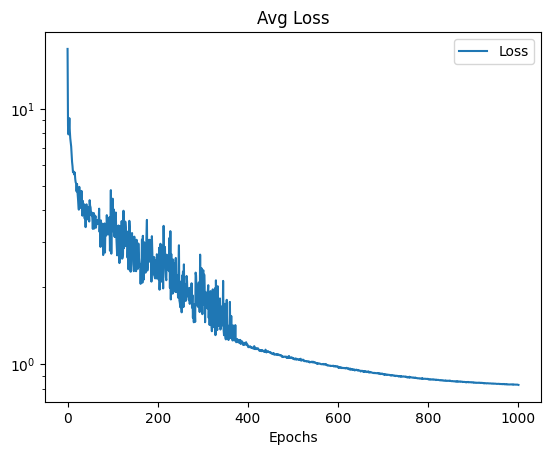

In [13]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

[4.275163403898477, 3.4079203289747237, 3.344551399797201, 3.052022387832403, 2.746585463732481, 2.868374628201127, 2.79560257807374, 2.439033187627792, 2.7300558799505232, 2.5958825169503688, 2.4238094320893286, 2.320836231969297, 2.4388198475539684, 2.3266768728196623, 3.0232739248871803, 2.287903269007802, 1.9812717724591493, 2.384140028208494, 2.1390786653757097, 2.0017408720776437, 2.3999553778767586, 2.140863554216921, 1.815220965743065, 1.751450870707631, 1.5191018357127906, 1.3510703745484351, 1.4562973836809396, 1.518452056273818, 5.014115637540817, 1.285583473071456, 1.7607194044440986, 1.4199094234406948, 1.3410927636921406, 1.609141486361623, 1.3260504795610906, 1.2052025822550059, 1.5204216891527176, 3.5675237095355987, 1.5373326710239053, 1.4564780585095287, 1.3459527925029398, 1.2342976630479097, 1.9724702965468168, 1.3090715957432986, 1.3177048810571432, 1.292314504534006, 1.3479153115302325, 1.9656560508534313, 2.065235554650426, 1.3800087800621987, 2.077280876263976, 

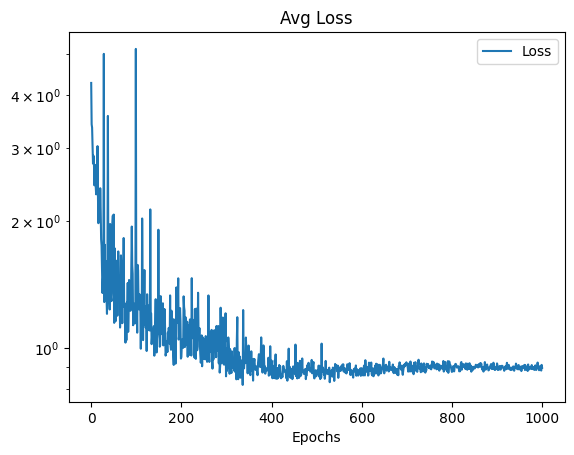

In [14]:
print(test_loss)
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

In [15]:
def comparison_total_energy(model,n_cells, device, input_csv):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    energy_true = []
    energy_computed = []
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions],n_cells)
        energy = voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),np.arange(n_cells),None)
        energy_true.append(torch.sum(energy).item()*1e4)
        energy_computed.append(torch.sum(energy_predicted).item())    #     for id_, positions in enumerate(vrai_pos[-1]):
    #             results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    # results_df = pd.DataFrame(results)
    # results_df.to_csv(output_csv, index=False)
    # print(f"Predictions saved to {output_csv}")
    return energy_true,energy_computed

In [34]:
energy_true,energy_computed = comparison_total_energy(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_57.csv")

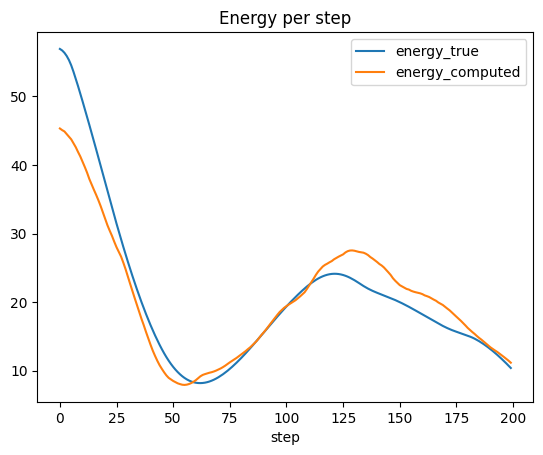

In [35]:
plt.plot(energy_true, label='energy_true')
plt.plot(energy_computed, label='energy_computed')
# plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Energy per step')
plt.show()

In [36]:
def comparison_one_cell_energy(model,n_cells, device, input_csv,cell_id):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    energy_true = []
    energy_computed = []
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions],n_cells)
        energy = voronoi_loss(torch.tensor(positions,dtype=torch.float32).to(device),np.arange(n_cells),None)
        energy_true.append((energy[cell_id]).item()*1e4)
        energy_computed.append((energy_predicted[cell_id]).item())    #     for id_, positions in enumerate(vrai_pos[-1]):
    #             results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    # results_df = pd.DataFrame(results)
    # results_df.to_csv(output_csv, index=False)
    # print(f"Predictions saved to {output_csv}")
    return energy_true,energy_computed

In [37]:
energy_true_one,energy_computed_one = comparison_one_cell_energy(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_57.csv",0)

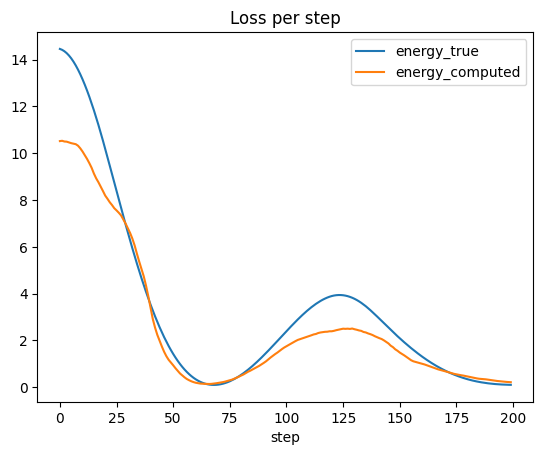

In [38]:
plt.plot(energy_true_one, label='energy_true')
plt.plot(energy_computed_one, label='energy_computed')
# plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [39]:
def comparison_many_cells_energy(model, n_cells, device, input_csv, cell_ids):
    model.eval()
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    
    energy_true_all = {cell_id: [] for cell_id in cell_ids}
    energy_computed_all = {cell_id: [] for cell_id in cell_ids}
    
    for step in steps_list[:200]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        energy_predicted = generate_next_positions(model, device, [positions], n_cells)
        energy = voronoi_loss(torch.tensor(positions, dtype=torch.float32).to(device), np.arange(n_cells), None)
        
        for cell_id in cell_ids:
            energy_true_all[cell_id].append((energy[cell_id]).item() * 1e4)
            energy_computed_all[cell_id].append((energy_predicted[cell_id]).item())
    
    return energy_true_all, energy_computed_all


In [53]:
cell_ids = list(range(10))  # les 10 premières cellules
energy_true_all, energy_computed_all = comparison_many_cells_energy(model, 10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_42.csv", cell_ids)


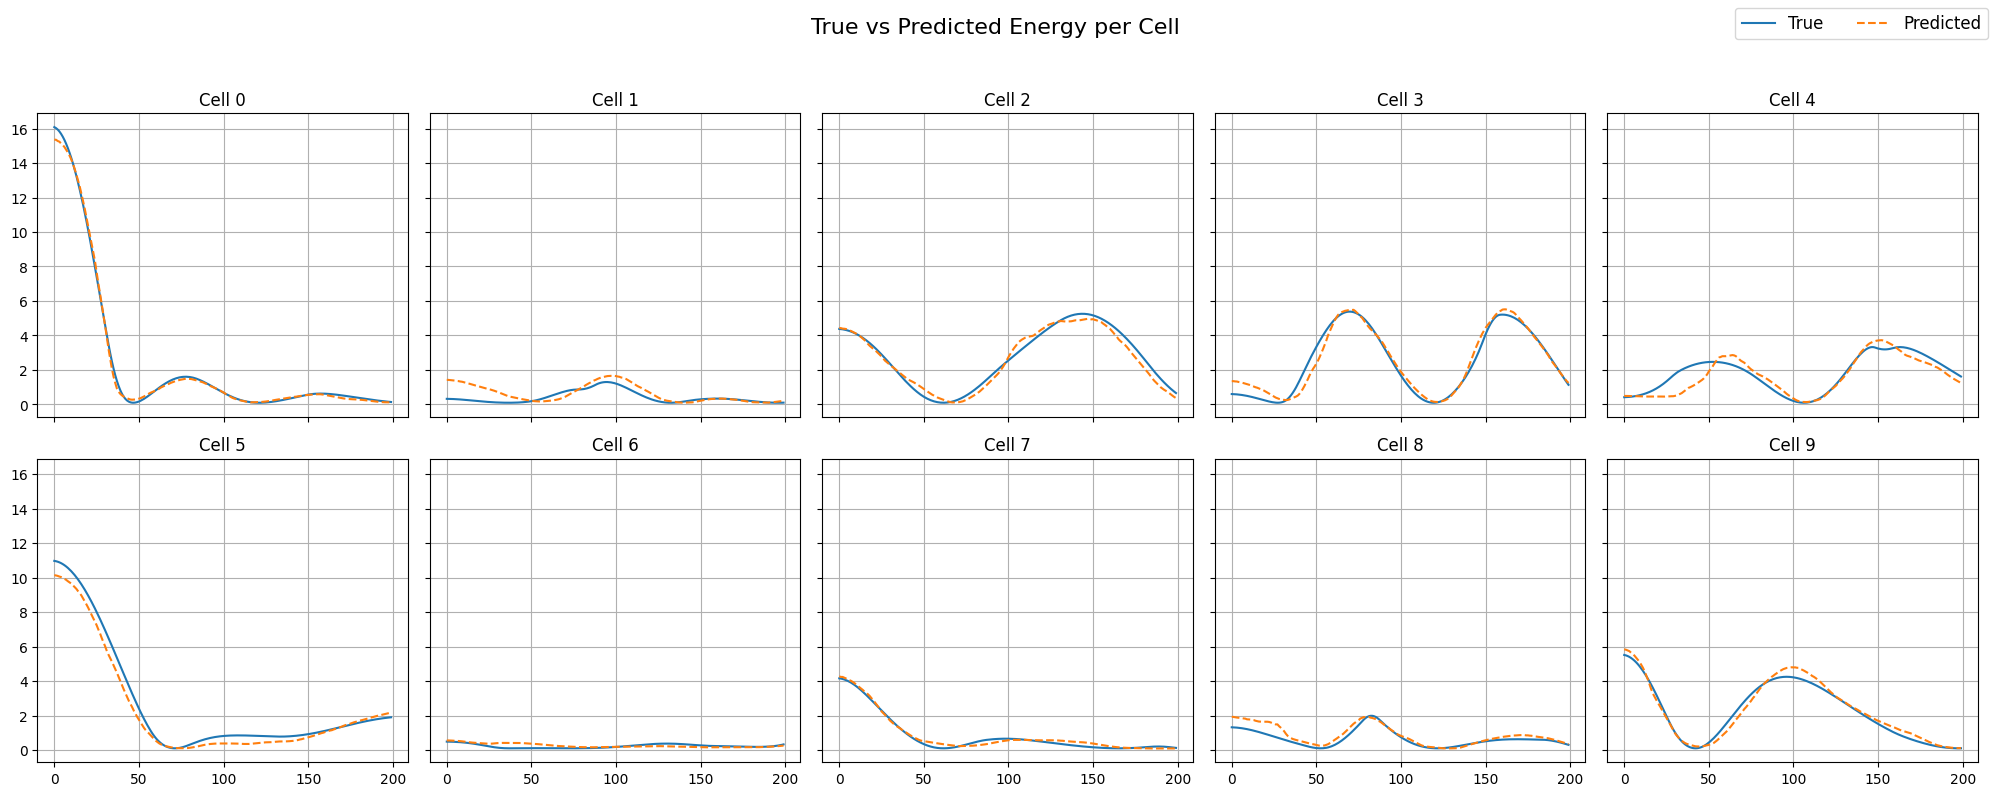

In [54]:
cell_ids = list(range(10))  # les 10 premières cellules
n_cols = 5
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

for i, cell_id in enumerate(cell_ids):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    
    ax.plot(energy_true_all[cell_id], label="True", linestyle='-')
    ax.plot(energy_computed_all[cell_id], label="Predicted", linestyle='--')
    ax.set_title(f"Cell {cell_id}")
    ax.grid(True)

# Légende commune
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, fontsize=12)

fig.suptitle("True vs Predicted Energy per Cell", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # pour laisser de la place à la légende globale
plt.show()